# 0.0. IMPORTS

In [199]:
# Biblioteca para manipulação dos dataframes
import pandas as pd

# Biblioteca para trabalhar com vetores e arrays
import numpy as np

# Biblioteca para coleta de dados
import psycopg2
import pandas.io.sql as psql
import sqlalchemy as db
from sqlalchemy import create_engine

# Bibliotecas para trabalhar com Gráficos
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scikitplot as skplt

# Biblioteca para configurar layout tela Jupyter
from IPython.core.display import HTML

# Biblioteca para inserir imagem (upload) externa
from IPython.display import Image, display 

# Biblioteca para armazenar objetos/entidades de dados
import pickle

# Bilioteca para criar tabelas manuais
from tabulate import tabulate

# Biblioteca para realizar operação aleatória
import random

# Biblioteca de Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from boruta import BorutaPy
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn import metrics as mt
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline


# Biblioteca para cálculos estatísticos e matemáticos
from scipy import stats
import math

## 0.1. Helper Functions

Seção para construção de funções auxiliares para o projeto

In [253]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 10
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    #pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    return None



# Função para criar conexão no banco onde estão os dados do projeto com a biblioteca psycopg2
def conecta_db():
    con = psycopg2.connect(host='comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com', 
                           port = 5432,
                           database='comunidadedsdb',
                           user='member', 
                           password='cdspa')
    return con



# Função para criar conexão no banco onde estão os dados do projeto com a biblioteca sqlalchemy
def conecta_db_alchemy(host, port, database, username, password):
    
    string_connect = 'postgresql://' + username + ':' + password + '@' + host + ':' + str(port) + '/' + database
    engine = db.create_engine(url = string_connect)
    conn1 = engine.connect()
    
    return conn1



# Função para consultar colunas e valores de uma tabela no banco com a biblioteca psycopg2
def consulta_db(sql):
    con = conecta_db() # conectar ao banco com nossa função conecta_db
    cur = con.cursor() # abrir uma sessão com o cursor (como se fosse o mouse mesmo)
    cur.execute(sql) #aplicar o execute para rodar o SQL 
    
    column_names = [desc[0] for desc in cur.description] # descobrir as colunas da tabela
    
    # Colocar as colunas da tabela em uma lista
    cols = []
    for i in column_names:
        cols.append(i)
        
    recset = cur.fetchall() #fetchall retorna/puxa os dados da tabela
    
    # Colocar os valores da tabela em uma lista 
    registros = []
    for rec in recset:        
        registros.append(rec)
    cur.close() # Para encerrar a conexão do cursor
    con.close() # Para encerrar a conexão do banco de dados - INTERESSANTE FAZER ISSO para não indisponibilizar para outras pessoas
    
    return cols, registros



def cramer_v( x, y ):
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def curves(y_test, yhat_proba_test, model_name, size, plot = True, axvline= "None"):

    # var. Target
    df_model_score = pd.DataFrame( {'target': y_test.tolist()} )

    # Propensão de Score de Interessados predito pelo modelo  
    df_model_score["prop_score"] = yhat_lgbm_test[ : , 1 ].tolist()

    # Ordenação da lista de propensão
    df_model_score = df_model_score.sort_values( by = 'prop_score', ascending = False ).reset_index(drop = True)

    # Número de Interessados Totais
    n_int_tot = df_model_score["target"].sum()

    # Porcentagem unitária da base
    df_model_score['porc_base'] = 1 / df_model_score.shape[0]

    # Porcentagem Acumulada da base
    # Soma acumulada linha a linha 
    df_model_score['porc_base_acum'] = df_model_score['porc_base'].cumsum()

    # excluir coluna que foi construída para calcular outra
    df_model_score.drop(columns = ['porc_base'], inplace = True)
       
    # Porcentagem unitária do total de interessados 
    por_n_int = 1 / n_int_tot

    # Porcentagem de interessados linha a linha acumulado 
    df_model_score['porc_int_acum'] = df_model_score['target'].cumsum()*por_n_int 

    # Lift
    df_model_score['lift'] = df_model_score['porc_int_acum'] / df_model_score['porc_base_acum'] 


    if plot:
        fig, ax = plt.subplots(2, 1, figsize=size)

        # Espaço entre gráficos
        fig.tight_layout(pad =5)

        # Curva de ganho
        sns.lineplot(ax = ax[0], x = df_model_score['porc_base_acum'], y = df_model_score['porc_int_acum'], label= model_name, linewidth = 2.5);
        sns.lineplot(ax = ax[0], x = df_model_score['porc_base_acum'], y = df_model_score['porc_base_acum'], label="Baseline", linewidth = 2.5, color = 'black' )
        ax[0].lines[1].set_linestyle("--")
        ax[0].set_title("Curva de Ganho Cumulativo " + model_name )
        ax[0].set_xlabel("Porcentagem de amostras")
        ax[0].set_ylabel(" Ganho (porcentagem de interessados)")
        
        if (axvline != "None") & (len(axvline) == 2):
            ax[0].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
        elif (axvline != "None") & (len(axvline) == 4):
            ax[0].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
            ax[0].axvline(axvline[3], 0, 1, color='orange', ls='--', lw=2, label = axvline[2])

        ax[0].legend()
        
        # Lift
        sns.lineplot(ax = ax[1], x = df_model_score['porc_base_acum'], y = df_model_score['lift'], label= model_name, linewidth = 2.5 );
        sns.lineplot(ax = ax[1], x = df_model_score['porc_base_acum'], y = np.ones(len(df_model_score)), label="Baseline", linewidth = 2.5, color = 'black' )
        ax[1].lines[1].set_linestyle("--")
        
        ax[1].set_title("Curva Lift")
        ax[1].set_xlabel("Porcentagem de amostras")
        ax[1].set_ylabel(" Modelo treinado / Modelo Baseline")
        
        if (axvline != "None") & (len(axvline) == 2):
            ax[1].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
        elif (axvline != "None") & (len(axvline) == 4):
            ax[1].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
            ax[1].axvline(axvline[3], 0, 1, color='orange', ls='--', lw=2, label = axvline[2])
        
        ax[1].legend()
        plt.show();
        
    return df_model_score


def finance_calculate(df_fin, model_name, size, df_return = True, plot = True, axvline= "None"):

    # Custo para a empresa atrelado a cada prospecção
    df_fin["custo"] = 75.0

    # Receita do modelo treinado ao vender o produto para um real interessado
    df_fin["receita"] = df_fin['target'].apply(lambda x: 3000.0 if x == 1.0 else 0.0)

    df_fin["lucro"] = df_fin["receita"] - df_fin["custo"] 

    df_fin["custo_acum"] = df_fin["custo"].cumsum()
    df_fin["receita_acum"] = df_fin["receita"].cumsum()
    df_fin["lucro_acum"] = df_fin["lucro"].cumsum()

    # Nº de interessados ao longo das amostras usar o modelo de ordenação treinado e baseline 

    df_fin["n_int_baseline"] = df_fin["porc_base_acum"] * df_fin["target"].sum()
    df_fin["n_int_model_final"] = df_fin["porc_int_acum"] * df_fin["target"].sum()

    # Calculei o piso do nº interessados do modelo baseline a medida que aumenta o nº de amostras

    df_fin["n_int_baseline_piso"] = df_fin["n_int_baseline"].apply(lambda x: math.floor(x) )

    ## Criar uma sequencia de valores target reais como se o modelo baseline tivesse ordenado

    target_base = [0.0]

    n_int_base_piso = df_fin["n_int_baseline_piso"].tolist()

    for i in range( len(n_int_base_piso) - 1 ):

        dif = n_int_base_piso[i+1] - n_int_base_piso[i] 

        if dif == 1:

            target_base.append(1.0)

        elif dif == 0:

            target_base.append(0.0)


    # Juntei essa lista de target ordenado pelo modelo baseline a base de dados

    df_target_base = pd.DataFrame ({"target_baseline": target_base})

    df_fin = pd.concat([df_fin, df_target_base ], axis = 1)


    # Receita para o modelo baseline 
    df_fin["receita_baseline"] = df_fin['target_baseline'].apply(lambda x: 3000.0 if x == 1.0 else 0.0)

    # Lucro para o modelo baseline
    df_fin["lucro_baseline"] = df_fin["receita_baseline"] - df_fin["custo"] 

    # Receita e Lucro acumulado para o modelo baseline
    df_fin["receita_acum_baseline"] = df_fin["receita_baseline"].cumsum()
    df_fin["lucro_acum_baseline"] = df_fin["lucro_baseline"].cumsum()


    if plot:
        fig, ax = plt.subplots(2, 1, figsize=size)

        # Espaço entre gráficos
        fig.tight_layout(pad =5)
        
        # Gráfico Receita e Custo comparando modelo treinado e Baseline

        sns.lineplot(ax = ax[0], x = df_fin['porc_base_acum'], y = df_fin['receita_acum'], label= "Receita " + model_name, linewidth = 2.5, color = 'blue');
        sns.lineplot(ax = ax[0], x = df_fin['porc_base_acum'], y = df_fin['receita_acum_baseline'], label= "Receita Baseline", linewidth = 2.5, color = 'black');
        sns.lineplot(ax = ax[0], x = df_fin['porc_base_acum'], y = df_fin['custo_acum'], label="Custo", linewidth = 2.5, color = 'red')
        
        
        ax[0].lines[1].set_linestyle("--")
        ax[0].set_title("Receita X Custo ")
        ax[0].set_xlabel("Porcentagem de amostras")
        ax[0].set_ylabel("R$")
        
        if (axvline != "None") & (len(axvline) == 2):
            ax[0].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
        elif (axvline != "None") & (len(axvline) == 4):
            ax[0].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
            ax[0].axvline(axvline[3], 0, 1, color='orange', ls='--', lw=2, label = axvline[2])

        ax[0].legend()    
        
        # Gráfico Lucro comparando modelo treinado e Baseline
        sns.lineplot(ax = ax[1], x = df_fin['porc_base_acum'], y = df_fin['lucro_acum'], label= "Lucro " + model_name, linewidth = 2.5, color = 'blue');
        sns.lineplot(ax = ax[1], x = df_fin['porc_base_acum'], y = df_fin['lucro_acum_baseline'], label= "Lucro Baseline", linewidth = 2.5, color = 'black');  
        
        ax[1].lines[1].set_linestyle("--")
        ax[1].set_title("Lucros")
        ax[1].set_xlabel("Porcentagem de amostras")
        ax[1].set_ylabel(" R$ ")
        
        if (axvline != "None") & (len(axvline) == 2):
            ax[1].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
        elif (axvline != "None") & (len(axvline) == 4):
            ax[1].axvline(axvline[1], 0, 1, color='green', ls='--', lw=2, label = axvline[0])
            ax[1].axvline(axvline[3], 0, 1, color='orange', ls='--', lw=2, label = axvline[2])
        
        
        ax[1].legend()
        
        plt.show();
    
    
    if df_return:
        
        return df_fin
    
    return None


def ml_performance( y_val, yhat_proba, k ):
    
       
    # var. Target
    m = pd.DataFrame( {'target': y_val.tolist()} )
          
    # Propensão de Score do Interesse 
    m["prop_score"] = yhat_proba[ : , 1 ].tolist()
    
    # Ordenação da lista de propensão
    m = m.sort_values( by = 'prop_score', ascending = False ).reset_index(drop = True)
    
    # Ranking 
    m["rank"] = m.index + 1 
    
    # Métricas de Ordenação
    m["precision_at_k"] = m['target'].cumsum() / m['rank']
    m["recall_at_k"] = m['target'].cumsum() / m['target'].sum()
    m["F1_at_k"] = 2 * ( (m["precision_at_k"] * m["recall_at_k"]) / (m["precision_at_k"] + m["recall_at_k"]) )
    
    
    m_k = m.loc[ m["rank"].isin(k) , ["precision_at_k", "recall_at_k", "F1_at_k"] ]

    return m_k

def ml_performance_CV( clr, x_val ,y_val ):
    
    # valor do rank
    k = [20000]
       
    # var. Target
    m = pd.DataFrame( {'target': y_val.tolist()} )
       
    # prediction
    yhat_proba = clr.predict_proba( x_val )
    
    # Propensão de Score do Interesse 
    m["prop_score"] = yhat_proba[ : , 1 ].tolist()
    
    # Ordenação da lista de propensão
    m = m.sort_values( by = 'prop_score', ascending = False ).reset_index(drop = True)
    
    # Ranking 
    m["rank"] = m.index + 1 
    
    # Métricas de Ordenação
    m["precision_at_k"] = m['target'].cumsum() / m['rank']
    m["recall_at_k"] = m['target'].cumsum() / m['target'].sum()
    m["F1_at_k"] = 2 * ( (m["precision_at_k"] * m["recall_at_k"]) / (m["precision_at_k"] + m["recall_at_k"]) )
    
    
    df_m = m.loc[ m["rank"].isin(k) , ["precision_at_k"] ]
    
    pre_k = df_m["precision_at_k"]

    return pre_k

def feature_engineering(x_training, x_validation):

        
    # driving_license - [1, 0]

    x_training['driving_license'] = x_training['driving_license'].apply(lambda x: 'yes' if x == 1 else 'no')
    
    x_validation['driving_license'] = x_validation['driving_license'].apply(lambda x: 'yes' if x == 1 else 'no')

    
    # vehicle_age   - [> 2 Years, 1-2 Year, < 1 Year]

    x_training['vehicle_age'] = x_training['vehicle_age'].apply(lambda x: 'Menos de 1 ano' if x == '< 1 Year' else 'Entre 1 e 2 anos' if x == '1-2 Year' else 
                                                'Mais de 2 anos') 
    
    x_validation['vehicle_age'] = x_validation['vehicle_age'].apply(lambda x: 'Menos de 1 ano' if x == '< 1 Year' else 'Entre 1 e 2 anos' if x == '1-2 Year' else 
                                                'Mais de 2 anos') 

    # vehicle_damage  - [Yes, No]

    x_training['vehicle_damage'] = x_training['vehicle_damage'].apply(lambda x: 'yes' if x == 'Yes' else 'no') 

    x_validation['vehicle_damage'] = x_validation['vehicle_damage'].apply(lambda x: 'yes' if x == 'Yes' else 'no') 
    
    
    # vehicle_insured   -    [0, 1]

    x_training['vehicle_insured'] = x_training['vehicle_insured'].apply(lambda x: 'yes' if x == 1 else 'no')
    
    x_validation['vehicle_insured'] = x_validation['vehicle_insured'].apply(lambda x: 'yes' if x == 1 else 'no')

    
    ### Das variáveis -> SEPARAR EM VARIÁVEIS CATEGÓRICAS QUANTITATIVAS 

    # age -> [20-30 | 31-50 | 51 - 80]
    
    x_training['age_level'] = x_training['age'].apply(lambda x: '20-30' if (x >= 20) & (x <= 30) else '31-40' if (x > 30) & (x <= 40) else '41-50'
                                                          if (x > 40) & (x <= 50) else '51-85')
    
    x_validation['age_level'] = x_validation['age'].apply(lambda x: '20-30' if (x >= 20) & (x <= 30) else '31-40' if (x > 30) & (x <= 40) else '41-50'
                                                          if (x > 40) & (x <= 50) else '51-85')


    # days_client_associate -> [ 10-100 | 101-200 | 201-299 ]

    x_training['days_client_associate_level'] = x_training['days_client_associate'].apply(lambda x: '10-100' if (x >= 10) & (x <= 100) else '101-200' if (x > 100) & (x <= 200) else '201-299' )
    x_validation['days_client_associate_level'] = x_validation['days_client_associate'].apply(lambda x: '10-100' if (x >= 10) & (x <= 100) else '101-200' if (x > 100) & (x <= 200) else '201-299' )
    
    

    # annual_premium -> Range grande que vai de 2.630,00 a 540.165,00

    x_training["annual_premium_level"] = x_training["annual_premium"].apply(lambda x: '0-20000' if (x >= 0) & (x <= 20000) else '20001-25000' 
                                                                                  if (x > 20000) & (x <= 25000) else '25001-30000' 
                                                                                  if (x > 25000) & (x <= 30000) else '30001-35000'
                                                                                  if (x > 30000) & (x <= 35000) else '35001-40000'
                                                                                  if (x > 35000) & (x <= 40000) else '40001-60000'
                                                                                  if (x > 40000) & (x <= 60000) else '60001-540165')

    
    
    x_validation["annual_premium_level"] = x_validation["annual_premium"].apply(lambda x: '0-20000' if (x >= 0) & (x <= 20000) else '20001-25000' 
                                                                                  if (x > 20000) & (x <= 25000) else '25001-30000' 
                                                                                  if (x > 25000) & (x <= 30000) else '30001-35000'
                                                                                  if (x > 30000) & (x <= 35000) else '35001-40000'
                                                                                  if (x > 35000) & (x <= 40000) else '40001-60000'
                                                                                  if (x > 40000) & (x <= 60000) else '60001-540165')
    
    
    
    return x_training, x_validation 




def data_preparation(x_training, x_validation):
    
    ### SCALERS
    ## instanciar a classe 
    ss = StandardScaler()
    rs = RobustScaler()
    mms = MinMaxScaler()
    
    
    ## days_client_associate
    
    # Treino    
    x_training["days_client_associate"] = ss.fit_transform( x_training[["days_client_associate"]].values )

    # Validação   
    x_validation["days_client_associate"] = ss.transform( x_validation[["days_client_associate"]].values )
    
    
    ## age 
    
    # Treino 
    x_training['age'] = mms.fit_transform( x_training[['age']].values )
    
    # Validação     
    x_validation['age'] = mms.transform( x_validation[['age']].values )
    
    ## annual_premium 
       
    # Treino
    x_training['annual_premium'] = rs.fit_transform( x_training[['annual_premium']].values )

    # Validação
    x_validation['annual_premium'] = rs.transform( x_validation[['annual_premium']].values )
    
    
    ## ENCODERS
    # Variáveis Ordinais:

    ########### vehicle_age - Ordinal Encoding             

    vehicle_age_dict = {'Menos de 1 ano': 0 , 'Entre 1 e 2 anos': 1, 'Mais de 2 anos': 2}
    
    # Treino
    x_training['vehicle_age'] = x_training['vehicle_age'].map( vehicle_age_dict )
    
    # Validação
    x_validation['vehicle_age'] = x_validation['vehicle_age'].map( vehicle_age_dict )

    ########## age_level - Ordinal Encoding 

    age_level_dict = {'20-30': 0 , '31-40': 1, '41-50': 2, '51-85': 3}
   
    # Treino
    x_training['age_level'] = x_training['age_level'].map( age_level_dict )
    
    # Validação
    x_validation['age_level'] = x_validation['age_level'].map( age_level_dict )

    ######### days_client_associate_level - Ordinal Encoding 

    dcal_dict = {'10-100': 0 , '101-200': 1, '201-299' : 2}

    # Treino
    x_training['days_client_associate_level'] = x_training['days_client_associate_level'].map( dcal_dict )

    # Validação
    x_validation['days_client_associate_level'] = x_validation['days_client_associate_level'].map( dcal_dict )

    ######### annual_premium_level - Ordinal Encoding 

    apl_dict = {'0-20000': 0 , '20001-25000': 1, '25001-30000': 2, '30001-35000': 3,'35001-40000': 4, '40001-60000': 5, '60001-540165': 6}

    # Treino
    x_training['annual_premium_level'] = x_training['annual_premium_level'].map( apl_dict )

    # Validação
    x_validation['annual_premium_level'] = x_validation['annual_premium_level'].map( apl_dict )

    
    # Variáveis Nominais:

    ######### region_code e sales_channel - Target Encoding

    ## transformando em object 
    x_training[['region_code', 'sales_channel']] = x_training[['region_code', 'sales_channel']].astype("object")
    x_validation[['region_code', 'sales_channel']] = x_validation[['region_code', 'sales_channel']].astype("object")

    ## instanciando a classe 
    te = TargetEncoder(cols=['region_code', 'sales_channel'], smoothing=0)

    ## Ajustando conforme variável resposta e transformando
    x_training = te.fit_transform(x_training, y = x_training['interested'], )
    x_validation = te.transform(x_validation)
    
    
    ############# 'driving_license', 'vehicle_damage', 'vehicle_insured', 'gender' - One Hot Encoding                            

    colunas_categoricas = ['driving_license', 'vehicle_damage', 'vehicle_insured', 'gender']

    one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    colunas_categoricas),
    remainder='passthrough')

    x_training = one_hot_enc.fit_transform(x_training)
    x_training = pd.DataFrame(x_training, columns=one_hot_enc.get_feature_names_out())
    
    x_validation = one_hot_enc.transform(x_validation)
    x_validation = pd.DataFrame(x_validation, columns=one_hot_enc.get_feature_names_out())
    
        
    return x_training, x_validation


def cross_validation (training, target, kfold, model_name, hp, model, cols, rank, verbose = False):
    
     # Listas para guardar resultados algoritmos para cada fold de treino 
    pre_k_train = []
    rec_k_train = []
    f1_k_train = []
    
    # Listas para guardar resultados algoritmos para cada fold de validação 
    pre_k_val = []
    rec_k_val = []
    f1_k_val = []
   
     ## Aplicação da forma de repartição train and validation via StratifiedKFold

    kf = StratifiedKFold(n_splits = kfold)

    for k, (i_train, i_val) in enumerate( kf.split(training, target) ):
         
         # 1. MOSTRADOR DE EVOLUÇÃO DO PROCESSO
        if verbose:
             print(f"\nKFold Number {k + 1}")

                
        ## 2. DIVISÃO TREINO E VALIDAÇÃO  

        ## Filtrando apenas dados de entrada(x) e variável resposta(y) de treino
        x_training = training.loc[ i_train , : ]
        y_training = x_training['interested'].copy()

        ## Filtrando apenas dados de entrada(x) e variável resposta(y) de validação
        x_validation = training.loc[ i_val , : ]
        y_validation = x_validation['interested'].copy()
        
        ## 3. FEATURE ENGINEERING
        
        x_training, x_validation = feature_engineering(x_training, x_validation)
        
        
        ## 4. PREPARAÇÃO DADOS DE TREINO E TESTE 
        
        x_training, x_validation = data_preparation(x_training, x_validation) 
        
        
         ## 5. FEATURE SELECTION

        ## Dados de treinamento e validação com colunas selecionadas para fazer o CV
        x_training_last = x_training[ cols ]
        x_validation_last = x_validation[ cols ]
        
        ## 6. BALANCED CLASS DATASET with SMOTE
            
         #if balanced:
            
            
             # algoritmo definição
          #   smote = SMOTE(sampling_strategy= 1, random_state= 42)

             # Ajuste e reamostragem 
          #  x_training, y_training = smote.fit_resample(x_training, y_training)
        
        
         ## 7. TREINANDO MODELOS
        
        
         # model - Generalizando para todos os modelos
        clr = model.fit( x_training_last, y_training ) 

        # performance 
        
        # treino 
        m_train = ml_performance( clr , x_training_last ,y_training)
        # validação
        m_val = ml_performance( clr , x_validation_last ,y_validation)

       # Adiciono os resultados de performances de modelos para cada Fold(iteração) no Treino
        pre_k_train.append(m_train["precision_at_k"]) 
        rec_k_train.append(m_train["recall_at_k"]) 
        f1_k_train.append(m_train["F1_at_k"])

        # Adiciono os resultados de performances de modelos para cada Fold(iteração) na Validação
        pre_k_val.append(m_val["precision_at_k"]) 
        rec_k_val.append(m_val["recall_at_k"]) 
        f1_k_val.append(m_val["F1_at_k"])
        
     
    
    return pd.DataFrame(     {        'Algorithm': model_name, 
                                      'Parameters': str(hp), 
                                      'Train Precision_at_20k': str( np.round( np.mean(pre_k_train), 4 ) ) + " +/- " + str( np.round( np.std(pre_k_train), 4)  ) ,
                                      'Val Precision_at_20k':   str( np.round( np.mean(pre_k_val), 4 ) ) + " +/- " + str( np.round( np.std(pre_k_val), 4)  ),
                                      'Train Recall_at_20k':    str( np.round( np.mean(rec_k_train), 4 ) ) + " +/- " + str( np.round( np.std(rec_k_train), 4)  ) , 
                                      'Val Recall_at_20k':      str( np.round( np.mean(rec_k_val), 4 ) ) + " +/- " + str( np.round( np.std(rec_k_val), 4)  ) ,
                                      'Train F1_at_20k':        str( np.round( np.mean(f1_k_train), 4 ) ) + " +/- "  + str( np.round( np.std(f1_k_train), 4)   ),
                                      'Val F1_at_20k':          str( np.round( np.mean(f1_k_val), 4 ) ) + " +/- " + str( np.round( np.std(f1_k_val), 4)  ) },
                                       index = [0] )
  

In [4]:
jupyter_settings()

## 0.2. Collect Data using psycopg2

Carregamento dos dados - Extração

### 0.2.1. Descobrindo as tabelas que existem no BD

In [11]:
con = conecta_db() # conectar ao banco com nossa função conecta_db
cur = con.cursor() # abrir uma sessão com o cursor
cur.execute('SELECT table_catalog, table_schema, table_name, table_type FROM information_schema.tables;') #aplicar o execute para rodar o SQL 
recset = cur.fetchall() #fetchall retorna os dados
recset


[('comunidadedsdb', 'public', 'auth_permission', 'BASE TABLE'),
 ('comunidadedsdb', 'pa004', 'users', 'BASE TABLE'),
 ('comunidadedsdb', 'pa004', 'vehicle', 'BASE TABLE'),
 ('comunidadedsdb', 'pa004', 'insurance', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'django_migrations', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'django_content_type', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'auth_group', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'auth_group_permissions', 'BASE TABLE'),
 ('comunidadedsdb', 'pg_catalog', 'pg_type', 'BASE TABLE'),
 ('comunidadedsdb', 'pg_catalog', 'pg_foreign_server', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'htx_user', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'htx_user_groups', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'htx_user_user_permissions', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'data_export_export', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'data_import_fileupload', 'BASE TABLE'),
 ('comunidadedsdb', 'public', 'django_admin_

### 0.2.2. Coleta da Base de dados Users

In [82]:
col, reg = consulta_db('select * from pa004.users')

df_users = pd.DataFrame(reg, columns = col)

df_users.head()

id  gender  age  region_code  policy_sales_channel
0   1    Male   44        28.00                 26.00
1   2    Male   76         3.00                 26.00
2   3    Male   47        28.00                 26.00
3   4    Male   21        11.00                152.00
4   5  Female   29        41.00                152.00

In [31]:
df_users.shape

(381109, 5)

### 0.2.3. Coleta da Base de dados Vehicle

In [83]:
col, reg = consulta_db('select * from pa004.vehicle')

df_ve = pd.DataFrame(reg, columns = col)

df_ve.head()

id  driving_license vehicle_age vehicle_damage
0   1                1   > 2 Years            Yes
1   2                1    1-2 Year             No
2   3                1   > 2 Years            Yes
3   4                1    < 1 Year             No
4   5                1    < 1 Year             No

In [35]:
df_ve.shape

(381109, 4)

### 0.2.4. Coleta da Base de dados Insurance

In [84]:
col, reg = consulta_db('select * from pa004.insurance')

df_insu = pd.DataFrame(reg, columns = col)

df_insu.head()

id  previously_insured  annual_premium  vintage  response
0   1                   0        40454.00      217         1
1   2                   0        33536.00      183         0
2   3                   0        38294.00       27         1
3   4                   1        28619.00      203         0
4   5                   1        27496.00       39         0

In [36]:
df_insu.shape

(381109, 5)

**Análise:** Como cada uma das bases da problemática não possuem colunas em comum e a quantidade de linhas em cada uma delas é a mesma, para juntar os dados, deve-se unir as tabelas lateralmente

### 0.2.5. Base de Dados Final

In [85]:
df_half = pd.merge(df_users, df_ve, how = 'inner', on = 'id')
df_full = pd.merge(df_half, df_insu, how = 'inner', on = 'id')

In [9]:
df_full.head()

id  gender  age  region_code  policy_sales_channel  driving_license vehicle_age vehicle_damage  previously_insured  annual_premium  vintage  response
0   1    Male   44        28.00                 26.00                1   > 2 Years            Yes                   0        40454.00      217         1
1   2    Male   76         3.00                 26.00                1    1-2 Year             No                   0        33536.00      183         0
2   3    Male   47        28.00                 26.00                1   > 2 Years            Yes                   0        38294.00       27         1
3   4    Male   21        11.00                152.00                1    < 1 Year             No                   1        28619.00      203         0
4   5  Female   29        41.00                152.00                1    < 1 Year             No                   1        27496.00       39         0

## 0.3. Option of Collect Data using Pandas

In [55]:
## Credenciais

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

In [61]:
## DUAS FORMAS:

## 1

query_tables = """ SELECT * 
                   FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                                      INNER JOIN pa004.insurance i ON (u.id = i.id)
                """

df = psql.read_sql( query_tables, conecta_db_alchemy(host, port, database, username, password ) )

df.head()

id  gender  age  region_code  policy_sales_channel  id  driving_license  \
0   7    Male   23         11.0                 152.0   7                1   
1  13  Female   41         15.0                  14.0  13                1   
2  18  Female   25         35.0                 152.0  18                1   
3  31  Female   26          8.0                 160.0  31                1   
4  39    Male   45          8.0                 124.0  39                1   

  vehicle_age vehicle_damage  id  previously_insured  annual_premium  vintage  \
0    < 1 Year            Yes   7                   0         23367.0      249   
1    1-2 Year             No  13                   1         31409.0      221   
2    < 1 Year             No  18                   1         46622.0      299   
3    < 1 Year             No  31                   0          2630.0      136   
4    1-2 Year            Yes  39                   0         42297.0      264   

   response  
0         0  
1         0  
2         0  
3         0  
4         0

In [62]:
## 2

query_tables = """ SELECT * 
                   FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                                      INNER JOIN pa004.insurance i ON (u.id = i.id)
                """

df = pd.read_sql( query_tables, conecta_db_alchemy(host, port, database, username, password) )

df.head()

id  gender  age  region_code  policy_sales_channel  id  driving_license  \
0   7    Male   23         11.0                 152.0   7                1   
1  13  Female   41         15.0                  14.0  13                1   
2  18  Female   25         35.0                 152.0  18                1   
3  31  Female   26          8.0                 160.0  31                1   
4  39    Male   45          8.0                 124.0  39                1   

  vehicle_age vehicle_damage  id  previously_insured  annual_premium  vintage  \
0    < 1 Year            Yes   7                   0         23367.0      249   
1    1-2 Year             No  13                   1         31409.0      221   
2    < 1 Year             No  18                   1         46622.0      299   
3    < 1 Year             No  31                   0          2630.0      136   
4    1-2 Year            Yes  39                   0         42297.0      264   

   response  
0         0  
1         0  
2         0  
3         0  
4         0

# 1.0. DESCRIÇÃO DOS DADOS

In [86]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df1 = df_full.copy()

## 1.1. Rename Columns

Ter o nome das colunas de maneira mais intuitiva para trabalhar com ciência de dados

In [21]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

Caso o estilo do nome dado para as colunas estivesse em Kamel Case, poderia aqui fazer uma alteração para trabalhar com Snake Case.

In [87]:
#renomeando nome das colunas para façam mais sentido durante análise, evitando interpretações erradas e levando em conta tamanho do nome

# policy_sales_channel -> sales_channel
# previously_insured -> vehicle_insured
# vintage -> days_client_associate
# response -> interested 


df1.rename(columns = {'policy_sales_channel':'sales_channel', 'previously_insured' : 'vehicle_insured', 'vintage': 'days_client_associate',
                      'response':'interested'}, inplace = True)

Caso a ordenação das colunas do dataset estivesse de uma forma desorganizada, poderia aqui organizar a ordem das colunas.

In [12]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_insured',
       'annual_premium', 'days_client_associate', 'interested'],
      dtype='object')

## 1.2 Columns Meanings

Objetivo é compreender o significado de cada coluna  


- **id:** uma identificação única para cada cliente;


- **gender:** gênero do cliente;


- **age:** idade do cliente;


- **region_code:** uma identificação única que indica a região de cada cliente;	


- **sales_channel:** código anônimo que representa o canal de contato/divulgação que o cliente utilizou com a empresa no momento da venda;


- **driving_license:** indica se o cliente possui ou não permissão (documento) para dirigir (0 = não possui, 1 = possui);


- **vehicle_age:** idade do veículo;	


- **vehicle_damage:** indica se o cliente já danificou o veículo no passado (No, Yes);


- **vehicle_insured:** indica se o cliente já possui seguro para o veículo (0 = não possui, 1 = possui);


- **annual_premium:** montante que o cliente necessita pagar como prêmio anualmente;

OBS: Não ficou explícito se esse prêmio se refere ao novo produto de seguro veicular ou se seria o de saúde que o cliente já paga, na minha interpretação ele representa o prêmio pago anualmente pelo cliente pelo serviço de seguro de saúde que já possui.


- **days_client_associate:** número de dias em que a pessoa é cliente da empresa;	


- **interested:** indica se o cliente está interessado no serviço de seguro veicular (0 = não está interessado, 1 = está interessado).


## 1.3. Data Dimensions

In [32]:
print(f'Quantidade de Linhas: {df1.shape[0]}')
print(f'Quantidade de Colunas: {df1.shape[1]}')

#print('Quantidade de Linhas: {}'.format(df1.shape[0]))
#print('Quantidade de Colunas: {}'.format(df1.shape[1]))

Quantidade de Linhas: 381109
Quantidade de Colunas: 12


## 1.4. Data Types

In [36]:
## INSPECIONANDO


df1.dtypes

id                         int64
gender                    object
age                        int64
region_code              float64
sales_channel            float64
driving_license            int64
vehicle_age               object
vehicle_damage            object
vehicle_insured            int64
annual_premium           float64
days_client_associate      int64
interested                 int64
dtype: object

In [44]:
# 'region_code'

df1['region_code'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [48]:
# 'sales_channel'

df1['sales_channel'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 15

In [49]:
# 'vehicle_age'
# por enquanto não irei alterar pois o dado condiz com o tipo, mas depois na etapa de feature eng. posso mexer nela

df1['vehicle_age'].sort_values().unique()

array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object)

In [50]:
# 'vehicle_damage'
# por enquanto não irei alterar pois o dado condiz com o tipo, mas depois na etapa de feature eng. posso mexer nela

df1['vehicle_damage'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

**Análise:**

- region_code é uma identificação única que indica a região de cada cliente e vai de 0 a 52

***Ação:*** Trocar de float para int, pois não há número com vírgula;

- sales_channel é o código anônimo que representa o canal de contato/divulgação que o cliente utiliza com a empresa e está distribuído entre 1 e 163

***Ação:*** Trocar de float para int, pois não há número com vírgula.

In [88]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['sales_channel'] = df1['sales_channel'].astype('int64')

## 1.5. Check Duplicates

In [38]:
## Checando ID´s duplicados

dup = df1['id'].duplicated()

df1[dup]

Empty DataFrame
Columns: [id, gender, age, region_code, sales_channel, driving_license, vehicle_age, vehicle_damage, vehicle_insured, annual_premium, days_client_associate, interested]
Index: []

In [39]:
df1['id'].duplicated().sum()

0

**Análise:**

- Não existem clientes com registro duplicado no conjunto de dados. Sendo assim, não é necessário tratá-lo.

## 1.6. Check NA

In [60]:
# MÉTODO .isna() vai varrer o dataset indicando para cada valor de linha e coluna se está NA (True) ou possui valor (False)   
# .sum() para somar os valores True nas colunas e dar dimensão de dados faltantes por coluna

df1.isna().sum()

id                       0
gender                   0
age                      0
region_code              0
sales_channel            0
driving_license          0
vehicle_age              0
vehicle_damage           0
vehicle_insured          0
annual_premium           0
days_client_associate    0
interested               0
dtype: int64

**Análise:**

- Não existem valores nulos em nenhum atributo do conjunto de dados. Sendo assim, não é necessário tratá-lo.

## 1.7. Descriptive Statistical

Train + Test Data

OBS: Correto aqui seria analisar os dados apenas de treino - Fazer no ciclo 2

In [62]:
df1.dtypes

id                         int64
gender                    object
age                        int64
region_code                int64
sales_channel              int64
driving_license            int64
vehicle_age               object
vehicle_damage            object
vehicle_insured            int64
annual_premium           float64
days_client_associate      int64
interested                 int64
dtype: object

In [94]:
## Separar atributos/colunas em numéricas e categóricas

num_attributes = df1[['age', 'annual_premium', 'days_client_associate']]
cat_attributes = df1[['gender', 'region_code', 'sales_channel','driving_license', 'vehicle_age','vehicle_damage', 'vehicle_insured','interested']]

**OBS:** se possui-se atributos com data buscaria analisar o range das datas.

### 1.7.1. Numerical Attributes

In [90]:
# OPTION 1

# Central Tendency - mean, median

# ct1 = pd.DataFrame( num_attributes.apply( np.mean ) )
# ct2 = pd.DataFrame( num_attributes.apply( np.median ) )
# 
# # Dispersion - std, min, max, range, skew, kurtosis
# d1 = pd.DataFrame( num_attributes.apply( np.std ) )
# d2 = pd.DataFrame( num_attributes.apply( min ) )
# d3 = pd.DataFrame( num_attributes.apply( max ) )
# d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) )
# d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) )
# d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) )
# 
# m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
# 
# m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']

# OPTION  2

## Min, Max, Range, Mean, Median, Std, Skew, Kurtosis
num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})



attributes     min       max     range     mean   median      std  skew  kurtosis
0                    age   20.00     85.00     65.00    38.82    36.00    15.51  0.67     -0.57
1         annual_premium 2630.00 540165.00 537535.00 30564.39 31669.00 17213.16  1.77     34.00
2  days_client_associate   10.00    299.00    289.00   154.35   154.00    83.67  0.00     -1.20

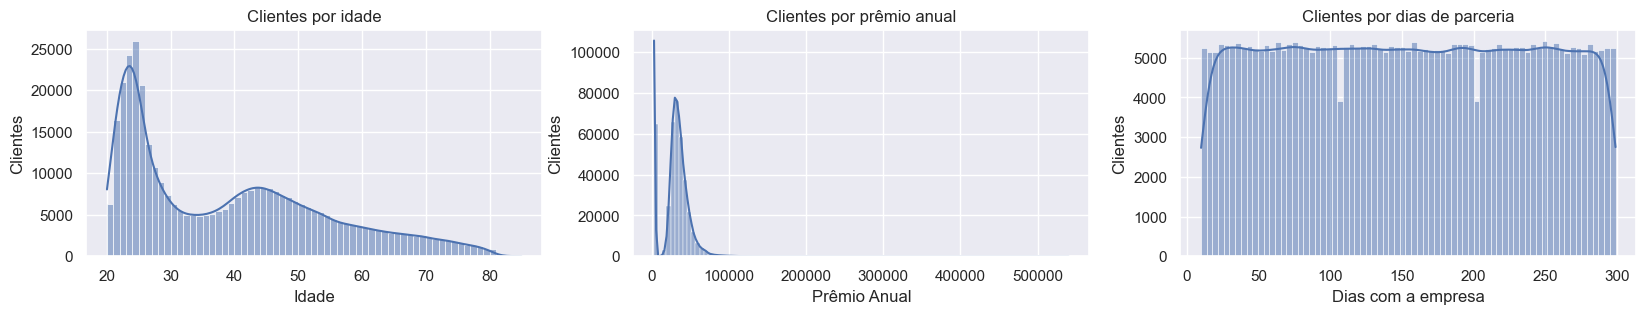

In [91]:
#Num Attributes plot

plt.subplot (3,3,1)
age = sns.histplot(df1['age'], binwidth=1, kde=True);
age.set_ylabel('Clientes')
age.set_xlabel('Idade')
age.set_title('Clientes por idade');

plt.subplot (3,3,2)
ap = sns.histplot(data = df1 , x = 'annual_premium', bins = 100, kde = True);
ap.set_ylabel('Clientes')
ap.set_xlabel('Prêmio Anual')
ap.set_title('Clientes por prêmio anual');

plt.subplot (3,3,3)
da_hist = sns.histplot(df1['days_client_associate'], kde=True);
da_hist.set_ylabel('Clientes')
da_hist.set_xlabel('Dias com a empresa')
da_hist.set_title('Clientes por dias de parceria');

DICA: Colocar os valores de media, range, mediana dentro da análise das variáveis.

**Análises:**

*age:*

- A base de clientes possui idade entre 20 a 85 anos;
- Não possui range elevado; 
- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais pessoas de 20 a 50 anos;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos dados entre as idades.

*days_client_associate:*

- A base de clientes está junto a empresa variando entre 10 a 299 dias;
- Skew muito próxima de zero indica distribuição próxima da normal, ou seja, indica que a distribuição dos dados é simétrica;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos valores entre os clientes.

*annual_premium:*

- A base de clientes paga um prêmio de seguro atualmente que varia entre 2.630,00 a 540.165,00 reais;
- Range muito elevado;
- Desvio Padrão alto;
- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais clientes pagam prêmio entre 2.630,00 a 100.000,00 reais;
- Kurtosis bastante positiva indica que há deformação vertical devido a concentração dos dados sob um ponto.

<AxesSubplot: xlabel='interested', ylabel='days_client_associate'>

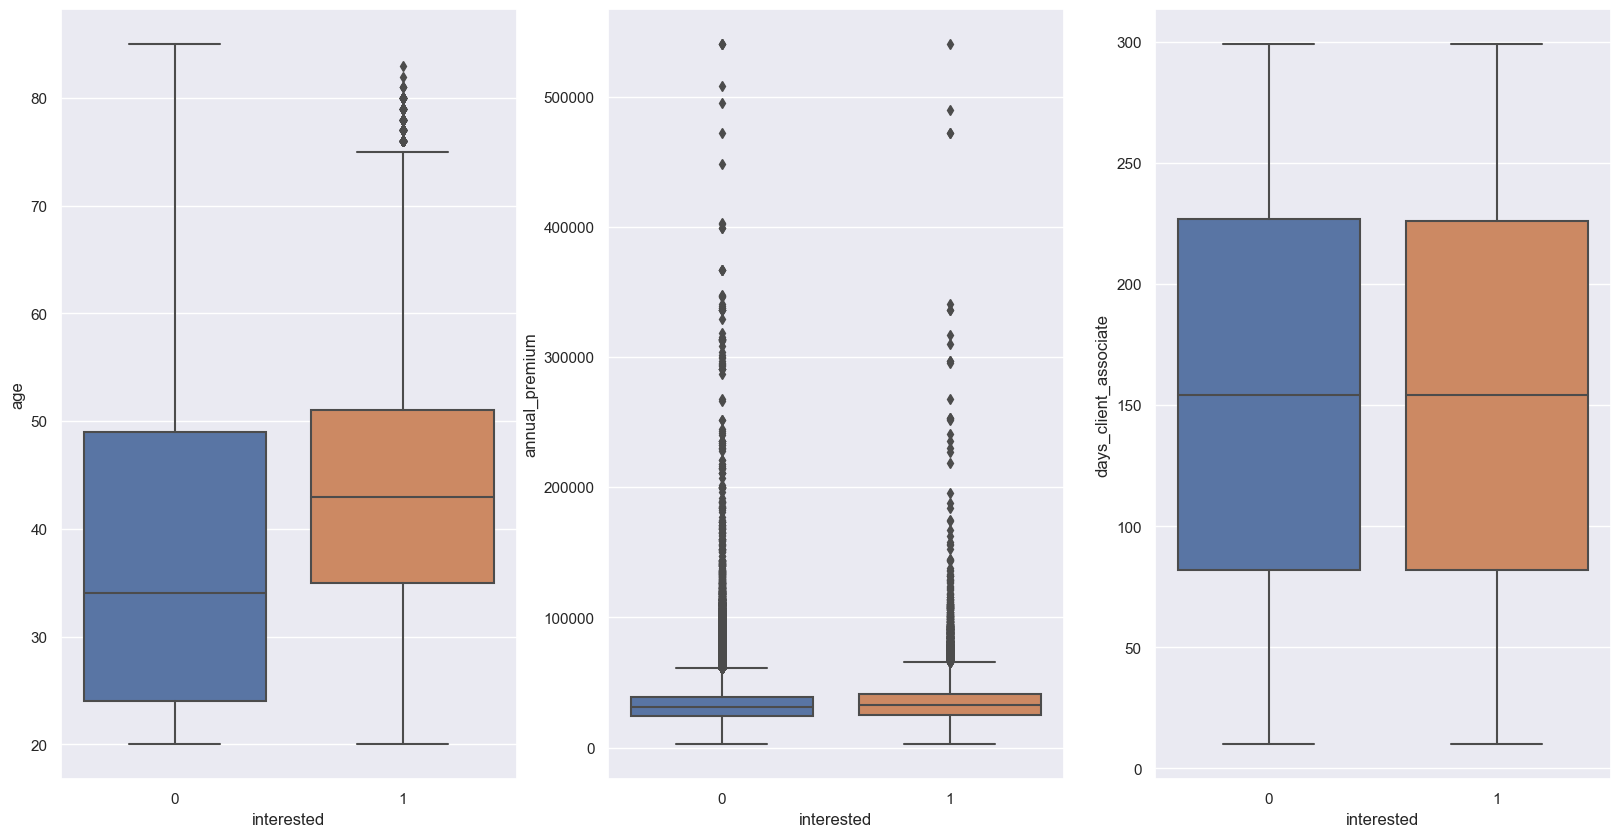

In [81]:
# Idade do cliente segmentado por interesse
plt.subplot( 1, 3, 1)
sns.boxplot(x = 'interested', y = 'age', data = df1 )

# Prêmio pago segmentado por interesse
plt.subplot( 1, 3, 2)
sns.boxplot(x = 'interested', y = 'annual_premium', data = df1 )

# Dias em que a pessoa é cliente segmentado por interesse
plt.subplot( 1, 3, 3)
sns.boxplot(x = 'interested', y = 'days_client_associate', data = df1 )

In [92]:
## Ampliar o box-plot do premio annual para valores mais concentrados, retirando outliers

Q1 = df1['annual_premium'].quantile(0.25)
Q3 = df1['annual_premium'].quantile(0.75)

IQR = Q3 - Q1 

val_max = Q3 + 1.5*IQR

val_max

61892.5

<AxesSubplot: xlabel='interested', ylabel='annual_premium'>

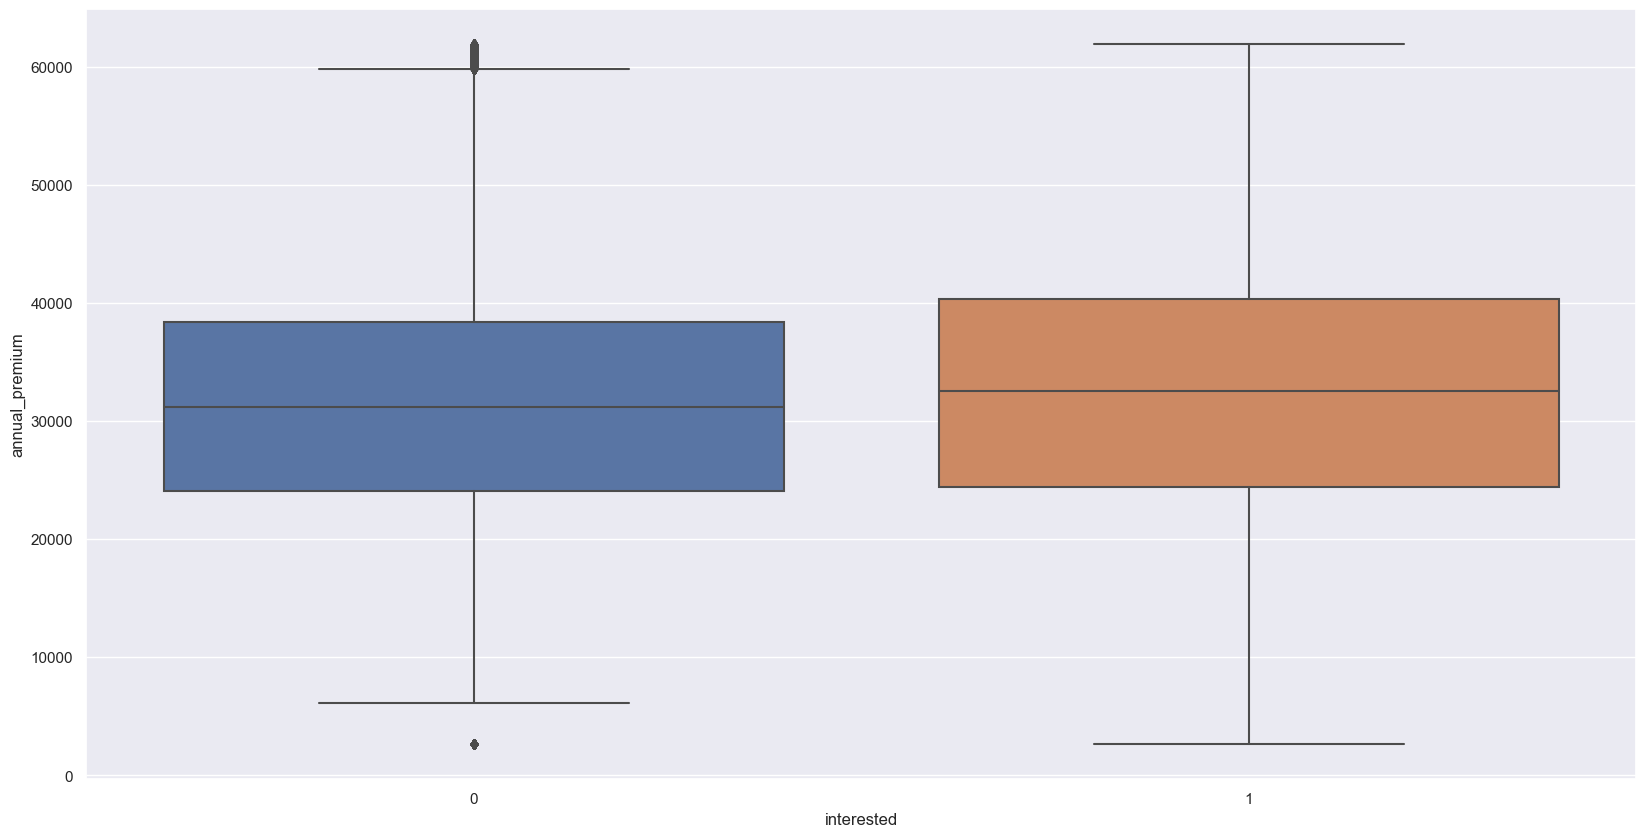

In [93]:
aux2 = df1.loc[ df1['annual_premium'] < 61892.5 , ['annual_premium','interested'] ] 

sns.boxplot(x = 'interested', y = 'annual_premium', data = aux2 )

**Análises:**

*age:*

- Analisando a idade sobre o interesse na compra é notável que quem possui interesse possui uma idade no intervalo interquartílico mais elevada dos que indicaram que não possuem interesse. 

*days_client_associate:*

- Levando-se em consideração o interesse, muito similar a distribuição por dias em que a pessoa é cliente da empresa;

*annual_premium:*

- Levando-se em consideração a variável interesse, não há muita diferença na distribuição entre o atributo annual_premium. Ou seja, feature com dificuldade de discriminação entre classes.

### 1.7.2. Categorical Attributes

In [22]:
# Quantidade Valores únicos de cada uma das categorias 

print(f"Quantidade de valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.nunique() ) } \n")
print(f"Valores únicos em cada atributo: \n { cat_attributes.apply( lambda x: x.unique() ) } \n")

Quantidade de valores únicos em cada atributo: 
 gender               2
region_code         53
sales_channel      155
driving_license      2
vehicle_age          3
vehicle_damage       2
vehicle_insured      2
interested           2
dtype: int64 

Valores únicos em cada atributo: 
 gender                                                [Male, Female]
region_code        [28, 3, 11, 41, 33, 6, 35, 50, 15, 45, 8, 36, ...
sales_channel      [26, 152, 160, 124, 14, 13, 30, 156, 163, 157,...
driving_license                                               [1, 0]
vehicle_age                          [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                             [Yes, No]
vehicle_insured                                               [0, 1]
interested                                                    [1, 0]
dtype: object 



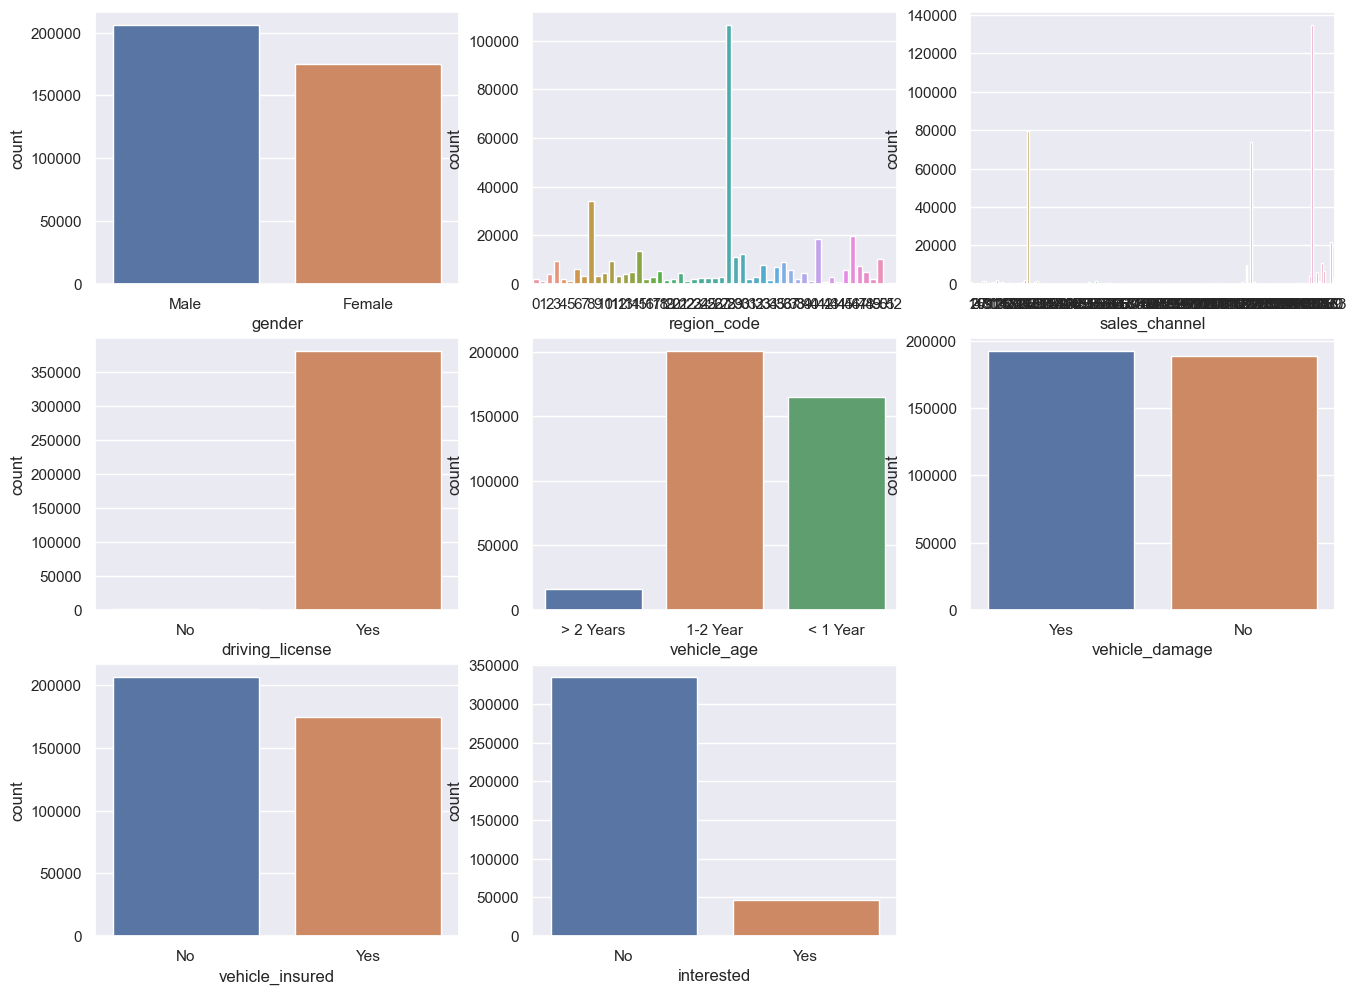

In [28]:
# Plot

plt.figure(figsize=(16,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender']);


plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['region_code']);


plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['sales_channel']);


plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);


plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);


plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);


plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['vehicle_insured']);
plt.xticks([0,1],['No','Yes']);


plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['interested']);
plt.xticks([0,1],['No','Yes']);

DICA: **Plotar / aqui separadamente o region_code e o sales_channel** - Review Projeto

DICA: **Outra ideia aqui para melhor visualizar os dados seria separar o region_code e o sales_channel em faixas de quantidades para cada categoria e plotar separadamente** - Review Projeto

DICA: **Criar uma sessão separadamente para os dados target e colocar as porcentagens** - Review Projeto

In [96]:
# gender

df1[['gender','id']].groupby('gender').count()

id
gender        
Female  175020
Male    206089

In [97]:
# driving_license

df1[['driving_license','id']].groupby('driving_license').count()

id
driving_license        
0                   812
1                380297

In [98]:
# vehicle_age

df1[['vehicle_age','id']].groupby('vehicle_age').count()

id
vehicle_age        
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007

In [99]:
# vehicle_damage

df1[['vehicle_damage','id']].groupby('vehicle_damage').count()



id
vehicle_damage        
No              188696
Yes             192413

In [100]:
# vehicle_insured

df1[['vehicle_insured','id']].groupby('vehicle_insured').count()

id
vehicle_insured        
0                206481
1                174628

In [101]:
## Variável Resposta 

# interested

df1[['interested','id']].groupby('interested').count()

id
interested        
0           334399
1            46710

**Análises:**


*gender:*
    
- Possuem mais homens do que mulheres na base de clientes, mas existe um equilíbrio(balanceamento) entre os valores.
    

*driving_license:*
    
- Alto desbalanceamento, muito mais pessoas que possuem permissão para dirigir do que as que não possuem.

    
*vehicle_age:*

- A base de clientes possui veículos em sua grande maioria com idade menor que 2 anos.


*vehicle_damage:*

- Possuem mais clientes que já danificaram o veículo do que os que não, mas existe um equilíbrio(balanceamento) entre os valores.

*vehicle_insured:*

- Possuem mais clientes que não possuem seguro em seus automóveis, mas existe um equilíbrio(balanceamento) entre os valores.

*interested:*

- Alto desbalanceamento, muito mais clientes não interessados do que clientes interessados em serviço de seguro veicular.


DICA: **Melhorar essa análise aqui colocando os dados mais concretos que você vê na imagem e as porcentagens.** - Review Projeto

## 1.8. Split in train and test

In [12]:
X = df1.drop('interested', axis = 1).copy()
Y = df1['interested'].copy() # var. resposta

# Separação dos dados(treino e teste) mantendo a proporção de classes do conjunto de dados original.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state= 42,
                                                    stratify=Y)

In [55]:
X_train.head()

id  gender  age  region_code  sales_channel  driving_license vehicle_age vehicle_damage  vehicle_insured  annual_premium  days_client_associate
274710  274711    Male   22           40            152                1    < 1 Year            Yes                0        25455.00                    203
216539  216540  Female   26            8             26                1    < 1 Year             No                1        38393.00                     45
78983    78984  Female   32           28            122                1    < 1 Year            Yes                0        32118.00                     35
218368  218369    Male   32           37            152                1    < 1 Year            Yes                0        37711.00                    215
307215  307216  Female   24           28            156                1    < 1 Year            Yes                0        48706.00                    222

In [13]:
## Porcentagem de valores da variável target em cada separação de dados

print(f"Treino: \n {Y_train.value_counts(normalize = True)} \n")
print(f"Total: {Y_train.count()} \n")
print(f"Teste: \n {Y_test.value_counts(normalize = True)} \n")
print(f"Total: {Y_test.count()}")

Treino: 
 0   0.88
1   0.12
Name: interested, dtype: float64 

Total: 304887 

Teste: 
 0   0.88
1   0.12
Name: interested, dtype: float64 

Total: 76222


 Dados de Treino:
 
 - 304887 -> 80%  
 
 Dados de Teste:
 
 - 76222 -> 20% 

In [69]:
## Conjunto de dados de treino o qual treinará o modelo e uma parte será destinada a avaliar a capacidade de aprendizado do modelo com dados de
## validação

df_train = pd.concat([X_train,Y_train], axis = 1).reset_index(drop = True)

## Conjunto de dados de teste o qual irá simular o comportamento (desempenho) do modelo em produção, ou seja, irá avaliar a capacidade de 
# generalização do modelo

df_test = pd.concat([X_test,Y_test], axis = 1).reset_index(drop = True)

In [74]:
# Export/save dataframes into .csv

#df_train.to_csv('data/train.csv', index = False)
#df_test.to_csv('data/test.csv', index = False)

# 2.0. FEATURE ENGINEERING

In [13]:
## Import train data 

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [6]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df2 = train.copy()
df_test = test.copy()

## 2.1. Mapa Mental de Hipóteses

Objetivo dele é gerar uma lista de hipóteses.         

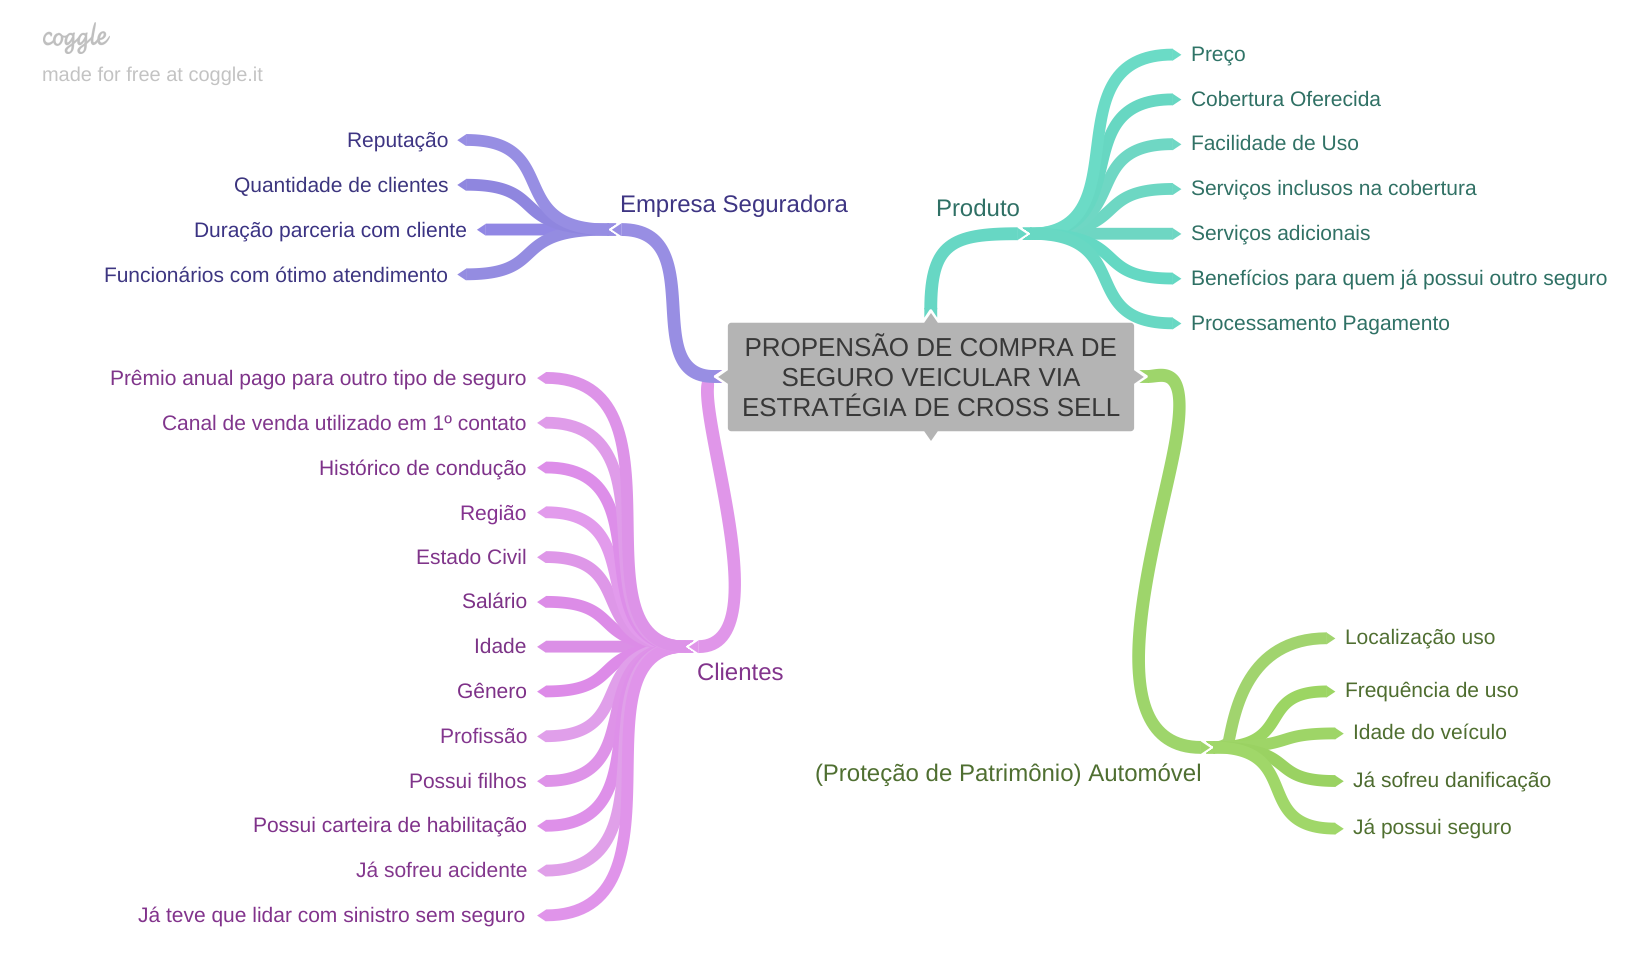

In [2]:
Image('../img/mapa_mental.png')

## 2.2. Criação de Hipóteses

Relacionar os atributos de cada agente do mapa mental com o fenômeno de interesse para criar as hipóteses.

### 2.2.1. Hipóteses Clientes

**1.** Clientes com filhos deveriam ter maior interesse de compra de seguro veicular.

**2.** Clientes com mais idade deveriam ter maior interesse na compra de seguro veicular.

**3.** Cliente com maiores salários deveriam ter maior interesse na compra de seguro veicular.

**4.** Clientes do gênero Masculino deveriam ter maior interesse na compra de seguro veicular.

**5.** Clientes da região 30 a 40 deveriam ter maior interesse na compra de seguro veicular.

**6.** Clientes com carteira de habilitação deveriam ter maior interesse na compra de seguro veicular.

**7.** Clientes com canal de vendas utilizado sendo de 130 a 140 deveriam ter maior interesse na compra de seguro veicular.

**8.** Clientes com histórico de condução péssimo deveriam ter maior interesse na compra de seguro veicular.

**9.** Clientes que já sofreram acidentes deveriam ter maior interesse na compra de seguro veicular.

**10.** Clientes com estado civil casado e divorciado deveriam ter maior interesse na compra de seguro veicular.

**11.** Clientes com profissão de Engenheiro deveriam ter maior interesse na compra de seguro veicular.

**12.** Clientes que pagam prêmio por seguro de saúde entre 2.630,00 e 20.000 reais deveriam ter maior interesse na compra de seguro veicular.

**13.** Clientes que já sofreram com sinistros em seu veículo sem ter seguro deveriam ter maior interesse na compra de seguro veicular.

### 2.2.2. Hipóteses Automóvel

**1.** Clientes que possuem veículo para uso em grandes centros e vias engarrafadas deveriam ter maior interesse na compra de seguro veicular.

**2.** Clientes que utilizam mais frequentemente seu veículo deveriam ter maior interesse na compra de seguro veicular.

**3.** Clientes com automóvel mais novo deveriam ter maior interesse na compra de seguro veicular.

**4.** Clientes com automóvel já danificado deveriam ter menor interesse na compra de seguro veicular.

**5.** Clientes com automóvel que já possui seguro deveriam ter menor interesse na compra de seguro veicular.

### 2.2.3. Hipóteses Empresa Seguradora

**1.** Clientes que veêm a empresa com boa reputação deveriam ter maior interesse na compra de seguro veicular.


**2.** Clientes que notam que a empresa atende uma grande quantidade de cliente deveriam ter maior interesse na compra de seguro veicular.


**3.** Clientes que estão a mais tempo com a empresa recebendo seguro de saúde deveriam ter maior interesse na compra de seguro veicular.


**4.** Clientes que consideram que a empresa possui funcionários com ótimo atendimento deveriam ter maior interesse na compra de seguro veicular.


## 2.3. Lista Final de Hipóteses

Priorizar as hipóteses a serem validadas nesse primeiro ciclo que contenham informações já coletadas.

**1.** Clientes com mais idade deveriam ter maior interesse na compra de seguro veicular.


**2.** Clientes do gênero Masculino deveriam ter maior interesse na compra de seguro veicular.


**3.** Clientes da região 30 a 40 deveriam ter maior interesse na compra de seguro veicular.


**4.** Clientes com carteira de habilitação deveriam ter maior interesse na compra de seguro veicular.


**5.** Clientes com canal de vendas utilizado sendo de 130 a 140 deveriam ter maior interesse na compra de seguro veicular.


**6.** Clientes que pagam prêmio por seguro de saúde entre 2.630,00 e 20.000,00 reais deveriam ter maior interesse na compra de seguro veicular.


**7.** Clientes com automóvel mais novo deveriam ter maior interesse na compra de seguro veicular.


**8.** Clientes com automóvel já danificado deveriam ter menor interesse na compra de seguro veicular.


**9.** Clientes com automóvel que já possui seguro deveriam ter menor interesse na compra de seguro veicular.


**10.** Clientes que estão a mais tempo com a empresa recebendo seguro de saúde deveriam ter maior interesse na compra de seguro veicular.


## 2.4. Feature Engineering

Criação de features ou ajuste de valores features já existentes.

**Questionamento:** Quais variáveis/atributos/carac. preciso ajustar ou criar para validar as hipóteses de negócio levantadas?

In [14]:
### Das variáveis -> 


# gender   [Male, Female] -> [ Masculino, Feminino ]

# treino
df2.replace( {'gender': {'Male':'Masculino', 'Female': 'Feminino'}}, inplace = True )
# teste
df_test.replace( {'gender': {'Male':'Masculino', 'Female': 'Feminino'}}, inplace = True )

# driving_license                                               [1, 0]

# treino
df2['driving_license'] = df2['driving_license'].apply(lambda x: 'Possui carteira' if x == 1 else 'Sem carteira')
# teste
df_test['driving_license'] = df_test['driving_license'].apply(lambda x: 'Possui carteira' if x == 1 else 'Sem carteira')

# vehicle_age                          [> 2 Years, 1-2 Year, < 1 Year]

# treino
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'Menos de 1 ano' if x == '< 1 Year' else 'Entre 1 e 2 anos' if x == '1-2 Year' else 
                                            'Mais de 2 anos') 
# teste
df_test['vehicle_age'] = df_test['vehicle_age'].apply(lambda x: 'Menos de 1 ano' if x == '< 1 Year' else 'Entre 1 e 2 anos' if x == '1-2 Year' else 
                                            'Mais de 2 anos')

# vehicle_damage                                             [Yes, No]

# treino
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 'Foi danificado' if x == 'Yes' else 'Não foi danificado') 
# teste
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply(lambda x: 'Foi danificado' if x == 'Yes' else 'Não foi danificado')

# vehicle_insured                                               [0, 1]

# treino
df2['vehicle_insured'] = df2['vehicle_insured'].apply(lambda x: 'Já possui seguro' if x == 1 else 'Não possui seguro') 
# teste
df_test['vehicle_insured'] = df_test['vehicle_insured'].apply(lambda x: 'Já possui seguro' if x == 1 else 'Não possui seguro') 

# interested  

# treino
df2.replace( {'interested': {1:'Interessado',0:'Não interessado'} }, inplace = True )  
# teste
df_test.replace( {'interested': {1:'Interessado',0:'Não interessado'} }, inplace = True ) 



### Das variáveis -> SEPARAR EM VARIÁVEIS CATEGÓRICAS QUANTITATIVAS 


# age -> [20-30 | 31-50 | 51 - 80]

# treino
df2['age_level'] = df2['age'].apply(lambda x: '20-30' if (x >= 20) & (x <= 30) else '31-40' if (x > 30) & (x <= 40) else '41-50'
                                                      if (x > 40) & (x <= 50) else '51-85')
# teste
df_test['age_level'] = df_test['age'].apply(lambda x: '20-30' if (x >= 20) & (x <= 30) else '31-40' if (x > 30) & (x <= 40) else '41-50'
                                                      if (x > 40) & (x <= 50) else '51-85')


# days_client_associate -> [ 10-100 | 101-200 | 201-299 ]

# treino
df2['days_client_associate_level'] = df2['days_client_associate'].apply(lambda x: '10-100' if (x >= 10) & (x <= 100) else '101-200' if (x > 100) & (x <= 200) else '201-299' )
# teste
df_test['days_client_associate_level'] = df_test['days_client_associate'].apply(lambda x: '10-100' if (x >= 10) & (x <= 100) else '101-200' if (x > 100) & (x <= 200) else '201-299' )


# annual_premium -> Range grande que vai de 2.630,00 a 540.165,00

# treino
df2["annual_premium_level"] = df2["annual_premium"].apply(lambda x: '0-20000' if (x >= 0) & (x <= 20000) else '20001-25000' 
                                                                              if (x > 20000) & (x <= 25000) else '25001-30000' 
                                                                              if (x > 25000) & (x <= 30000) else '30001-35000'
                                                                              if (x > 30000) & (x <= 35000) else '35001-40000'
                                                                              if (x > 35000) & (x <= 40000) else '40001-60000'
                                                                              if (x > 40000) & (x <= 60000) else '60001-540165')

# teste
df_test["annual_premium_level"] = df_test["annual_premium"].apply(lambda x: '0-20000' if (x >= 0) & (x <= 20000) else '20001-25000' 
                                                                              if (x > 20000) & (x <= 25000) else '25001-30000' 
                                                                              if (x > 25000) & (x <= 30000) else '30001-35000'
                                                                              if (x > 30000) & (x <= 35000) else '35001-40000'
                                                                              if (x > 35000) & (x <= 40000) else '40001-60000'
                                                                              if (x > 40000) & (x <= 60000) else '60001-540165')

**Sugestão de implementação futura:** 

- Criar a feature tempo de cliente na empresa, colocar em meses.
- Criar novas features através da criatividade de juntar e dividir uma pela outra.- Review Projeto

**OBS:** Sobre os atributos sales_channel e region_code:  

Como não sei se os valores dos códigos que representam o contato de vendas feito com o cliente, bem como, a região de cada cliente segue uma ordem de valores semelhantes que façam sentido em termos de negócio junta-los, não irei juntar os códigos. 

**Aprendizado:** Deveria aqui ter não ter deixado espaço nos valores que troquei o nome. Deve-se evitar deixar espaço em valores. Além disso, não era necessário traduzir para português as features somente para facilitar para a EDA, creio que ficou somente ainda mais trabalho para organizar na preparação dos dados. 

# 3.0. FILTRAGEM DE VARIÁVEIS

O objetivo é restringir variáveis/features/atributos considerando cenário real e de interesse da análise do fenômeno de negócio.

In [15]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df3 = df2.copy()

- **PENSAR EM FILTRAR:** 

- *driving_license:* levantei a hipótese de que não poderia se contratar seguro sem possuir CNH.
- *vehicle_insured:* levantei a hipótese de que se a pessoa já possui seguro para o seu carro, dificilmente iria trocar.

Porém, tomei a decisão de não filtrar nenhuma, pois:

- *driving_license:* Por meio de pesquisas em canais especializados, certifiquei que pode contratar seguro quem não possui CNH, pois existe 
posteriormente a indicação de condutor principal. (Ex: Mãe não quer dirigir mas compra carro e filho possui CNH.)
    
**Fonte:** https://ambitojuridico.com.br/direito-de-transito/posso-contratar-um-seguro-auto-sem-ter-cnh/   
    
- *vehicle_insured:* mesmo que o carro de um cliente já possua seguro, pode haver a insatisfação com a empresa atual e o interesse em trocar.

**Conclusão:** entendo que todas as variáveis que possuo estarão disponíveis no momento de interesse (predizer) da análise do fenômeno (produção) e de acordo com a demanda solicitada não se faz necessário restringir limites de interesse (através dos atributos) para análise do fenômeno.

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [16]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df4 = df3.copy()


In [10]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_insured',
       'annual_premium', 'days_client_associate', 'interested', 'age_level',
       'days_client_associate_level', 'annual_premium_level'],
      dtype='object')

## 4.1. Análise Univariada

Objetivo é analisar como está distribuída cada variável/atributo

In [178]:
## Separar atributos/colunas em numéricas e categóricas

num_attributes_eda = df4[['age', 'annual_premium', 'days_client_associate']]
cat_attributes_eda = df4[['gender', 'region_code', 'sales_channel','driving_license', 'vehicle_age','vehicle_damage', 'vehicle_insured', 'age_level', 'days_client_associate_level', 'annual_premium_level']]

### 4.1.1. Response Variable

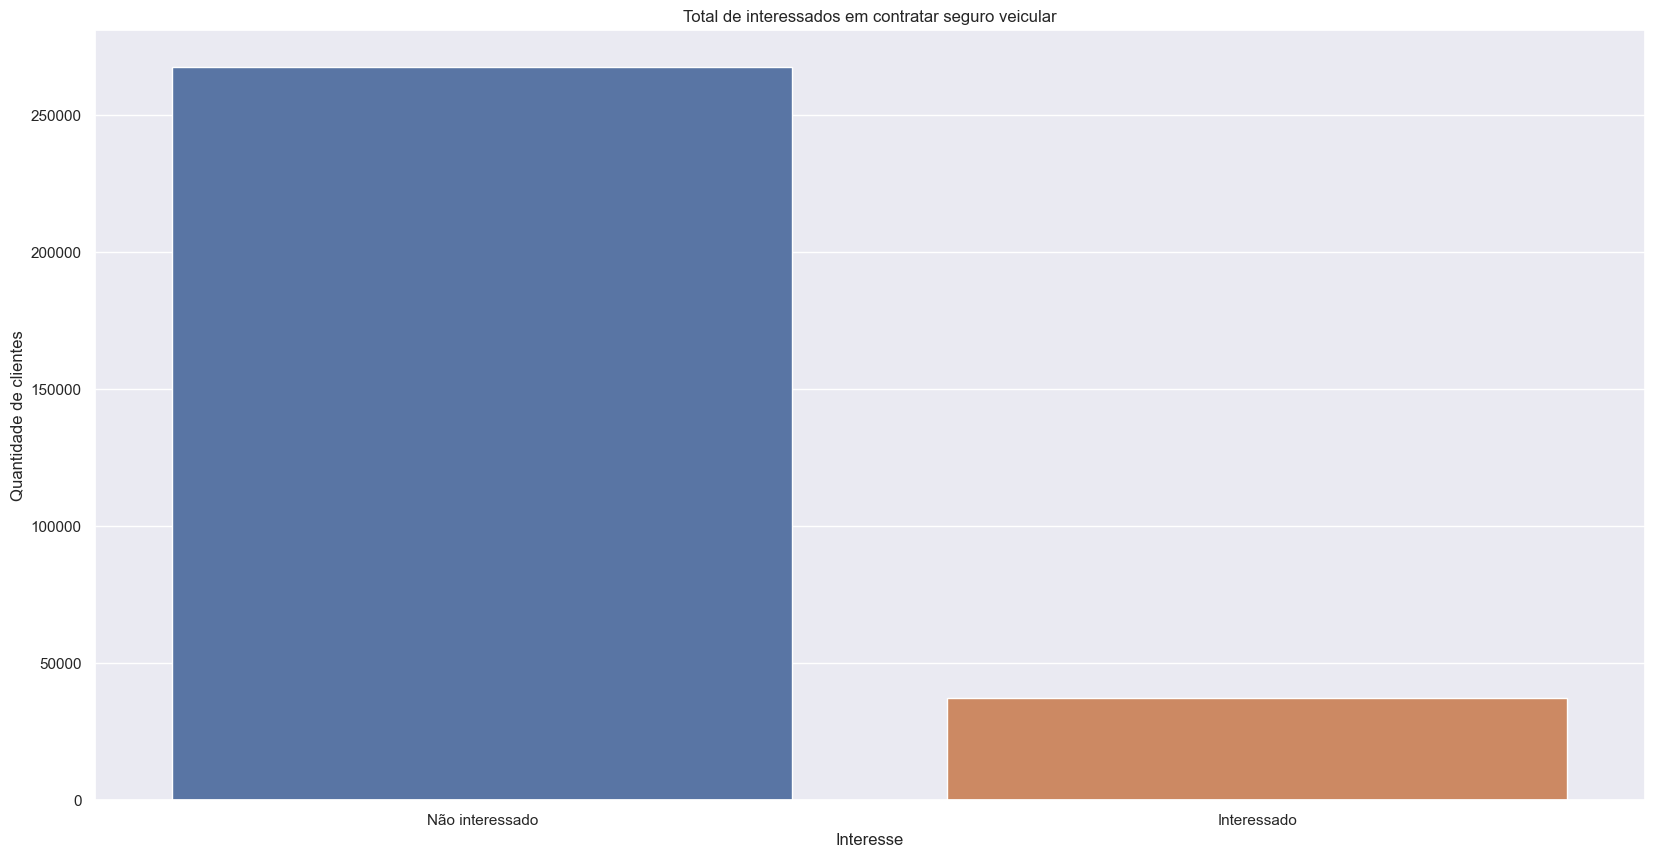

In [75]:
resp = sns.countplot(x = df4['interested'])
resp.set_ylabel('Quantidade de clientes')
resp.set_xlabel('Interesse')
resp.set_title("Total de interessados em contratar seguro veicular");

**OBS:** Alto desbalanceamento nos dados da variável resposta para classificação binária

In [72]:
df4['interested'].value_counts(normalize = True)

Não interessado   0.88
Interessado       0.12
Name: interested, dtype: float64

### 4.1.2. Numerical Variable

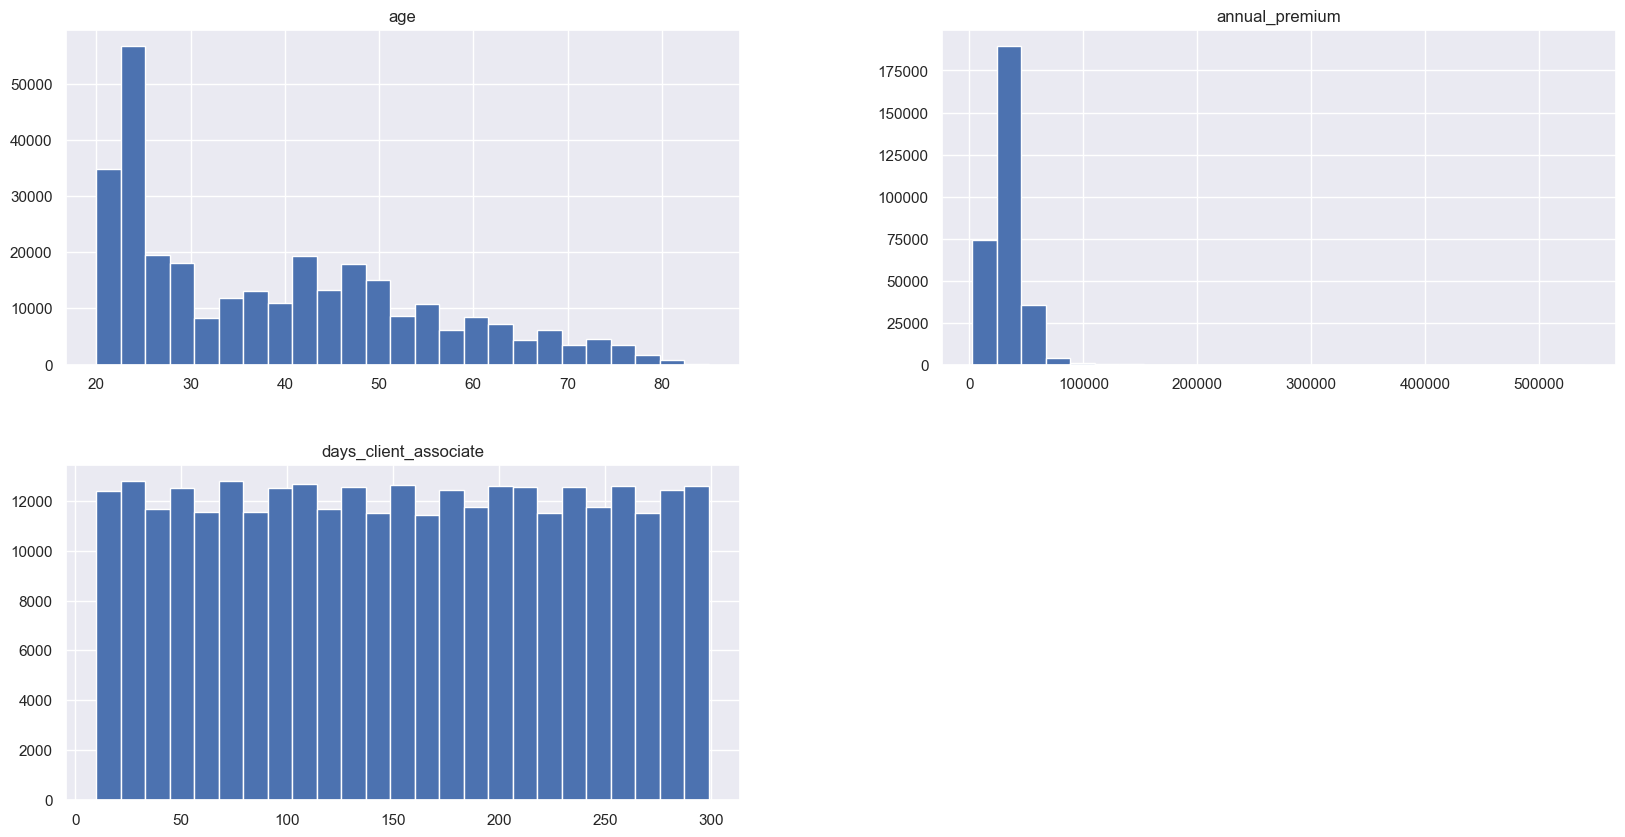

In [77]:
num_attributes_eda.hist( bins = 25 );

DICA: Resumir melhor aqui

**Análises:**

*age:*
 
- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais pessoas de 20 a 50 anos na base de seguro de saúde o que pode ser bastante surpreendente;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos dados entre as idades.

*days_client_associate:*

- Skew muito próxima de zero indica distribuição próxima da normal, ou seja, indica que a distribuição dos dados é simétrica;
- Kurtosis negativa indica que a distribuição não possui uma alta concentração de valores em um determinado ponto, o que significa que está bem espalhado a distribuição dos valores entre os clientes.

*annual_premium:*

- Skew positiva indica que a distribuição dos valores está mais para a esquerda em relação a normal, ou seja, mais clientes pagam prêmio entre 2.630,00 a 100.000,00 reais;
- Kurtosis bastante positiva indica que há deformação vertical devido a concentração dos dados sob um ponto.

#### 4.1.2.1. age

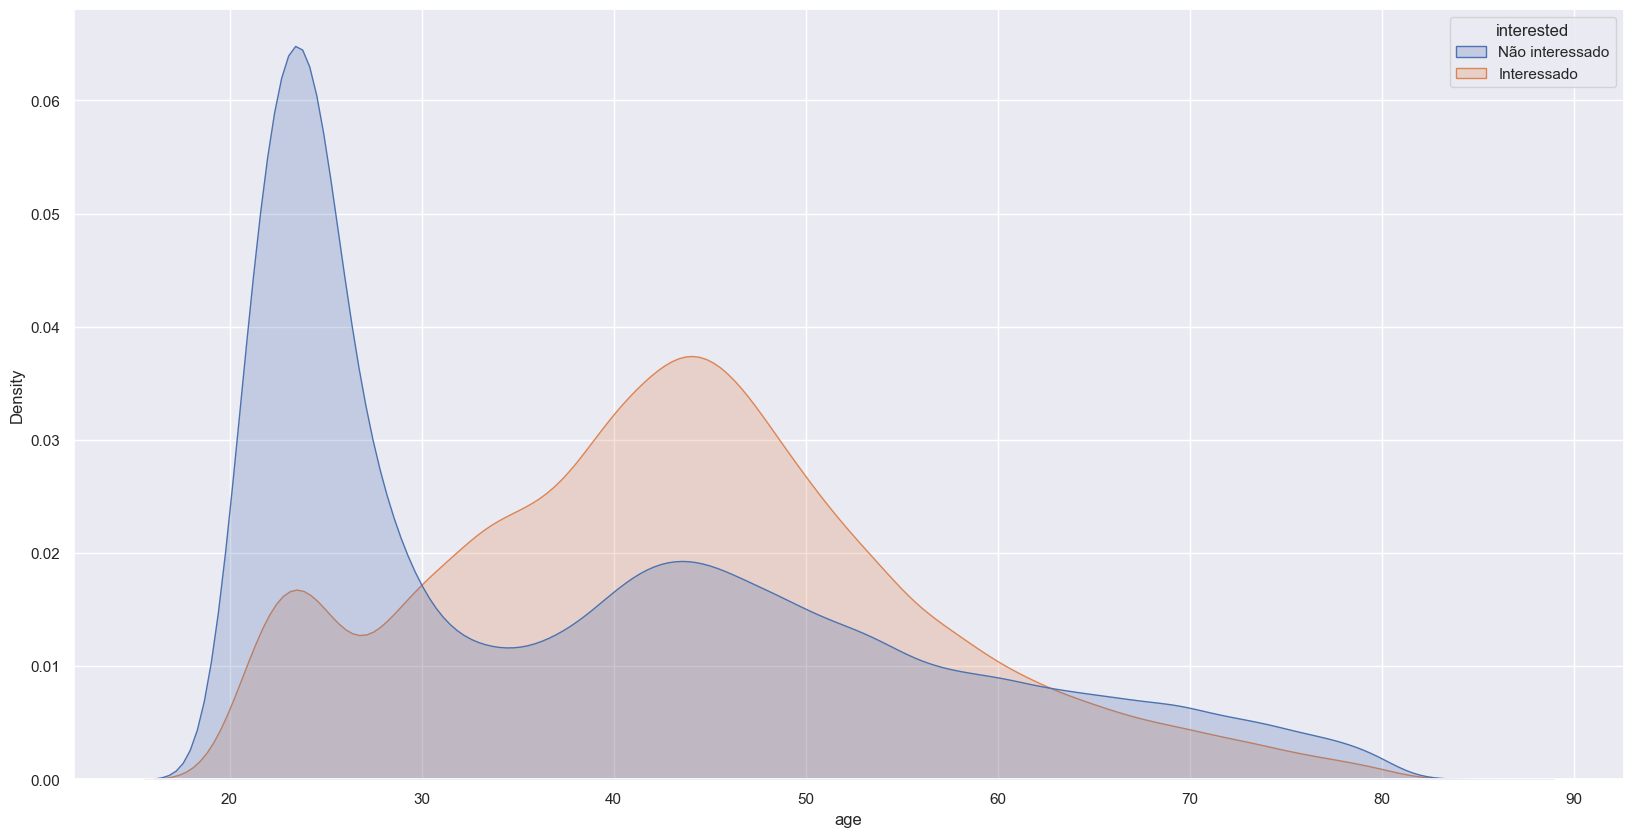

In [103]:
sns.kdeplot(data=df4 , x='age', hue='interested', fill=True, common_norm=False );

**Análise:**

- Mesma análise já feita em gráfico box-plot em 1.7.1. Aqui nota-se mais que existem interessados e não interessados ao longo de todas as idades;
- Distribuição dos não interessados mais próxima de uma distribuição de Poisson;
- Distribuição dos interessados mais próxima de uma distribuição normal.


#### 4.1.2.2. annual_premium

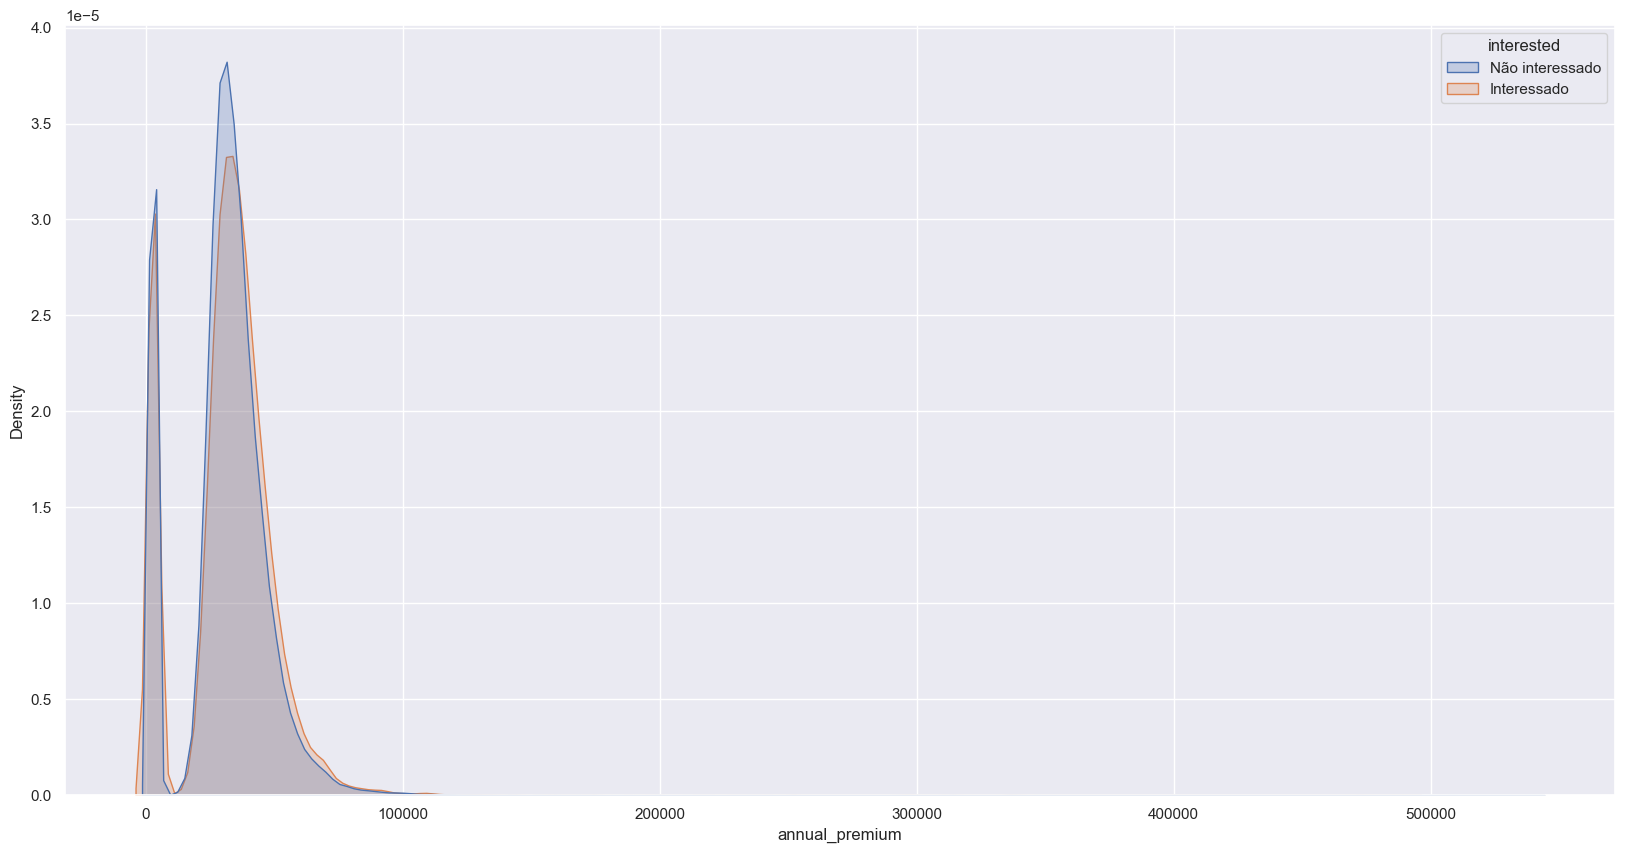

In [104]:
sns.kdeplot(data=df4 , x='annual_premium', hue='interested', fill=True, common_norm=False );

**Análise:**

- Mesma análise já feita em gráfico box-plot em 1.7.1. Não ajuda muito a discriminar entre classes.

#### 4.1.2.3. days_client_associate

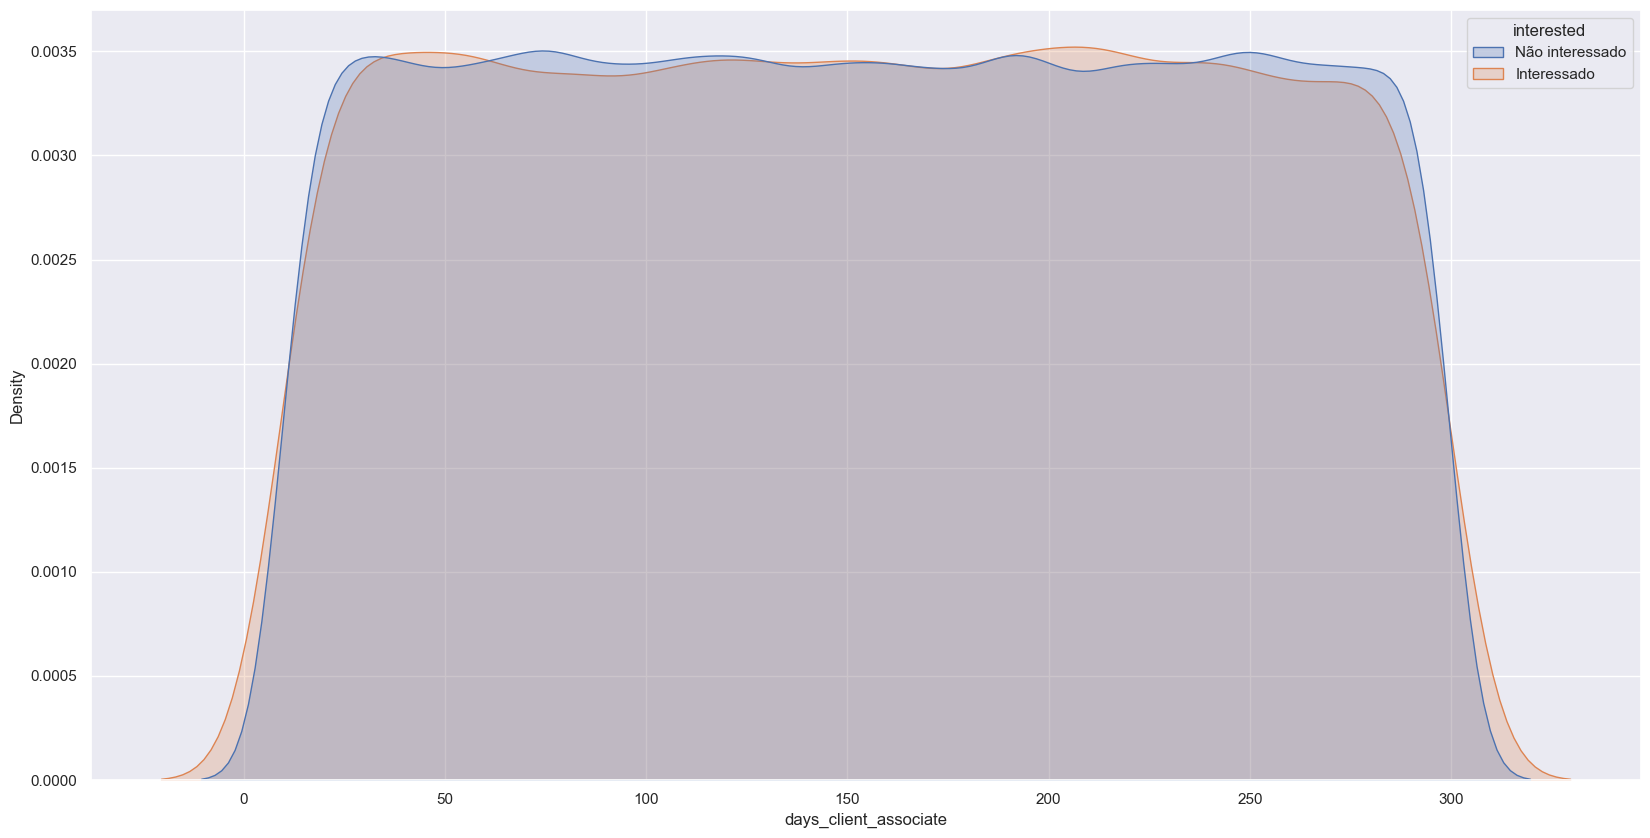

In [105]:
sns.kdeplot(data=df4 , x='days_client_associate', hue='interested', fill=True, common_norm=False );

**Análise:**

- Mesma análise já feita em gráfico box-plot em 1.7.1.

### 4.1.3. Categorical Variable

In [179]:
# Valores Únicos de cada uma das categorias 

print(f"Quantidade de valores únicos em cada atributo: \n \n { cat_attributes_eda.apply( lambda x: x.nunique() ) } \n")
print(f"Valores únicos em cada atributo: \n \n { cat_attributes_eda.apply( lambda x: x.unique() ) } " )

Quantidade de valores únicos em cada atributo: 
 
 gender                           2
region_code                     53
sales_channel                  154
driving_license                  2
vehicle_age                      3
vehicle_damage                   2
vehicle_insured                  2
age_level                        4
days_client_associate_level      3
annual_premium_level             7
dtype: int64 

Valores únicos em cada atributo: 
 
 gender                                                     [Masculino, Feminino]
region_code                    [40, 8, 28, 37, 1, 12, 13, 6, 50, 43, 25, 48, ...
sales_channel                  [152, 26, 122, 156, 13, 151, 160, 124, 8, 15, ...
driving_license                                  [Possui carteira, Sem carteira]
vehicle_age                    [Menos de 1 ano, Entre 1 e 2 anos, Mais de 2 a...
vehicle_damage                              [Foi danificado, Não foi danificado]
vehicle_insured                            [Não possui seguro

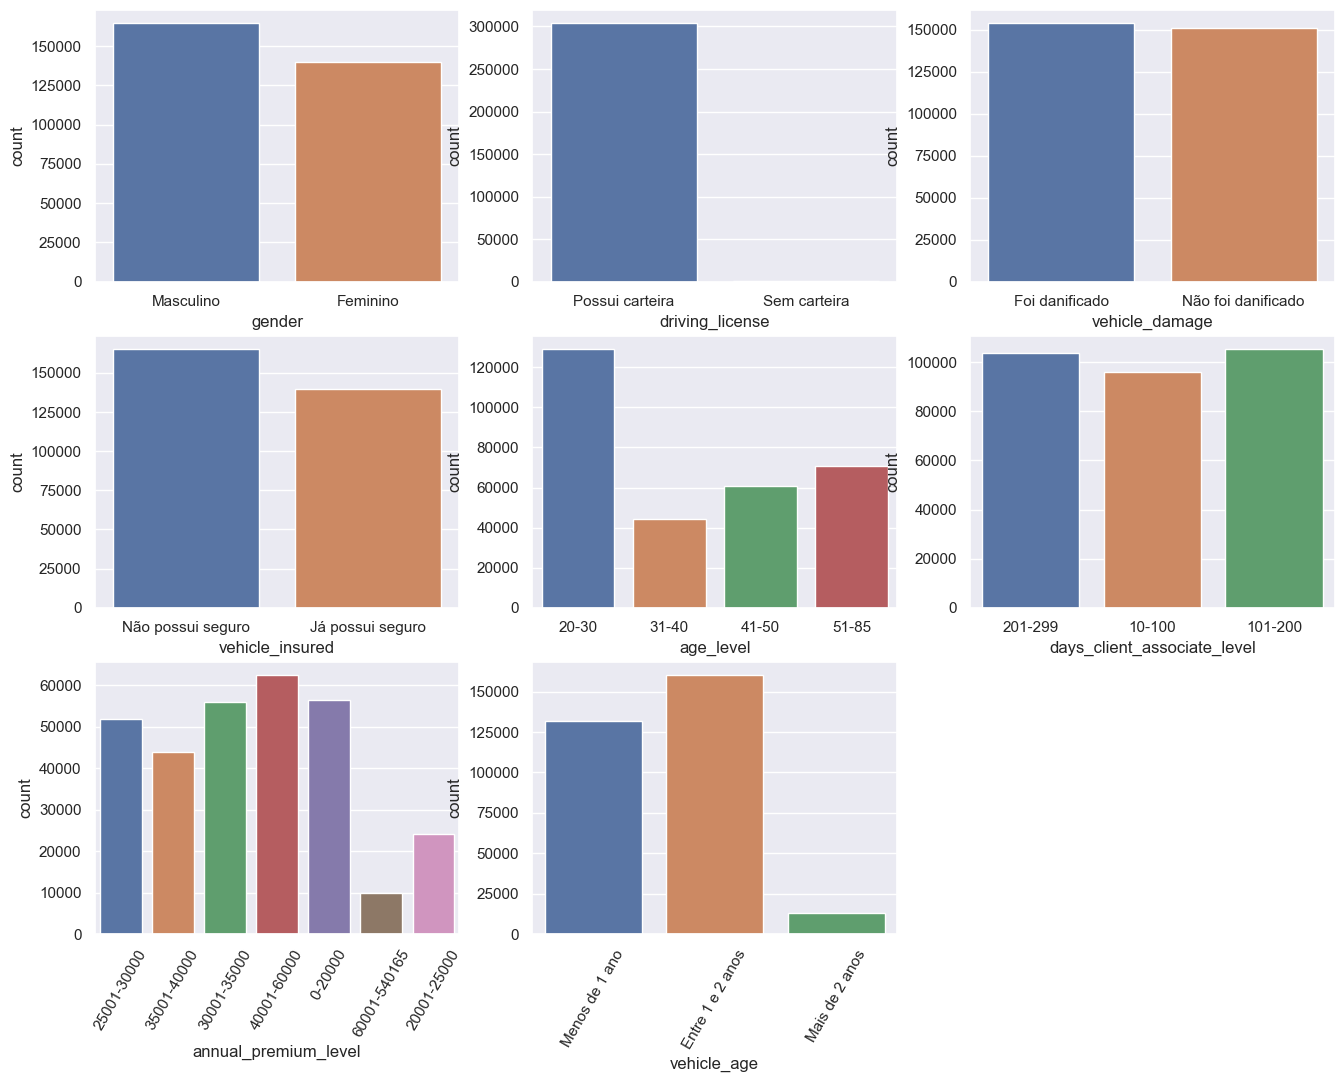

In [180]:
# Plot

plt.figure(figsize=(16,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes_eda['gender']);


plt.subplot (3,3,2)
sns.countplot (x = cat_attributes_eda['driving_license']);


plt.subplot (3,3,3)
sns.countplot (x = cat_attributes_eda['vehicle_damage']);


plt.subplot (3,3,4)
sns.countplot (x = cat_attributes_eda['vehicle_insured']);


plt.subplot (3,3,5)
sns.countplot (x = cat_attributes_eda['age_level']);


plt.subplot (3,3,6)
sns.countplot (x = cat_attributes_eda['days_client_associate_level']);


plt.subplot (3,3,7)
sns.countplot (x = cat_attributes_eda['annual_premium_level']);
plt.xticks(rotation = 60);


plt.subplot (3,3,8)
sns.countplot (x = cat_attributes_eda['vehicle_age']);
plt.xticks(rotation = 60);

**Análises:**


*gender:*
    
- Possuem mais homens do que mulheres na base de clientes, mas existe um equilíbrio(balanceamento) entre os valores.
    

*driving_license:*
    
- Alto desbalanceamento, muito mais pessoas que possuem permissão para dirigir do que as que não possuem.

    
*vehicle_age:*

- A base de clientes possui veículos em sua grande maioria com idade menor que 2 anos.


*vehicle_damage:*

- Possuem mais clientes que já danificaram o veículo do que os que não, mas existe um equilíbrio(balanceamento) entre os valores.

*vehicle_insured:*

- Possuem mais clientes que não possuem seguro em seus automóveis, mas existe um equilíbrio(balanceamento) entre os valores.

*age_level:*

- Mais clientes de 20 a 30 anos.

*days_client_associate_level:*

- 2/3 da base de pessoas são clientes a mais de 100 dias.

*annual_premium_level:*

- Alta concentração de clientes que paga prêmio anual do seguro de saúde entre mais de 25 mil até 60 mil.

In [ ]:
## Analisando separadamente o sales_channel e o region_code

#### 4.1.3.1. sales_channel

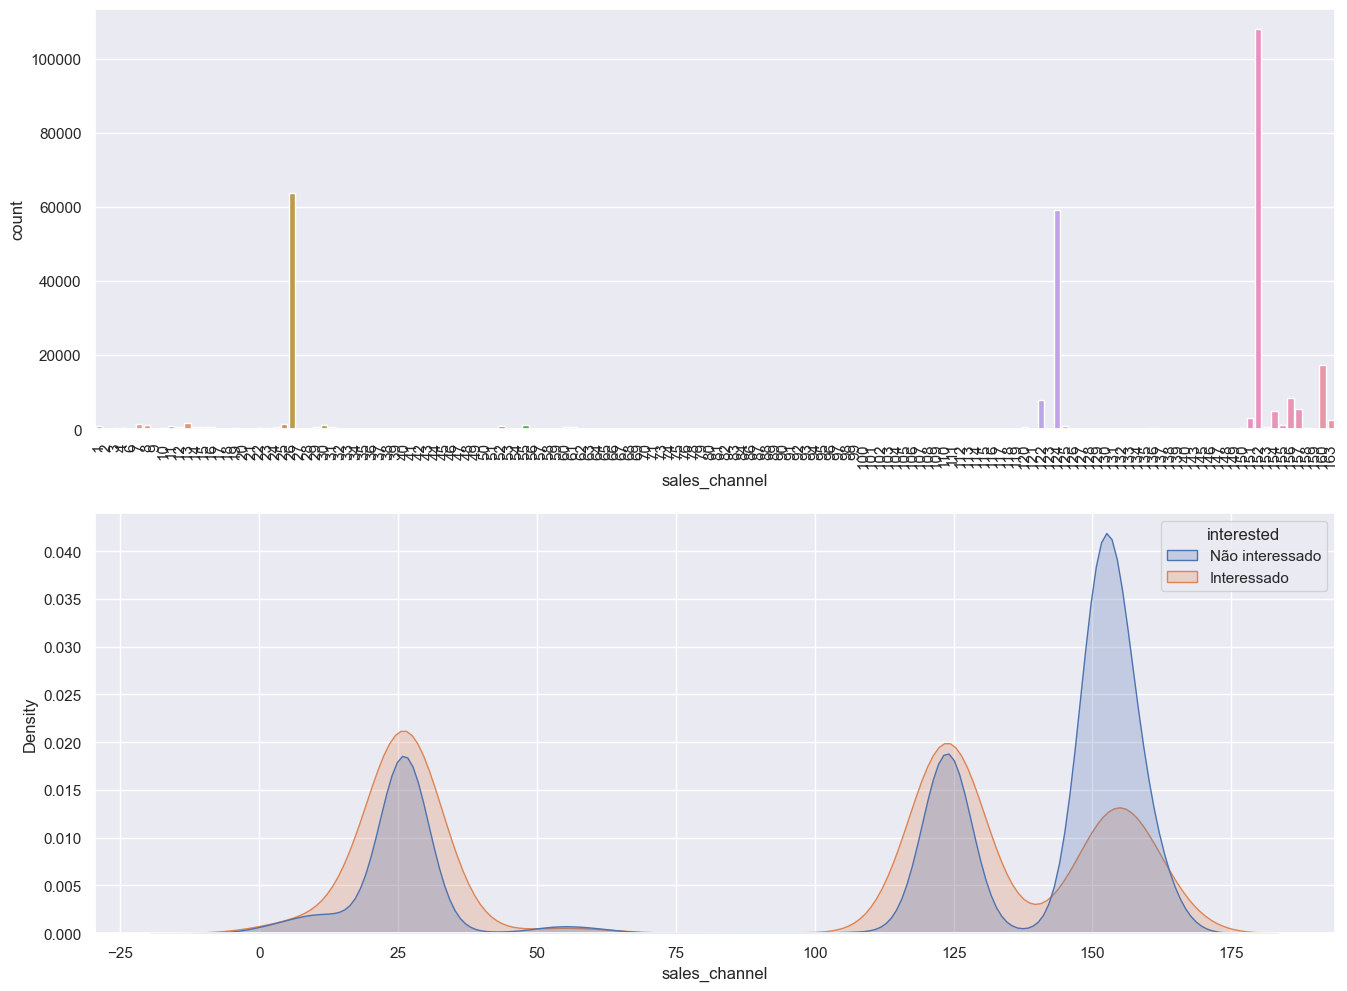

In [114]:
plt.figure(figsize=(16,12))

# Distribuição do canal de vendas
plt.subplot( 2, 1, 1 )
sns.countplot(x = df4['sales_channel']);
plt.xticks(rotation = 90);

# Análise da distribuição de interessados e não interessados por canal de vendas
plt.subplot( 2, 1, 2 )
sns.kdeplot(data= df4 , x='sales_channel', hue='interested', fill=True, common_norm=False );

**Análise:**

- Notavelmente existem 3 códigos de canal de vendas com o cliente que mais as pessoas utilizaram na venda: 26, 124 e 152. Aproximadamente mais de 220 mil clientes utilizaram apenas esses 3 canais de vendas para tratar com a empresa.

- A distribuição de interessados e não interessados por canal de vendas é muito sobreposta uma na outra.

#### 4.1.3.2. region_code

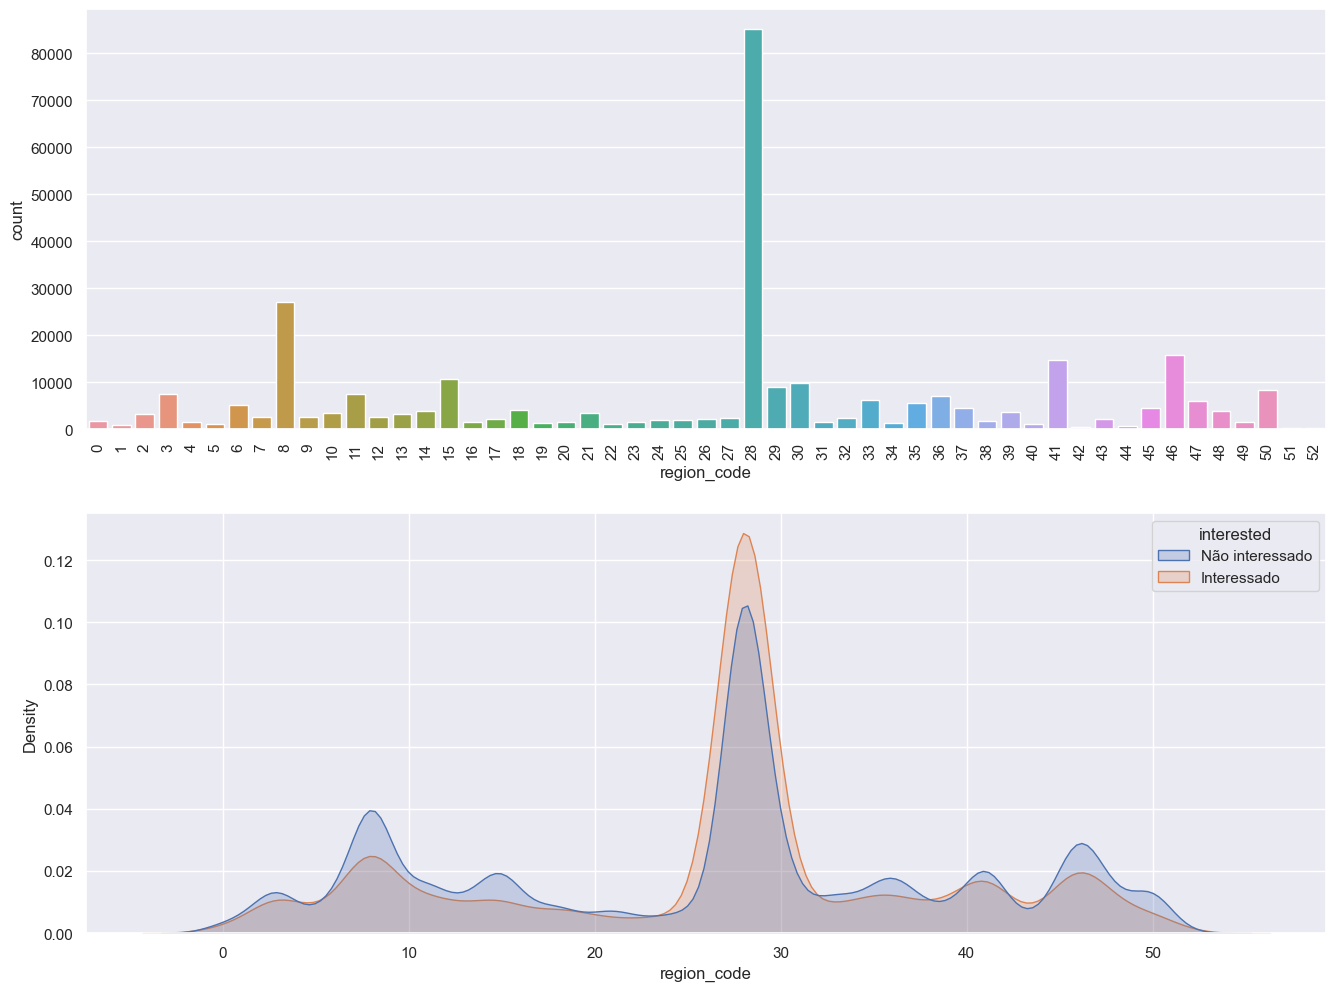

In [115]:
plt.figure(figsize=(16,12))

# Distribuição do código da região
plt.subplot( 2, 1, 1 )
sns.countplot(x = df4['region_code']);
plt.xticks(rotation = 90);

# Análise da distribuição de interessados e não interessados por código da região
plt.subplot( 2, 1, 2 )
sns.kdeplot(data= df4 , x='region_code', hue='interested', fill=True, common_norm=False );

**Análise:**

- O código de região que mais possue clientes é o 28 com mais de 80.000 clientes sendo dessa região. Depois vem a região 8 com quase aproximadamente 30.000 clientes da base. Por fim, existem 3 códigos de região com mais de 10.000 clientes que são: 15, 41, 46.

- Apesar da distribuição de interessados e não interessados por código da região ser muito sobreposta uma na outra, a região 28 concentra mais interessados do que não interessados na compra de seguro veicular.

**Aprendizados:** Como estamos trabalhando com dados limitados fornecidos para projeto de portfólio sem explicação dos códigos das regiões nos limita poder agrupa-los e retirar insights disso. Até mesmo, por esse desconhecimento do significado dos códigos limita poder trazer mais dados (lat, long da região, IDH, renda per capita) que poderiam ser interessantes para analisar o fenômeno de interesse.

## 4.2. Análise Bivariada

Objetivo é a validação das hipóteses criadas e geração de insights e consequentemente, analisar como as variáveis/atributos impactam na variável resposta (fenômeno).

In [11]:
## Voltar para conseguir contar os valores de interessados e fazer média

df4.replace( {'interested': {'Interessado': 1,'Não interessado':0} }, inplace = True )  

### 4.2.1.  H1. Clientes com mais idade deveriam ter maior interesse, em média, na compra de seguro veicular. FALSO


**Conclusão:**

Gera Insight ? Sim, meia idade 31 a 50 possuem mais interesse. Descontitui crença.  


Pode ser relevante para o modelo? Sim

In [ ]:
# Estratégia:

## FEATURE 'age'
# 1. Analisar a quantidade de clientes por idade e o interesse na compra 
#        - gráfico de barras
#        - gráfico de linhas
# 2. Analisar a proporção de interessados por idade   
#        - gráfico de barras
#        - gráfico de linhas
#
# ## FEATURE 'age_level'
#
#  3. Analisar a quantidade de clientes de acordo com a faixa de idade segmentado pelo interesse na compra 
#        - gráfico de barras 
#  4. Analisar a proporção de interessados por faixa de idade 
#         - gráfico de barras
#
#  5. Análise de Correlação via V-Cramer

**Analisando quantidade de clientes por idade e por interesse:**

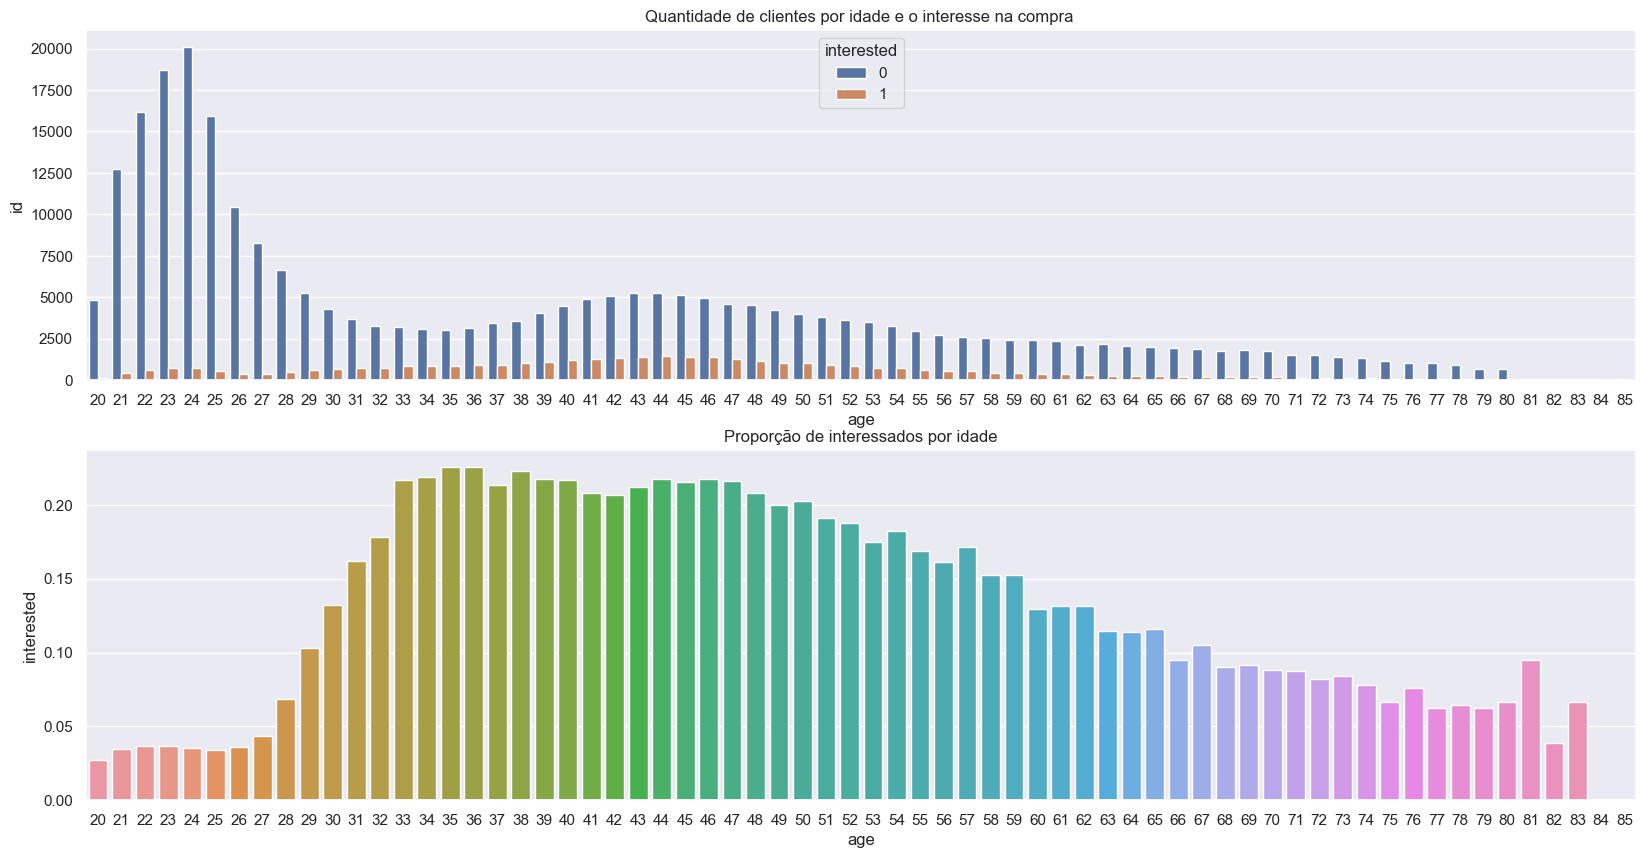

In [46]:
eda3 = df4[['age','id','interested']].groupby(['age','interested']).count().reset_index()
eda1 = df4[['age','interested']].groupby('age').mean().reset_index()

# Quantidade
plt.subplot(2,1,1)
g19 = sns.barplot(x = 'age', y = 'id' , data = eda3, hue = 'interested' );
g19.set_title("Quantidade de clientes por idade e o interesse na compra ");

# Proporção
plt.subplot(2,1,2)
g20 = sns.barplot(x = 'age' , y= 'interested' , data = eda1);
g20.set_title("Proporção de interessados por idade");

**Analisando idades agrupadas e os interesses:**

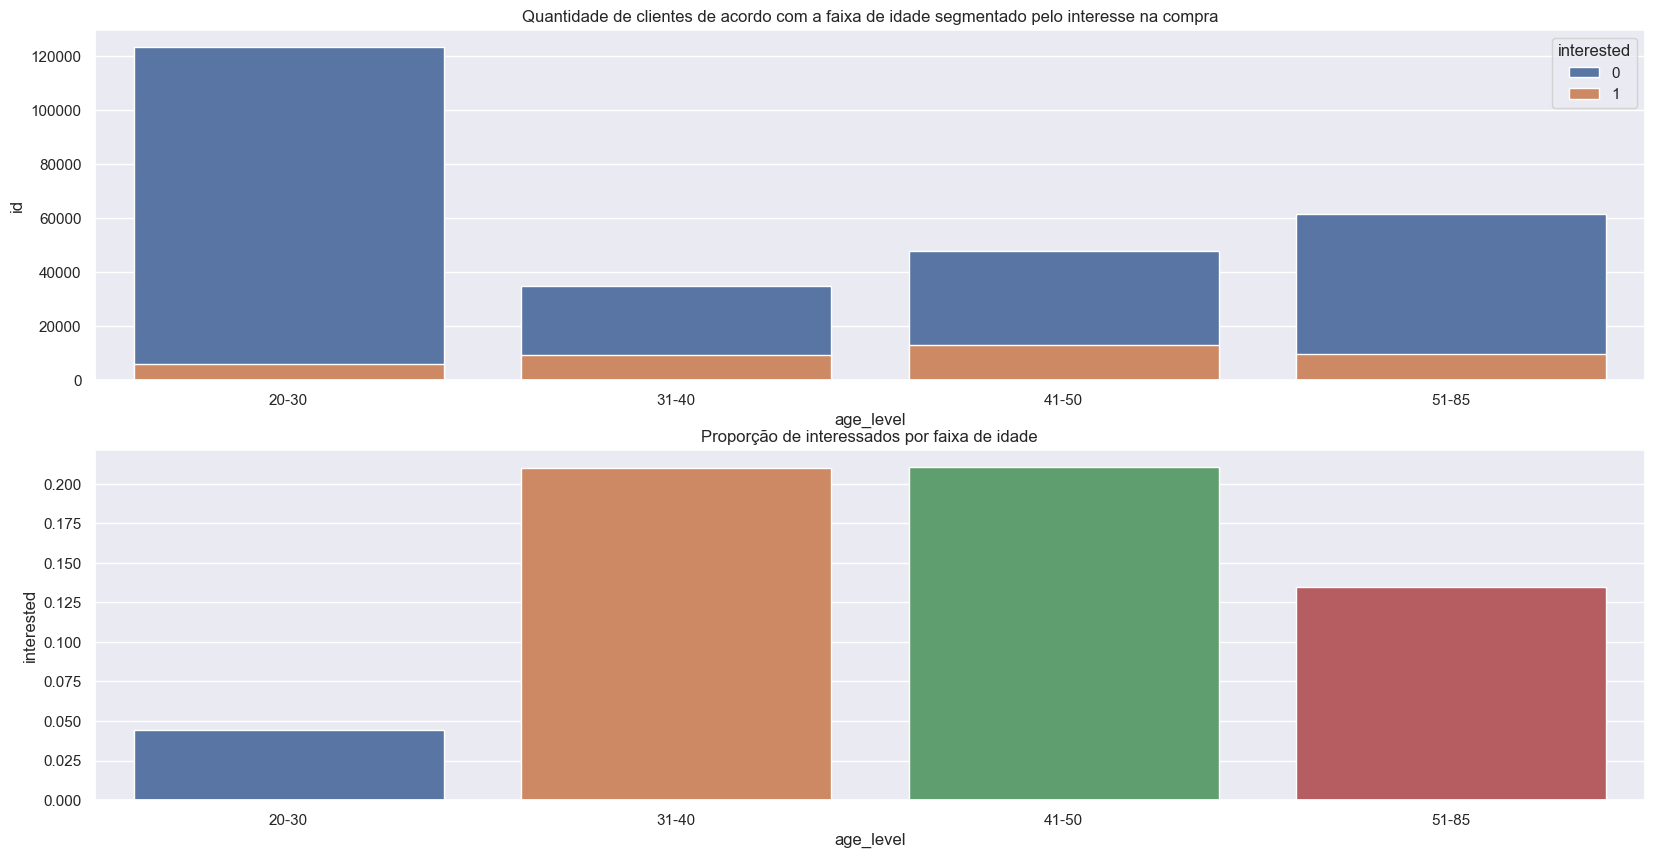

In [49]:
eda25 = df4[['age_level','interested','id']].groupby(['age_level','interested']).count().reset_index()
eda2 = df4[['age_level','interested']].groupby('age_level').mean().reset_index()

# Quantidade 
plt.subplot(2,1,1)
g21 = sns.barplot(x = 'age_level' , y= 'id' , data = eda25, hue = 'interested', dodge = False);
g21.set_title("Quantidade de clientes de acordo com a faixa de idade segmentado pelo interesse na compra");

# Proporção
plt.subplot(2,1,2)
g22 = sns.barplot(x = 'age_level' , y= 'interested' , data = eda2);
g22.set_title("Proporção de interessados por faixa de idade");

**Analisando correlação através do V-Cramer:**

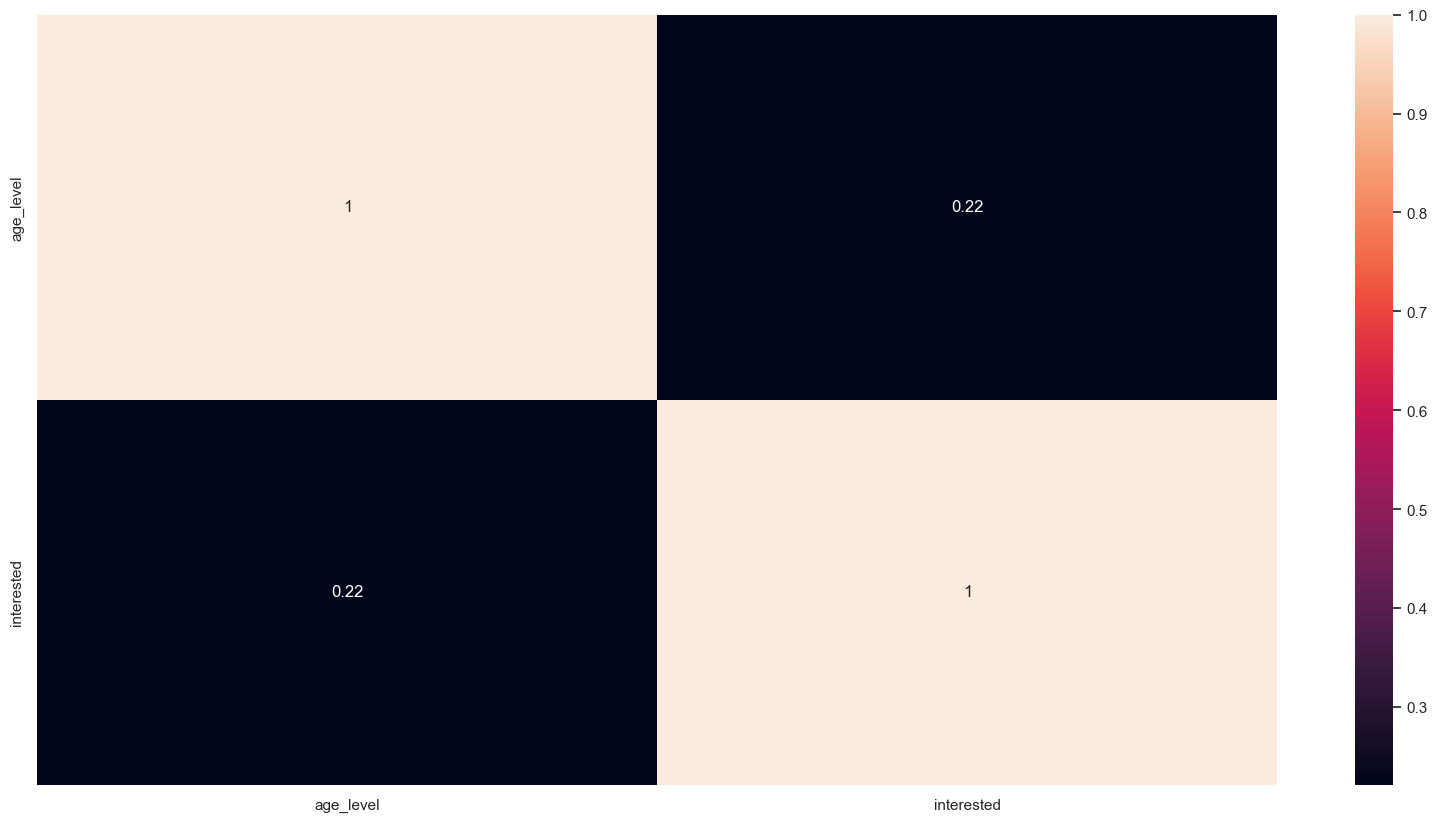

In [22]:
# Calculate cramer V
a1 = cramer_v( df4['age_level'], df4['age_level'] )
a2 = cramer_v( df4['age_level'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['age_level'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'age_level':  [a1, a2],
                   'interested': [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

**Conclusão:**

- Apesar de existir uma maior quantidade de clientes na base de seguro de saúde com idade entre 20 e 30 anos, a faixa de 31 a 50 anos possui o maior interesse dado o número proporcional de pessoas (médio), sendo esse superior a 20% nessa faixa.

- Correlação média positiva 

### 4.2.2. H2. Clientes do gênero Masculino deveriam ter, em média, maior interesse na compra de seguro veicular. VERDADEIRO

O gênero masculino possui maior proporção de interesse em comprar seguro veicular do que o gênero feminino.



**Conclusão:**

Gera Insight ? Não gera.


Pode ser relevante para o modelo? Não

**Analisando o interesse médio(proporcional) por genêro:**

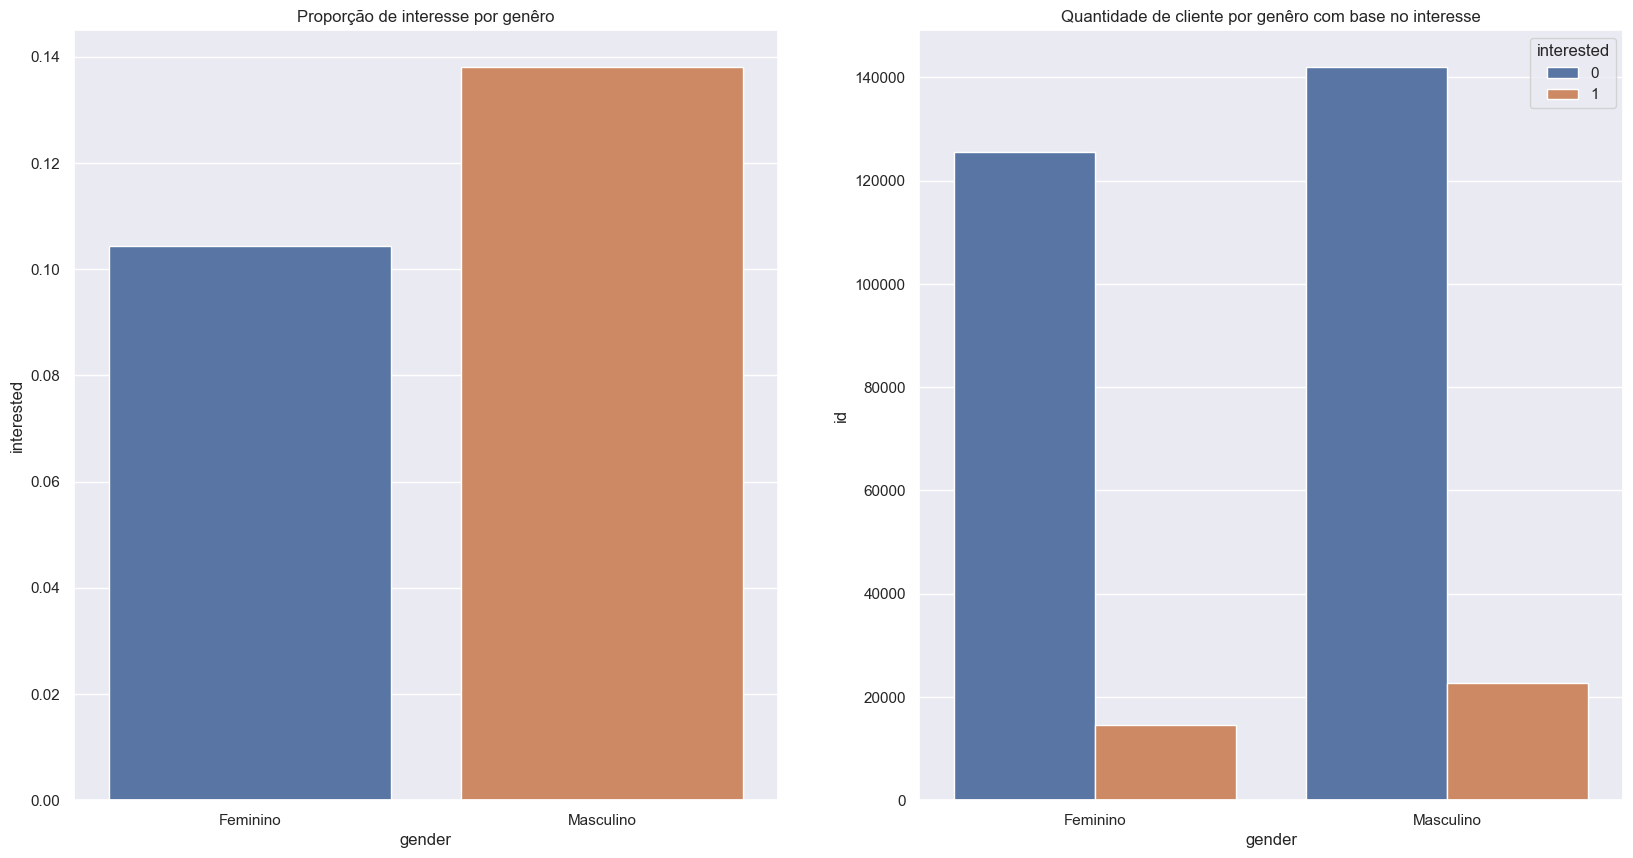

In [187]:
eda4 = df4[['gender', 'interested']].groupby('gender').mean().reset_index()
eda5 = df4[['gender', 'interested', 'id']].groupby(['gender','interested']).count().reset_index()


plt.subplot(1,2,1)
g1 = sns.barplot(x = 'gender' , y = 'interested' , data = eda4  );
g1.set_title('Proporção de interesse por genêro');

plt.subplot(1,2,2)
g2 = sns.barplot(x = 'gender' , y = 'id' , data = eda5, hue = 'interested'  );
g2.set_title('Quantidade de cliente por genêro com base no interesse');


**Análise da correlação através do V-Cramer:**

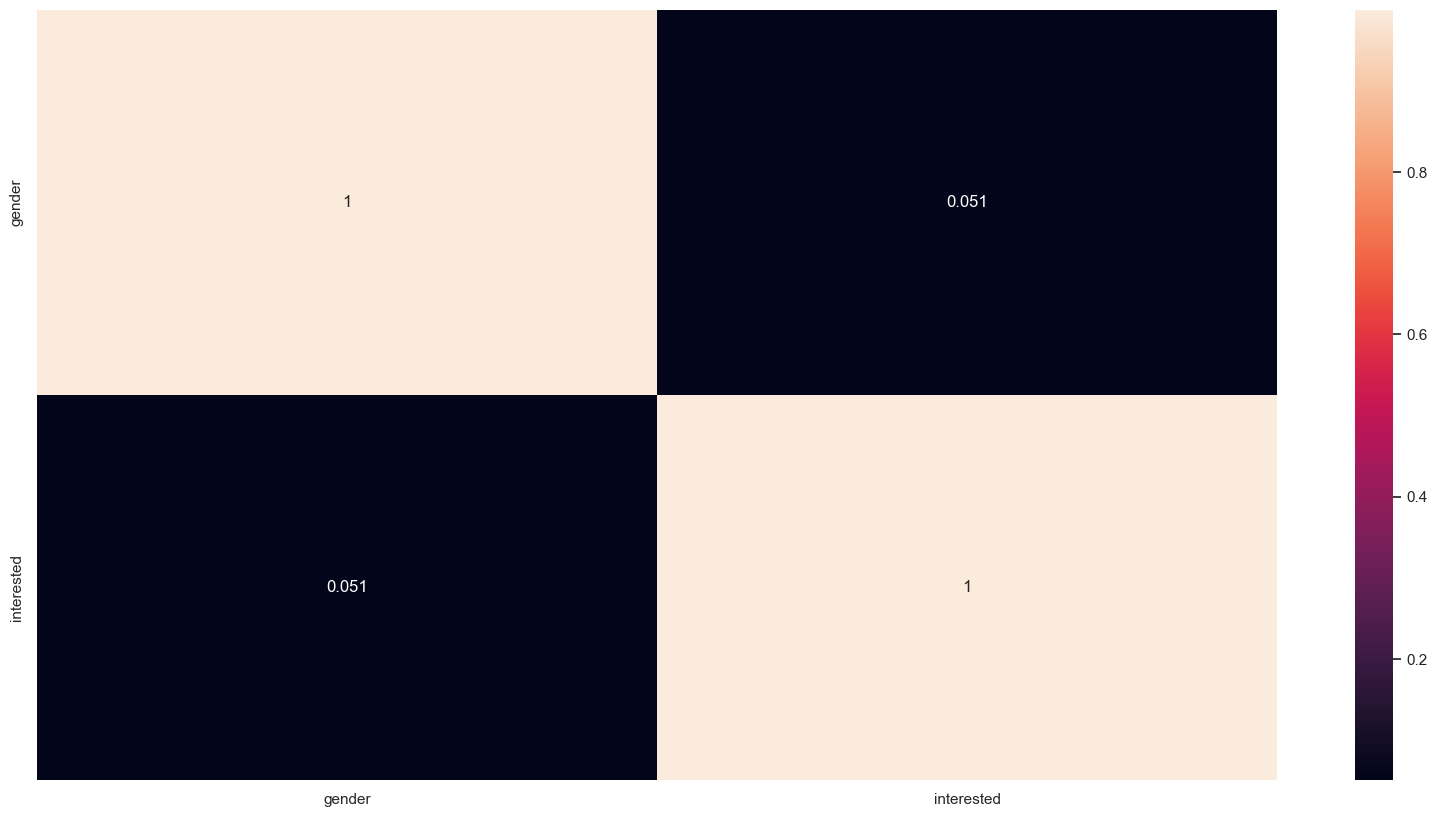

In [144]:
# Calculate cramer V
a1 = cramer_v( df4['gender'], df4['gender'] )
a2 = cramer_v( df4['gender'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['gender'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'gender':     [a1, a2],
                   'interested': [a3, a4] } )
                   

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

**OBS:** Fraca correlação positiva

### 4.2.3. H3. Clientes da região 28 deveriam ter, proporcionalmente, maior interesse na compra de seguro veicular. FALSO

   
**Conclusão:**

Gera Insight ? Sim, pois gera surpresa e desfaz crença


Pode ser relevante para o modelo? Sim

**Expectativa:** Mediante análise aprofundada da distribuição de clientes por região e segmentada por interesse feita na Análise Univariada em 4.1.3.2., é esperado que a região com maior proporção de clientes interessados seja a 28.

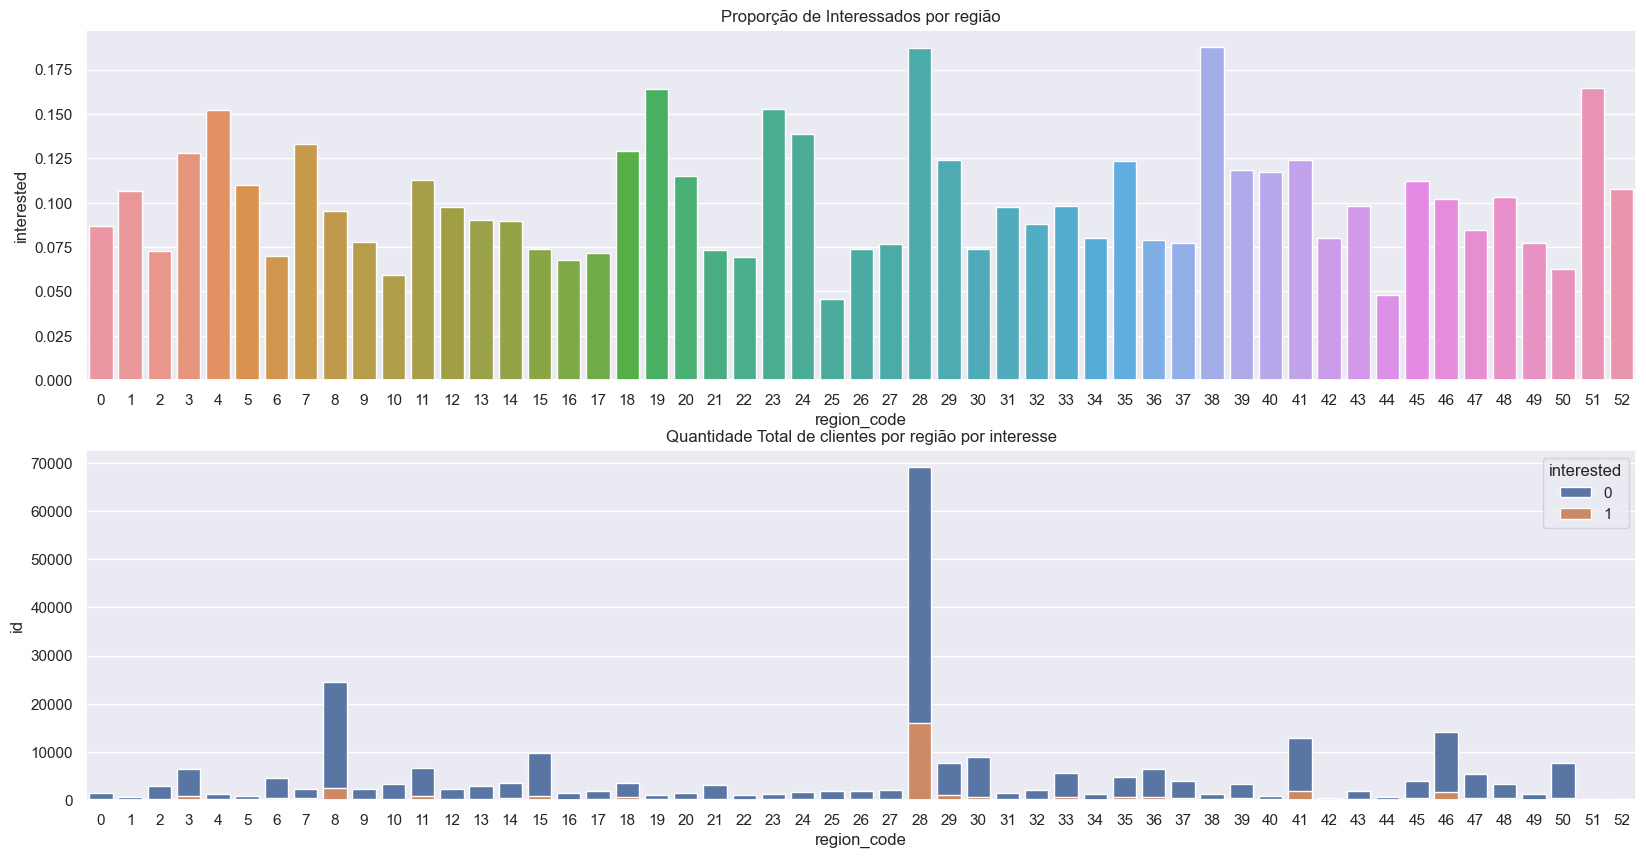

In [195]:
eda6 = df4[['region_code','interested']].groupby('region_code').mean().reset_index()
eda7 = df4[['region_code','interested','id']].groupby(['region_code', 'interested']).count().reset_index()

# Proporção
plt.subplot(2,1,1)
g3 = sns.barplot(x = 'region_code', y = 'interested' , data = eda6);
g3.set_title("Proporção de Interessados por região");

# Quantidade Total 
plt.subplot(2,1,2)
g4 = sns.barplot(x = 'region_code', y = 'id' , hue = 'interested', data = eda7, dodge = False);
g4.set_title("Quantidade Total de clientes por região por interesse");


**Conclusão:**
    
- Não só a região 28 possui a maior proporção de interessados na compra de seguro veicular, mas também a região 38. Contudo, a quantidade de clientes na base de dados dessa região é aproximadamente 41 vezes maior que a 38, impactando na quantidade total de clientes com interesse. Sendo assim, o foco deveria ser na 28 pela proporção x quantidade. 

- As regiões com bastante clientes na base como evidenciado em 4.1.3.2., na análise univariada, como 8, 15, 41 e 46 não tiveram uma proporção alta de interessados. Contudo, por terem bastante clientes na base dessas regiões, as regiões 8, 41 e 46 mesmo assim, se destacam na quantidade total de interessados logo atrás da 28. 

### 4.2.4. H4. Clientes com carteira de habilitação deveriam ter, proporcionalmente, maior interesse na compra de seguro veicular. 

### VERDADEIRO



**Conclusão:**

Gera Insight ? Não


Pode ser relevante para o modelo? Não

**Contexto:** Como já visto na análise univariada, praticamente a totalidade de clientes na base de dados disponível possui carteira, deve-se entender então, qual a proporção de interessados é maior entre quem possui a carteira e quem não possui. 

In [149]:
df4['driving_license'].value_counts()

Possui carteira    304233
Sem carteira          654
Name: driving_license, dtype: int64

**Dashboard:**

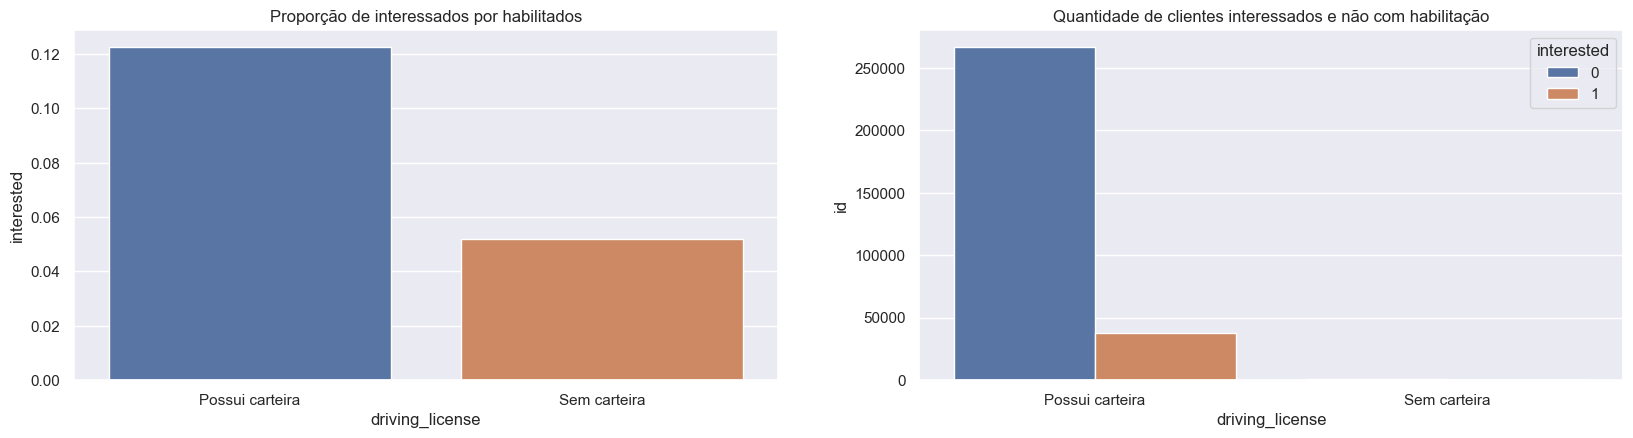

In [194]:
eda8 = df4[['driving_license','interested']].groupby('driving_license').mean().reset_index()
eda9 = df4[['driving_license','interested','id']].groupby( ['driving_license','interested'] ).count().reset_index()

plt.subplot(2,2,1)
g3 = sns.barplot(x = 'driving_license' , y = 'interested', data = eda8);
g3.set_title("Proporção de interessados por habilitados");

plt.subplot(2,2,2)
g4 = sns.barplot(x = 'driving_license' , y = 'id', hue = 'interested', data = eda9);
g4.set_title("Quantidade de clientes interessados e não com habilitação");

**Análise da correlação através do V-Cramer:**

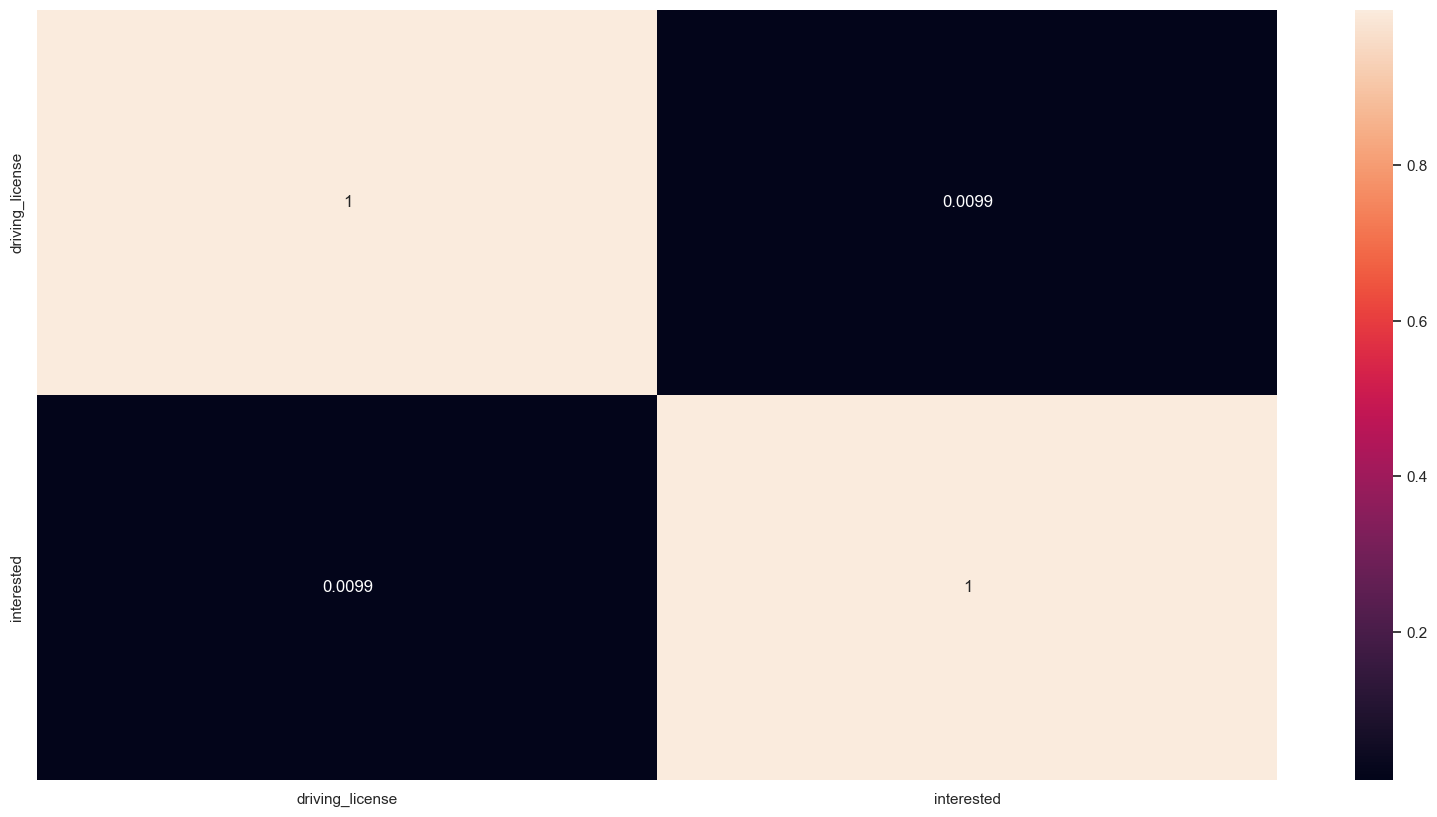

In [156]:
# Calculate cramer V
a1 = cramer_v( df4['driving_license'], df4['driving_license'] )
a2 = cramer_v( df4['driving_license'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['driving_license'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'driving_license': [a1, a2],
                   'interested':      [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

**Conclusão:**

- A proporção de clientes com carteira e interessados é maior que a sem carteira. E como a quantidade de clientes com carteira é maior que sem carteira, a quantidade total de interessados com carteira é maior do que sem carteira.

- Correlação via cálculo V-Cramer é fraca positiva.

### 4.2.5. H5. Clientes com canal de vendas utilizado sendo de 130 a 140 deveriam ter, em média, maior interesse na compra de seguro veicular. FALSO



Gera Insight ? Sim

Pode ser relevante para o modelo? Sim

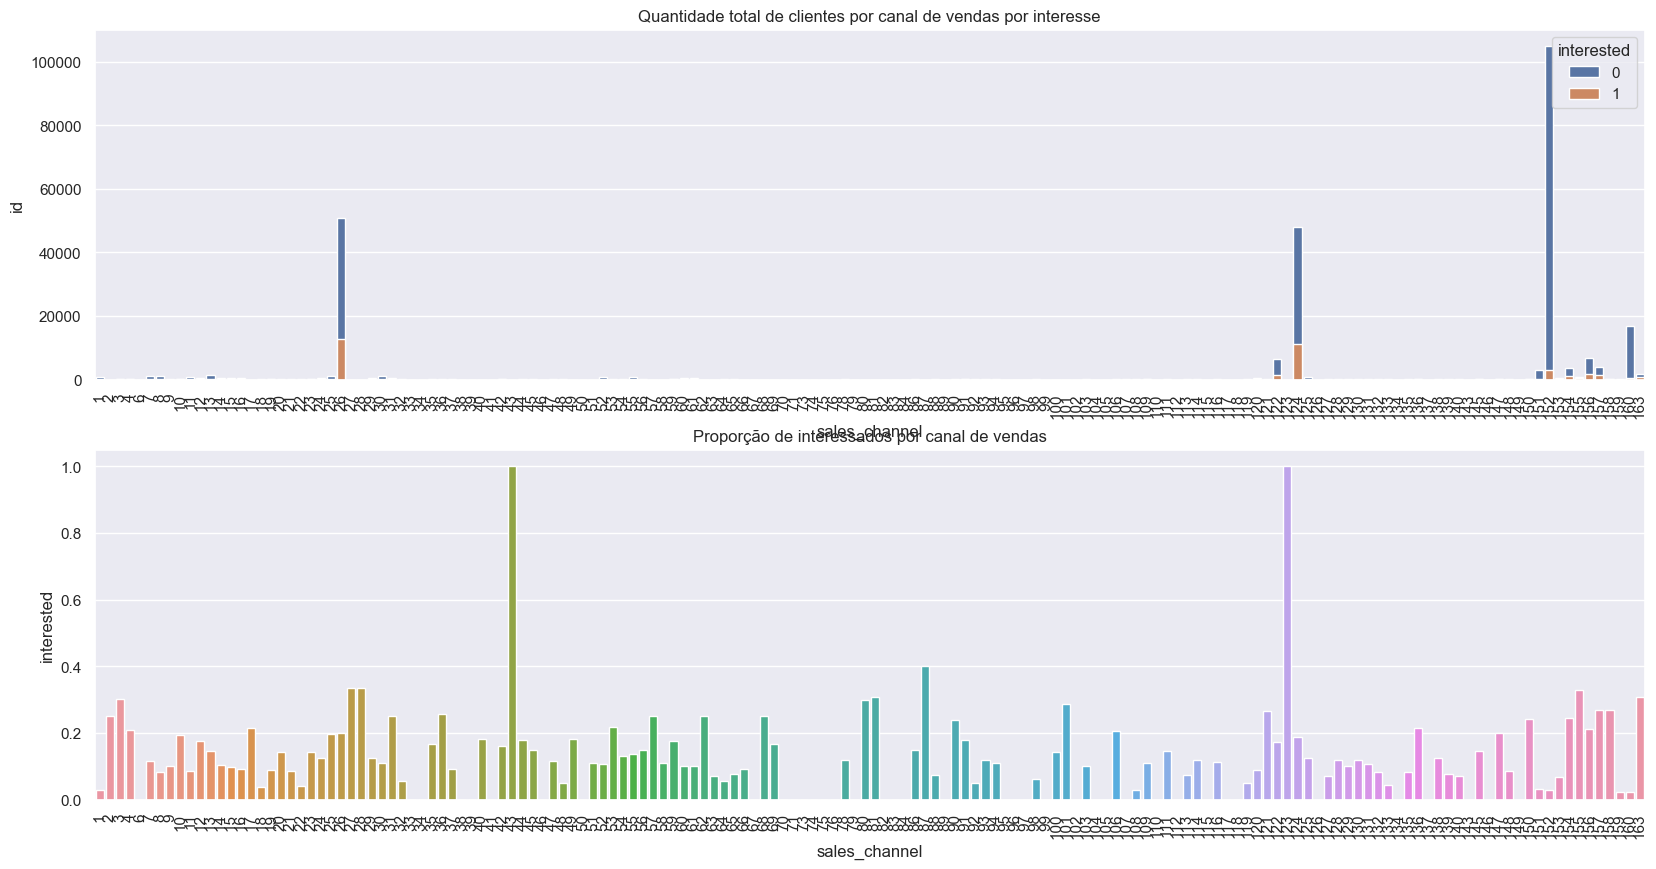

In [18]:
eda10 = df4[['sales_channel','interested','id']].groupby(['sales_channel','interested']).count().reset_index()
eda11 = df4[['sales_channel','interested']].groupby('sales_channel').mean().reset_index()


# Quantidade de clientes de cada canal - semelhante ao feito na análise univariada
plt.subplot(2,1,1)
g5 = sns.barplot(x = 'sales_channel', y = 'id', hue = 'interested', data = eda10, dodge = False);
g5.set_title("Quantidade total de clientes por canal de vendas por interesse");
plt.xticks(rotation = 90);


# Proporção de clientes interessados de cada canal
plt.subplot(2,1,2)
g6 = sns.barplot(x = 'sales_channel', y = 'interested', data = eda11);
g6.set_title("Proporção de interessados por canal de vendas");
plt.xticks(rotation = 90);

**Conclusão:**
    
- Analisando apenas o indicador proporção de clientes interessados por canal, os canais 43, 123 e 87 possuem maiores proporções de interessados. Porém, como esses canais não possuem uma quantidade elevada de clientes na base de dados, ao analisar efetivamente a quantidade de interessados por canal, canais com proporções menores de interesse por cliente por terem mais clientes acabam tendo um número maior de interessados, que é o caso do canal 26, 124 e 152.  

- Interessante notar que o canal 152 possui em quantidade de clientes, a quantidade somada do 26 e 124, porém como a proporção de interesse do canal 152 é tão baixa, ele possui menos interessados que os outros canais 26 e 124 mesmo tendo menos clientes advindos desse canal. 

### 4.2.6. H6. Clientes que pagam prêmio por seguro de saúde entre 2.630,00 e 20.000,00 reais deveriam ter maior interesse na compra de seguro veicular.  FALSO

**Conclusão:**

Gera Insight ? Sim


Pode ser relevante para o modelo? Não

In [ ]:
# Estratégia:
# 1. Analisar com quantidade de clientes por prêmio que paga e o interesse 
#        - gráfico de barras
#        - gráfico de linhas
# 2. Analisar a proporção de interessados que paga diferentes prêmios anuais    
#        - gráfico de barras
#        - gráfico de linhas
#    
# 3. Analisar a proporção de interessados por faixa de prêmios anuais
#         - gráfico de barras

<AxesSubplot: xlabel='annual_premium'>

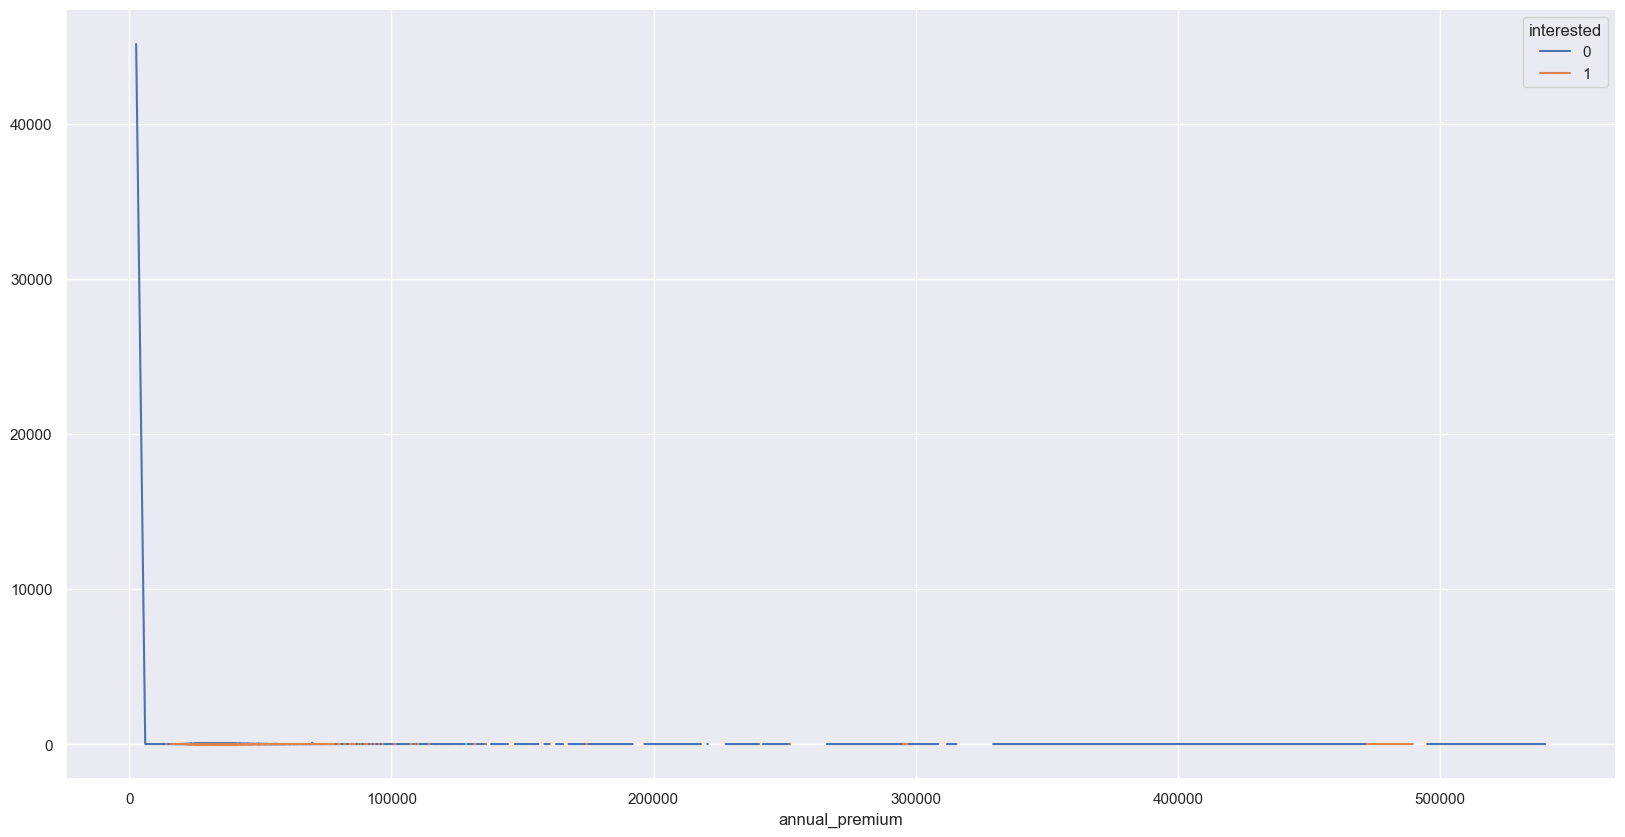

In [19]:
# 2 

eda12 = df4[['annual_premium', 'interested','id']].groupby(['annual_premium','interested']).count().reset_index()

eda12.pivot_table(index = 'annual_premium', columns = 'interested', values = 'id').plot()

Como a visualização ficou bem precária devido alto range do atributo annual_premium, utiliza-se a variável annual_premium em níveis.

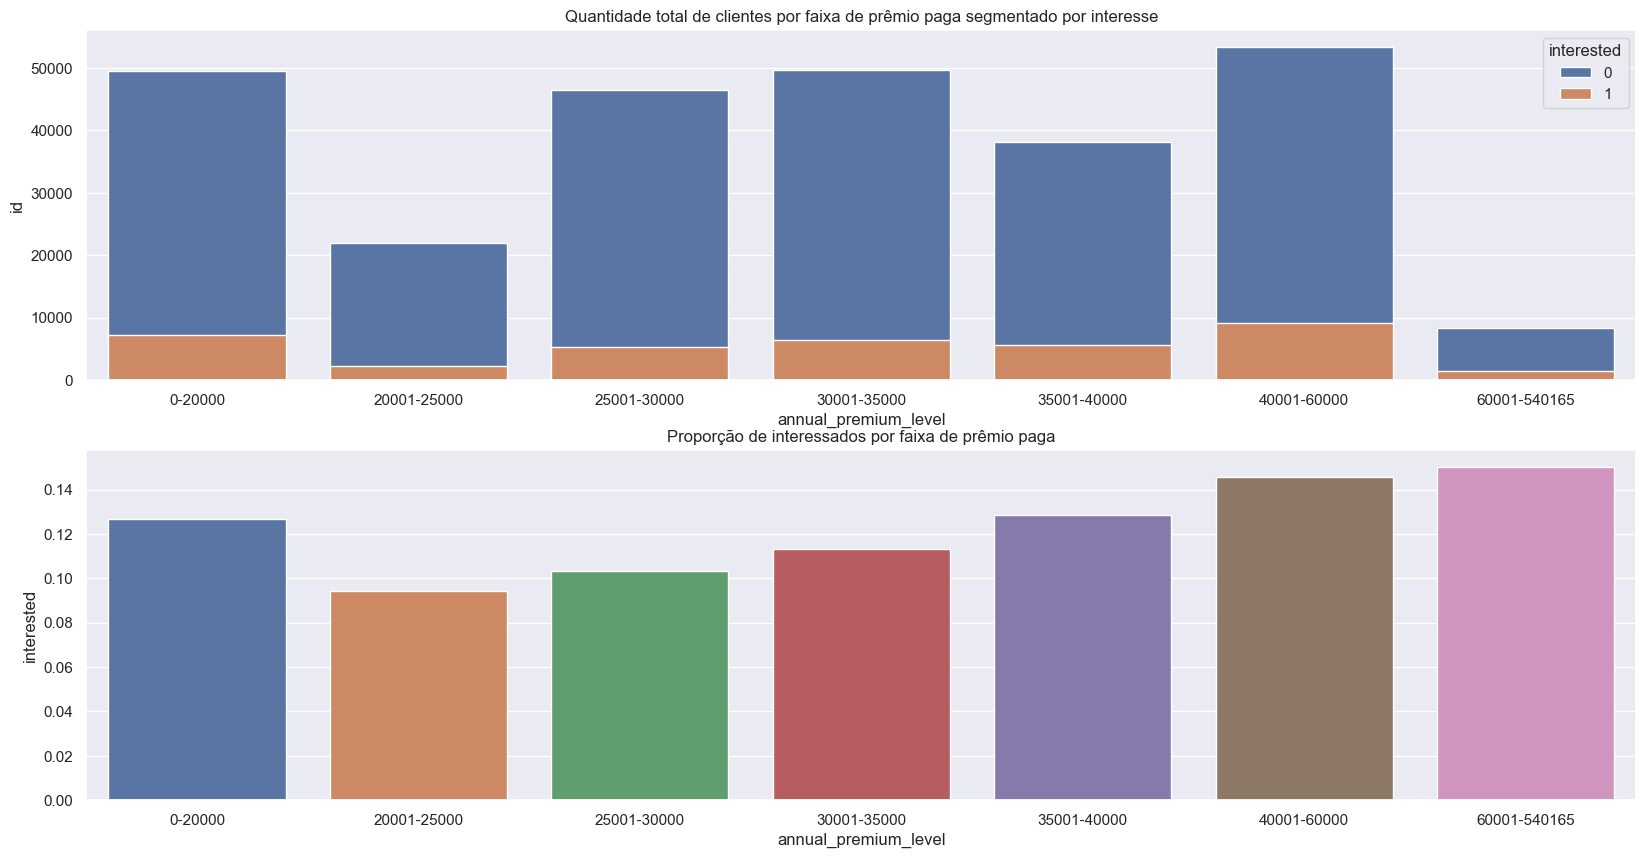

In [21]:
# 3

eda13 = df4[['annual_premium_level', 'interested','id']].groupby(['annual_premium_level','interested']).count().reset_index()
eda14 = df4[['annual_premium_level', 'interested']].groupby(['annual_premium_level']).mean().reset_index()


# Quantidade Total
plt.subplot(2,1,1)
g7 = sns.barplot(x = 'annual_premium_level', y = 'id' , data = eda13, hue = 'interested' , dodge = False);
g7.set_title("Quantidade total de clientes por faixa de prêmio paga segmentado por interesse");

# Proporção de interessados por nível
plt.subplot(2,1,2)
g8 = sns.barplot(x = 'annual_premium_level', y = 'interested' , data = eda14);
g8.set_title("Proporção de interessados por faixa de prêmio paga");

**Análise da correlação através do V-Cramer:**

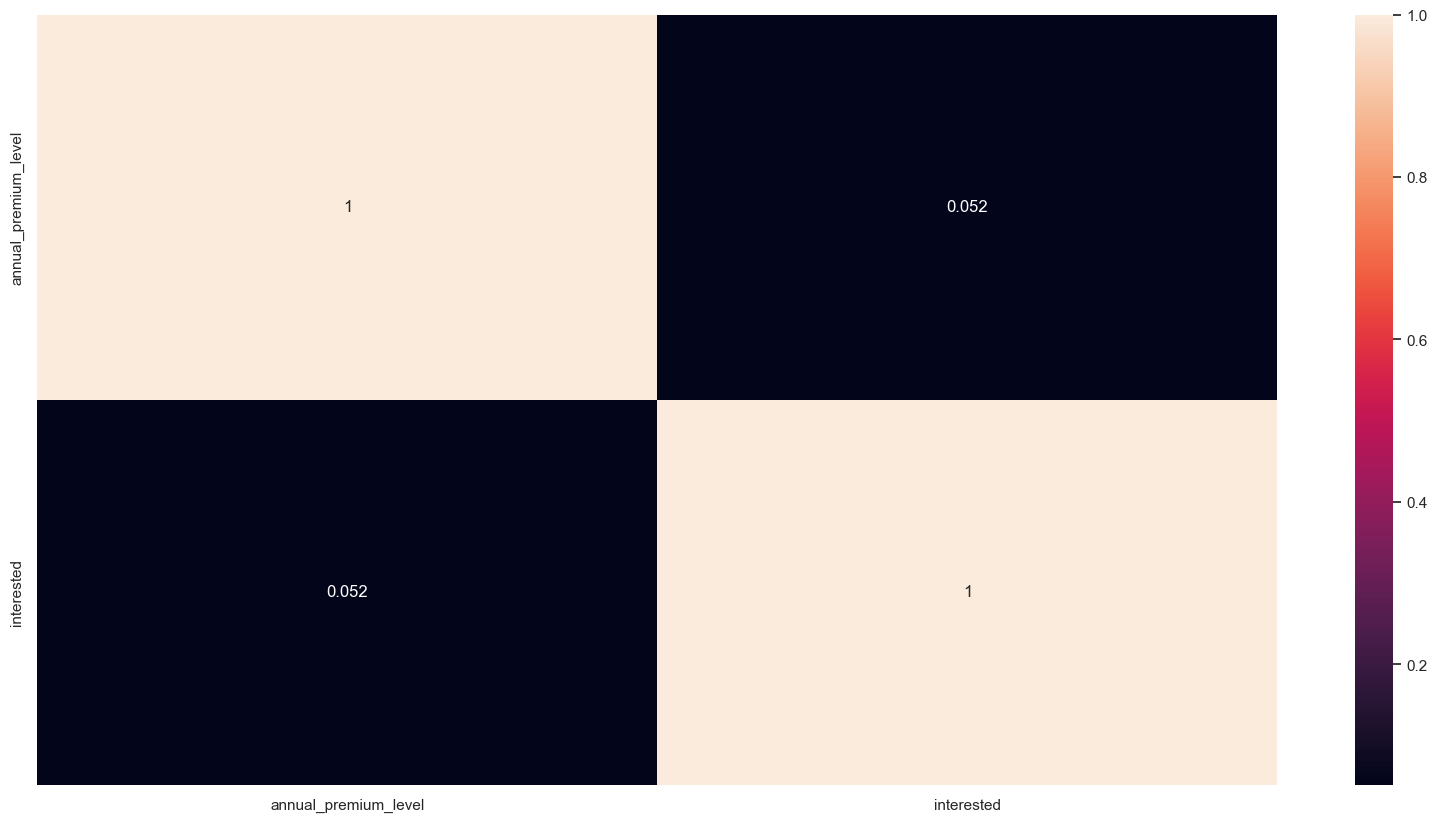

In [23]:
# Calculate cramer V
a1 = cramer_v( df4['annual_premium_level'], df4['annual_premium_level'] )
a2 = cramer_v( df4['annual_premium_level'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['annual_premium_level'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'annual_premium_level': [a1, a2],
                   'interested':           [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

**Conclusão:**
    
- Analisando apenas o indicador proporção de clientes interessados por faixa de prêmio paga, as faixas de 40 mil a 60 mil e 60 mil a 540 mil  possuem maiores proporções de interessados. Porém, essas variam na sua quantidade de clientes, sendo assim, ao analisar efetivamente a quantidade de interessados por faixa de prêmio, faixas com proporções menores de interesse por cliente por terem mais clientes acabam tendo um número maior de interessados. Com isso, as faixas de prêmios que possuem mais clientes interessados são de 40 mil a 60 mil, depois de 2 mil a 20 mil. 


- Correlação fraca positiva.

### 4.2.7. H7. Clientes com automóvel mais novo deveriam ter maior interesse na compra de seguro veicular. FALSO


**Conclusão:**

Gera Insight ? Bastante surpresa e descrença


Pode ser relevante para o modelo? Sim

In [ ]:
# Estratégia:
# 1. Analisar a quantidade de clientes por idade do automóvel e o interesse 
#        - gráfico de barras (esse)
#        - gráfico de linhas 
# 2. Analisar a proporção de interessados por idade do automóvel que possuem
#        - gráfico de barras (esse)
#        - gráfico de linhas
#    


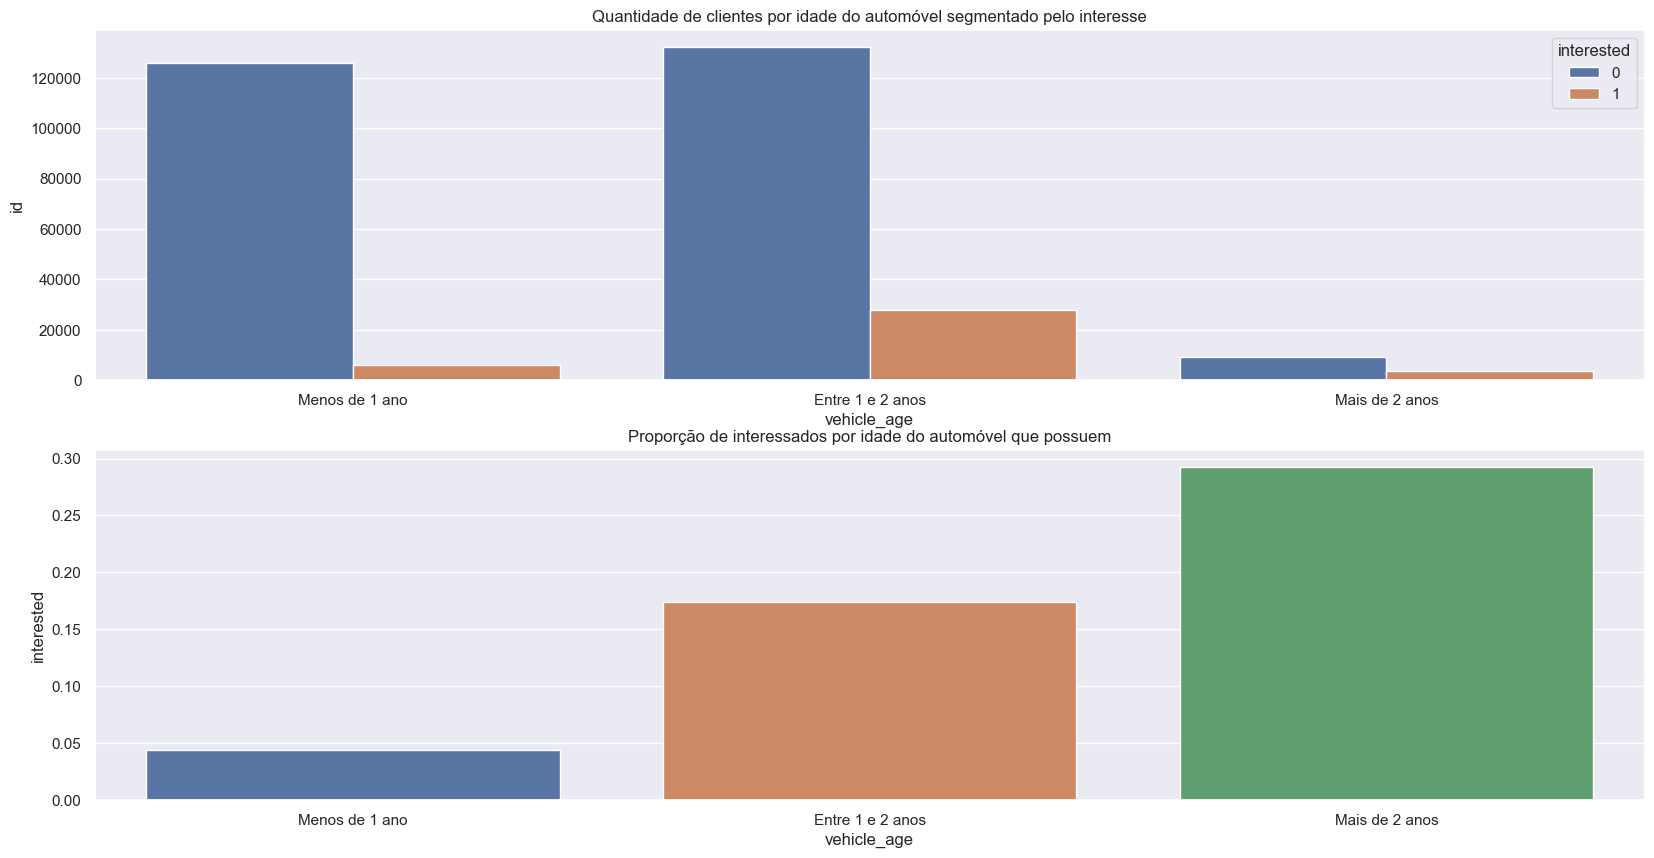

In [26]:
eda15 = df4[['vehicle_age', 'interested', 'id']].groupby(['vehicle_age', 'interested']).count().reset_index()
eda16 = df4[['vehicle_age', 'interested']].groupby(['vehicle_age']).mean().reset_index()

# quantidade de clientes 
plt.subplot(2,1,1)
g9 = sns.barplot( x = 'vehicle_age', y = 'id' , data = eda15 , hue = 'interested', order = ['Menos de 1 ano', 'Entre 1 e 2 anos','Mais de 2 anos'] );
g9.set_title("Quantidade de clientes por idade do automóvel segmentado pelo interesse");

# proporção
plt.subplot(2,1,2)
g10 = sns.barplot( x = 'vehicle_age', y = 'interested' , data = eda16, order = ['Menos de 1 ano', 'Entre 1 e 2 anos','Mais de 2 anos'] );
g10.set_title("Proporção de interessados por idade do automóvel que possuem");

**Analisando a correlação via V-Cramer:**

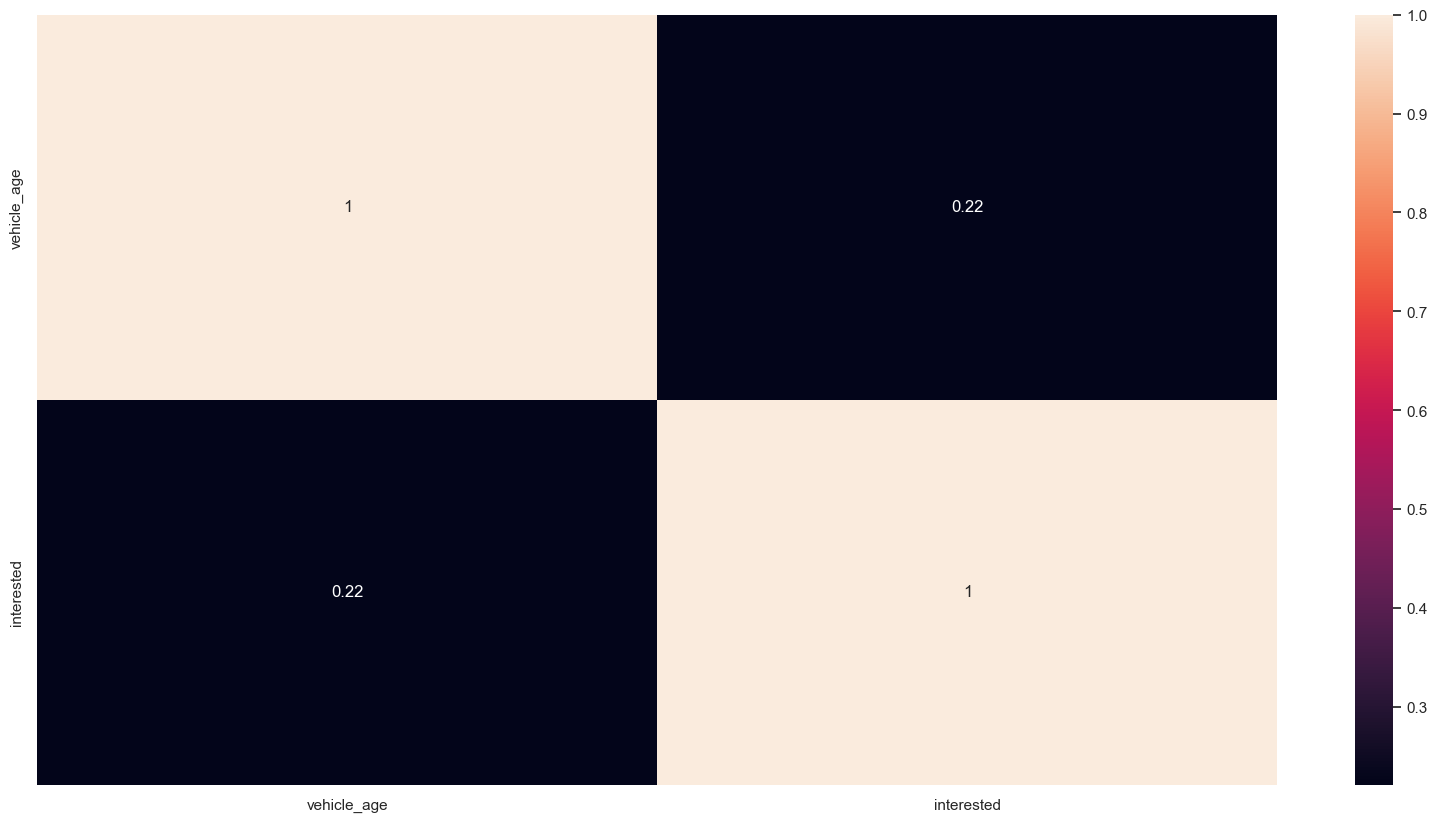

In [27]:
# Calculate cramer V
a1 = cramer_v( df4['vehicle_age'], df4['vehicle_age'] )
a2 = cramer_v( df4['vehicle_age'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['vehicle_age'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'vehicle_age': [a1, a2],
                   'interested':  [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

**Conclusão:**
    
- Analisando apenas o indicador proporção de clientes interessados na base por idade do veículo, quem possui veículo com menos de 1 ano têm menor interesse do que os que possuem veículo com idade entre 1 e 2 anos que por sua vez, têm menor interesse em relação aos clientes que possuem veículo com mais de 2 anos. Porém, possuem clientes mais interessados na base com veículo entre 1 ano e 2 anos, sendo essa a idade de veículo com mais clientes na base. 


- Pode-se verificar que há baixo interesse em seguro veicular quem possui veículo com menos de 1 ano, isso pode-se constatar devido a essa idade de veículo ser a segunda maior na base de clientes e a proporção de interessados ser baixa. Em contrapartida, pode-se verificar o contrário nos clientes que possuem veículo a mais de 2 anos, ou seja, uma proporção de interesse maior apesar de bastante baixa a quantidade de clientes com essa idade na base.


- Facilidade de discriminação com atributo vehicle_age relacionado ao interesse nos valores abaixo de 2 anos, acima, a análise revela equilíbrio entre quem tem interesse e quem não tem.


- Correlação média positiva.

### 4.2.8. H8. Clientes com automóvel já danificado deveriam ter menor interesse na compra de seguro veicular. FALSO

Clientes com automóvel já danificado possuem maior interesse na compra de seguro veicular.

**Conclusão:**

Gera Insight ? Sim


Pode ser relevante para o modelo? Sim 

In [ ]:
# Estratégia:
# 1. Analisar com quantidade de clientes por carro danificado e por interesse 
#        - gráfico de barras (esse)
#        - gráfico de linhas
# 2. Analisar a proporção de interessados segmentado por carro danificado   
#        - gráfico de barras (esse)
#        - gráfico de linhas
#    


id
vehicle_damage     interested        
Foi danificado     0           117385
                   1            36574
Não foi danificado 0           150134
                   1              794

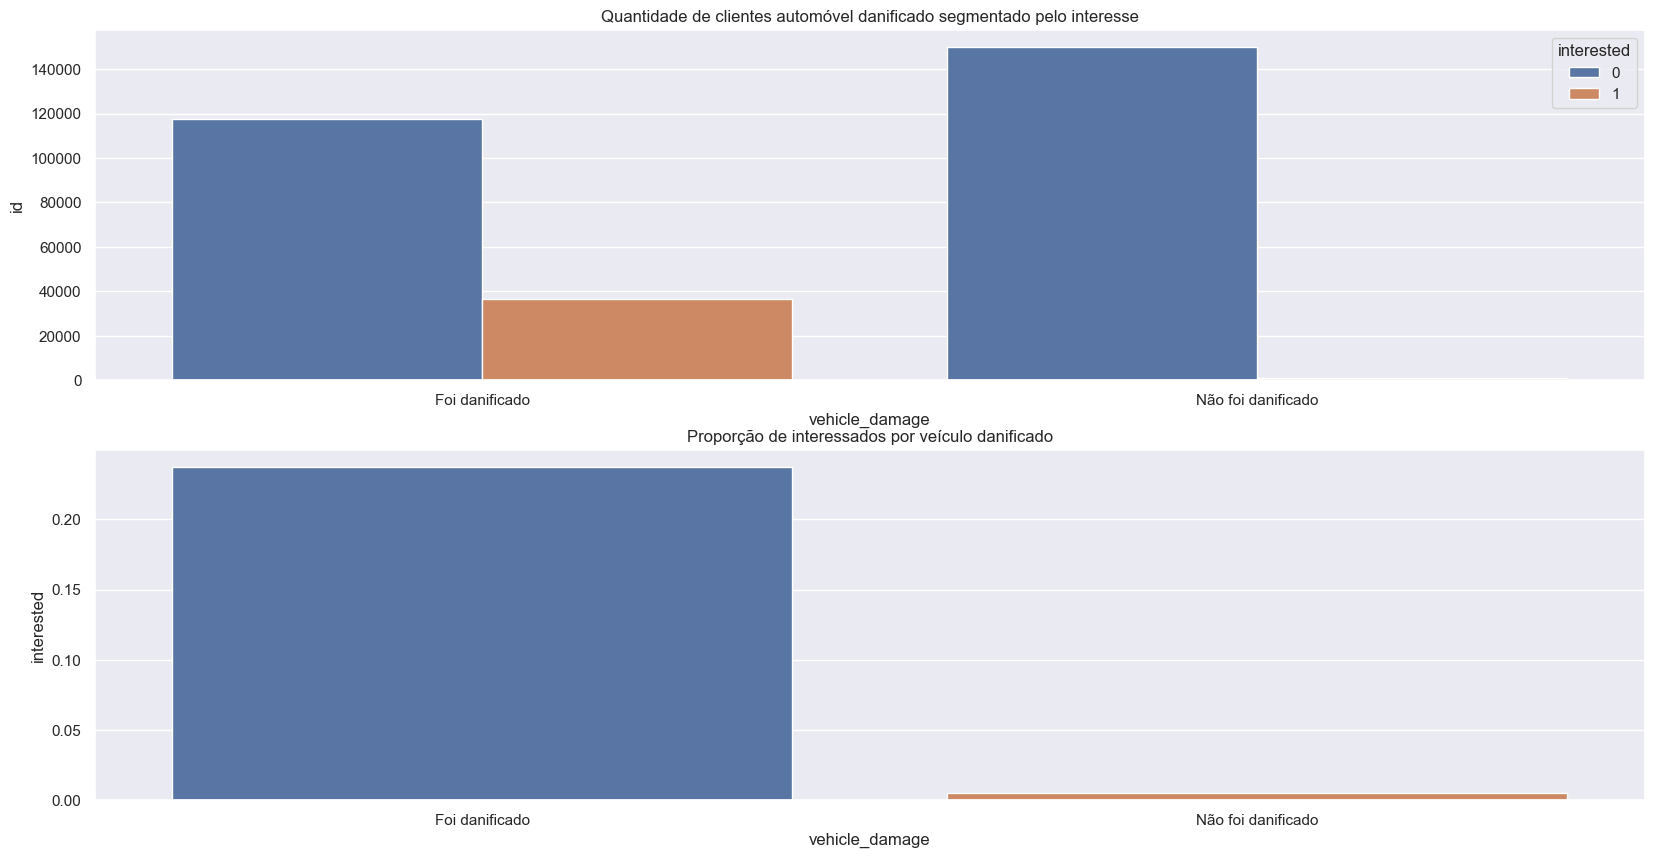

In [33]:
eda17 = df4[['vehicle_damage','interested','id']].groupby( ['vehicle_damage','interested'] ).count().reset_index()
eda18 = df4[['vehicle_damage','interested']].groupby( 'vehicle_damage' ).mean().reset_index()

# Quantidade total de clientes
plt.subplot(2,1,1)
g11 = sns.barplot(x = 'vehicle_damage' , y = 'id', data = eda17 , hue = 'interested');
g11.set_title("Quantidade de clientes automóvel danificado segmentado pelo interesse");

# Proporção de clientes por veículo danificado
plt.subplot(2,1,2)
g12 = sns.barplot(x = 'vehicle_damage' , y = 'interested', data = eda18 );
g12.set_title("Proporção de interessados por veículo danificado");

# Pra visualizar melhor o interesse dos clientes que não tiveram o carro danificado

df4[['vehicle_damage','interested','id']].groupby( ['vehicle_damage','interested'] ).count()

**Análise de Correlação via V-Cramer:**

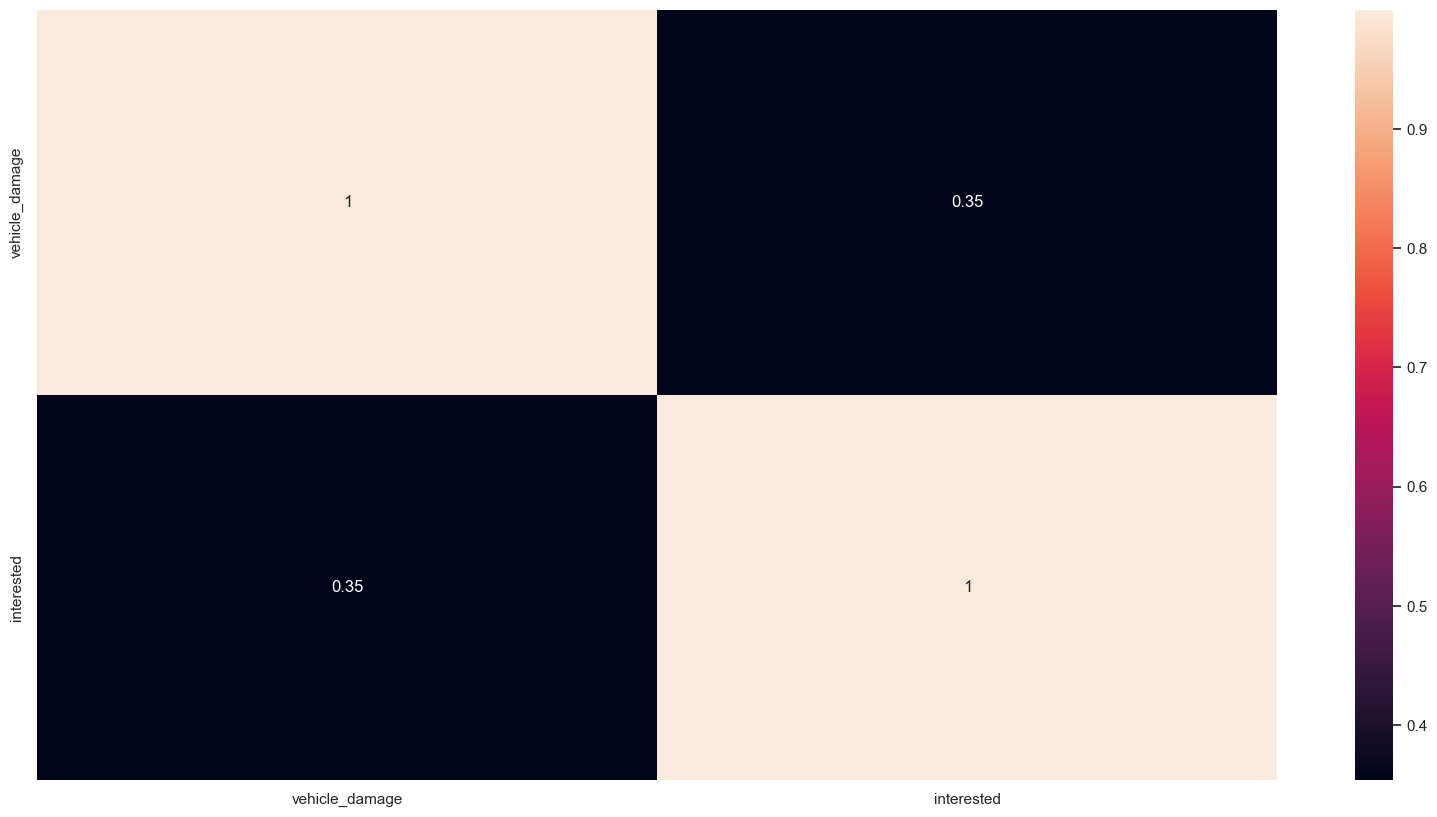

In [29]:
# Calculate cramer V
a1 = cramer_v( df4['vehicle_damage'], df4['vehicle_damage'] )
a2 = cramer_v( df4['vehicle_damage'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['vehicle_damage'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'vehicle_damage': [a1, a2],
                   'interested':     [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

**Conclusão:**
    
- Em resumo, de acordo com a proporção de interesse de clientes cujo carro foi danificado e não danificado, e de acordo com a própria quantidade de clientes interessados, verifica-se que existe interesse acima de 20% de clientes com carro que já foi danificado em comprar seguro. Entretanto, clientes com carros que não foram danificados existe 0,5% de interesse, o que representa 794 pessoas das quase 151 mil com carro não danificado.


- Correlação média positiva.

### 4.2.9. H9. Clientes com automóvel que já possui seguro deveriam ter menor interesse na compra de seguro veicular.   VERDADEIRO


**Conclusão:**

Gera Insight ? Não


Pode ser relevante para o modelo? Sim

In [ ]:
# Estratégia:
# 1. Analisar a quantidade de clientes por veículo que possui seguro e por interesse 
#        - gráfico de barras (esse)
#        - gráfico de linhas
# 2. Analisar a proporção de interessados segmentado por veículo assegurado    
#        - gráfico de barras (esse)
#        - gráfico de linhas


id
vehicle_insured   interested        
Já possui seguro  0           139559
                  1              118
Não possui seguro 0           127960
                  1            37250

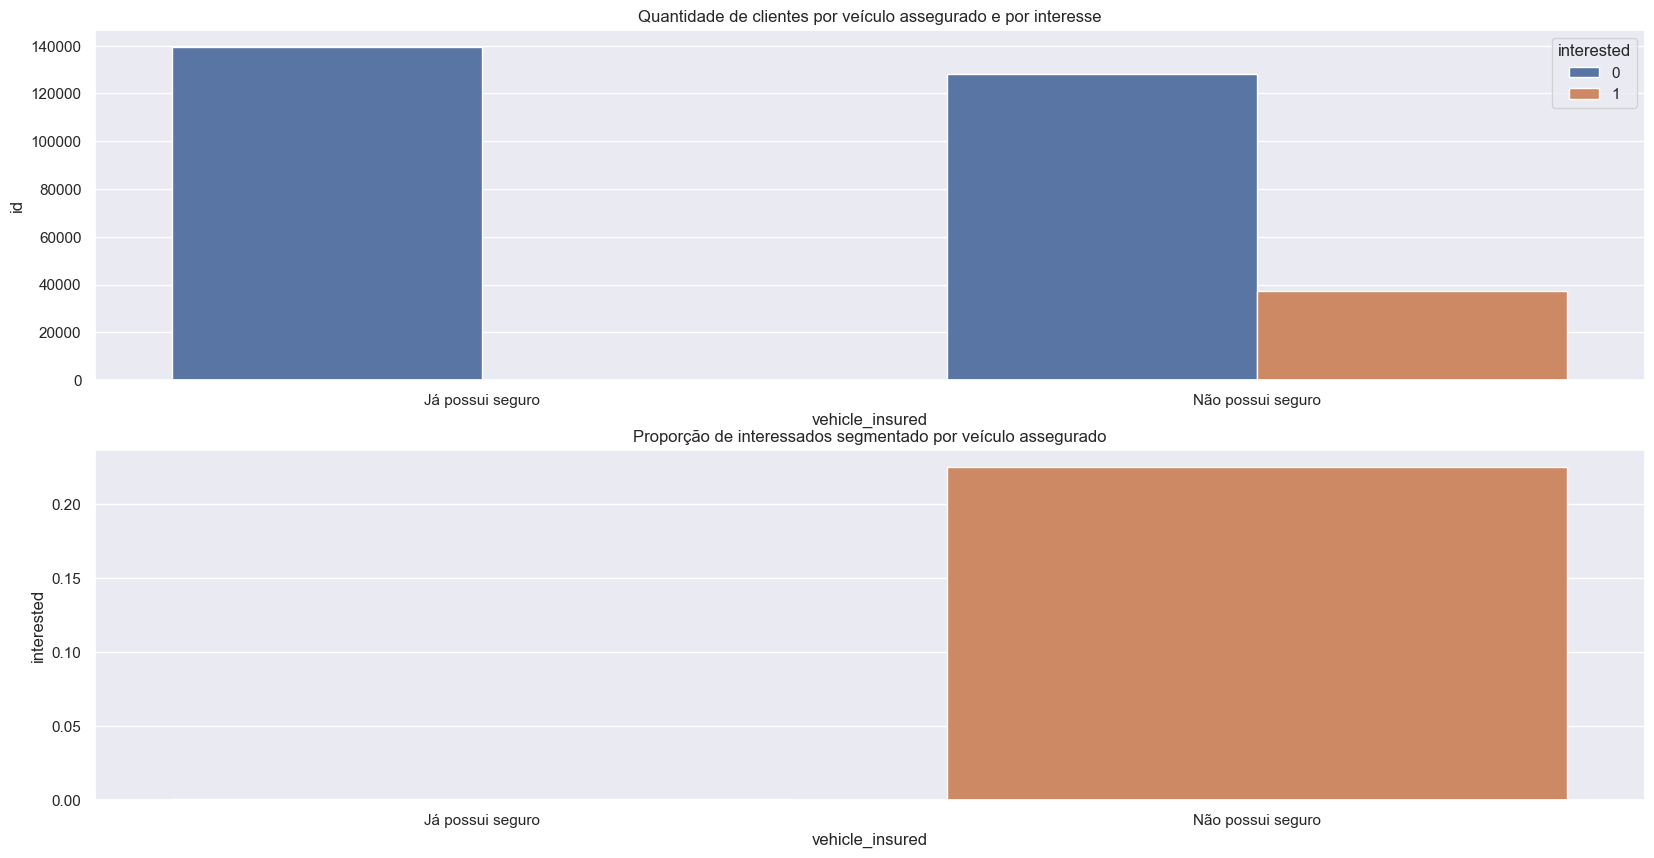

In [32]:
eda19 = df4[['vehicle_insured', 'interested', 'id']].groupby(['vehicle_insured', 'interested']).count().reset_index()
eda20 = df4[['vehicle_insured', 'interested']].groupby('vehicle_insured').mean().reset_index()


# alternativa para analisar duas variáveis categóricas (dicotômicas)
#eda60 = pd.crosstab(df4['vehicle_insured'], df4['vehicle_interested'])

# Quantidade
plt.subplot(2,1,1)
g13 = sns.barplot(x = 'vehicle_insured' , y = 'id' , data = eda19 , hue = 'interested' );
g13.set_title("Quantidade de clientes por veículo assegurado e por interesse");

# Proporção
plt.subplot(2,1,2)
g14 = sns.barplot(x = 'vehicle_insured' , y = 'interested' , data = eda20 );
g14.set_title("Proporção de interessados segmentado por veículo assegurado");

df4[['vehicle_insured', 'interested', 'id']].groupby(['vehicle_insured', 'interested']).count()

**Análise de Correlação via V-Cramer:**

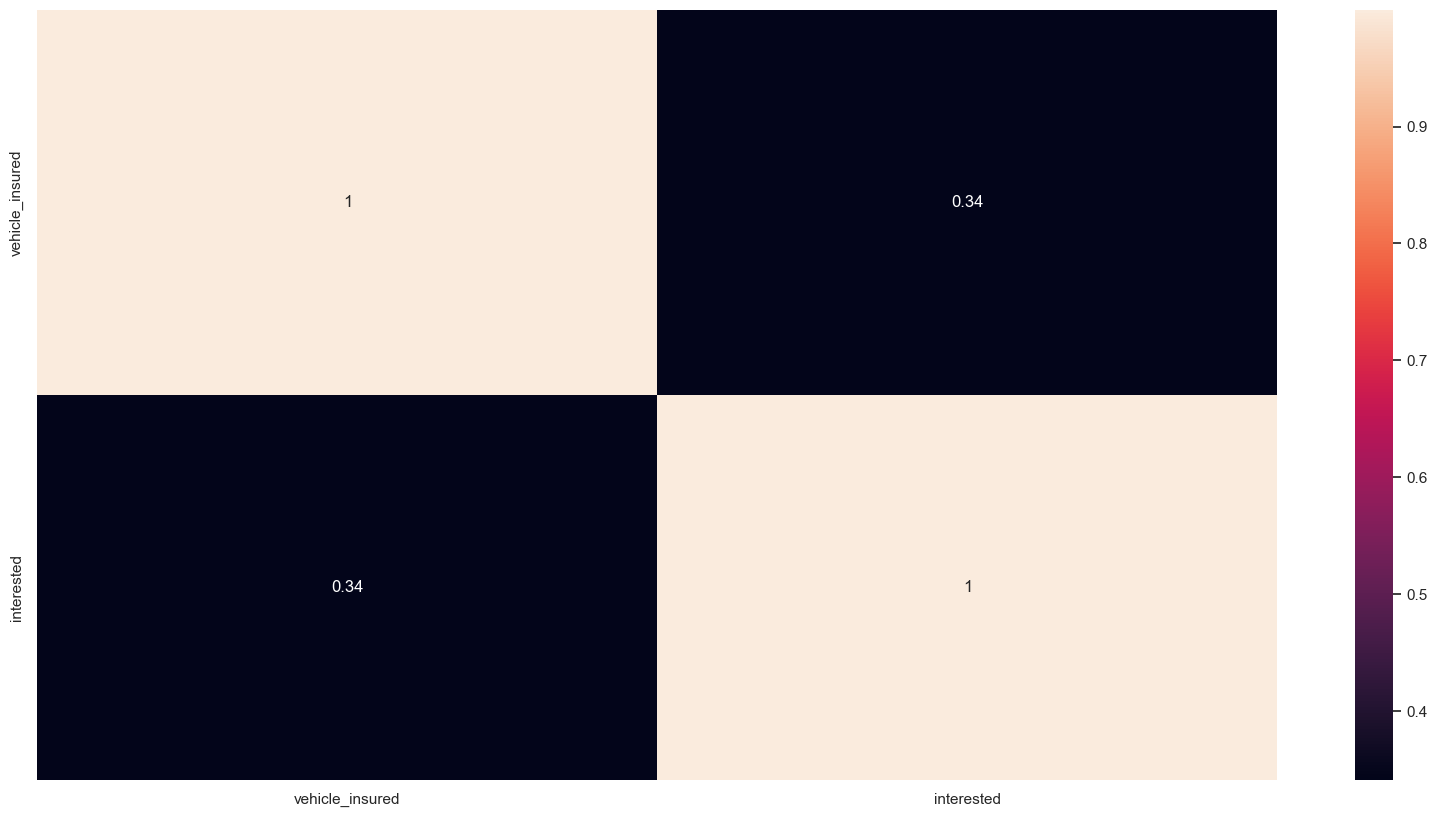

In [34]:
# Calculate cramer V
a1 = cramer_v( df4['vehicle_insured'], df4['vehicle_insured'] )
a2 = cramer_v( df4['vehicle_insured'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['vehicle_insured'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'vehicle_insured': [a1, a2],
                   'interested':      [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

DICA: Resumir melhor essas análises e colocar em porcentagens.


**Conclusão:**
    
- De acordo com a proporção de interesse de clientes cujo carro não possui seguro , e de acordo com a própria quantidade de clientes interessados, verifica-se que existe interesse acima de 20% de clientes com carro que não possui seguro em comprar seguro. Entretanto, clientes com carros que já possuem seguro têm 0,08% de interesse, o que representa 118 pessoas de aproximadamente 140 mil clientes que já possuem seguro.


- Pode ser indicativo de viés e vazamento de dados esse atributo vehicle_insured pois da forma como os dados estão distribuídos certamente o modelo irá aprender que se o cliente já possui seguro dificilmente ele terá interesse pelo produto tamanha discrepância nos dados revelados de quem possui seguro já e seu interesse.


- Correlação média positiva.

### 4.2.10. H10. Clientes que estão a mais tempo com a empresa recebendo seguro de saúde deveriam ter maior interesse na compra de seguro veicular. FALSO



**Conclusão:**

Gera Insight ? Não


Pode ser relevante para o modelo? Não

In [ ]:
# Estratégia:

## FEATURE 'days_client_associate'
# 1. Analisar a quantidade de clientes de acordo com o tempo que estão com a empresa e o interesse na compra 
#        - gráfico de barras
#        - gráfico de linhas
# 2. Analisar a proporção de interessados por tempo que estão com a empresa   
#        - gráfico de barras
#        - gráfico de linhas
#
# ## FEATURE 'days_client_associate_level'
#
#  3. Analisar a quantidade de clientes de acordo com a faixa de tempo que estão com a empresa e o interesse na compra 
#        - gráfico de barras 
#  4. Analisar a proporção de interessados por faixa de tempo que estão com a empresa
#         - gráfico de barras
#
#  5. Análise de Correlação via V-Cramer

**Analisando pela variável granular numérica 'days_client_associate':**

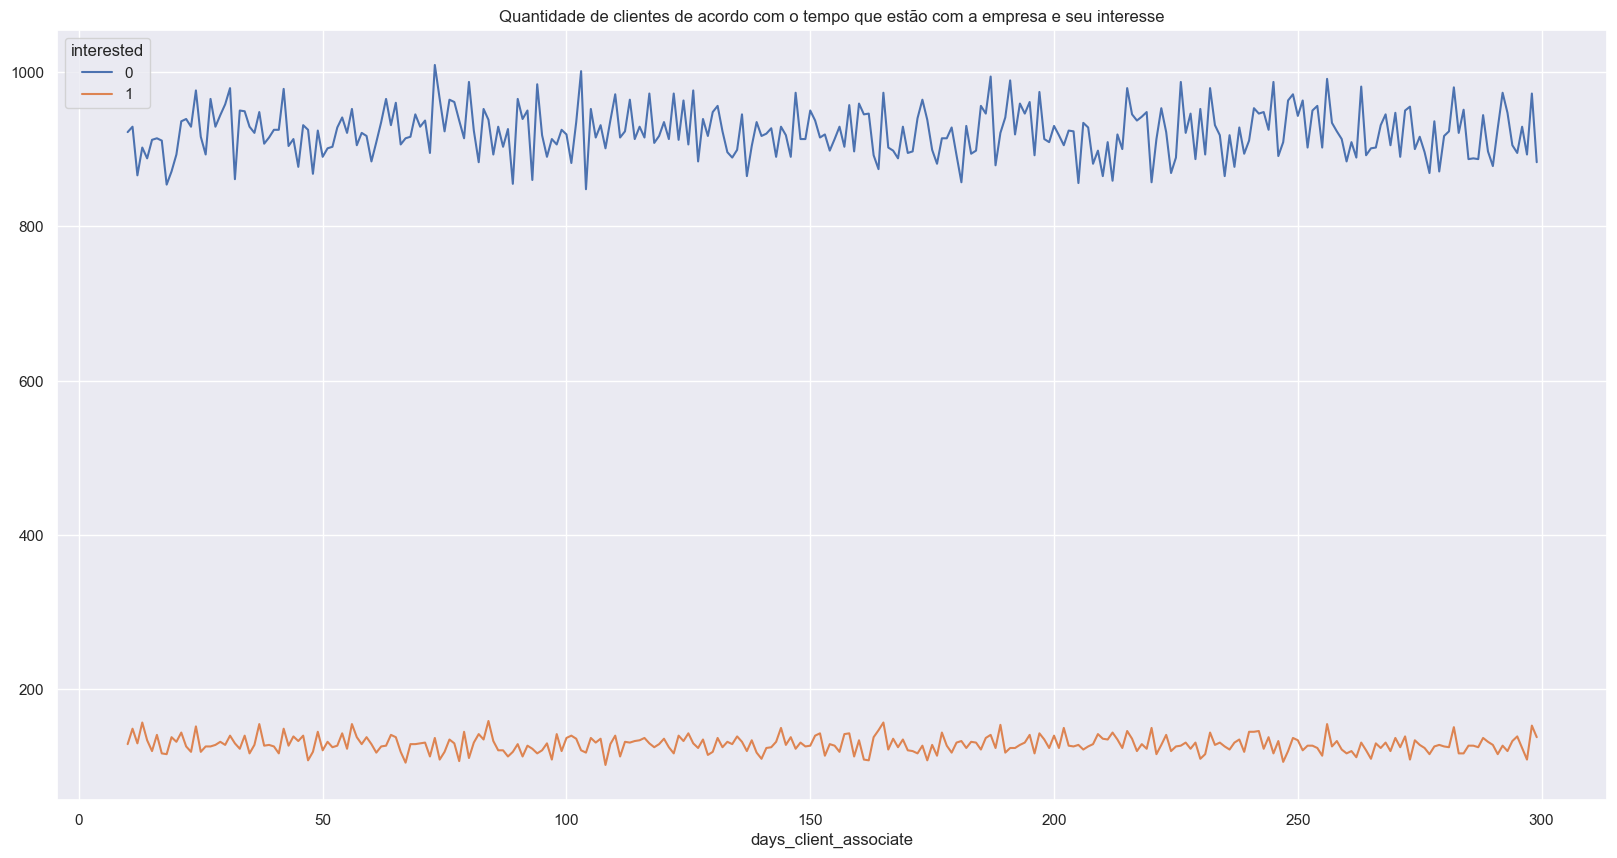

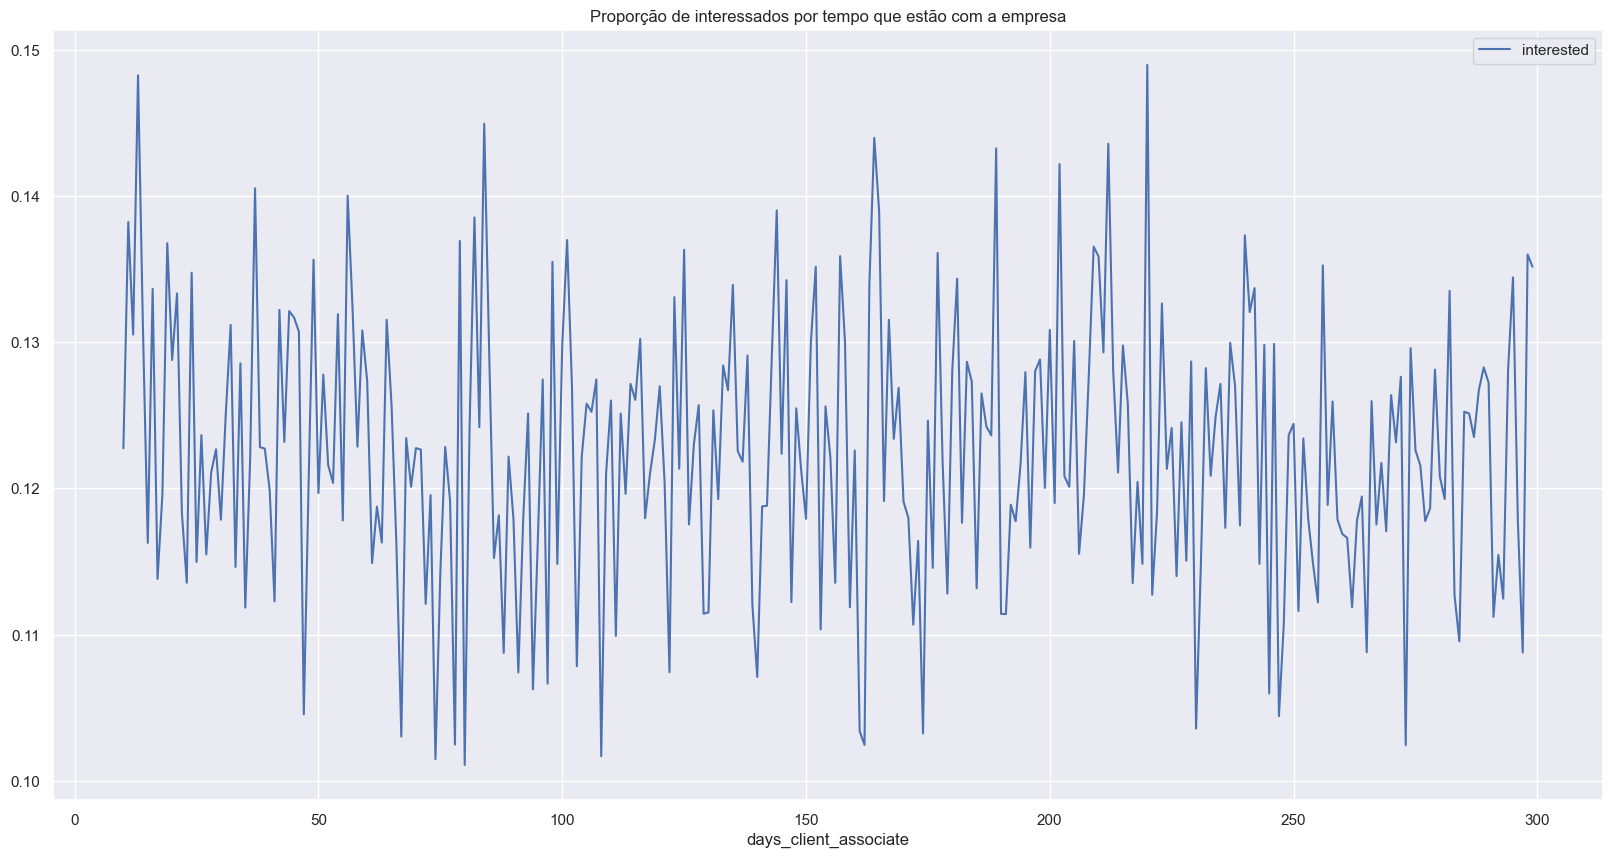

In [38]:
eda21 = df4[['days_client_associate', 'interested', 'id']].groupby(['days_client_associate', 'interested']).count().reset_index()
eda22 = df4[['days_client_associate', 'interested']].groupby('days_client_associate').mean().reset_index()


## FEATURE 'days_client_associate'

# 1. Quantidade 
#plt.subplot(2,1,1)
#g15 = sns.barplot(x = 'days_client_associate', y = 'id', data = eda21 , hue = 'interested' , dodge = False);
#g15.set_title("Quantidade de clientes de acordo com o tempo que estão com a empresa e seu interesse");
#plt.xticks(rotation = 90);


g15 = eda21.pivot_table(index = 'days_client_associate' , columns = 'interested', values = 'id' ).plot();
g15.set_title("Quantidade de clientes de acordo com o tempo que estão com a empresa e seu interesse");


# # 2. Proporção 

# plt.subplot(2,1,2)
# g16 = sns.barplot(x = 'days_client_associate', y = 'interested', data = eda22 );
# g16.set_title("Proporção de interessados por tempo que estão com a empresa");

g16 = eda22.pivot_table(index = 'days_client_associate' , values = 'interested' ).plot();
g16.set_title("Proporção de interessados por tempo que estão com a empresa");

**Analisando pela variável quantitativa categórica em níveis 'days_client_associate_level':**

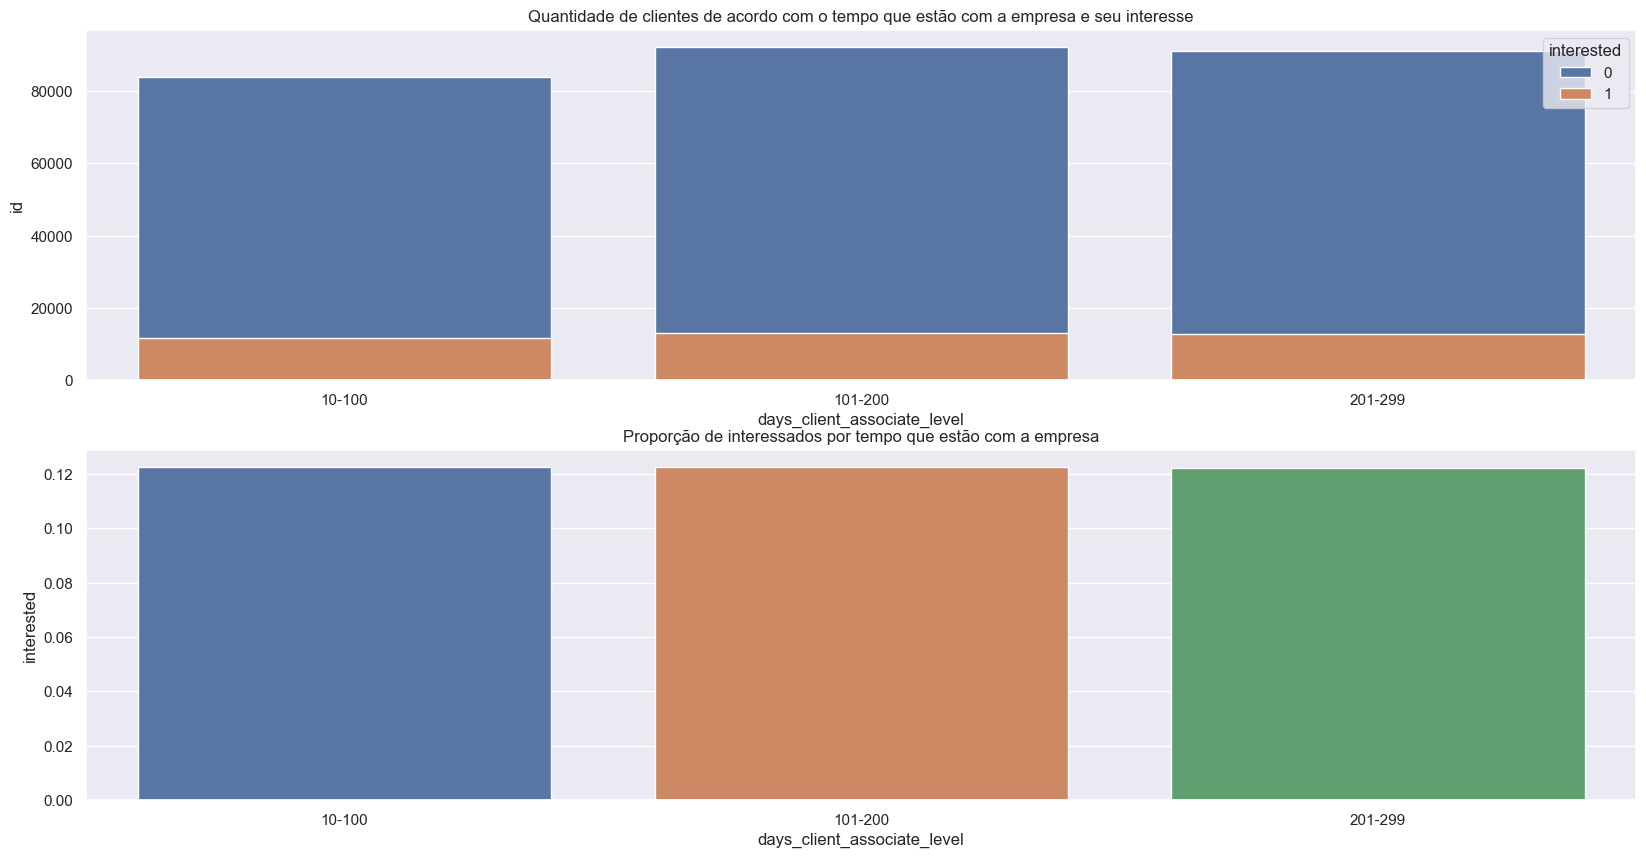

In [44]:
eda23 = df4[['days_client_associate_level', 'interested', 'id']].groupby(['days_client_associate_level', 'interested']).count().reset_index()
eda24 = df4[['days_client_associate_level', 'interested']].groupby('days_client_associate_level').mean().reset_index()


## FEATURE 'days_client_associate'

# 1. Quantidade 
plt.subplot(2,1,1)
g17 = sns.barplot(x = 'days_client_associate_level', y = 'id', data = eda23 , hue = 'interested', dodge = False );
g17.set_title("Quantidade de clientes de acordo com o tempo que estão com a empresa e seu interesse");


# # 2. Proporção 

plt.subplot(2,1,2)
g18 = sns.barplot(x = 'days_client_associate_level', y = 'interested', data = eda24 );
g18.set_title("Proporção de interessados por tempo que estão com a empresa");


In [42]:
# Números proporção de interesse
df4[['days_client_associate_level', 'interested']].groupby('days_client_associate_level').mean()

interested
days_client_associate_level            
10-100                             0.12
101-200                            0.12
201-299                            0.12

**Análise de Correlação via V-Cramer:**

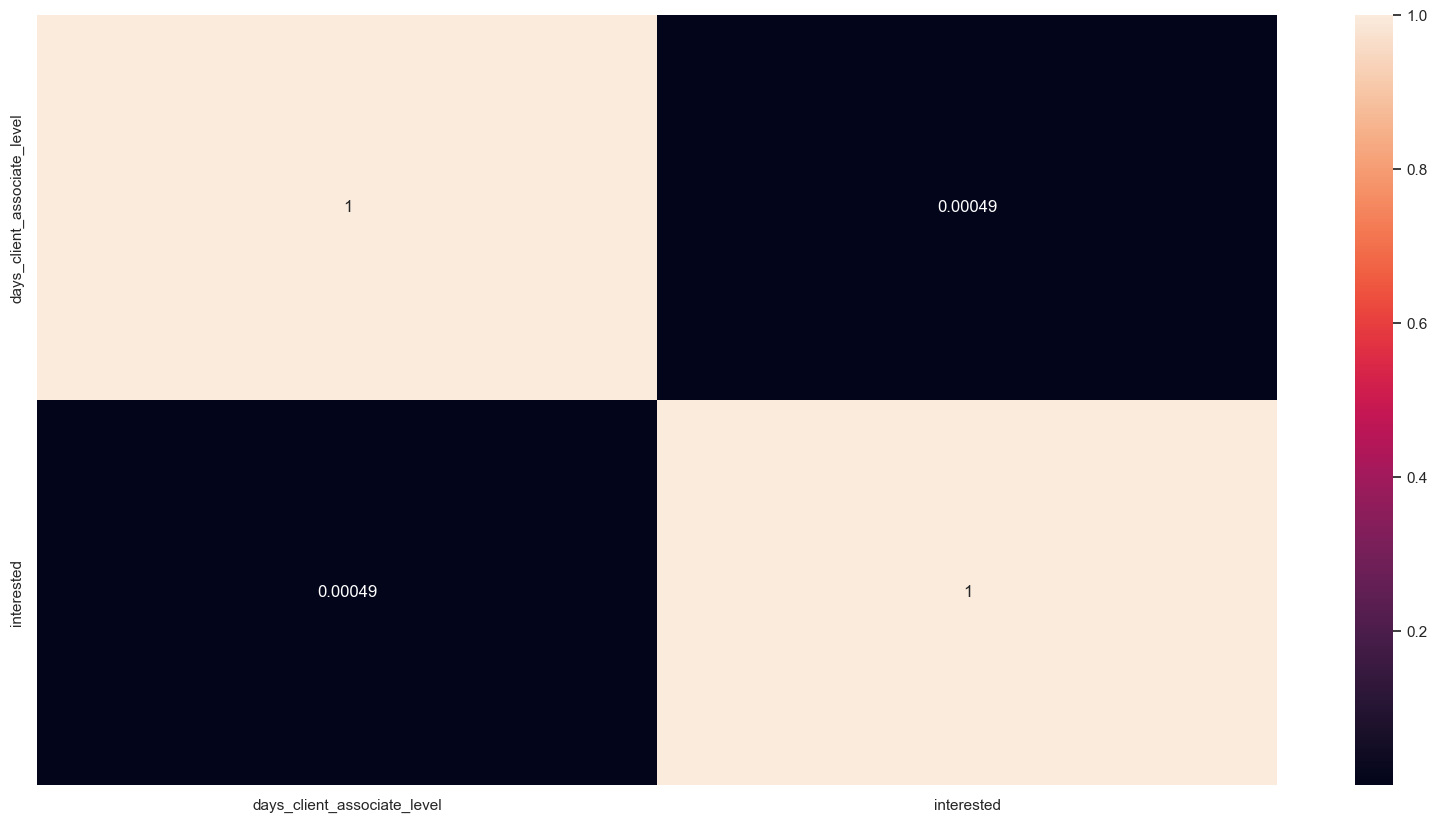

In [45]:
# Calculate cramer V
a1 = cramer_v( df4['days_client_associate_level'], df4['days_client_associate_level'] )
a2 = cramer_v( df4['days_client_associate_level'], df4['interested'] )

a3 = cramer_v( df4['interested'], df4['days_client_associate_level'] )
a4 = cramer_v( df4['interested'], df4['interested'] )


# Final dataset
d = pd.DataFrame( {'days_client_associate_level': [a1, a2],
                   'interested':                  [a3, a4] } )
                   
d = d.set_index( d.columns )

# Mapa de calor
sns.heatmap( d, annot=True );

**Conclusão:**
    
- Fazendo as análises de proporção de interesse e quantidade de clientes pela variável mais granular dias do cliente com a empresa, o comportamento do interesse pelo tempo em que o cliente está com a empresa é bastante aleatório para interessados e não interessados, obviamente possuindo mais não interessados devido a natureza do equilíbrio de classes dos dados. Com isso, a proporção de interesse dos clientes ao longo do tempo também possui um comportamento bastante aleatório com picos de proporção de interesse de clientes em determinados dias específicos ao longo do intervalo de valores. 



- Fazendo as análises de proporção de interesse e quantidade de clientes pela variável agrupada em dias do cliente com a empresa, o interesse pelo tempo agrupado em que o cliente está com a empresa é bastante semelhante para todos os valores. Com isso, não pode-se afirmar que existe uma tendência de maior interesse de clientes que estão a mais tempo com a empresa, pois a proporção de interesse por tempo agrupado é aproximadamente igual a 12% para todos as faixas de tempo analisadas. 


- Correlação muito fraca positiva.

### 4.2.11. Resumo

In [51]:
tab = [["Hipóteses","Conclusão","Relevância"],
       ["H1","Falso","Média"],
       ["H2","Verdadeiro","Baixa"],
       ["H3","Falso","Média Baixa"],
       ["H4","Verdadeiro","Baixa"],
       ["H5","Falso","Média Baixa"],
       ["H6","Falso","Baixa"],
       ["H7","Falso","Média"],
       ["H8","Falso","Média Alta"],
       ["H9","Verdadeiro","Média Alta"],
       ["H10","Falso","Baixa"]]






print( tabulate(tab, headers = 'firstrow') )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falso        Média
H2           Verdadeiro   Baixa
H3           Falso        Média Baixa
H4           Verdadeiro   Baixa
H5           Falso        Média Baixa
H6           Falso        Baixa
H7           Falso        Média
H8           Falso        Média Alta
H9           Verdadeiro   Média Alta
H10          Falso        Baixa


- Faz isso com dataframe no Review Project

## 4.3. Análise Multivariada

Objetivo é enxergar colunas linearmente dependentes por meio da análise de correlação alta (informações parecidas) visando reduzir a dimensionalidade dos dados. 

### 4.3.1. Numerical Attributes 

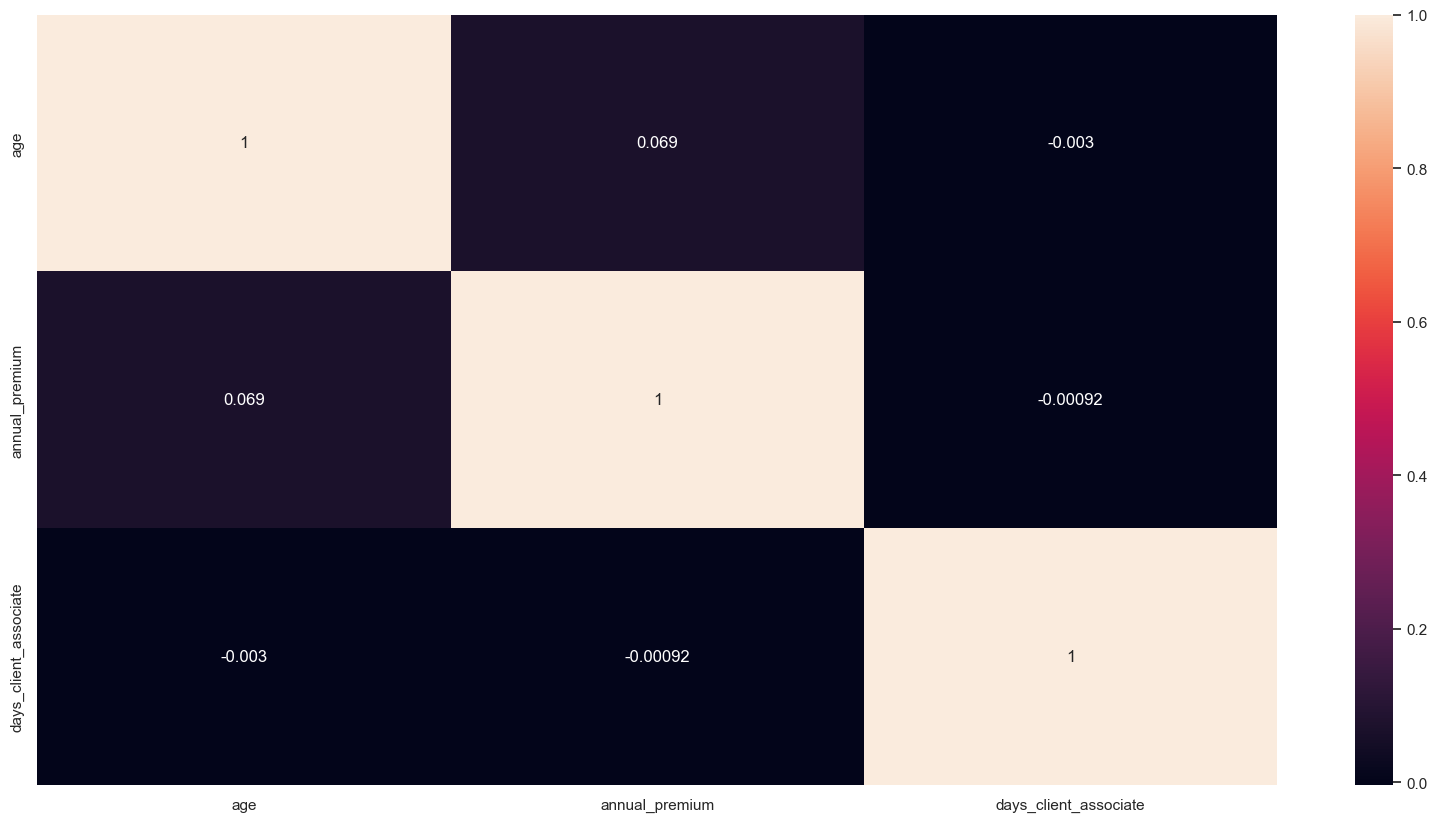

In [53]:
### Correlação entre todas as variáveis - Matriz de correlação multivariada

sns.heatmap( num_attributes_eda.corr(method = 'pearson'), annot = True);

Não possuem variáveis correlacionadas

### 4.3.2. Categorical Attributes 

Daria para ter feito uma função para calcular a Cramer V

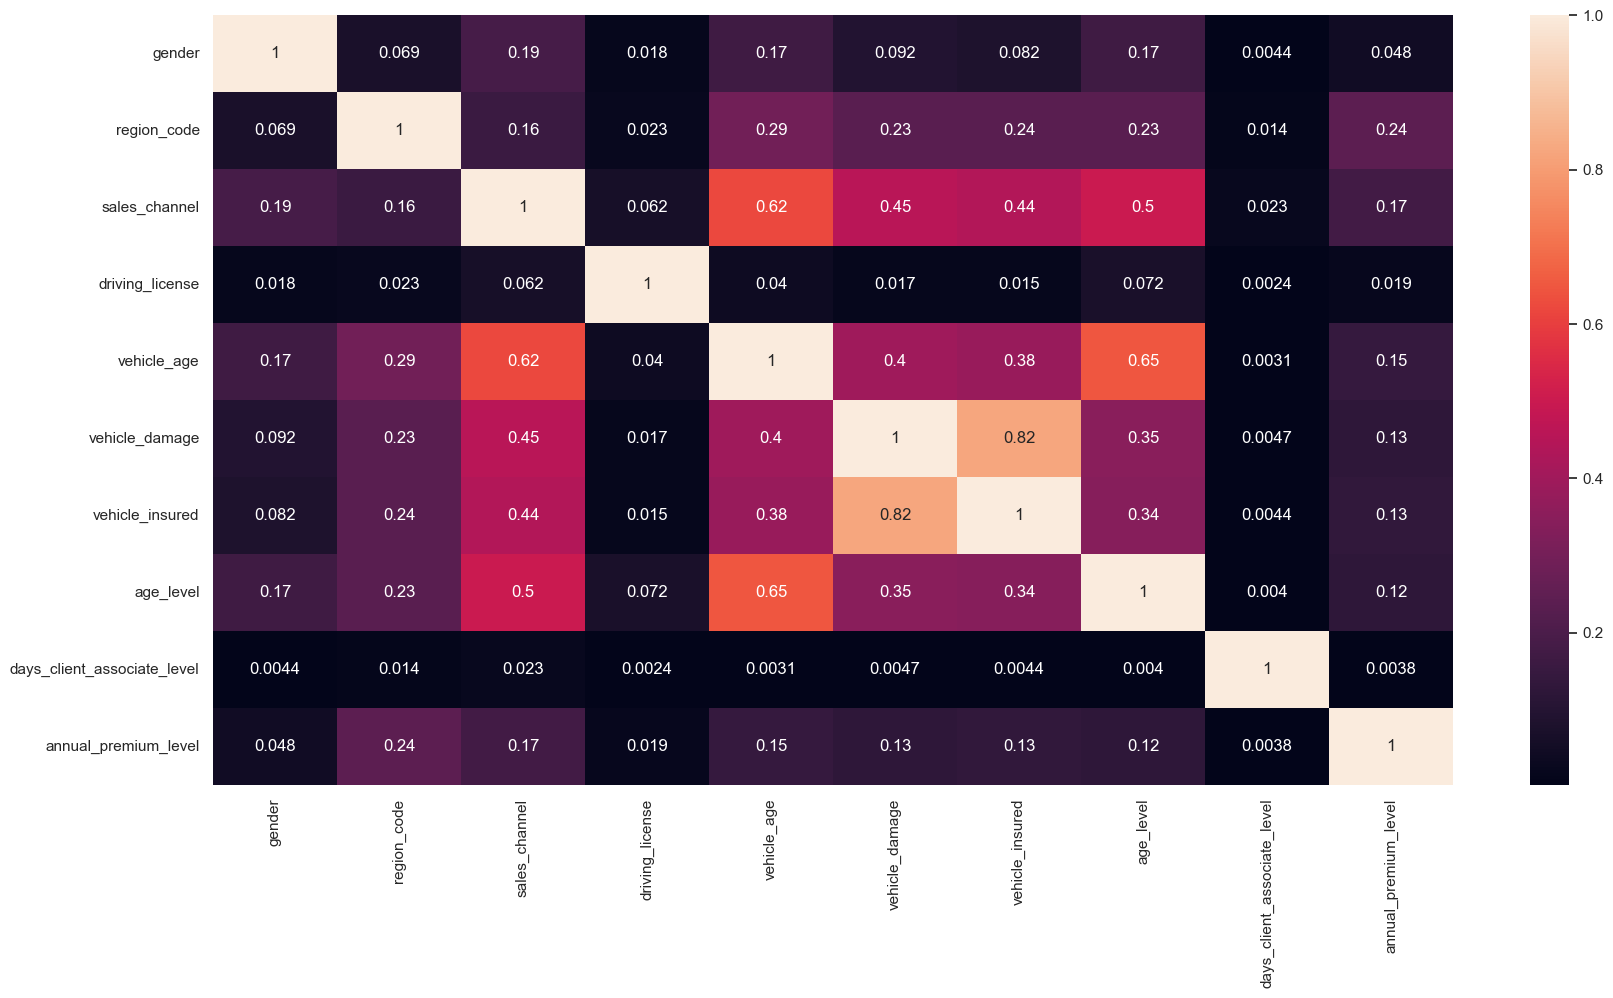

In [54]:
# Calculate cramer V - 


a1 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['gender'] )
a2 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['region_code'] )
a3 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['sales_channel'] )
a4 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['driving_license'] )
a5 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['vehicle_age'] )
a6 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['vehicle_damage'] )
a7 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['vehicle_insured'] )
a8 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['age_level'] )
a9 = cramer_v( cat_attributes_eda['gender'],  cat_attributes_eda['days_client_associate_level'] )
a10 = cramer_v( cat_attributes_eda['gender'], cat_attributes_eda['annual_premium_level'] )

a11 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['gender'] )
a12 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['region_code'] )
a13 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['sales_channel'] )
a14 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['driving_license'] )
a15 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['vehicle_age'] )
a16 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['vehicle_damage'] )
a17 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['vehicle_insured'] )
a18 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['age_level'] )
a19 = cramer_v( cat_attributes_eda['region_code'],  cat_attributes_eda['days_client_associate_level'] )
a20 = cramer_v( cat_attributes_eda['region_code'], cat_attributes_eda['annual_premium_level'] )

a21 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['gender'] )
a22 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['region_code'] )
a23 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['sales_channel'] )
a24 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['driving_license'] )
a25 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['vehicle_age'] )
a26 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['vehicle_damage'] )
a27 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['vehicle_insured'] )
a28 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['age_level'] )
a29 = cramer_v( cat_attributes_eda['sales_channel'],  cat_attributes_eda['days_client_associate_level'] )
a30 = cramer_v( cat_attributes_eda['sales_channel'], cat_attributes_eda['annual_premium_level'] )

a31 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['gender'] )
a32 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['region_code'] )
a33 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['sales_channel'] )
a34 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['driving_license'] )
a35 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['vehicle_age'] )
a36 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['vehicle_damage'] )
a37 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['vehicle_insured'] )
a38 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['age_level'] )
a39 = cramer_v( cat_attributes_eda['driving_license'],  cat_attributes_eda['days_client_associate_level'] )
a40 = cramer_v( cat_attributes_eda['driving_license'], cat_attributes_eda['annual_premium_level'] )

a41 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['gender'] )
a42 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['region_code'] )
a43 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['sales_channel'] )
a44 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['driving_license'] )
a45 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['vehicle_age'] )
a46 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['vehicle_damage'] )
a47 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['vehicle_insured'] )
a48 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['age_level'] )
a49 = cramer_v( cat_attributes_eda['vehicle_age'],  cat_attributes_eda['days_client_associate_level'] )
a50 = cramer_v( cat_attributes_eda['vehicle_age'], cat_attributes_eda['annual_premium_level'] )

a51 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['gender'] )
a52 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['region_code'] )
a53 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['sales_channel'] )
a54 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['driving_license'] )
a55 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['vehicle_age'] )
a56 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['vehicle_damage'] )
a57 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['vehicle_insured'] )
a58 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['age_level'] )
a59 = cramer_v( cat_attributes_eda['vehicle_damage'],  cat_attributes_eda['days_client_associate_level'] )
a60 = cramer_v( cat_attributes_eda['vehicle_damage'], cat_attributes_eda['annual_premium_level'] )

a61 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['gender'] )
a62 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['region_code'] )
a63 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['sales_channel'] )
a64 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['driving_license'] )
a65 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['vehicle_age'] )
a66 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['vehicle_damage'] )
a67 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['vehicle_insured'] )
a68 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['age_level'] )
a69 = cramer_v( cat_attributes_eda['vehicle_insured'],  cat_attributes_eda['days_client_associate_level'] )
a70 = cramer_v( cat_attributes_eda['vehicle_insured'], cat_attributes_eda['annual_premium_level'] )

a71 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['gender'] )
a72 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['region_code'] )
a73 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['sales_channel'] )
a74 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['driving_license'] )
a75 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['vehicle_age'] )
a76 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['vehicle_damage'] )
a77 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['vehicle_insured'] )
a78 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['age_level'] )
a79 = cramer_v( cat_attributes_eda['age_level'],  cat_attributes_eda['days_client_associate_level'] )
a80 = cramer_v( cat_attributes_eda['age_level'], cat_attributes_eda['annual_premium_level'] )

a81 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['gender'] )
a82 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['region_code'] )
a83 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['sales_channel'] )
a84 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['driving_license'] )
a85 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['vehicle_age'] )
a86 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['vehicle_damage'] )
a87 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['vehicle_insured'] )
a88 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['age_level'] )
a89 = cramer_v( cat_attributes_eda['days_client_associate_level'],  cat_attributes_eda['days_client_associate_level'] )
a90 = cramer_v( cat_attributes_eda['days_client_associate_level'], cat_attributes_eda['annual_premium_level'] )

a91 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['gender'] )
a92 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['region_code'] )
a93 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['sales_channel'] )
a94 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['driving_license'] )
a95 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['vehicle_age'] )
a96 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['vehicle_damage'] )
a97 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['vehicle_insured'] )
a98 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['age_level'] )
a99 = cramer_v( cat_attributes_eda['annual_premium_level'],  cat_attributes_eda['days_client_associate_level'] )
a100 = cramer_v( cat_attributes_eda['annual_premium_level'], cat_attributes_eda['annual_premium_level'] )






# Final dataset
d = pd.DataFrame( {'gender':                         [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10],
                   'region_code':                    [a11, a12, a13, a14, a15, a16, a17, a18, a19, a20],   
                   'sales_channel':                  [a21, a22, a23, a24, a25, a26, a27, a28, a29, a30],
                   'driving_license':                [a31, a32, a33, a34, a35, a36, a37, a38, a39, a40],
                   'vehicle_age':                    [a41, a42, a43, a44, a45, a46, a47, a48, a49, a50],
                   'vehicle_damage':                 [a51, a52, a53, a54, a55, a56, a57, a58, a59, a60],
                   'vehicle_insured':                [a61, a62, a63, a64, a65, a66, a67, a68, a69, a70],
                   'age_level':                      [a71, a72, a73, a74, a75, a76, a77, a78, a79, a80],
                   'days_client_associate_level':    [a81, a82, a83, a84, a85, a86, a87, a88, a89, a90],
                   'annual_premium_level':           [a91, a92, a93, a94, a95, a96, a97, a98, a99, a100]    })                                              
                                                                          
                                                                        

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

**Atributos segundo análise V-Cramer com informações semelhantes:**

- vehicle_insured e vehicle damage -> 0,82
- age_level e vehicle_age -> 0,65
- sales_channel e vehicle_age -> 0,62
- age_level e sales_channel -> 0,5
- vehicle_damage e sales_channel -> 0,45
- vehicle_insured e sales_channel -> 0,44
- vehicle_age e vehicle_damage -> 0,4

# 5.0. PREPARAÇÃO DOS DADOS ou MODELAGEM DOS DADOS

Objetivo é modelar os dados para numéricos, e em mesma escala para que o aprendizado dos algoritmos seja facilitado respeitando suas premissas. 

In [17]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df_train = df4.copy()

In [20]:
df_train.dtypes

id                               int64
gender                          object
age                              int64
region_code                      int64
sales_channel                    int64
driving_license                 object
vehicle_age                     object
vehicle_damage                  object
vehicle_insured                 object
annual_premium                 float64
days_client_associate            int64
interested                      object
age_level                       object
days_client_associate_level     object
annual_premium_level            object
dtype: object

In [21]:
df_train

id     gender  age  region_code  sales_channel  driving_license       vehicle_age      vehicle_damage    vehicle_insured  annual_premium  days_client_associate       interested age_level days_client_associate_level annual_premium_level
0       274711  Masculino   22           40            152  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro         25455.0                    203  Não interessado     20-30                     201-299          25001-30000
1       216540   Feminino   26            8             26  Possui carteira    Menos de 1 ano  Não foi danificado   Já possui seguro         38393.0                     45  Não interessado     20-30                      10-100          35001-40000
2        78984   Feminino   32           28            122  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro         32118.0                     35      Interessado     31-40                      10-100          30001-35000
3       218369  Masculino   32           37            152  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro         37711.0                    215  Não interessado     31-40                     201-299          35001-40000
4       307216   Feminino   24           28            156  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro         48706.0                    222  Não interessado     20-30                     201-299          40001-60000
...        ...        ...  ...          ...            ...              ...               ...                 ...                ...             ...                    ...              ...       ...                         ...                  ...
304882  378817  Masculino   25           47            160  Possui carteira    Menos de 1 ano      Foi danificado   Já possui seguro         23010.0                     58  Não interessado     20-30                      10-100          20001-25000
304883   67727  Masculino   69           28             26  Possui carteira  Entre 1 e 2 anos      Foi danificado  Não possui seguro         31630.0                    290      Interessado     51-85                     201-299          30001-35000
304884   91745  Masculino   24           28            152  Possui carteira    Menos de 1 ano  Não foi danificado  Não possui seguro         59094.0                     62  Não interessado     20-30                      10-100          40001-60000
304885   48701   Feminino   40            8             26  Possui carteira  Entre 1 e 2 anos  Não foi danificado   Já possui seguro         28940.0                    262  Não interessado     31-40                     201-299          25001-30000
304886  221792  Masculino   24           15            152  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro         28482.0                    256  Não interessado     20-30                     201-299          25001-30000

[304887 rows x 15 columns]

## 5.1. Normalização

Avaliar quais variáveis devem ser normalizadas, aquelas que possuem distribuição próxima da normal.

In [18]:
## days_client_associate 

## instanciar a classe 
ss = StandardScaler()

# Ajustar o método aos dados e já transformar nos dados de treino
df_train["days_client_associate"] = ss.fit_transform( df_train[["days_client_associate"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de validação e teste em produção
#pickle.dump(ss, open('../parameters/days_client_associate_scaler.pkl', 'wb'))
# Transformar nos dados de teste
df_test["days_client_associate"] = ss.transform( df_test[["days_client_associate"]].values )

Meigarom utilizou-se essa variável como MinMaxScaler

## 5.2. Rescaling

Avaliar quais variáveis devem ser normalizadas, aquelas que possuem distribuição não normal.

### 5.2.1. Análise de Outliers dados de treino

Avaliando a existência de outliers nos atributos dos dados de treino para decidir entre Min-Max e Robust

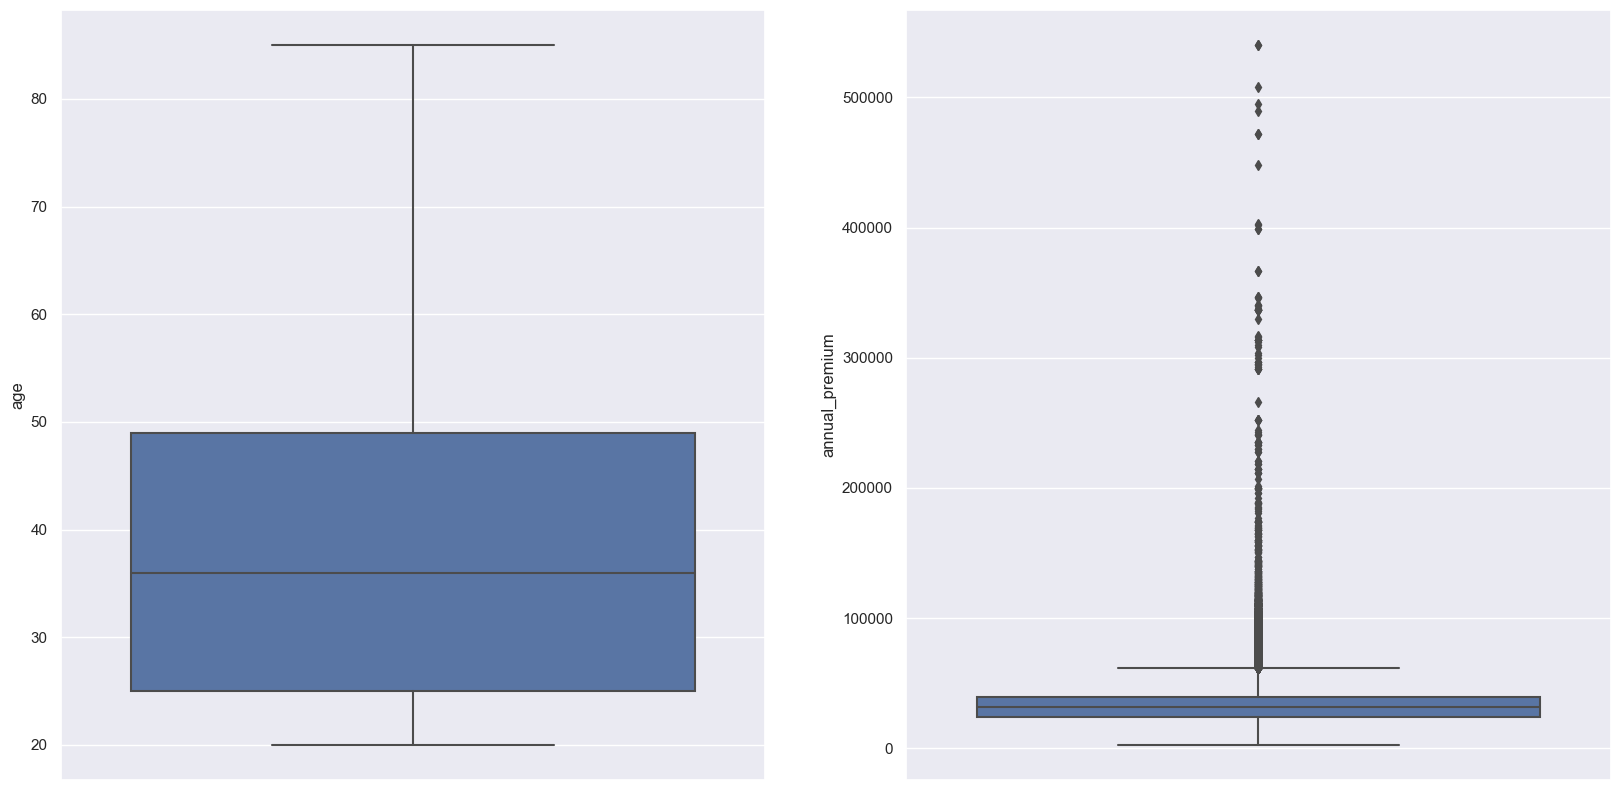

In [20]:
# age
plt.subplot(1,2,1)
sns.boxplot(data = df_train , y = 'age' );

# age
plt.subplot(1,2,2)
sns.boxplot(data = df_train , y = 'annual_premium' );

**Análise:** 

*age:* Não possui valores outliers, nem o range do atributo é muito elevado. Sendo assim, decisão usar MinMaxScaler.

*annual_premium:* É verificado a existência de inúmeros outliers, além do range do atributo que é bastante elevado. Decisão usar Robust Scaler.



### 5.2.2. Aplicando o Rescaling

In [19]:
## instanciar as classes 
rs = RobustScaler()
mms = MinMaxScaler()



## age 

## Ajuste e transformação dos dados de treino 
df_train['age'] = mms.fit_transform( df_train[['age']].values )

## # Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de validação e teste em produção
#pickle.dump(mms, open('../parameters/age_scaler.pkl', 'wb'))

## Transformação nos dados de teste 
df_test['age'] = mms.transform( df_test[['age']].values )


## annual_premium 

## Ajuste e transformação dos dados de treino 
df_train['annual_premium'] = rs.fit_transform( df_train[['annual_premium']].values )

## # Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de validação e teste em produção
#pickle.dump(rs, open('../parameters/annual_premium_scaler.pkl', 'wb'))

## Transformação nos dados de teste 
df_test['annual_premium'] = rs.transform( df_test[['annual_premium']].values )

Meigarom aplicou mms no age semelhante a mim e o annual premium aplicou um StandardScaler

### 5.2.3. Distribuição atributos treino após Rescaling

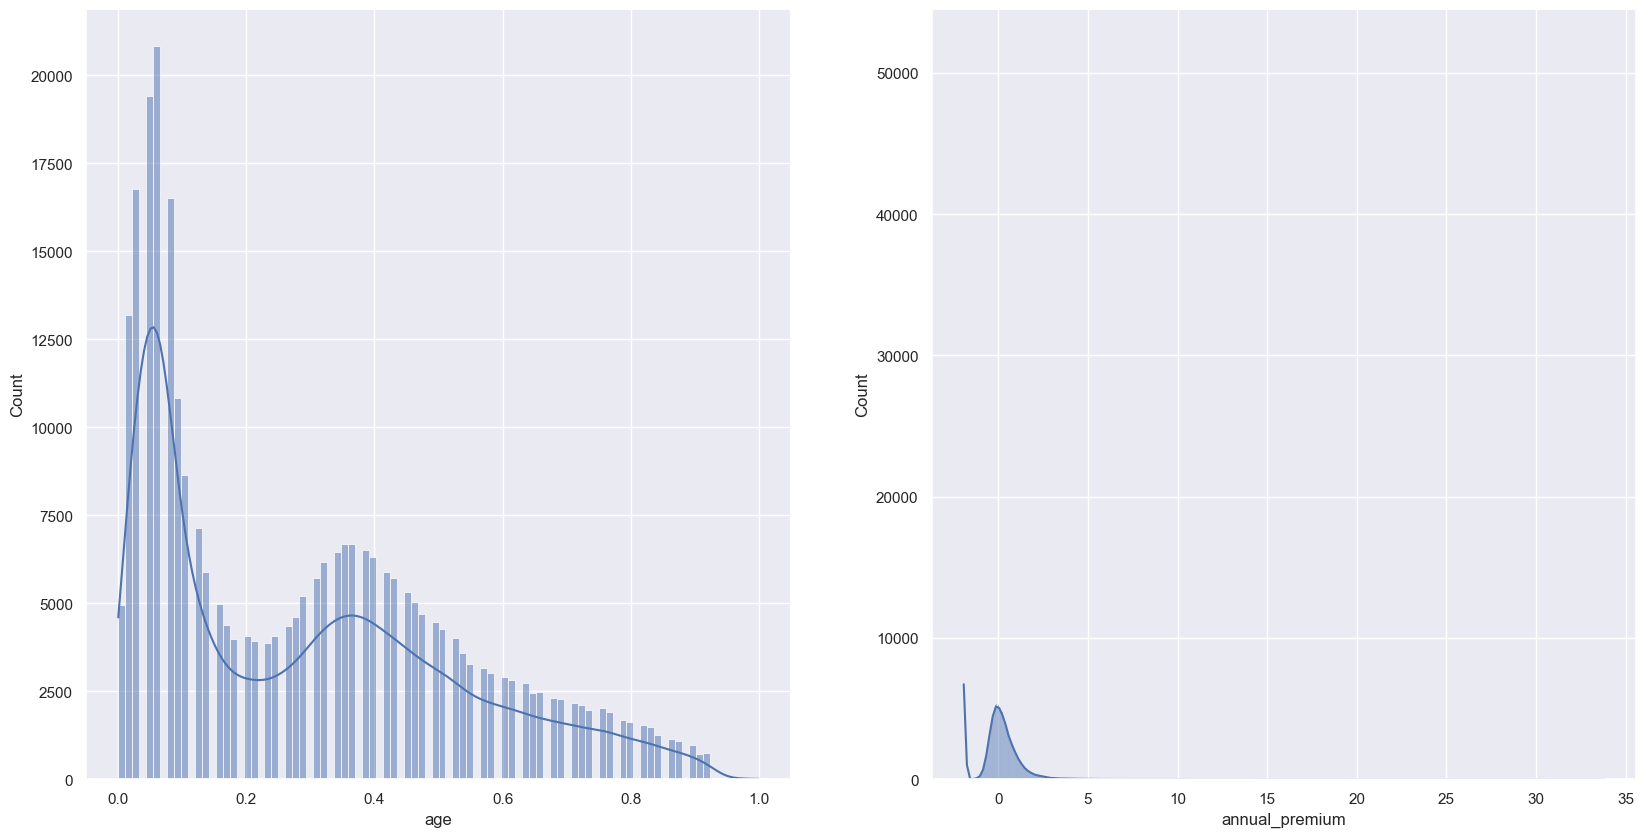

In [22]:
plt.subplot(1,2,1)
sns.histplot(df_train['age'], kde = True);

plt.subplot(1,2,2)
sns.histplot(df_train['annual_premium'], kde = True);

## 5.3. Transformação 

Visa transformar as variáveis de categóricas para numéricas e adequar outras numéricas para que o algoritmo possa entender sua natureza.

### 5.3.1. Response Variable Transformation

In [20]:
# interested               

inte_dict = {'Interessado': 1 , 'Não interessado': 0}

# treino
df_train['interested'] = df_train['interested'].map( inte_dict )      

# teste
df_test['interested'] = df_test['interested'].map( inte_dict ) 

### 5.3.2. Encoding

Variáveis categóricas -> Variáveis Numéricas

In [12]:
df_train

id     gender       age  region_code  sales_channel  driving_license       vehicle_age      vehicle_damage    vehicle_insured  annual_premium  days_client_associate       interested age_level days_client_associate_level annual_premium_level
0       274711  Masculino  0.030769           40            152  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro       -0.415027               0.580945  Não interessado     20-30                     201-299          25001-30000
1       216540   Feminino  0.092308            8             26  Possui carteira    Menos de 1 ano  Não foi danificado   Já possui seguro        0.445213              -1.307422  Não interessado     20-30                      10-100          35001-40000
2        78984   Feminino  0.184615           28            122  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro        0.027992              -1.426939      Interessado     31-40                      10-100          30001-35000
3       218369  Masculino  0.184615           37            152  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro        0.399867               0.724365  Não interessado     31-40                     201-299          35001-40000
4       307216   Feminino  0.061538           28            156  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro        1.130918               0.808027  Não interessado     20-30                     201-299          40001-60000
...        ...        ...       ...          ...            ...              ...               ...                 ...                ...             ...                    ...              ...       ...                         ...                  ...
304882  378817  Masculino  0.076923           47            160  Possui carteira    Menos de 1 ano      Foi danificado   Já possui seguro       -0.577593              -1.152050  Não interessado     20-30                      10-100          20001-25000
304883   67727  Masculino  0.753846           28             26  Possui carteira  Entre 1 e 2 anos      Foi danificado  Não possui seguro       -0.004455               1.620742      Interessado     51-85                     201-299          30001-35000
304884   91745  Masculino  0.061538           28            152  Possui carteira    Menos de 1 ano  Não foi danificado  Não possui seguro        1.821609              -1.104243  Não interessado     20-30                      10-100          40001-60000
304885   48701   Feminino  0.307692            8             26  Possui carteira  Entre 1 e 2 anos  Não foi danificado   Já possui seguro       -0.183311               1.286095  Não interessado     31-40                     201-299          25001-30000
304886  221792  Masculino  0.061538           15            152  Possui carteira    Menos de 1 ano      Foi danificado  Não possui seguro       -0.213763               1.214385  Não interessado     20-30                     201-299          25001-30000

[304887 rows x 15 columns]

In [ ]:
## Possibilidades 

## One-Hot Encoding, Frequency Encoding, Target Encoding, Weighted Target Encoding, Label Encoding, Ordinal Encoding

In [ ]:
# Variáveis Nominais:

# gender                          [Masculino, Feminino]  - One-Hot-Encoding
# region_code                    [40, 8, 28, 37, 1, 12, 13, 6, 50, 43, 25, 48, ... - Frequency Encoding, Target Encoding, Weighted Target Encoding
# sales_channel                  [152, 26, 122, 156, 13, 151, 160, 124, 8, 15, ... - Frequency Encoding, Target Encoding
# driving_license                                  [Possui carteira, Sem carteira] - One-Hot-Encoding
#vehicle_damage                              [Foi danificado, Não foi danificado] - One-Hot-Encoding
#vehicle_insured                            [Não possui seguro, Já possui seguro] - One-Hot-Encoding

                                
# Variáveis Ordinais:

# vehicle_age                    [Menos de 1 ano, Entre 1 e 2 anos, Mais de 2 a... - One Hot Encoding, Ordinal encoding, Label encoding, Frequency Encoding
# age_level                                           [20-30, 31-40, 41-50, 51-85] - Ordinal encoding
# days_client_associate_level                           [201-299, 10-100, 101-200] - Ordinal encoding
# annual_premium_level                                [25001-30000, 35001-40000, 30001-35000, 40001-... - Ordinal encoding

In [21]:
# # Variáveis Ordinais:


########### vehicle_age - Ordinal Encoding             

vehicle_age_dict = {'Menos de 1 ano': 0 , 'Entre 1 e 2 anos': 1, 'Mais de 2 anos': 2}

# treino
df_train['vehicle_age'] = df_train['vehicle_age'].map( vehicle_age_dict )
# teste
df_test['vehicle_age'] = df_test['vehicle_age'].map( vehicle_age_dict )

########## age_level - Ordinal Encoding 

age_level_dict = {'20-30': 0 , '31-40': 1, '41-50': 2, '51-85': 3}

# treino
df_train['age_level'] = df_train['age_level'].map( age_level_dict )
# teste
df_test['age_level'] = df_test['age_level'].map( age_level_dict )

######### days_client_associate_level - Ordinal Encoding 

dcal_dict = {'10-100': 0 , '101-200': 1, '201-299' : 2}

# treino
df_train['days_client_associate_level'] = df_train['days_client_associate_level'].map( dcal_dict )
# teste
df_test['days_client_associate_level'] = df_test['days_client_associate_level'].map( dcal_dict )

######### annual_premium_level - Ordinal Encoding 

apl_dict = {'0-20000': 0 , '20001-25000': 1, '25001-30000': 2, '30001-35000': 3,'35001-40000': 4, '40001-60000': 5, '60001-540165': 6}

# treino
df_train['annual_premium_level'] = df_train['annual_premium_level'].map( apl_dict )
# teste
df_test['annual_premium_level'] = df_test['annual_premium_level'].map( apl_dict )


# Variáveis Nominais:

######### region_code e sales_channel - Target Encoding

## transformando em object 
df_train[['region_code', 'sales_channel']] = df_train[['region_code', 'sales_channel']].astype("object")
df_test[['region_code', 'sales_channel']] = df_test[['region_code', 'sales_channel']].astype("object")


## instanciando a classe 
te = TargetEncoder(cols=['region_code', 'sales_channel'], smoothing=0)

# aplicando manualmente o Target Encoding
# te_region = df_train[['region_code', 'interested']].groupby('region_code').mean()
# df_train['region_code'] = df_train['region_code'].map(te_region)

## Ajustando conforme variável resposta e transformando
df_train = te.fit_transform(df_train, y= df_train['interested'],)

#Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste em produção
#pickle.dump(te, open('../parameters/region_code_sales_channel_target.pkl', 'wb'))

## Transformando nos dados de teste 
df_test = te.transform(df_test)



############ 'driving_license', 'vehicle_damage', 'vehicle_insured', 'gender' - One Hot Encoding                             


# arrumar nome das categorias, tirar espaços

# driving_license
df_train.replace( {'driving_license': {'Possui carteira': 'yes','Sem carteira': 'no'} }, inplace = True )  

df_test.replace( {'driving_license': {'Possui carteira': 'yes','Sem carteira': 'no'} }, inplace = True ) 

# vehicle_damage
df_train.replace( {'vehicle_damage': {'Foi danificado': 'yes','Não foi danificado': 'no'} }, inplace = True )

df_test.replace( {'vehicle_damage': {'Foi danificado': 'yes','Não foi danificado': 'no'} }, inplace = True )

# vehicle_insured
df_train.replace( {'vehicle_insured': {'Já possui seguro': 'yes','Não possui seguro': 'no'} }, inplace = True ) 

df_test.replace( {'vehicle_insured': {'Já possui seguro': 'yes','Não possui seguro': 'no'} }, inplace = True ) 


colunas_categoricas = ['driving_license', 'vehicle_damage', 'vehicle_insured', 'gender']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    colunas_categoricas),
    remainder='passthrough')

## Ajuste nos dados de treino e transformação 
df_train = one_hot_enc.fit_transform(df_train)

# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste em produção
pickle.dump(one_hot_enc, open('../parameters/features_one_hot.pkl', 'wb'))

# TREINO
df_train = pd.DataFrame(df_train, columns=one_hot_enc.get_feature_names_out())

# Transformação nos dados de TESTE
df_test = one_hot_enc.transform(df_test)
df_test = pd.DataFrame(df_test, columns=one_hot_enc.get_feature_names_out())

C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [14]:
df_train

onehotencoder__driving_license_no  onehotencoder__driving_license_yes  onehotencoder__vehicle_damage_no  onehotencoder__vehicle_damage_yes  onehotencoder__vehicle_insured_no  onehotencoder__vehicle_insured_yes  onehotencoder__gender_Feminino  onehotencoder__gender_Masculino  remainder__id  remainder__age  remainder__region_code  remainder__sales_channel  remainder__vehicle_age  remainder__annual_premium  remainder__days_client_associate  remainder__interested  remainder__age_level  remainder__days_client_associate_level  remainder__annual_premium_level
0                                     0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             0.0                              1.0       274711.0        0.030769                0.117421                  0.028815                     0.0                  -0.415027                          0.580945                    0.0                   0.0                                     2.0                              2.0
1                                     0.0                                 1.0                               1.0                                0.0                                0.0                                 1.0                             1.0                              0.0       216540.0        0.092308                0.095217                  0.199689                     0.0                   0.445213                         -1.307422                    0.0                   0.0                                     0.0                              4.0
2                                     0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             1.0                              0.0        78984.0        0.184615                0.187042                  0.173815                     0.0                   0.027992                         -1.426939                    1.0                   1.0                                     0.0                              3.0
3                                     0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             0.0                              1.0       218369.0        0.184615                0.077466                  0.028815                     0.0                   0.399867                          0.724365                    0.0                   1.0                                     2.0                              4.0
4                                     0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             1.0                              0.0       307216.0        0.061538                0.187042                  0.212110                     0.0                   1.130918                          0.808027                    0.0                   0.0                                     2.0                              5.0
...                                   ...                                 ...                               ...                                ...                                ...                                 ...                             ...                              ...            ...             ...                     ...                       ...                     ...                        ...                               ...                    ...                   ...                                     ...                              ...
304882                                0

In [15]:
df_test

onehotencoder__driving_license_no  onehotencoder__driving_license_yes  onehotencoder__vehicle_damage_no  onehotencoder__vehicle_damage_yes  onehotencoder__vehicle_insured_no  onehotencoder__vehicle_insured_yes  onehotencoder__gender_Feminino  onehotencoder__gender_Masculino  remainder__id  remainder__age  remainder__region_code  remainder__sales_channel  remainder__vehicle_age  remainder__annual_premium  remainder__days_client_associate  remainder__interested  remainder__age_level  remainder__days_client_associate_level  remainder__annual_premium_level
0                                    0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             0.0                              1.0        16222.0        0.523077                0.187042                  0.199689                     2.0                   2.893750                         -1.211808                    1.0                   3.0                                     0.0                              6.0
1                                    0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             1.0                              0.0       342481.0        0.092308                0.127951                  0.212110                     1.0                  -0.795146                          1.501225                    0.0                   0.0                                     2.0                              0.0
2                                    0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             0.0                              1.0        20916.0        0.076923                0.187042                  0.189079                     0.0                   1.983178                          1.202433                    0.0                   0.0                                     2.0                              6.0
3                                    0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             0.0                              1.0        38704.0        0.138462                0.138790                  0.268659                     1.0                  -1.932646                          0.963399                    1.0                   0.0                                     2.0                              0.0
4                                    0.0                                 1.0                               0.0                                1.0                                1.0                                 0.0                             1.0                              0.0       363809.0        0.123077                0.187042                  0.199689                     0.0                   1.314894                          1.059013                    1.0                   0.0                                     2.0                              5.0
...                                  ...                                 ...                               ...                                ...                                ...                                 ...                             ...                              ...            ...             ...                     ...                       ...                     ...                        ...                               ...                    ...                   ...                                     ...                              ...
76217                                0.0     

- Aumentou 4 colunas devido a utilização de One-Hot-Encoding

# 6.0. SELEÇÃO DE ATRIBUTOS 

In [86]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df6 = df5.copy()

In [87]:
df6.head()

id  age  region_code  sales_channel  vehicle_age  annual_premium  days_client_associate  interested  age_level  days_client_associate_level  annual_premium_level  driving_license_no  driving_license_yes  vehicle_damage_no  vehicle_damage_yes  vehicle_insured_no  vehicle_insured_yes  gender_Feminino  gender_Masculino
0  274711 0.03         0.12           0.03            0           -0.42                   0.58           0          0                            2                     2                0.00                 1.00               0.00                1.00                1.00                 0.00             0.00              1.00
1  216540 0.09         0.10           0.20            0            0.45                  -1.31           0          0                            0                     4                0.00                 1.00               1.00                0.00                0.00                 1.00             1.00              0.00
2   78984 0.18         0.19           0.17            0            0.03                  -1.43           1          1                            0                     3                0.00                 1.00               0.00                1.00                1.00                 0.00             1.00              0.00
3  218369 0.18         0.08           0.03            0            0.40                   0.72           0          1                            2                     4                0.00                 1.00               0.00                1.00                1.00                 0.00             0.00              1.00
4  307216 0.06         0.19           0.21            0            1.13                   0.81           0          0                            2                     5                0.00                 1.00               0.00                1.00                1.00                 0.00             1.00              0.00

## 6.1. Split dataframe into training and validation dataset  

In [134]:
X = df6.drop(['interested'], axis = 1).copy()
Y = df6['interested'].copy() # var. resposta

x_train, x_val, y_train, y_val = train_test_split(X, Y,
                                                    test_size=0.15,
                                                    random_state= 42,
                                                    stratify=Y)

In [135]:
## Porcentagem de valores da variável target em cada separação de dados

print(f"Treino: \n {y_train.value_counts(normalize = True)} \n")
print(f"Total: {y_train.count()} \n")
print(f"Validação: \n {y_val.value_counts(normalize = True)} \n")
print(f"Total: {y_val.count()}")

Treino: 
 0   0.88
1   0.12
Name: interested, dtype: float64 

Total: 259153 

Validação: 
 0   0.88
1   0.12
Name: interested, dtype: float64 

Total: 45734


In [ ]:
# 259153 -> 85% (Dados de Treino) e 45734 -> 15% (Dados de Validação)

In [136]:
## Conjunto de dados de treino o qual treinará o modelo 

df_train = pd.concat([x_train,y_train], axis = 1).reset_index(drop = True)

## Conjunto de dados de validação o qual irá avaliar a capacidade de aprendizado do modelo

df_val = pd.concat([x_val,y_val], axis = 1).reset_index(drop = True)

In [137]:
# Export/save dataframes into .csv

# df_train.to_csv('../data/train_split_val.csv', index = False)
# df_val.to_csv('../data/val.csv', index = False)

## 6.2. Random Forest Classifier features importance  

In [146]:
# instanciar classe que irá selecionar as features mais importantes de acordo com o modelo Random Forest
sel = SelectFromModel(RandomForestClassifier(random_state = 42, n_jobs = - 1))

# treinar com dados para ajustar o algoritmo
sel.fit(x_train.drop( ['id'], axis=1 ), y_train)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=-1, random_state=42))

In [147]:
# Visualizar as features mais importantes com o método get_support do modelo treinado

feat_sel = sel.get_support().tolist()

In [148]:
## as colunas mais relevantes

imp = x_train.drop( ['id'], axis=1 ).loc[:, feat_sel]

cols_selected = imp.columns.tolist()

cols_selected

['age',
 'region_code',
 'sales_channel',
 'annual_premium',
 'days_client_associate']

In [149]:
## Colunas não selecionadas 
cols_not_selected = list( np.setdiff1d( x_train.drop( ['id'], axis=1 ).columns, cols_selected ) )
cols_not_selected

['age_level',
 'annual_premium_level',
 'days_client_associate_level',
 'driving_license_no',
 'driving_license_yes',
 'gender_Feminino',
 'gender_Masculino',
 'vehicle_age',
 'vehicle_damage_no',
 'vehicle_damage_yes',
 'vehicle_insured_no',
 'vehicle_insured_yes']

In [150]:
rfc = RandomForestClassifier(random_state = 42, n_jobs = - 1)

rfc.fit(x_train.drop( ['id'], axis=1 ), y_train)

df_imp = pd.DataFrame({'Features': x_train.drop( ['id'], axis=1 ).columns, 
                       'Importance': rfc.feature_importances_ })

df_imp.sort_values(by = 'Importance', ascending = False)

Features  Importance
5         days_client_associate        0.25
4                annual_premium        0.21
0                           age        0.13
1                   region_code        0.11
2                 sales_channel        0.08
12           vehicle_damage_yes        0.05
11            vehicle_damage_no        0.03
8          annual_premium_level        0.03
13           vehicle_insured_no        0.03
14          vehicle_insured_yes        0.02
7   days_client_associate_level        0.02
3                   vehicle_age        0.02
6                     age_level        0.01
16             gender_Masculino        0.01
15              gender_Feminino        0.01
10          driving_license_yes        0.00
9            driving_license_no        0.00

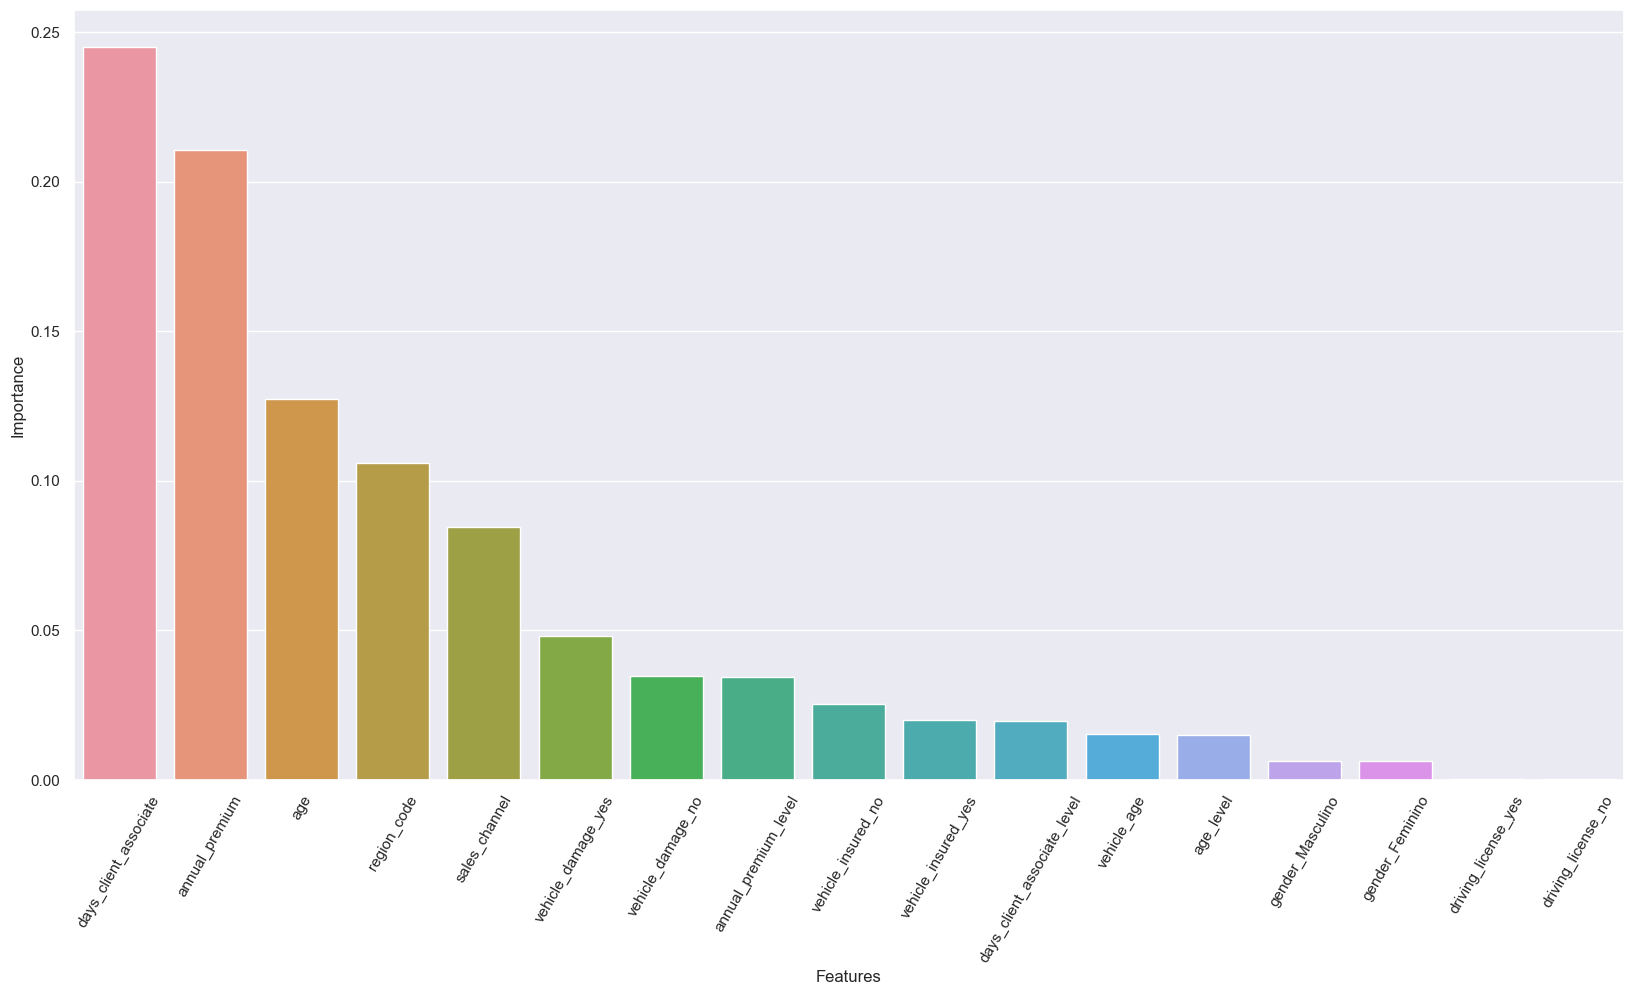

In [151]:
sns.barplot(x = 'Features', y = 'Importance' , data =  df_imp.sort_values(by = 'Importance', ascending = False));
plt.xticks(rotation = 60);

**Sugestão de implementação:** Colocar outra forma de calcular as features importances.

## 6.3. Boruta as Feature Selector  

In [152]:
## training dataset final for Boruta
## Boruta aceita apenas Numpy, então por isso, .values
## ravel() coloca a variável resposta em vetor

X_train_n = x_train.drop( ['id'], axis=1 ).values
y_train_n = y_train.values.ravel()

## define RandomForestRegressor
##  n_jobs=-1 usa os core da máquina e fazer processamento em paralelo para ir mais rápido
rf = RandomForestClassifier( n_jobs=-1 )


## define Boruta 
## verbose é pra enxergar a evolução do processo de análise de seleção de features
## random_state é para selecionar aleatoriamente partindo de um mesmo ponto sempre

boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	17


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	17


## 6.3. Best Features from Boruta  

In [153]:
## vetor True or False com  colunas selecionadas segundo o Boruta 
cols_selected = boruta.support_.tolist()

## as colunas mais relevantes segundo boruta
cols_selected_boruta = x_train.drop( ['id'], axis=1 ).loc[:, cols_selected].columns

## Colunas não selecionadas pelo boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train.drop( ['id'], axis=1 ).columns, cols_selected_boruta ) )

In [154]:
cols_selected_boruta.tolist()

[]

In [155]:
cols_not_selected_boruta


['age',
 'age_level',
 'annual_premium',
 'annual_premium_level',
 'days_client_associate',
 'days_client_associate_level',
 'driving_license_no',
 'driving_license_yes',
 'gender_Feminino',
 'gender_Masculino',
 'region_code',
 'sales_channel',
 'vehicle_age',
 'vehicle_damage_no',
 'vehicle_damage_yes',
 'vehicle_insured_no',
 'vehicle_insured_yes']

In [ ]:
## Variáveis apontadas como mais relevantes na EDA e a checagem com Boruta:

## year nao
## assortment sim
## competition_time_month sim
## state_holiday nao
## month sim
## promo sim

## 6.4. Manual Feature Selection  

Seleção Final contemplando as colunas relevantes apontada pelas técnicas de feature selection e pela análise exploratória de dados e escolha manual.

In [158]:
tab = [["Hipóteses","Relevância EDA", "Relevância Boruta", "Relevância Feature Imp."],
       ["age","Média", "Baixa", "Alta"],
       ["gender","Baixa", "Baixa", "Baixa"],
       ["region_code","Média Baixa", "Baixa", "Média"],
       ["driving_license","Baixa", "Baixa", "Baixa"],
       ["sales_channel","Média Baixa", "Baixa", "Média"],
       ["annual_premium","Baixa", "Baixa", "Alta"],
       ["vehicle_age","Média", "Baixa", "Baixa"],
       ["vehicle_damage","Média Alta", "Baixa", "Baixa"],
       ["vehicle_insured","Média Alta", "Baixa", "Baixa"],
       ["days_client_associate","Baixa", "Baixa", "Alta"]]



print( tabulate(tab, headers = 'firstrow') )

Hipóteses              Relevância EDA    Relevância Boruta    Relevância Feature Imp.
---------------------  ----------------  -------------------  -------------------------
age                    Média             Baixa                Alta
gender                 Baixa             Baixa                Baixa
region_code            Média Baixa       Baixa                Média
driving_license        Baixa             Baixa                Baixa
sales_channel          Média Baixa       Baixa                Média
annual_premium         Baixa             Baixa                Alta
vehicle_age            Média             Baixa                Baixa
vehicle_damage         Média Alta        Baixa                Baixa
vehicle_insured        Média Alta        Baixa                Baixa
days_client_associate  Baixa             Baixa                Alta


In [ ]:
cols_selected = ['age',
                 'age_level',
                 'annual_premium',
                 'annual_premium_level',
                 'days_client_associate',
                 'days_client_associate_level',
                 'driving_license_no',
                 'driving_license_yes',
                 'region_code',
                 'sales_channel',
                 'vehicle_age',
                 'vehicle_damage_no',
                 'vehicle_damage_yes',
                 'vehicle_insured_no',
                 'vehicle_insured_yes']

In [22]:
cols_selected = ['remainder__age',
                 'remainder__age_level',
                 'remainder__annual_premium',
                 'remainder__annual_premium_level',
                 'remainder__days_client_associate',
                 'remainder__days_client_associate_level',
                 'onehotencoder__driving_license_no',
                 'onehotencoder__driving_license_yes',
                 'remainder__region_code',
                 'remainder__sales_channel',
                 'remainder__vehicle_age',
                 'onehotencoder__vehicle_damage_no',
                 'onehotencoder__vehicle_damage_yes',
                 'onehotencoder__vehicle_insured_no',
                 'onehotencoder__vehicle_insured_yes']

In [157]:
cols_selected

['age',
 'age_level',
 'annual_premium',
 'annual_premium_level',
 'days_client_associate',
 'days_client_associate_level',
 'driving_license_no',
 'driving_license_yes',
 'region_code',
 'sales_channel',
 'vehicle_age',
 'vehicle_damage_no',
 'vehicle_damage_yes',
 'vehicle_insured_no',
 'vehicle_insured_yes']

# 7.0. MODELOS DE MACHINE LEARNING 

Aplicar modelos com objetivo de ordenar a lista da melhor forma que consiga com menos pessoas englobar mais interessados

## 7.1. Validation and Hyperparameter Fine Tuning

In [4]:
### Importar train and val de arquivo .csv que serão usados para validação direta e cruzada 

# x_train = pd.read_csv('../data/train_split_val.csv')
# x_val = pd.read_csv('../data/val.csv')

# y_train = x_train['interested'].copy()
# y_val = x_val['interested'].copy()

In [12]:
# x_val.shape

(45734, 19)

In [19]:
# ## Para treinar modelos sem cross validation apenas com uma parte de validação selecionada

# ## Selecionar apenas as colunas com maior importância sem as colunas interested e id
# x_train_one_k = x_train[ cols_selected ].copy()
# x_val_one_k = x_val[ cols_selected ].copy()

### 7.1.1. KNN 

#### 7.1.1.1. Validation one K-Fold

In [20]:
# model definition

knn = KNeighborsClassifier()

# model fit 

knn.fit(x_train_one_k, y_train)

# model predict - Capacidade de aprendizado do modelo

yhat_knn = knn.predict_proba(x_val_one_k)


In [60]:
k = [10000, 20000, 30000]


result_knn = ml_performance( x_val, yhat_knn, k )
result_knn

rank  precision_at_k  recall_at_k  F1_at_k
9999   10000            0.29         0.52     0.37
19999  20000            0.23         0.81     0.36
29999  30000            0.17         0.89     0.28

In [46]:
## Código Original para avaliar listas ordenadas com id

# m = x_val[['interested', 'id']].copy()
# m["prop_score"] = yhat_knn[ : , 1 ].tolist()
# m = m.sort_values( by = 'prop_score', ascending = False ).reset_index(drop = True)
# m["rank"] = m.index + 1 
# m["precision_at_k"] = m['interested'].cumsum() / m['rank']
# m["recall_at_k"] = m['interested'].cumsum() / m['interested'].sum()
# m["F1_at_k"] = 2 * ( (m["precision_at_k"] * m["recall_at_k"]) / (m["precision_at_k"] + m["recall_at_k"]) )
# m.head(20000).reset_index(drop = True)

id  interested  prop_score   rank  precision_at_k  recall_at_k  F1_at_k
0      193336           0        1.00      1            0.00         0.00      NaN
1      188174           0        1.00      2            0.00         0.00      NaN
2      265554           0        1.00      3            0.00         0.00      NaN
3       26135           0        1.00      4            0.00         0.00      NaN
4       52449           0        1.00      5            0.00         0.00      NaN
...       ...         ...         ...    ...             ...          ...      ...
19995   46367           0        0.00  19996            0.23         0.81     0.36
19996  202146           0        0.00  19997            0.23         0.81     0.36
19997  190941           0        0.00  19998            0.23         0.81     0.36
19998  348017           0        0.00  19999            0.23         0.81     0.36
19999   98060           0        0.00  20000            0.23         0.81     0.36

[20000 rows x 7 columns]

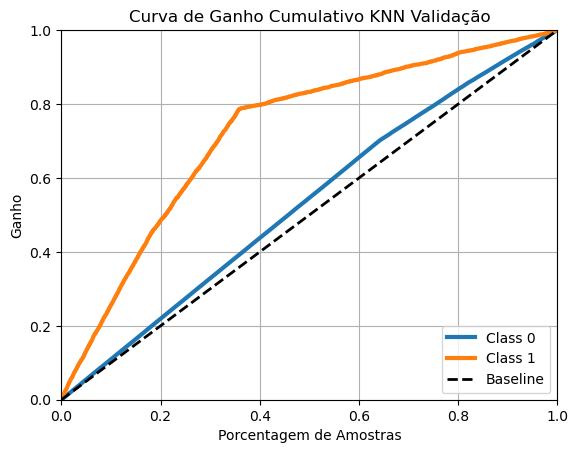

In [52]:
# Curva de Ganho cumulativo

cg_knn = skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );
cg_knn.set_ylabel('Ganho') #Propensão de compra KNN Validação
cg_knn.set_xlabel('Porcentagem de Amostras')
cg_knn.set_title('Curva de Ganho Cumulativo KNN Validação'); 

#### 7.1.1.2. Cross Validation and Random Search Scikitlearn

In [195]:
# Dados preparados para treino e teste de métricas

# TREINO 
x_train = df_train.copy()
y_train = x_train['remainder__interested'].copy()

# TESTE
x_test = df_test.copy()
y_test = x_test['remainder__interested'].copy()

In [196]:
## Selecionar apenas as colunas que foram selecionadas para treinar modelo

# treino
x_train_final = x_train[ cols_selected ].copy()

# teste
x_test_final = x_test[ cols_selected ].copy()


In [197]:
## Parâmetros default do KNN Classifier

knn = KNeighborsClassifier()

knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [198]:
param_random = {'n_neighbors': list(range(3,30,2)),
                'metric': ['euclidean', 'manhattan']}

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [201]:
# instanciamos um RandomizedSearchCV passando o modelo, os parâmetros e o número de K folds:
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_random, cv=5, scoring= ml_performance_CV, n_iter=10, verbose = 4, return_train_score=True, n_jobs = -1 )
  # RandomSearchCV: vai rodar o cross validation para cada combinação de parâmetros passada.
  # assim como o cross_val_score, o RandomSearchCV vai usar stratified k-fold cross-validation por padrão para classification, e k-fold para regression.
  #'refit'=True(default): vai retreinar um modelo final com todos os dados (TRAIN e VAL), com os melhores parâmetros em CV encontrados contra VAL. 
        # este modelo estará no objeto RandomSearchCV, e seu score é obtido chamando o método 'score'.

random_search.fit(x_train_final, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                        17, 19]},
                   return_train_score=True,
                   scoring=<function ml_performance_CV at 0x000001EF564B1CA0>,
                   verbose=4)

In [202]:
# Modelo com melhores parâmetros encontrados EM VAL:
print("Best estimator: {}".format(random_search.best_estimator_))

Best estimator: KNeighborsClassifier(metric='manhattan', n_neighbors=19)


In [203]:
#Resultados detalhados de cada modelo treinado, com cada split em TRAIN e em VAL, e seus scores:
pd.DataFrame(random_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_neighbors param_metric                                      params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0       6.489893      0.890255        60.410202        1.106596                17    manhattan  {'n_neighbors': 17, 'metric': 'manhattan'}            0.29010            0.29275            0.29040            0.29195            0.29205          0.29145        0.001022                3             0.47480             0.47485             0.47320             0.47345             0.47500           0.47426         0.000770
1       7.729826      0.163027        53.625721        4.933733                19    euclidean  {'n_neighbors': 19, 'metric': 'euclidean'}            0.29070            0.29175            0.29140            0.29395            0.29460          0.29248        0.001518                2             0.46640             0.46140             0.46420             0.46255             0.46040           0.46299         0.002122
2       9.918706      1.345744        48.329029        1.228310                17    euclidean  {'n_neighbors': 17, 'metric': 'euclidean'}            0.28845            0.29040            0.29005            0.29195            0.29310          0.29079        0.001604                4             0.47245             0.47210             0.47280             0.46870             0.46920           0.47105         0.001736
3       8.726894      0.931382        56.208407        1.947049                19    manhattan  {'n_neighbors': 19, 'metric': 'manhattan'}            0.29080            0.29335            0.29235            0.29405            0.29575          0.29326        0.001656                1             0.46835             0.46340             0.46540             0.46515             0.46315           0.46509         0.001863
4      10.102689      0.892836        44.657290        1.429394                 5    euclidean   {'n_neighbors': 5, 'metric': 'euclidean'}            0.27390            0.27305            0.27110            0.27300            0.27515          0.27324        0.001323                9             0.59580             0.59355             0.59180             0.59200             0.59010           0.59265         0.001917
5       8.920032      0.817306        44.204916        1.131647                 3    manhattan   {'n_neighbors': 3, 'metric': 'manhattan'}            0.24260            0.24470            0.24245            0.24285            0.24535          0.24359        0.001196               10             0.70995             0.71025             0.71175             0.71210             0.71015           0.71084         0.000898
6       9.521395      0.515827        45.816653        1.154338                 7    euclidean   {'n_neighbors': 7, 'metric': 'euclidean'}            0.27735            0.27795            0.27525            0.27475            0.27895          0.27685        0.001602                8             0.55025             0.54740             0.54540             0.54415             0.54115           0.54567         0.003059
7       9.966304      0.356279        52.481578        1.407329                11    manhattan  {'n_neighbors': 11, 'metric': 'manhattan'}            0.28495            0.28780            0.28540            0.28715            0.28750          0.28656        0.001158                5             0.50840             0.51240             0.51055             0.50990             0.51005           0.51026         0.001288
8       9.730479      0.396072        50.838276        3.890288                 7    manhattan   {'n_neighbors': 7, 'metric': 'manhattan'}            0.27795            0.27595            0.27720            0.27545            0.2790

In [204]:
pd.set_option('max_colwidth', 100)
#Resultados que interessam (performance em TRAIN e VAL):   --> param_gri2
knn_models = pd.DataFrame(random_search.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]
knn_models

rank_test_score                                      params  mean_train_score  mean_test_score
3                1  {'n_neighbors': 19, 'metric': 'manhattan'}           0.46509          0.29326
1                2  {'n_neighbors': 19, 'metric': 'euclidean'}           0.46299          0.29248
0                3  {'n_neighbors': 17, 'metric': 'manhattan'}           0.47426          0.29145
2                4  {'n_neighbors': 17, 'metric': 'euclidean'}           0.47105          0.29079
7                5  {'n_neighbors': 11, 'metric': 'manhattan'}           0.51026          0.28656

In [205]:
# Score médio com CV em dados de VAL do best_estimator (modelo com melhores params):
print("Mean CV Precison_at_20k (VAL): {:.4f}".format(random_search.best_score_))

#Ajustes no set:
# Mean CV score (VAL): 0.8582  	{'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_leaf': 10}	
# Mean CV score (VAL): 0.8595   {'max_depth': 20, 'max_leaf_nodes': 50, 'min_samples_leaf': 15}	
# Mean CV score (VAL): 0.8599   {'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_leaf': 20}	

Mean CV Precison_at_20k (VAL): 0.2933


In [206]:
# Como mantivemos o (refit=True), chamando .score, o GridSearchCV retornará o score desse melhor modelo acima, 
  # pois já foi retreinado agora com todos os dados (TRAIN + VAL). No bloco acima, era contra VAL.
trainval_score = grid_search.score( x_train_final, y_train )
print("Precison_at_20k (TRAINVAL): {:.4f}".format( float(trainval_score) ) )

Precison_at_20k (TRAINVAL): 0.3354


In [207]:
#Avaliar como o modelo se sai em TEST (dados inéditos, simulando dados de produção):
test_score = random_search.score(x_test_final, y_test)
print(" Precison_at_20k (TEST): {:.4f}".format( float(test_score) ) )

 Precison_at_20k (TEST): 0.3094


#### 7.1.1.3. Cross Validation and Random Search Manual

In [101]:
## Import train data 

train = pd.read_csv('../data/train.csv')


In [102]:
X_train = train.copy()
y_train = train['interested'].copy()

In [103]:
## Valores possíveis para os parâmetros do modelo KNN
param = {'n_neighbors': list(range(3,21,2)),
         'metric': ['euclidean', 'manhattan']}


# Quantidade iterações (experimentos com valores distintos para testar desempenho)
MAX_EVAL = 10

In [107]:
final_result_knn = pd.DataFrame()

for i in range(MAX_EVAL):
    
    ## Escolher um valor aleatório por iteração para cada parâmetro e armazenar em novo dicionário hp
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    
    ## Display do experimento com valores escolhidos
    
    print(f"\nIteração Nº: {i + 1}")
    
    print( hp )
    
    
    ## Modelo
    model = KNeighborsClassifier(n_neighbors = hp['n_neighbors'], 
                                 metric = hp['metric'])
    
    ## Model Name
    model_name = 'KNN_i' + str(i + 1)
    
    # Performance
    knn_result_cv = cross_validation(X_train, y_train, 5, model_name , hp, model, cols_selected, rank = [20000], verbose = True)
    final_result_knn = pd.concat([ final_result_knn , knn_result_cv ])

    


Iteração Nº: 1
{'n_neighbors': 15, 'metric': 'manhattan'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 2
{'n_neighbors': 13, 'metric': 'euclidean'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 3
{'n_neighbors': 5, 'metric': 'manhattan'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 4
{'n_neighbors': 15, 'metric': 'euclidean'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 5
{'n_neighbors': 3, 'metric': 'euclidean'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 6
{'n_neighbors': 7, 'metric': 'euclidean'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 7
{'n_neighbors': 13, 'metric': 'manhattan'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 8
{'n_neighbors': 11, 'metric': 'euclidean'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 9
{'n_neighbors': 19, 'metric': 'euclidean'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 10
{'n_neighbors': 9, 'metric': 'manhattan'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [108]:
## DataFrame com resultados de desempenho modelos com valores de parâmetros alterados ordenados por maior performance
final_result_knn.sort_values(by = 'Val Precision_at_20k', ascending = False).reset_index( drop = True )

Algorithm  Parameters Train Precision_at_20k Val Precision_at_20k Train Recall_at_20k  Val Recall_at_20k    Train F1_at_20k      Val F1_at_20k
0    KNN_i9         NaN      0.4632 +/- 0.0023    0.2928 +/- 0.0018   0.3099 +/- 0.0015  0.7836 +/- 0.0048  0.3713 +/- 0.0019  0.4263 +/- 0.0026
1    KNN_i1         NaN      0.4797 +/- 0.0015    0.2907 +/- 0.0016    0.3209 +/- 0.001  0.7779 +/- 0.0043  0.3845 +/- 0.0012  0.4232 +/- 0.0024
2    KNN_i4         NaN      0.4782 +/- 0.0021    0.2904 +/- 0.0017   0.3199 +/- 0.0014  0.7771 +/- 0.0045  0.3834 +/- 0.0017  0.4228 +/- 0.0025
3    KNN_i7         NaN       0.491 +/- 0.0021    0.2879 +/- 0.0014   0.3285 +/- 0.0014  0.7705 +/- 0.0037  0.3936 +/- 0.0017   0.4192 +/- 0.002
4    KNN_i2         NaN      0.4899 +/- 0.0013    0.2878 +/- 0.0013   0.3278 +/- 0.0009  0.7703 +/- 0.0034  0.3928 +/- 0.0011  0.4191 +/- 0.0018
5    KNN_i8         NaN      0.5113 +/- 0.0023    0.2855 +/- 0.0014   0.3421 +/- 0.0016  0.7639 +/- 0.0036  0.4099 +/- 0.0019   0.4156 +/- 0.002
6   KNN_i10         NaN      0.5222 +/- 0.0019    0.2841 +/- 0.0011   0.3494 +/- 0.0013  0.7603 +/- 0.0029  0.4187 +/- 0.0015  0.4136 +/- 0.0016
7    KNN_i6         NaN      0.5446 +/- 0.0011    0.2769 +/- 0.0016   0.3643 +/- 0.0007  0.7411 +/- 0.0042  0.4366 +/- 0.0009  0.4032 +/- 0.0023
8    KNN_i3         NaN      0.5938 +/- 0.0027    0.2731 +/- 0.0012   0.3973 +/- 0.0018  0.7309 +/- 0.0031  0.4761 +/- 0.0022  0.3977 +/- 0.0017
9    KNN_i5         NaN      0.7125 +/- 0.0025    0.2436 +/- 0.0014   0.4767 +/- 0.0016   0.652 +/- 0.0037   0.5712 +/- 0.002   0.3547 +/- 0.002

In [ ]:
### best_parameters KNN

# Iteração Nº: 2
# {'n_neighbors': 19, 'metric': 'euclidean'}

### 7.1.2. Naive Bayes

#### 7.1.2.1. Validation one K-Fold

In [62]:
# model definition

nb = GaussianNB()

# model fit 

nb.fit(x_train_one_k, y_train)

# model predict - Capacidade de aprendizado do modelo

yhat_nb = nb.predict_proba(x_val_one_k)

In [63]:
k = [10000, 20000, 30000]


result_nb = ml_performance( x_val, yhat_nb, k )
result_nb

rank  precision_at_k  recall_at_k  F1_at_k
9999   10000            0.29         0.53     0.38
19999  20000            0.27         0.96     0.42
29999  30000            0.19         1.00     0.31

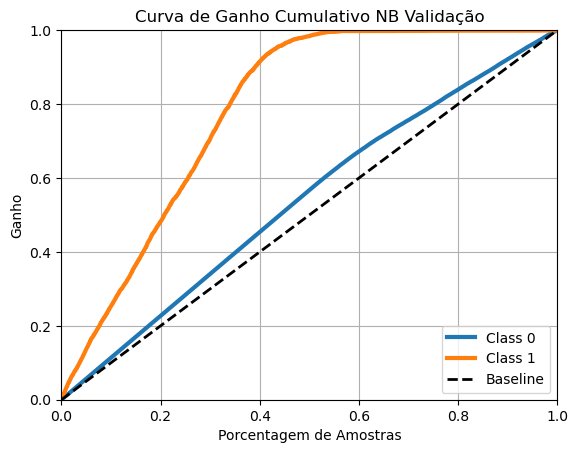

In [54]:
# Curva de Ganho cumulativo

cg = skplt.metrics.plot_cumulative_gain( y_val, yhat_nb );
cg.set_ylabel('Ganho')
cg.set_xlabel('Porcentagem de Amostras')
cg.set_title('Curva de Ganho Cumulativo NB Validação');

#### 7.1.2.2. Cross Validation and Random Search Scikitlearn

In [114]:
# Dados preparados para treino e teste de métricas

# TREINO 
x_train = df_train.copy()
y_train = x_train['remainder__interested'].copy()

# TESTE
x_test = df_test.copy()
y_test = x_test['remainder__interested'].copy()

In [115]:
## Selecionar apenas as colunas que foram selecionadas para treinar modelo

# treino
x_train_final = x_train[ cols_selected ].copy()

# teste
x_test_final = x_test[ cols_selected ].copy()


In [116]:
## Parâmetros default do Gaussian Classifier

nb = GaussianNB()

nb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [117]:
param_random = {'var_smoothing': [1e-4 ,1e-9, 1e-13, 1e-16, 1e-25, 1e-30]}

In [118]:
# instanciamos um RandomizedSearchCV passando o modelo, os parâmetros e o número de K folds:
random_search = RandomizedSearchCV(GaussianNB(), param_random, cv=5, scoring= ml_performance_CV, n_iter=10, verbose = 4, return_train_score=True, n_jobs = -1 )
  # RandomSearchCV: vai rodar o cross validation para cada combinação de parâmetros passada.
  # assim como o cross_val_score, o RandomSearchCV vai usar stratified k-fold cross-validation por padrão para classification, e k-fold para regression.
  #'refit'=True(default): vai retreinar um modelo final com todos os dados (TRAIN e VAL), com os melhores parâmetros em CV encontrados contra VAL. 
        # este modelo estará no objeto RandomSearchCV, e seu score é obtido chamando o método 'score'.

random_search.fit(x_train_final, y_train)

C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
                   param_distributions={'var_smoothing': [0.0001, 1e-09, 1e-13,
                                                          1e-16, 1e-25,
                                                          1e-30]},
                   return_train_score=True,
                   scoring=<function ml_performance_CV at 0x000001EF564B1CA0>,
                   verbose=4)

In [119]:
# Modelo com melhores parâmetros encontrados EM VAL:
print("Best estimator: {}".format(random_search.best_estimator_))

Best estimator: GaussianNB()


In [120]:
#Resultados detalhados de cada modelo treinado, com cada split em TRAIN e em VAL, e seus scores:
pd.DataFrame(random_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_var_smoothing                     params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0       0.769994      0.158467         0.213046        0.012896              0.0001  {'var_smoothing': 0.0001}            0.28760            0.29005            0.29140            0.28765            0.28975          0.28929        0.001469                6             0.31085             0.31125             0.31190             0.31170             0.31110           0.31136         0.000387
1       0.453414      0.019625         0.220200        0.016197                 0.0   {'var_smoothing': 1e-09}            0.28785            0.28990            0.29135            0.28790            0.29000          0.28940        0.001346                1             0.31190             0.31165             0.31175             0.31275             0.31185           0.31198         0.000394
2       0.461877      0.013706         0.208644        0.019480                 0.0   {'var_smoothing': 1e-13}            0.28785            0.28990            0.29135            0.28790            0.29000          0.28940        0.001346                1             0.31190             0.31165             0.31175             0.31275             0.31185           0.31198         0.000394
3       0.494177      0.022453         0.222410        0.016875                 0.0   {'var_smoothing': 1e-16}            0.28785            0.28990            0.29135            0.28790            0.29000          0.28940        0.001346                1             0.31190             0.31165             0.31175             0.31275             0.31185           0.31198         0.000394
4       0.576786      0.092060         0.250120        0.034176                 0.0   {'var_smoothing': 1e-25}            0.28785            0.28990            0.29135            0.28790            0.29000          0.28940        0.001346                1             0.31190             0.31165             0.31175             0.31275             0.31185           0.31198         0.000394
5       0.422119      0.047845         0.197124        0.034604                 0.0   {'var_smoothing': 1e-30}            0.28785            0.28990            0.29135            0.28790            0.29000          0.28940        0.001346                1             0.31190             0.31165             0.31175             0.31275             0.31185           0.31198         0.000394

In [137]:
pd.set_option('max_colwidth', 100)
#Resultados que interessam (performance em TRAIN e VAL):   --> param_gri2
nb_models = pd.DataFrame(random_search.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]
nb_models

rank_test_score                    params  mean_train_score  mean_test_score
1                1  {'var_smoothing': 1e-09}           0.31198           0.2894
2                1  {'var_smoothing': 1e-13}           0.31198           0.2894
3                1  {'var_smoothing': 1e-16}           0.31198           0.2894
4                1  {'var_smoothing': 1e-25}           0.31198           0.2894
5                1  {'var_smoothing': 1e-30}           0.31198           0.2894

In [122]:
# Score médio com CV em dados de VAL do best_estimator (modelo com melhores params):
print("Mean CV Precison_at_20k (VAL): {:.4f}".format(random_search.best_score_))

#Ajustes no set:
# Mean CV score (VAL): 0.8582  	{'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_leaf': 10}	
# Mean CV score (VAL): 0.8595   {'max_depth': 20, 'max_leaf_nodes': 50, 'min_samples_leaf': 15}	
# Mean CV score (VAL): 0.8599   {'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_leaf': 20}	

Mean CV Precison_at_20k (VAL): 0.2894


In [132]:
# Como mantivemos o (refit=True), chamando .score, o GridSearchCV retornará o score desse melhor modelo acima, 
  # pois já foi retreinado agora com todos os dados (TRAIN + VAL). No bloco acima, era contra VAL.
trainval_score = grid_search.score( x_train_final, y_train )
print("Precison_at_20k (TRAINVAL): {:.4f}".format( float(trainval_score) ) )

Precison_at_20k (TRAINVAL): 0.3354


In [131]:
#Avaliar como o modelo se sai em TEST (dados inéditos, simulando dados de produção):
test_score = random_search.score(x_test_final, y_test)
print(" Precison_at_20k (TEST): {:.4f}".format( float(test_score) ) )

 Precison_at_20k (TEST): 0.2882


#### 7.1.2.3. Cross Validation and Random Search Manual

In [133]:
## Import train data 

train = pd.read_csv('../data/train.csv')


In [134]:
X_train = train.copy()
y_train = train['interested'].copy()

In [135]:
## Valores possíveis para os parâmetros do modelo KNN
param = {'var_smoothing': [1e-4 ,1e-9, 1e-13, 1e-16, 1e-25, 1e-30]}


# Quantidade iterações (experimentos com valores distintos para testar desempenho)
MAX_EVAL = 10

In [143]:
final_result_nb = pd.DataFrame()

for i in range(MAX_EVAL):
    
    ## Escolher um valor aleatório por iteração para cada parâmetro e armazenar em novo dicionário hp
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    
    ## Display do experimento com valores escolhidos
    
    print(f"\nIteração Nº: {i + 1}")
    
    print( hp )
    
    
    ## Modelo
    model = GaussianNB(var_smoothing = hp['var_smoothing']) 
     
    ## Model Name
    model_name = 'NB_i' + str(i + 1)
    
    # Performance
    nb_result_cv = cross_validation(X_train, y_train, 5, model_name , hp, model, cols_selected, rank = [20000], verbose = True)
    final_result_nb = pd.concat([ final_result_nb , nb_result_cv ])
   


Iteração Nº: 1
{'var_smoothing': 1e-30}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 2
{'var_smoothing': 0.0001}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 3
{'var_smoothing': 1e-13}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 4
{'var_smoothing': 1e-25}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 5
{'var_smoothing': 1e-16}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 6
{'var_smoothing': 1e-09}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 7
{'var_smoothing': 1e-25}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 8
{'var_smoothing': 1e-30}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 9
{'var_smoothing': 1e-13}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 10
{'var_smoothing': 1e-13}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Algorithm                 Parameters Train Precision_at_20k Val Precision_at_20k Train Recall_at_20k  Val Recall_at_20k    Train F1_at_20k      Val F1_at_20k
0     NB_i1   {'var_smoothing': 1e-30}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0     NB_i2  {'var_smoothing': 0.0001}      0.3118 +/- 0.0008    0.2888 +/- 0.0014   0.2086 +/- 0.0005  0.7727 +/- 0.0037    0.25 +/- 0.0006   0.4204 +/- 0.002
0     NB_i3   {'var_smoothing': 1e-13}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0     NB_i4   {'var_smoothing': 1e-25}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0     NB_i5   {'var_smoothing': 1e-16}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0     NB_i6   {'var_smoothing': 1e-09}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0     NB_i7   {'var_smoothing': 1e-25}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0     NB_i8   {'var_smoothing': 1e-30}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0     NB_i9   {'var_smoothing': 1e-13}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
0    NB_i10   {'var_smoothing': 1e-13}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018

In [145]:
## DataFrame com resultados de desempenho modelos com valores de parâmetros alterados ordenados por maior performance
final_result_nb.sort_values(by = 'Val Precision_at_20k', ascending = False).reset_index( drop = True )

Algorithm                 Parameters Train Precision_at_20k Val Precision_at_20k Train Recall_at_20k  Val Recall_at_20k    Train F1_at_20k      Val F1_at_20k
0     NB_i1   {'var_smoothing': 1e-30}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
1     NB_i3   {'var_smoothing': 1e-13}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
2     NB_i4   {'var_smoothing': 1e-25}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
3     NB_i5   {'var_smoothing': 1e-16}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
4     NB_i6   {'var_smoothing': 1e-09}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
5     NB_i7   {'var_smoothing': 1e-25}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
6     NB_i8   {'var_smoothing': 1e-30}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
7     NB_i9   {'var_smoothing': 1e-13}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
8    NB_i10   {'var_smoothing': 1e-13}      0.3122 +/- 0.0007    0.2889 +/- 0.0013   0.2089 +/- 0.0005  0.7731 +/- 0.0034  0.2503 +/- 0.0006  0.4206 +/- 0.0018
9     NB_i2  {'var_smoothing': 0.0001}      0.3118 +/- 0.0008    0.2888 +/- 0.0014   0.2086 +/- 0.0005  0.7727 +/- 0.0037    0.25 +/- 0.0006   0.4204 +/- 0.002

### 7.1.3. LGBM 

#### 7.1.3.1. Validation one K-Fold

In [64]:
# model definition

lgbm = lgb.LGBMClassifier(random_state= 42)

# model fit 

lgbm.fit(x_train_one_k, y_train)

# model predict - Capacidade de aprendizado do modelo

yhat_lgbm = lgbm.predict_proba(x_val_one_k)

In [65]:
k = [10000, 20000, 30000]


result_lgbm = ml_performance( x_val, yhat_lgbm, k )
result_lgbm

rank  precision_at_k  recall_at_k  F1_at_k
9999   10000            0.35         0.63     0.45
19999  20000            0.27         0.96     0.42
29999  30000            0.19         1.00     0.31

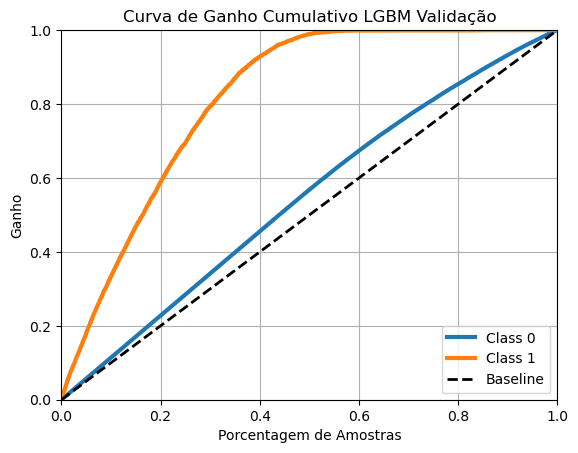

In [56]:
# Curva de Ganho cumulativo

cg = skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm );
cg.set_ylabel('Ganho')
cg.set_xlabel('Porcentagem de Amostras')
cg.set_title('Curva de Ganho Cumulativo LGBM Validação');

#### 7.1.3.2. Cross Validation and Random Search Scikitlearn

In [146]:
# Dados preparados para treino e teste de métricas

# TREINO 
x_train = df_train.copy()
y_train = x_train['remainder__interested'].copy()

# TESTE
x_test = df_test.copy()
y_test = x_test['remainder__interested'].copy()

In [147]:
## Selecionar apenas as colunas que foram selecionadas para treinar modelo

# treino
x_train_final = x_train[ cols_selected ].copy()

# teste
x_test_final = x_test[ cols_selected ].copy()


In [148]:
## Parâmetros default do Gaussian Classifier

lgbm = lgb.LGBMClassifier()

lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [149]:
param_random = { 'n_estimators': [100, 500, 1000 ,1500, 1700, 2500, 3000, 3500],
                 'learning_rate': [0.01, 0.05, 0.1, 0.3],
                 'class_weight': ['balanced', None],
                 'max_depth': [-1, 3, 5, 9],
                 'subsample': [0.1, 0.5, 0.7, 1.0],
                 'colsample_bytree': [0.3, 0.7, 0.9],
                 'min_child_weight': [1e-3, 3, 8, 15]}

In [150]:
# instanciamos um RandomizedSearchCV passando o modelo, os parâmetros e o número de K folds:
random_search = RandomizedSearchCV(lgb.LGBMClassifier(), param_random, cv=5, scoring= ml_performance_CV, n_iter=10, verbose = 4, return_train_score=True, n_jobs = -1 )
  # RandomSearchCV: vai rodar o cross validation para cada combinação de parâmetros passada.
  # assim como o cross_val_score, o RandomSearchCV vai usar stratified k-fold cross-validation por padrão para classification, e k-fold para regression.
  #'refit'=True(default): vai retreinar um modelo final com todos os dados (TRAIN e VAL), com os melhores parâmetros em CV encontrados contra VAL. 
        # este modelo estará no objeto RandomSearchCV, e seu score é obtido chamando o método 'score'.

random_search.fit(x_train_final, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'colsample_bytree': [0.3, 0.7, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [-1, 3, 5, 9],
                                        'min_child_weight': [0.001, 3, 8, 15],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         1700, 2500, 3000,
                                                         3500],
                                        'subsample': [0.1, 0.5, 0.7, 1.0]},
                   return_train_score=True,
                   scoring=<function ml_performance_CV at 0x000001EF564B1CA0>,
                   verbose=4)

In [151]:
# Modelo com melhores parâmetros encontrados EM VAL:
print("Best estimator: {}".format(random_search.best_estimator_))

Best estimator: LGBMClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
               min_child_weight=8, n_estimators=500, subsample=0.7)


In [152]:
#Resultados detalhados de cada modelo treinado, com cada split em TRAIN e em VAL, e seus scores:
pd.DataFrame(random_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_subsample param_n_estimators param_min_child_weight param_max_depth param_learning_rate param_colsample_bytree param_class_weight                                                                                               params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0     126.999687     15.906416        96.623588        6.363172             0.7               2500                     15              -1                 0.3                    0.3           balanced  {'subsample': 0.7, 'n_estimators': 2500, 'min_child_weight': 15, 'max_depth': -1, 'learning_rate...            0.29985            0.29870            0.29935            0.29655            0.29830          0.29855        0.001133               10             0.65025             0.65055             0.64760             0.64685             0.64860           0.64877         0.001445
1     114.590905      2.647442        97.245648       15.076277             0.1               2500                  0.001               5                 0.1                    0.7               None  {'subsample': 0.1, 'n_estimators': 2500, 'min_child_weight': 0.001, 'max_depth': 5, 'learning_ra...            0.30535            0.30485            0.30640            0.30340            0.30370          0.30474        0.001097                9             0.66205             0.66375             0.66815             0.66580             0.66800           0.66555         0.002380
2       4.595608      0.097527         0.572720        0.031442             1.0                100                      3               3                 0.3                    0.9               None  {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': ...            0.31100            0.31235            0.31015            0.31215            0.31350          0.31183        0.001155                5             0.41700             0.41945             0.41705             0.42005             0.41700           0.41811         0.001353
3      20.191587      0.444075         3.170790        0.321095             0.7                500                  0.001               3                 0.1                    0.9           balanced  {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 0.001, 'max_depth': 3, 'learning_rat...            0.31135            0.31265            0.31020            0.31255            0.31295          0.31194        0.001027                4             0.42155             0.42250             0.41810             0.42295             0.41965           0.42095         0.001821
4      68.093150      5.045408        38.507102        4.876613             0.7               1500                  0.001               9                0.05                    0.7               None  {'subsample': 0.7, 'n_estimators': 1500, 'min_child_weight': 0.001, 'max_depth': 9, 'learning_ra...            0.30920            0.31055            0.30935            0.30865            0.31060          0.30967        0.000775                8             0.56290             0.56595             0.56350             0.56525             0.56775           0.56507         0.001741
5     128.049043      5.376090        74.157271        9.198562             1.0               3000                     15               3                0.01                    0.7           balanced  {'subsample': 1.0, 'n_estimators': 3000, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate'...            0.31095            0.31290            0.31065            0.31255            0.31285          0.31198        0.000975                3             0.41680             0.41715             0.41430            

In [153]:
pd.set_option('max_colwidth', 100)
#Resultados que interessam (performance em TRAIN e VAL):   --> param_gri2
lgbm_models = pd.DataFrame(random_search.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]
lgbm_models

rank_test_score                                                                                               params  mean_train_score  mean_test_score
6                1  {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 8, 'max_depth': 9, 'learning_rate': ...           0.42115          0.31221
9                2  {'subsample': 0.7, 'n_estimators': 3500, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate'...           0.41721          0.31201
5                3  {'subsample': 1.0, 'n_estimators': 3000, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate'...           0.41585          0.31198
3                4  {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 0.001, 'max_depth': 3, 'learning_rat...           0.42095          0.31194
2                5  {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': ...           0.41811          0.31183

In [154]:
# Score médio com CV em dados de VAL do best_estimator (modelo com melhores params):
print("Mean CV Precison_at_20k (VAL): {:.4f}".format(random_search.best_score_))

#Ajustes no set:
# Mean CV score (VAL): 0.8582  	{'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_leaf': 10}	
# Mean CV score (VAL): 0.8595   {'max_depth': 20, 'max_leaf_nodes': 50, 'min_samples_leaf': 15}	
# Mean CV score (VAL): 0.8599   {'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_leaf': 20}	

Mean CV Precison_at_20k (VAL): 0.3122


In [155]:
# Como mantivemos o (refit=True), chamando .score, o GridSearchCV retornará o score desse melhor modelo acima, 
  # pois já foi retreinado agora com todos os dados (TRAIN + VAL). No bloco acima, era contra VAL.
trainval_score = grid_search.score( x_train_final, y_train )
print("Precison_at_20k (TRAINVAL): {:.4f}".format( float(trainval_score) ) )

Precison_at_20k (TRAINVAL): 0.3354


In [156]:
#Avaliar como o modelo se sai em TEST (dados inéditos, simulando dados de produção):
test_score = random_search.score(x_test_final, y_test)
print(" Precison_at_20k (TEST): {:.4f}".format( float(test_score) ) )

 Precison_at_20k (TEST): 0.3361


#### 7.1.3.3. Cross Validation and Random Search Manual

In [157]:
## Import train data 

train = pd.read_csv('../data/train.csv')


In [158]:
X_train = train.copy()
y_train = train['interested'].copy()

In [159]:
## Valores possíveis para os parâmetros do modelo LGBM
param = {'n_estimators': [100, 500, 1000 ,1500, 1700, 2500, 3000, 3500],
         'learning_rate': [0.01, 0.05, 0.1, 0.3],
         'class_weight': ['balanced', None],
         'max_depth': [-1, 3, 5, 9],
         'subsample': [0.1, 0.5, 0.7, 1.0],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [1e-3, 3, 8, 15]}


# Quantidade iterações (experimentos com valores distintos para testar desempenho)
MAX_EVAL = 10

In [160]:
final_result_lgbm = pd.DataFrame()

for i in range(MAX_EVAL):
    
    ## Escolher um valor aleatório por iteração para cada parâmetro e armazenar em novo dicionário hp
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    
    ## Display do experimento com valores escolhidos
    
    print(f"\nIteração Nº: {i + 1}")
    
    print( hp )
    
    ## Modelo
    model = lgb.LGBMClassifier( objective = 'binary',
                                n_estimators = hp['n_estimators'], 
                                learning_rate = hp['learning_rate'],
                                class_weight = hp['class_weight'],
                                max_depth = hp['max_depth'], 
                                subsample = hp['subsample'], 
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'], 
                                random_state = 42)
     
    ## Model Name
    model_name = 'LGBM_i' + str(i + 1)
    
    # Performance
    lgbm_result_cv = cross_validation(X_train, y_train, 5, model_name , hp, model, cols_selected, rank = [20000], verbose = True)
    final_result_lgbm = pd.concat([ final_result_lgbm , lgbm_result_cv ])



Iteração Nº: 1
{'n_estimators': 3500, 'learning_rate': 0.1, 'class_weight': None, 'max_depth': -1, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 0.001}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 2
{'n_estimators': 3500, 'learning_rate': 0.01, 'class_weight': 'balanced', 'max_depth': -1, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 3
{'n_estimators': 100, 'learning_rate': 0.05, 'class_weight': 'balanced', 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 0.001}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 4
{'n_estimators': 1000, 'learning_rate': 0.1, 'class_weight': 'balanced', 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 5
{'n_estimators': 3500, 'learning_rate': 0.05, 'class_weight': None, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 0.001}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 6
{'n_estimators': 3000, 'learning_rate': 0.01, 'class_weight': 'balanced', 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 0.001}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 7
{'n_estimators': 1500, 'learning_rate': 0.1, 'class_weight': 'balanced', 'max_depth': -1, 'subsample': 1.0, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 8
{'n_estimators': 100, 'learning_rate': 0.05, 'class_weight': None, 'max_depth': -1, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 9
{'n_estimators': 100, 'learning_rate': 0.3, 'class_weight': 'balanced', 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 0.001}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 10
{'n_estimators': 1000, 'learning_rate': 0.3, 'class_weight': None, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [161]:
## DataFrame com resultados de desempenho modelos com valores de parâmetros alterados ordenados por maior performance
final_result_lgbm.sort_values(by = 'Val Precision_at_20k', ascending = False).reset_index( drop = True )

Algorithm                                                                                           Parameters Train Precision_at_20k Val Precision_at_20k Train Recall_at_20k  Val Recall_at_20k    Train F1_at_20k      Val F1_at_20k
0   LGBM_i8  {'n_estimators': 100, 'learning_rate': 0.05, 'class_weight': None, 'max_depth': -1, 'subsample':...      0.4218 +/- 0.0009     0.311 +/- 0.0011   0.2822 +/- 0.0006  0.8322 +/- 0.0029  0.3381 +/- 0.0007  0.4527 +/- 0.0016
1   LGBM_i3  {'n_estimators': 100, 'learning_rate': 0.05, 'class_weight': 'balanced', 'max_depth': 9, 'subsam...      0.4115 +/- 0.0009     0.311 +/- 0.0009   0.2753 +/- 0.0006  0.8322 +/- 0.0025  0.3299 +/- 0.0007  0.4527 +/- 0.0014
2   LGBM_i6  {'n_estimators': 3000, 'learning_rate': 0.01, 'class_weight': 'balanced', 'max_depth': 9, 'subsa...      0.4566 +/- 0.0018     0.311 +/- 0.0008   0.3055 +/- 0.0012  0.8322 +/- 0.0022  0.3661 +/- 0.0015  0.4528 +/- 0.0012
3   LGBM_i9  {'n_estimators': 100, 'learning_rate': 0.3, 'class_weight': 'balanced', 'max_depth': 5, 'subsamp...      0.4286 +/- 0.0014    0.3108 +/- 0.0009    0.2868 +/- 0.001  0.8318 +/- 0.0025  0.3436 +/- 0.0011  0.4526 +/- 0.0014
4   LGBM_i2  {'n_estimators': 3500, 'learning_rate': 0.01, 'class_weight': 'balanced', 'max_depth': -1, 'subs...      0.4702 +/- 0.0023    0.3106 +/- 0.0007   0.3146 +/- 0.0016  0.8312 +/- 0.0017   0.377 +/- 0.0019   0.4522 +/- 0.001
5  LGBM_i10  {'n_estimators': 1000, 'learning_rate': 0.3, 'class_weight': None, 'max_depth': 3, 'subsample': ...      0.4763 +/- 0.0009     0.3098 +/- 0.001   0.3186 +/- 0.0006  0.8291 +/- 0.0027  0.3818 +/- 0.0008  0.4511 +/- 0.0015
6   LGBM_i4  {'n_estimators': 1000, 'learning_rate': 0.1, 'class_weight': 'balanced', 'max_depth': 5, 'subsam...       0.4984 +/- 0.003    0.3083 +/- 0.0008    0.3334 +/- 0.002  0.8251 +/- 0.0021  0.3995 +/- 0.0024  0.4489 +/- 0.0012
7   LGBM_i5  {'n_estimators': 3500, 'learning_rate': 0.05, 'class_weight': None, 'max_depth': 5, 'subsample':...      0.6144 +/- 0.0032    0.3068 +/- 0.0009   0.4111 +/- 0.0021  0.8209 +/- 0.0025  0.4926 +/- 0.0026  0.4466 +/- 0.0014
8   LGBM_i1  {'n_estimators': 3500, 'learning_rate': 0.1, 'class_weight': None, 'max_depth': -1, 'subsample':...      0.6956 +/- 0.0037    0.3052 +/- 0.0008   0.4654 +/- 0.0025  0.8167 +/- 0.0021   0.5577 +/- 0.003  0.4443 +/- 0.0012
9   LGBM_i7  {'n_estimators': 1500, 'learning_rate': 0.1, 'class_weight': 'balanced', 'max_depth': -1, 'subsa...      0.6232 +/- 0.0039     0.305 +/- 0.0011    0.417 +/- 0.0026  0.8163 +/- 0.0029  0.4997 +/- 0.0031  0.4441 +/- 0.0016

### 7.1.4. Regressão Logística

#### 7.1.4.1. Validation one K-Fold

In [68]:
# model definition

lr = LogisticRegression(random_state=42, solver = 'liblinear')

# model fit 

lr.fit(x_train_one_k, y_train)

# model predict - Capacidade de aprendizado do modelo

yhat_lr = lr.predict_proba(x_val_one_k)

In [69]:
k = [10000, 20000, 30000]


result_lr = ml_performance( x_val, yhat_lr, k )
result_lr

rank  precision_at_k  recall_at_k  F1_at_k
9999   10000            0.33         0.60     0.43
19999  20000            0.26         0.94     0.41
29999  30000            0.19         1.00     0.31

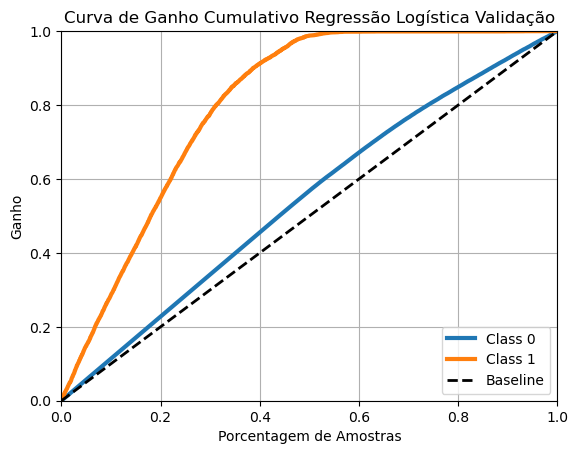

In [58]:
# Curva de Ganho cumulativo

cg = skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );
cg.set_ylabel('Ganho')
cg.set_xlabel('Porcentagem de Amostras')
cg.set_title('Curva de Ganho Cumulativo Regressão Logística Validação');

#### 7.1.4.2. Cross Validation and Random Search Scikitlearn

In [162]:
# Dados preparados para treino e teste de métricas

# TREINO 
x_train = df_train.copy()
y_train = x_train['remainder__interested'].copy()

# TESTE
x_test = df_test.copy()
y_test = x_test['remainder__interested'].copy()

In [163]:
## Selecionar apenas as colunas que foram selecionadas para treinar modelo

# treino
x_train_final = x_train[ cols_selected ].copy()

# teste
x_test_final = x_test[ cols_selected ].copy()


In [164]:
## Parâmetros default do Gaussian Classifier

lr = LogisticRegression()

lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [165]:
param_random = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                 'C': [0.1, 0.5, 1, 1.05, 1.1]                          ,
                 'class_weight': ['balanced', None]}

In [166]:
# instanciamos um RandomizedSearchCV passando o modelo, os parâmetros e o número de K folds:
random_search = RandomizedSearchCV(LogisticRegression(), param_random, cv=5, scoring= ml_performance_CV, n_iter=10, verbose = 4, return_train_score=True, n_jobs = -1 )
  # RandomSearchCV: vai rodar o cross validation para cada combinação de parâmetros passada.
  # assim como o cross_val_score, o RandomSearchCV vai usar stratified k-fold cross-validation por padrão para classification, e k-fold para regression.
  #'refit'=True(default): vai retreinar um modelo final com todos os dados (TRAIN e VAL), com os melhores parâmetros em CV encontrados contra VAL. 
        # este modelo estará no objeto RandomSearchCV, e seu score é obtido chamando o método 'score'.

random_search.fit(x_train_final, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 1, 1.05, 1.1],
                                        'class_weight': ['balanced', None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   return_train_score=True,
                   scoring=<function ml_performance_CV at 0x000001EF564B1CA0>,
                   verbose=4)

In [167]:
# Modelo com melhores parâmetros encontrados EM VAL:
print("Best estimator: {}".format(random_search.best_estimator_))

Best estimator: LogisticRegression(C=1.05, class_weight='balanced', solver='saga')


In [168]:
#Resultados detalhados de cada modelo treinado, com cada split em TRAIN e em VAL, e seus scores:
pd.DataFrame(random_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time     param_solver param_class_weight param_C                                                          params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0      25.090941      0.665460         3.615598        1.773730              sag               None     1.1               {'solver': 'sag', 'class_weight': None, 'C': 1.1}            0.30515            0.30675            0.30535            0.30950            0.30850          0.30705        0.001714                8             0.34700             0.34805             0.34965             0.34655             0.34535           0.34732         0.001452
1      13.954488      0.411880         0.133467        0.051149             saga           balanced    1.05       {'solver': 'saga', 'class_weight': 'balanced', 'C': 1.05}            0.30575            0.30635            0.30510            0.31000            0.30915          0.30727        0.001942                1             0.34600             0.34635             0.34785             0.34370             0.34335           0.34545         0.001694
2      26.662791      2.939130         0.122628        0.029964              sag               None    1.05              {'solver': 'sag', 'class_weight': None, 'C': 1.05}            0.30515            0.30675            0.30540            0.30950            0.30850          0.30706        0.001705                7             0.34695             0.34810             0.34960             0.34650             0.34535           0.34730         0.001449
3       5.998535      1.372851         0.135853        0.023860            lbfgs               None     1.1             {'solver': 'lbfgs', 'class_weight': None, 'C': 1.1}            0.30545            0.30670            0.30540            0.30950            0.30865          0.30714        0.001669                5             0.34715             0.34785             0.34965             0.34685             0.34565           0.34743         0.001318
4       6.828600      1.279044         0.134869        0.030222        newton-cg           balanced     0.5   {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 0.5}            0.30555            0.30625            0.30510            0.30995            0.30915          0.30720        0.001970                4             0.34665             0.34640             0.34825             0.34400             0.34305           0.34567         0.001887
5       1.837574      0.358362         0.137492        0.028641  newton-cholesky               None     0.1   {'solver': 'newton-cholesky', 'class_weight': None, 'C': 0.1}            0.30550            0.30670            0.30515            0.30925            0.30855          0.30703        0.001626               10             0.34905             0.34990             0.35170             0.34885             0.34760           0.34942         0.001357
6       8.056321      0.859376         0.146871        0.012497        newton-cg           balanced       1     {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 1}            0.30570            0.30625            0.30510            0.31000            0.30915          0.30724        0.001959                2             0.34610             0.34645             0.34785             0.34375             0.34340           0.34551         0.001689
7       7.668462      1.738918         0.128550        0.023213        newton-cg           balanced    1.05  {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 1.05}            0.30570            0.30625            0.30510            0.31000            0.30915          0.30724        0.001959                2             0.34610             0.34650             0.34790           

In [169]:
pd.set_option('max_colwidth', 100)
#Resultados que interessam (performance em TRAIN e VAL):   --> param_gri2
lr_models = pd.DataFrame(random_search.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]
lr_models

rank_test_score                                                          params  mean_train_score  mean_test_score
1                1       {'solver': 'saga', 'class_weight': 'balanced', 'C': 1.05}           0.34545          0.30727
6                2     {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 1}           0.34551          0.30724
7                2  {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 1.05}           0.34551          0.30724
4                4   {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 0.5}           0.34567          0.30720
3                5             {'solver': 'lbfgs', 'class_weight': None, 'C': 1.1}           0.34743          0.30714

In [170]:
# Score médio com CV em dados de VAL do best_estimator (modelo com melhores params):
print("Mean CV Precison_at_20k (VAL): {:.4f}".format(random_search.best_score_))

#Ajustes no set:
# Mean CV score (VAL): 0.8582  	{'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_leaf': 10}	
# Mean CV score (VAL): 0.8595   {'max_depth': 20, 'max_leaf_nodes': 50, 'min_samples_leaf': 15}	
# Mean CV score (VAL): 0.8599   {'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_leaf': 20}	

Mean CV Precison_at_20k (VAL): 0.3073


In [171]:
# Como mantivemos o (refit=True), chamando .score, o GridSearchCV retornará o score desse melhor modelo acima, 
  # pois já foi retreinado agora com todos os dados (TRAIN + VAL). No bloco acima, era contra VAL.
trainval_score = grid_search.score( x_train_final, y_train )
print("Precison_at_20k (TRAINVAL): {:.4f}".format( float(trainval_score) ) )

Precison_at_20k (TRAINVAL): 0.3354


In [172]:
#Avaliar como o modelo se sai em TEST (dados inéditos, simulando dados de produção):
test_score = random_search.score(x_test_final, y_test)
print(" Precison_at_20k (TEST): {:.4f}".format( float(test_score) ) )

 Precison_at_20k (TEST): 0.3261


#### 7.1.4.3. Cross Validation and Random Search Manual

In [173]:
## Import train data 

train = pd.read_csv('../data/train.csv')


In [174]:
X_train = train.copy()
y_train = train['interested'].copy()

In [175]:
## Valores possíveis para os parâmetros do modelo LGBM
param = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
         'C': [0.1, 0.5, 1, 1.05, 1.1]                          ,
         'class_weight': ['balanced', None]
         }


# Quantidade iterações (experimentos com valores distintos para testar desempenho)
MAX_EVAL = 10

In [176]:
final_result_lr = pd.DataFrame()

for i in range(MAX_EVAL):
    
    ## Escolher um valor aleatório por iteração para cada parâmetro e armazenar em novo dicionário hp
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    
    ## Display do experimento com valores escolhidos
    
    print(f"\nIteração Nº: {i + 1}")
    
    print( hp )
    
    ## Modelo
    model = LogisticRegression( solver = hp['solver'], 
                                C = hp['C'])    
    
    
    ## Model Name
    model_name = 'LR_i' + str(i + 1)
    
    # Performance
    lr_result_cv = cross_validation(X_train, y_train, 5, model_name ,hp, model, cols_selected, rank = [20000], verbose = True)
    final_result_lr = pd.concat([ final_result_lr , lr_result_cv ])

    


Iteração Nº: 1
{'solver': 'newton-cg', 'C': 1.1, 'class_weight': None}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 2
{'solver': 'liblinear', 'C': 1.1, 'class_weight': None}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 3
{'solver': 'newton-cg', 'C': 0.1, 'class_weight': 'balanced'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 4
{'solver': 'sag', 'C': 0.5, 'class_weight': 'balanced'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Iteração Nº: 5
{'solver': 'newton-cholesky', 'C': 1.1, 'class_weight': None}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 6
{'solver': 'sag', 'C': 1.1, 'class_weight': None}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Iteração Nº: 7
{'solver': 'newton-cholesky', 'C': 0.1, 'class_weight': 'balanced'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 8
{'solver': 'sag', 'C': 0.5, 'class_weight': 'balanced'}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Iteração Nº: 9
{'solver': 'newton-cg', 'C': 1.1, 'class_weight': None}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 10
{'solver': 'liblinear', 'C': 1.1, 'class_weight': None}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [177]:
## DataFrame com resultados de desempenho modelos com valores de parâmetros alterados ordenados por maior performance

final_result_lr.sort_values(by = 'Val Precision_at_20k', ascending = False).reset_index( drop = True )

Algorithm                                                           Parameters Train Precision_at_20k Val Precision_at_20k Train Recall_at_20k  Val Recall_at_20k    Train F1_at_20k      Val F1_at_20k
0     LR_i2              {'solver': 'liblinear', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0012    0.3068 +/- 0.0018   0.2326 +/- 0.0008   0.821 +/- 0.0047  0.2787 +/- 0.0009  0.4467 +/- 0.0026
1    LR_i10              {'solver': 'liblinear', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0012    0.3068 +/- 0.0018   0.2326 +/- 0.0008   0.821 +/- 0.0047  0.2787 +/- 0.0009  0.4467 +/- 0.0026
2     LR_i4              {'solver': 'sag', 'C': 0.5, 'class_weight': 'balanced'}      0.3479 +/- 0.0011    0.3068 +/- 0.0017   0.2327 +/- 0.0007   0.821 +/- 0.0045  0.2789 +/- 0.0009  0.4467 +/- 0.0024
3     LR_i6                    {'solver': 'sag', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0011    0.3068 +/- 0.0017   0.2326 +/- 0.0007  0.8209 +/- 0.0046  0.2788 +/- 0.0009  0.4466 +/- 0.0025
4     LR_i8              {'solver': 'sag', 'C': 0.5, 'class_weight': 'balanced'}      0.3479 +/- 0.0011    0.3068 +/- 0.0017   0.2327 +/- 0.0007   0.821 +/- 0.0045  0.2789 +/- 0.0009  0.4467 +/- 0.0024
5     LR_i1              {'solver': 'newton-cg', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0011    0.3067 +/- 0.0017   0.2326 +/- 0.0008  0.8209 +/- 0.0046  0.2788 +/- 0.0009  0.4466 +/- 0.0025
6     LR_i5        {'solver': 'newton-cholesky', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0011    0.3067 +/- 0.0017   0.2326 +/- 0.0008  0.8209 +/- 0.0046  0.2788 +/- 0.0009  0.4466 +/- 0.0025
7     LR_i9              {'solver': 'newton-cg', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0011    0.3067 +/- 0.0017   0.2326 +/- 0.0008  0.8209 +/- 0.0046  0.2788 +/- 0.0009  0.4466 +/- 0.0025
8     LR_i3        {'solver': 'newton-cg', 'C': 0.1, 'class_weight': 'balanced'}      0.3498 +/- 0.0013    0.3066 +/- 0.0016    0.234 +/- 0.0009  0.8205 +/- 0.0042   0.2805 +/- 0.001  0.4464 +/- 0.0023
9     LR_i7  {'solver': 'newton-cholesky', 'C': 0.1, 'class_weight': 'balanced'}      0.3498 +/- 0.0013    0.3066 +/- 0.0016    0.234 +/- 0.0009  0.8205 +/- 0.0042   0.2805 +/- 0.001  0.4464 +/- 0.0023

### 7.1.5. Random Forest

#### 7.1.5.1. Validation one K-Fold

In [70]:
# model definition

rf = RandomForestClassifier(random_state = 42, n_jobs = - 1)

# model fit 

rf.fit(x_train_one_k, y_train)

# model predict - Capacidade de aprendizado do modelo

yhat_rf = rf.predict_proba(x_val_one_k)

In [71]:
k = [10000, 20000, 30000]


result_rf = ml_performance( x_val, yhat_rf, k )
result_rf

rank  precision_at_k  recall_at_k  F1_at_k
9999   10000            0.32         0.57     0.41
19999  20000            0.26         0.93     0.41
29999  30000            0.19         0.99     0.31

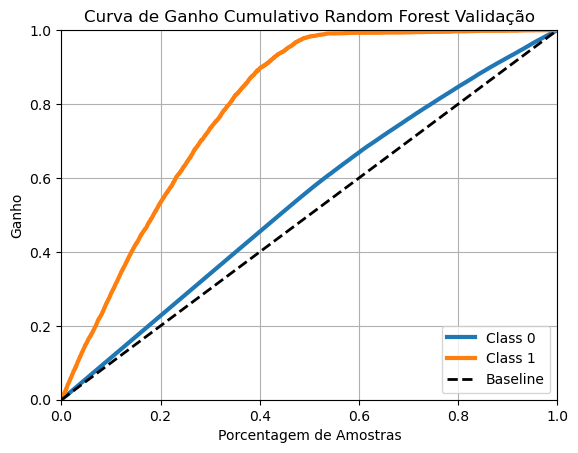

In [60]:
# Curva de Ganho cumulativo

cg = skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );
cg.set_ylabel('Ganho')
cg.set_xlabel('Porcentagem de Amostras')
cg.set_title('Curva de Ganho Cumulativo Random Forest Validação');

#### 7.1.4.2. Cross Validation and Random Search Scikitlearn

In [178]:
# Dados preparados para treino e teste de métricas

# TREINO 
x_train = df_train.copy()
y_train = x_train['remainder__interested'].copy()

# TESTE
x_test = df_test.copy()
y_test = x_test['remainder__interested'].copy()

In [179]:
## Selecionar apenas as colunas que foram selecionadas para treinar modelo

# treino
x_train_final = x_train[ cols_selected ].copy()

# teste
x_test_final = x_test[ cols_selected ].copy()


In [180]:
## Parâmetros default do Gaussian Classifier

rf = RandomForestClassifier()

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [181]:
param_random = {'n_estimators': [100, 500, 1000 ,1500, 1700, 2500, 3000, 3500],
         'criterion': ['gini', 'entropy', 'log_loss'],
         'class_weight': ['balanced', 'balanced_subsample'],
         'max_depth': [3, 5, 9],
         'min_samples_split': [2, 4, 6]}

In [182]:
# instanciamos um RandomizedSearchCV passando o modelo, os parâmetros e o número de K folds:
random_search = RandomizedSearchCV(RandomForestClassifier(), param_random, cv=5, scoring= ml_performance_CV, n_iter=10, verbose = 4, return_train_score=True, n_jobs = -1 )
  # RandomSearchCV: vai rodar o cross validation para cada combinação de parâmetros passada.
  # assim como o cross_val_score, o RandomSearchCV vai usar stratified k-fold cross-validation por padrão para classification, e k-fold para regression.
  #'refit'=True(default): vai retreinar um modelo final com todos os dados (TRAIN e VAL), com os melhores parâmetros em CV encontrados contra VAL. 
        # este modelo estará no objeto RandomSearchCV, e seu score é obtido chamando o método 'score'.

random_search.fit(x_train_final, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [3, 5, 9],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         1700, 2500, 3000,
                                                         3500]},
                   return_train_score=True,
                   scoring=<function ml_performance_CV at 0x000001EF564B1CA0>,
                   verbose=4)

In [183]:
# Modelo com melhores parâmetros encontrados EM VAL:
print("Best estimator: {}".format(random_search.best_estimator_))

Best estimator: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9)


In [184]:
#Resultados detalhados de cada modelo treinado, com cada split em TRAIN e em VAL, e seus scores:
pd.DataFrame(random_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_n_estimators param_min_samples_split param_max_depth param_criterion  param_class_weight                                                                                               params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0      39.396023      0.293910         1.152470        0.033622                100                       2               5        log_loss            balanced  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'log_loss', 'class_we...            0.30455            0.30620            0.30495            0.30935            0.30650          0.30631        0.001687                4             0.36840             0.36860             0.37955             0.35875             0.37120           0.36930         0.006652
1     655.112390      8.190733        22.161435        0.448699               2500                       2               3         entropy            balanced  {'n_estimators': 2500, 'min_samples_split': 2, 'max_depth': 3, 'criterion': 'entropy', 'class_we...            0.29870            0.29955            0.30225            0.29995            0.30115          0.30032        0.001246                7             0.35315             0.35335             0.35150             0.35435             0.35410           0.35329         0.001001
2     435.063687      8.237325        15.117236        0.503180               1700                       6               3         entropy            balanced  {'n_estimators': 1700, 'min_samples_split': 6, 'max_depth': 3, 'criterion': 'entropy', 'class_we...            0.29770            0.30050            0.30050            0.30005            0.30185          0.30012        0.001352                9             0.35175             0.35295             0.35355             0.35410             0.35440           0.35335         0.000941
3      76.071881      0.536468         1.503238        0.076834                100                       2               9         entropy  balanced_subsample  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 9, 'criterion': 'entropy', 'class_wei...            0.30915            0.31020            0.30895            0.31215            0.31115          0.31032        0.001208                1             0.40510             0.40355             0.40035             0.40365             0.40300           0.40313         0.001554
4      24.940818      0.399137         0.978226        0.045729                100                       2               3            gini            balanced  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 3, 'criterion': 'gini', 'class_weight...            0.29935            0.30060            0.30135            0.29995            0.30175          0.30060        0.000880                5             0.34740             0.35490             0.35310             0.35135             0.35415           0.35218         0.002671
5     984.684913      4.764630        21.574559        0.151766               2500                       4               3            gini  balanced_subsample  {'n_estimators': 2500, 'min_samples_split': 4, 'max_depth': 3, 'criterion': 'gini', 'class_weigh...            0.29870            0.30055            0.30065            0.30025            0.30185          0.30040        0.001010                6             0.35260             0.35385             0.35300             0.35485             0.35505           0.35387         0.000972
6    1291.785882      8.617522        36.086800        0.394599               3500                       4               5         entropy            balanced  {'n_estimators': 3500, 'min_samples_split': 4, 'max_depth': 5, 

In [185]:
pd.set_option('max_colwidth', 100)
#Resultados que interessam (performance em TRAIN e VAL):   --> param_gri2
rf_models = pd.DataFrame(random_search.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]
rf_models

rank_test_score                                                                                               params  mean_train_score  mean_test_score
3                1  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 9, 'criterion': 'entropy', 'class_wei...           0.40313          0.31032
9                2  {'n_estimators': 2500, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'gini', 'class_weigh...           0.37175          0.30758
6                3  {'n_estimators': 3500, 'min_samples_split': 4, 'max_depth': 5, 'criterion': 'entropy', 'class_we...           0.37217          0.30722
0                4  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'log_loss', 'class_we...           0.36930          0.30631
4                5  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 3, 'criterion': 'gini', 'class_weight...           0.35218          0.30060

In [186]:
# Score médio com CV em dados de VAL do best_estimator (modelo com melhores params):
print("Mean CV Precison_at_20k (VAL): {:.4f}".format(random_search.best_score_))

#Ajustes no set:
# Mean CV score (VAL): 0.8582  	{'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_leaf': 10}	
# Mean CV score (VAL): 0.8595   {'max_depth': 20, 'max_leaf_nodes': 50, 'min_samples_leaf': 15}	
# Mean CV score (VAL): 0.8599   {'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_leaf': 20}	

Mean CV Precison_at_20k (VAL): 0.3103


In [187]:
# Como mantivemos o (refit=True), chamando .score, o RandomSearchCV retornará o score desse melhor modelo acima, 
  # pois já foi retreinado agora com todos os dados (TRAIN + VAL). No bloco acima, era contra VAL.
trainval_score = grid_search.score( x_train_final, y_train )
print("Precison_at_20k (TRAINVAL): {:.4f}".format( float(trainval_score) ) )

Precison_at_20k (TRAINVAL): 0.3354


In [188]:
#Avaliar como o modelo se sai em TEST (dados inéditos, simulando dados de produção):
test_score = random_search.score(x_test_final, y_test)
print(" Precison_at_20k (TEST): {:.4f}".format( float(test_score) ) )

 Precison_at_20k (TEST): 0.3321


#### 7.1.5.3. Cross Validation and Random Search Manual

In [189]:
## Import train data 

train = pd.read_csv('../data/train.csv')


In [190]:
X_train = train.copy()
y_train = train['interested'].copy()

In [191]:
## Valores possíveis para os parâmetros do modelo LGBM
param = {'n_estimators': [100, 500, 1000 ,1500, 1700, 2500, 3000, 3500],
         'criterion': ['gini', 'entropy', 'log_loss'],
         'class_weight': ['balanced', 'balanced_subsample'],
         'max_depth': [3, 5, 9],
         'min_samples_split': [2, 4, 6]}


# Quantidade iterações (experimentos com valores distintos para testar desempenho)
MAX_EVAL = 10

In [192]:
final_result_rf = pd.DataFrame()

for i in range(MAX_EVAL):
    
    ## Escolher um valor aleatório por iteração para cada parâmetro e armazenar em novo dicionário hp
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    
    ## Display do experimento com valores escolhidos
    
    print(f"\nIteração Nº: {i + 1}")
    
    print( hp )
    
    ## Modelo
    model = RandomForestClassifier( n_estimators = hp['n_estimators'], 
                                    criterion = hp['criterion'],
                                    class_weight = hp['class_weight'],
                                    max_depth = hp['max_depth'], 
                                    min_samples_split = hp['min_samples_split'],  
                                    n_jobs = - 1)
 


    ## Model Name
    model_name = 'RF_i' + str(i + 1)
    
    # Performance
    rf_result_cv = cross_validation(X_train, y_train, 5, model_name , hp, model, cols_selected, rank = [20000], verbose = True)
    final_result_rf = pd.concat([ final_result_rf , rf_result_cv ])



Iteração Nº: 1
{'n_estimators': 100, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth': 9, 'min_samples_split': 2}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 2
{'n_estimators': 500, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 6}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 3
{'n_estimators': 1700, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth': 5, 'min_samples_split': 6}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 4
{'n_estimators': 3500, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth': 9, 'min_samples_split': 6}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 5
{'n_estimators': 3000, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 4}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 6
{'n_estimators': 3000, 'criterion': 'gini', 'class_weight': 'balanced', 'max_depth': 9, 'min_samples_split': 4}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 7
{'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_depth': 9, 'min_samples_split': 2}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 8
{'n_estimators': 1700, 'criterion': 'gini', 'class_weight': 'balanced', 'max_depth': 9, 'min_samples_split': 6}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 9
{'n_estimators': 100, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_depth': 3, 'min_samples_split': 4}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



Iteração Nº: 10
{'n_estimators': 500, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 6}

KFold Number 1


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 2


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 3


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 4


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."



KFold Number 5


C:\Users\alanc\anaconda3\envs\insurance_cross\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [193]:
## DataFrame com resultados de desempenho modelos com valores de parâmetros alterados ordenados por maior performance

final_result_rf.sort_values(by = 'Val Precision_at_20k', ascending = False).reset_index( drop = True )

Algorithm                                                                                           Parameters Train Precision_at_20k Val Precision_at_20k Train Recall_at_20k  Val Recall_at_20k    Train F1_at_20k      Val F1_at_20k
0     RF_i4  {'n_estimators': 3500, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth...      0.4029 +/- 0.0008    0.3103 +/- 0.0011   0.2696 +/- 0.0005   0.8303 +/- 0.003   0.323 +/- 0.0006  0.4518 +/- 0.0016
1     RF_i1  {'n_estimators': 100, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth'...      0.4022 +/- 0.0012     0.3103 +/- 0.001   0.2691 +/- 0.0008  0.8304 +/- 0.0028   0.3224 +/- 0.001  0.4518 +/- 0.0015
2     RF_i8  {'n_estimators': 1700, 'criterion': 'gini', 'class_weight': 'balanced', 'max_depth': 9, 'min_sam...       0.4019 +/- 0.001    0.3102 +/- 0.0011   0.2689 +/- 0.0007  0.8301 +/- 0.0029  0.3222 +/- 0.0008  0.4516 +/- 0.0016
3     RF_i6  {'n_estimators': 3000, 'criterion': 'gini', 'class_weight': 'balanced', 'max_depth': 9, 'min_sam...      0.4024 +/- 0.0008    0.3101 +/- 0.0012   0.2692 +/- 0.0005    0.83 +/- 0.0031  0.3226 +/- 0.0007  0.4515 +/- 0.0017
4     RF_i7  {'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_depth': 9, 'min_...      0.4028 +/- 0.0008    0.3101 +/- 0.0011   0.2695 +/- 0.0006    0.83 +/- 0.0029  0.3229 +/- 0.0007  0.4515 +/- 0.0016
5    RF_i10  {'n_estimators': 500, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min_...      0.3728 +/- 0.0023    0.3069 +/- 0.0011   0.2494 +/- 0.0015   0.8212 +/- 0.003  0.2989 +/- 0.0018  0.4468 +/- 0.0016
6     RF_i2  {'n_estimators': 500, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min_...      0.3725 +/- 0.0006     0.3069 +/- 0.001   0.2492 +/- 0.0004  0.8214 +/- 0.0026  0.2986 +/- 0.0005  0.4469 +/- 0.0014
7     RF_i5  {'n_estimators': 3000, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min...      0.3737 +/- 0.0009    0.3068 +/- 0.0013     0.25 +/- 0.0006   0.821 +/- 0.0034  0.2996 +/- 0.0007  0.4467 +/- 0.0019
8     RF_i3  {'n_estimators': 1700, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth...      0.3735 +/- 0.0015    0.3067 +/- 0.0013    0.2499 +/- 0.001  0.8208 +/- 0.0036  0.2995 +/- 0.0012   0.4466 +/- 0.002
9     RF_i9  {'n_estimators': 100, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_depth': 3,...      0.3541 +/- 0.0039    0.3001 +/- 0.0013   0.2369 +/- 0.0026  0.8032 +/- 0.0036  0.2839 +/- 0.0031    0.437 +/- 0.002

### 7.1.6 Compare Model´s Performance

#### 7.1.6.1. Cross Validation Sckitlearn

In [208]:
models_cv_skt = pd.concat([knn_models, nb_models, lgbm_models, lr_models, rf_models], axis = 0)
models_cv_skt.sort_values(by = 'mean_test_score', ascending = False)

rank_test_score                                                                                               params  mean_train_score  mean_test_score
6                1  {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 8, 'max_depth': 9, 'learning_rate': ...           0.42115          0.31221
9                2  {'subsample': 0.7, 'n_estimators': 3500, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate'...           0.41721          0.31201
5                3  {'subsample': 1.0, 'n_estimators': 3000, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate'...           0.41585          0.31198
3                4  {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 0.001, 'max_depth': 3, 'learning_rat...           0.42095          0.31194
2                5  {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': ...           0.41811          0.31183
3                1  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 9, 'criterion': 'entropy', 'class_wei...           0.40313          0.31032
9                2  {'n_estimators': 2500, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'gini', 'class_weigh...           0.37175          0.30758
1                1                                            {'solver': 'saga', 'class_weight': 'balanced', 'C': 1.05}           0.34545          0.30727
7                2                                       {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 1.05}           0.34551          0.30724
6                2                                          {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 1}           0.34551          0.30724
6                3  {'n_estimators': 3500, 'min_samples_split': 4, 'max_depth': 5, 'criterion': 'entropy', 'class_we...           0.37217          0.30722
4                4                                        {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 0.5}           0.34567          0.30720
3                5                                                  {'solver': 'lbfgs', 'class_weight': None, 'C': 1.1}           0.34743          0.30714
0                4  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'log_loss', 'class_we...           0.36930          0.30631
4                5  {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 3, 'criterion': 'gini', 'class_weight...           0.35218          0.30060
3                1                                                           {'n_neighbors': 19, 'metric': 'manhattan'}           0.46509          0.29326
1                2                                                           {'n_neighbors': 19, 'metric': 'euclidean'}           0.46299          0.29248
0                3                                                           {'n_neighbors': 17, 'metric': 'manhattan'}           0.47426          0.29145
2                4                                                           {'n_neighbors': 17, 'metric': 'euclidean'}           0.47105          0.29079
5                1                                                                             {'var_smoothing': 1e-30}           0.31198          0.28940
4                1                                                                             {'var_smoothing': 1e-25}           0.31198          0.28940
3                1                                                                             {'var_smoothing': 1e-16}           0.31198          0.28940
2                1                                                                             {'var_smoothing': 1e-13}           0.31198          0.28940
1                1                                                                             {'var_smoothing': 1e-09}           0.31198          0.28940
7                5                                                           {'n_neighbors': 11, 'metric': 'manhattan'}         

#### 7.1.6.2. Cross Validation Manual

In [200]:
models_cv = pd.concat([final_result_knn, final_result_nb, final_result_lgbm, final_result_lr, final_result_rf], axis = 0)
models_cv.sort_values(by = 'Val Precision_at_20k', ascending = False)

Algorithm                                                                                           Parameters Train Precision_at_20k Val Precision_at_20k Train Recall_at_20k  Val Recall_at_20k    Train F1_at_20k      Val F1_at_20k
0   LGBM_i8  {'n_estimators': 100, 'learning_rate': 0.05, 'class_weight': None, 'max_depth': -1, 'subsample':...      0.4218 +/- 0.0009     0.311 +/- 0.0011   0.2822 +/- 0.0006  0.8322 +/- 0.0029  0.3381 +/- 0.0007  0.4527 +/- 0.0016
0   LGBM_i3  {'n_estimators': 100, 'learning_rate': 0.05, 'class_weight': 'balanced', 'max_depth': 9, 'subsam...      0.4115 +/- 0.0009     0.311 +/- 0.0009   0.2753 +/- 0.0006  0.8322 +/- 0.0025  0.3299 +/- 0.0007  0.4527 +/- 0.0014
0   LGBM_i6  {'n_estimators': 3000, 'learning_rate': 0.01, 'class_weight': 'balanced', 'max_depth': 9, 'subsa...      0.4566 +/- 0.0018     0.311 +/- 0.0008   0.3055 +/- 0.0012  0.8322 +/- 0.0022  0.3661 +/- 0.0015  0.4528 +/- 0.0012
0   LGBM_i9  {'n_estimators': 100, 'learning_rate': 0.3, 'class_weight': 'balanced', 'max_depth': 5, 'subsamp...      0.4286 +/- 0.0014    0.3108 +/- 0.0009    0.2868 +/- 0.001  0.8318 +/- 0.0025  0.3436 +/- 0.0011  0.4526 +/- 0.0014
0   LGBM_i2  {'n_estimators': 3500, 'learning_rate': 0.01, 'class_weight': 'balanced', 'max_depth': -1, 'subs...      0.4702 +/- 0.0023    0.3106 +/- 0.0007   0.3146 +/- 0.0016  0.8312 +/- 0.0017   0.377 +/- 0.0019   0.4522 +/- 0.001
0     RF_i4  {'n_estimators': 3500, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth...      0.4029 +/- 0.0008    0.3103 +/- 0.0011   0.2696 +/- 0.0005   0.8303 +/- 0.003   0.323 +/- 0.0006  0.4518 +/- 0.0016
0     RF_i1  {'n_estimators': 100, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'max_depth'...      0.4022 +/- 0.0012     0.3103 +/- 0.001   0.2691 +/- 0.0008  0.8304 +/- 0.0028   0.3224 +/- 0.001  0.4518 +/- 0.0015
0     RF_i8  {'n_estimators': 1700, 'criterion': 'gini', 'class_weight': 'balanced', 'max_depth': 9, 'min_sam...       0.4019 +/- 0.001    0.3102 +/- 0.0011   0.2689 +/- 0.0007  0.8301 +/- 0.0029  0.3222 +/- 0.0008  0.4516 +/- 0.0016
0     RF_i6  {'n_estimators': 3000, 'criterion': 'gini', 'class_weight': 'balanced', 'max_depth': 9, 'min_sam...      0.4024 +/- 0.0008    0.3101 +/- 0.0012   0.2692 +/- 0.0005    0.83 +/- 0.0031  0.3226 +/- 0.0007  0.4515 +/- 0.0017
0     RF_i7  {'n_estimators': 1000, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_depth': 9, 'min_...      0.4028 +/- 0.0008    0.3101 +/- 0.0011   0.2695 +/- 0.0006    0.83 +/- 0.0029  0.3229 +/- 0.0007  0.4515 +/- 0.0016
0  LGBM_i10  {'n_estimators': 1000, 'learning_rate': 0.3, 'class_weight': None, 'max_depth': 3, 'subsample': ...      0.4763 +/- 0.0009     0.3098 +/- 0.001   0.3186 +/- 0.0006  0.8291 +/- 0.0027  0.3818 +/- 0.0008  0.4511 +/- 0.0015
0   LGBM_i4  {'n_estimators': 1000, 'learning_rate': 0.1, 'class_weight': 'balanced', 'max_depth': 5, 'subsam...       0.4984 +/- 0.003    0.3083 +/- 0.0008    0.3334 +/- 0.002  0.8251 +/- 0.0021  0.3995 +/- 0.0024  0.4489 +/- 0.0012
0    RF_i10  {'n_estimators': 500, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min_...      0.3728 +/- 0.0023    0.3069 +/- 0.0011   0.2494 +/- 0.0015   0.8212 +/- 0.003  0.2989 +/- 0.0018  0.4468 +/- 0.0016
0     RF_i2  {'n_estimators': 500, 'criterion': 'log_loss', 'class_weight': 'balanced', 'max_depth': 5, 'min_...      0.3725 +/- 0.0006     0.3069 +/- 0.001   0.2492 +/- 0.0004  0.8214 +/- 0.0026  0.2986 +/- 0.0005  0.4469 +/- 0.0014
0     LR_i2                                              {'solver': 'liblinear', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0012    0.3068 +/- 0.0018   0.2326 +/- 0.0008   0.821 +/- 0.0047  0.2787 +/- 0.0009  0.4467 +/- 0.0026
0    LR_i10                                              {'solver': 'liblinear', 'C': 1.1, 'class_weight': None}      0.3477 +/- 0.0012    0.3068 +/- 0.0018   0.2326 +/- 0.0008   0.821 +/- 0.0047  0.2787 +/- 0.0009  0.4467 +/- 0.0026
0     LR_i4             

#### 7.1.6.3. Analysis

- O experimento de fazer manualmente o processo de Cross Validation atrelado a escolha dos melhores parâmetros garantindo o não vazamento de dados (separação treino e validação antes das transformações) em comparação com o mesmo processo utilizando a função RandomizedSearchCV do Sklearn, considerando vazamento de dados demonstrou pelos resultados semelhantes entre os experimentos que o vazamento de dados possui impacto mínimo no desempenho do modelo para o fenômeno observado;




- Os modelos que obtiveram melhores resultados foram o LGBM, Random Forest e o Regressão Logística. Porém, LGBM e o Random Forest acabaram tendo seus resultados de treino e validação bastante overfittados. Ou seja, os modelos com os parâmetros escolhidos treinados pelo otimizador Random Search possuem bom resultado em dados de treino mas possuem desempenho menor para dados nunca vistos (poder de generalização baixo). 





#### 7.1.6.4. Learnings

- Fazer o cross validation e a otimização dos parâmetros para todos os modelos e testar é custoso (alto processamento e demorado). Em projetos futuros, o interessante seria realizar o cross validation inicial com modelos padrão e assim, selecionar 2 melhores para fazer a otimização dos parâmetros na sequência.  





- Pelo poder computacional da máquina atrelado ao otimizador escolhido, não foi possível testar todos os parâmetros dos modelos, sendo essa uma possível razão para que os algoritmos LGBM e Random Forest possam ter apresentado overfitting. Em um cenário ideal mais parâmetros deveriam ser testados para averiguar os melhores modelos. 


#### 7.1.6.5. Decision

- Assumindo o overfitting nos modelos Random Forest e LGBM, levaremos esses e o Logistic Regression para a etapa de teste com seus melhores parâmetros encontrados para assim plotar a curva de ganho cumulativo e de lift e decidir o algoritmo que será colocado em produção. 

- LGBM - {'n_estimators': 500, 'learning_rate': 0.05, 'class_weight': 'balanced', 'max_depth': 9, 
          'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 0.001}


- LR - {'solver': 'saga', 'class_weight': 'balanced', 'C': 1.05}
- RF - {'n_estimators': 2500, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'gini', 'class_weight: balanced}

## 7.2. Test

In [23]:
# Dados preparados para treino e teste de métricas

# TREINO 
x_train = df_train.copy()
y_train = x_train['remainder__interested'].copy()

# TESTE
x_test = df_test.copy()
y_test = x_test['remainder__interested'].copy()

In [24]:
## Selecionar apenas as colunas que foram selecionadas para treinar modelo

# treino
x_train_final = x_train[ cols_selected ].copy()

# teste
x_test_final = x_test[ cols_selected ].copy()



### 7.2.1. LGBM

In [28]:
# model definition with best parameters

model_lgbm = lgb.LGBMClassifier(n_estimators = 500, learning_rate = 0.05, class_weight = 'balanced', max_depth = 9,
                                 subsample= 0.7, colsample_bytree= 0.3, min_child_weight = 0.001)

# model fit 

model_lgbm.fit( x_train_final, y_train )


# model predict - Capacidade de aprendizado do modelo

yhat_lgbm_test = model_lgbm.predict_proba( x_test_final )



In [56]:
##### MÉTRICAS DE AVALIAÇÃO

k = [20000]


result_lgbm_test = ml_performance( y_test, yhat_lgbm_test, k )


result_lgbm_test["model"] = "LGBM"

result_lgbm_test = result_lgbm_test.reset_index(drop = True)

result_lgbm_test

precision_at_k  recall_at_k   F1_at_k model
0          0.3355     0.718262  0.457365  LGBM

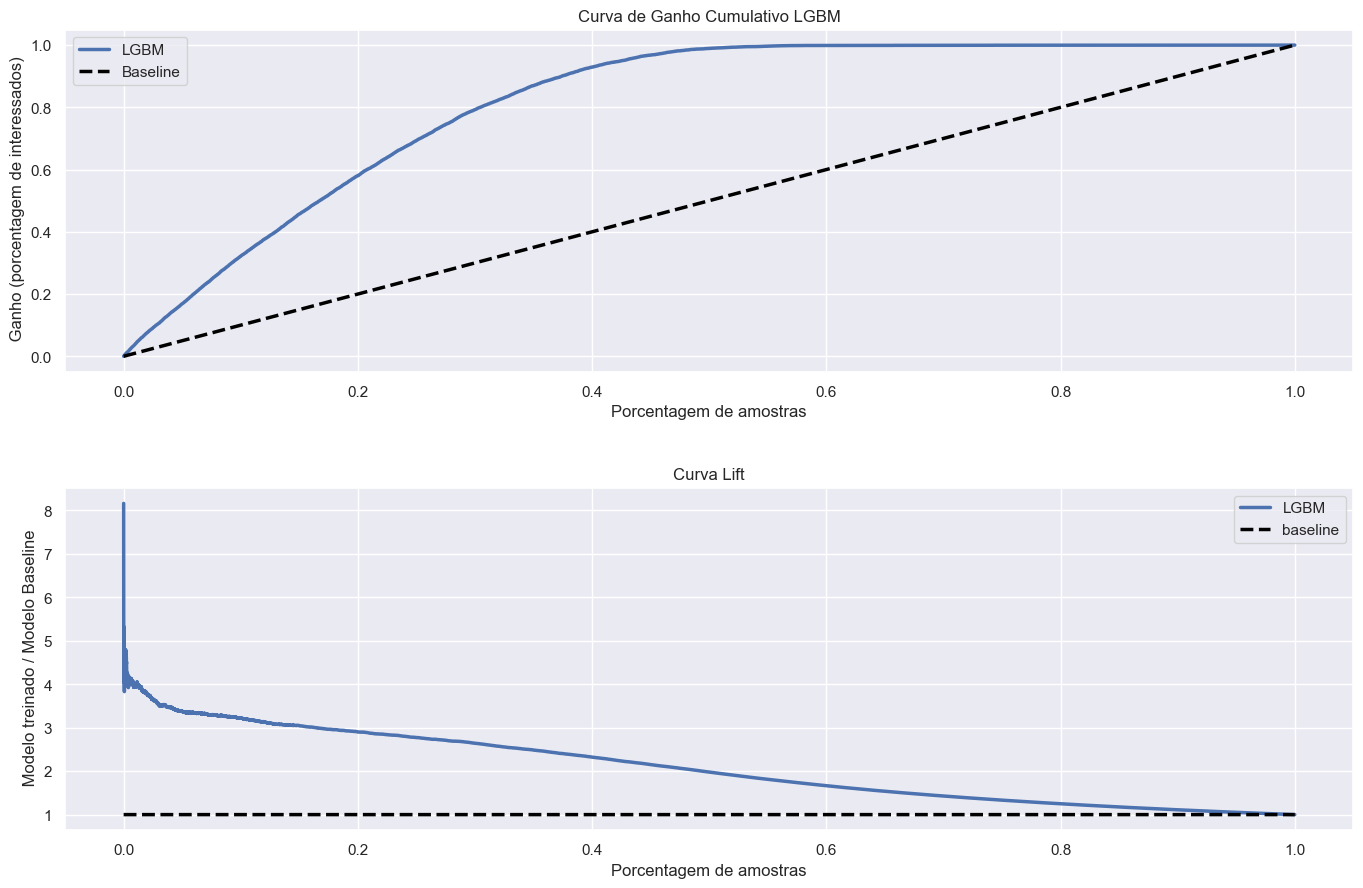

In [29]:
### CURVA DE GANHO ACUMULADO E LIFT Feita manualmente

df_prop_score_lgbm = curves(y_test, yhat_lgbm_test, 'LGBM', (15,10), plot = True, axvline= "None")

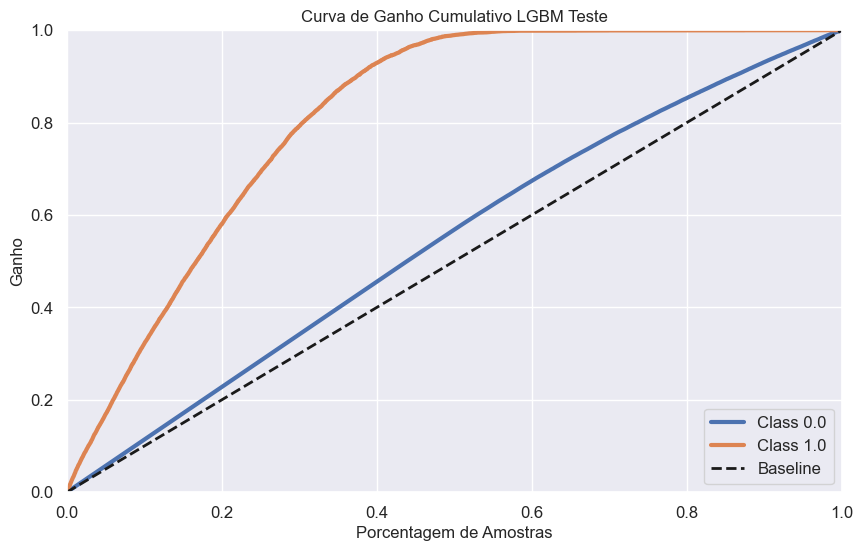

In [43]:
### CURVA DE GANHO ACUMULADO E LIFT Feita com biblioteca Skplot


# Curva de Ganho cumulativo

cg_lgbm = skplt.metrics.plot_cumulative_gain( y_test, yhat_lgbm_test, figsize = (10,6) );
cg_lgbm.set_ylabel('Ganho') #Propensão de compra LGBM Teste
cg_lgbm.set_xlabel('Porcentagem de Amostras')
cg_lgbm.set_title('Curva de Ganho Cumulativo LGBM Teste');
plt.show()

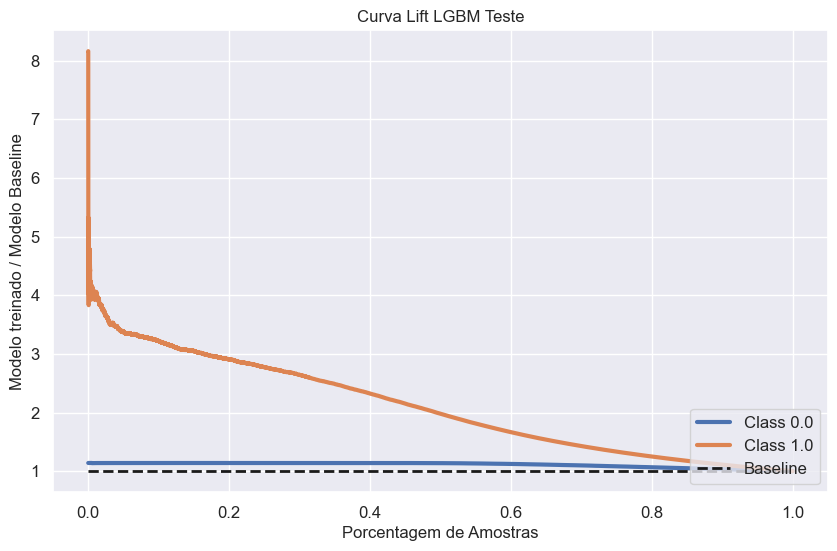

In [29]:
lf_knn = skplt.metrics.plot_lift_curve(y_test, yhat_lgbm_test, figsize = (10,6))
lf_knn.set_ylabel('Modelo treinado / Modelo Baseline') #Quantidade de vezes que o modelo treinado de rankeamento é melhor que o de média
lf_knn.set_xlabel('Porcentagem de Amostras')
lf_knn.set_title('Curva Lift LGBM Teste');
plt.show()

In [33]:
df_prop_score_lgbm

target  prop_score  porc_base_acum  porc_int_acum      lift
0         1.0    0.930432        0.000013       0.000107  8.159067
1         1.0    0.919022        0.000026       0.000214  8.159067
2         0.0    0.917881        0.000039       0.000214  5.439378
3         1.0    0.911503        0.000052       0.000321  6.119300
4         1.0    0.909180        0.000066       0.000428  6.527253
...       ...         ...             ...            ...       ...
76217     0.0    0.000078        0.999948       1.000000  1.000052
76218     0.0    0.000070        0.999961       1.000000  1.000039
76219     0.0    0.000061        0.999974       1.000000  1.000026
76220     0.0    0.000059        0.999987       1.000000  1.000013
76221     0.0    0.000027        1.000000       1.000000  1.000000

[76222 rows x 5 columns]

### 7.2.2. Random Forest

In [30]:
# model definition with best parameters

model_rfc = RandomForestClassifier( n_estimators = 2500, min_samples_split = 2, max_depth = 5, criterion = 'gini', class_weight = 'balanced' )

# model fit 

model_rfc.fit( x_train_final, y_train )

# model predict - Capacidade de aprendizado do modelo

yhat_rfc = model_rfc.predict_proba( x_test_final )



In [57]:
##### MÉTRICAS DE AVALIAÇÃO

k = [20000]


result_rf_test = ml_performance( y_test, yhat_rfc, k )

result_rf_test['model'] = "Random Forest"

result_rf_test = result_rf_test.reset_index(drop = True)

result_rf_test 

precision_at_k  recall_at_k   F1_at_k          model
0          0.3297     0.705845  0.449458  Random Forest

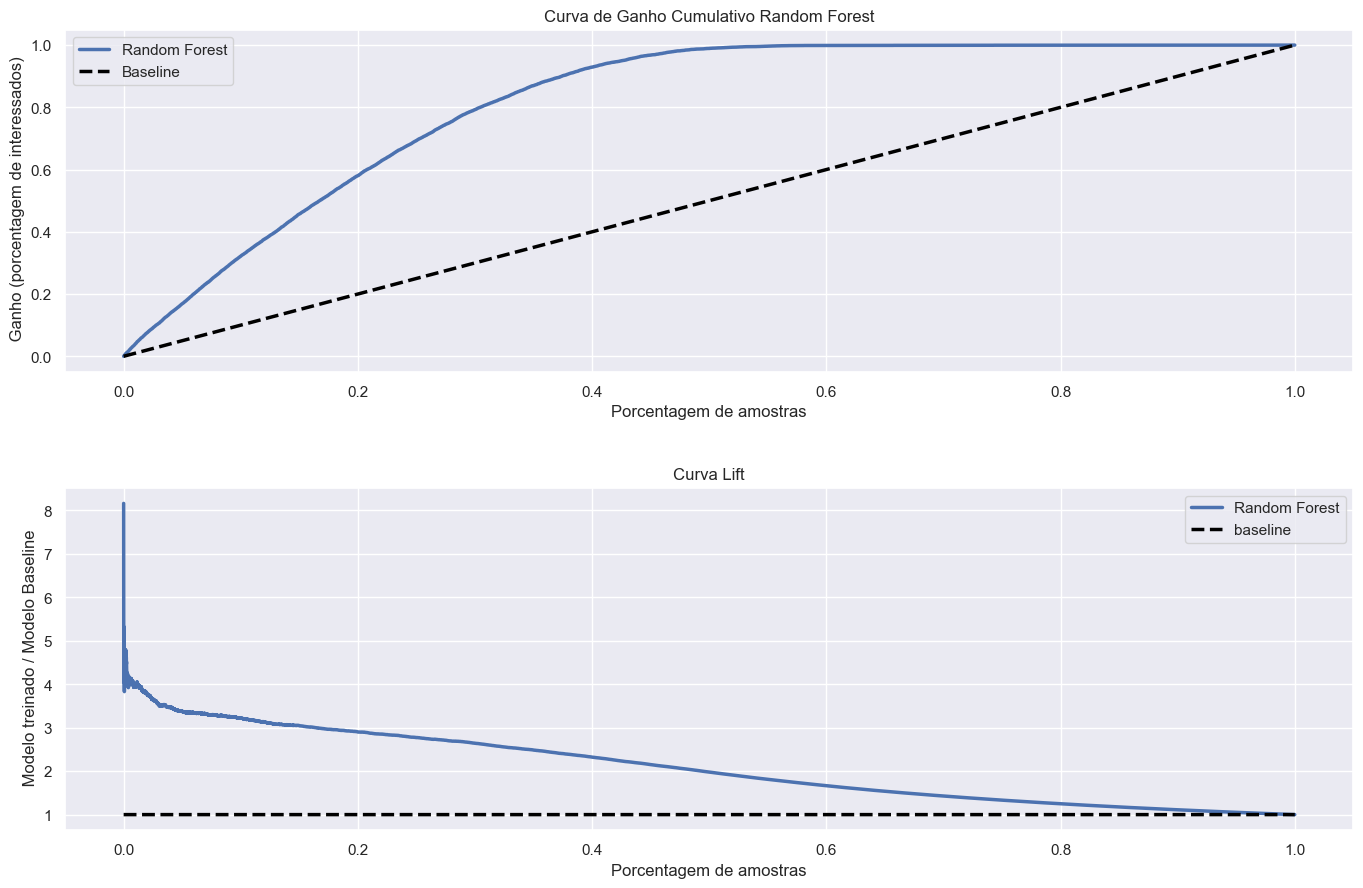

In [31]:
### CURVA DE GANHO ACUMULADO E LIFT Feita manualmente

df_prop_score_rf = curves(y_test, yhat_rfc, 'Random Forest', (15,10), plot = True, axvline= "None")

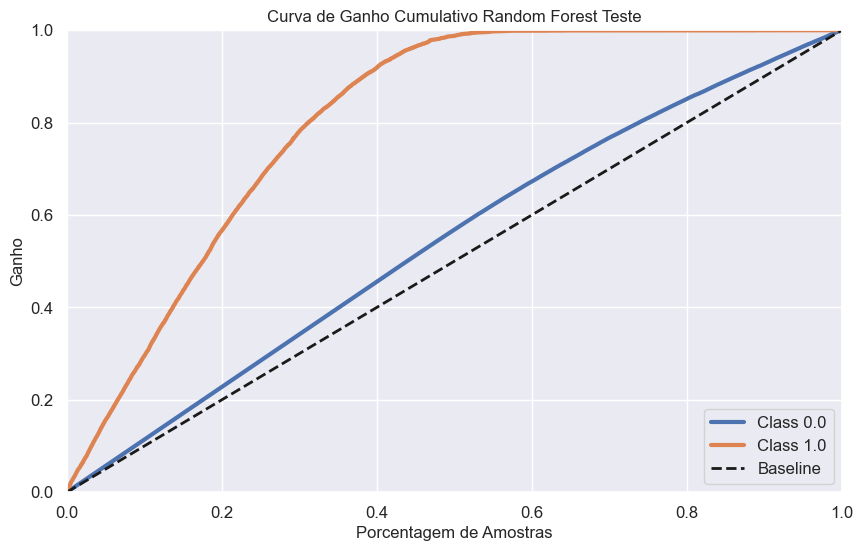

In [26]:
### CURVA DE GANHO ACUMULADO E LIFT Feita com biblioteca Skplot
# Curva de Ganho cumulativo

cg_knn = skplt.metrics.plot_cumulative_gain( y_test, yhat_rfc, figsize = (10,6) );
cg_knn.set_ylabel('Ganho') #Propensão de compra RF teste
cg_knn.set_xlabel('Porcentagem de Amostras')
cg_knn.set_title('Curva de Ganho Cumulativo Random Forest Teste');
plt.show()

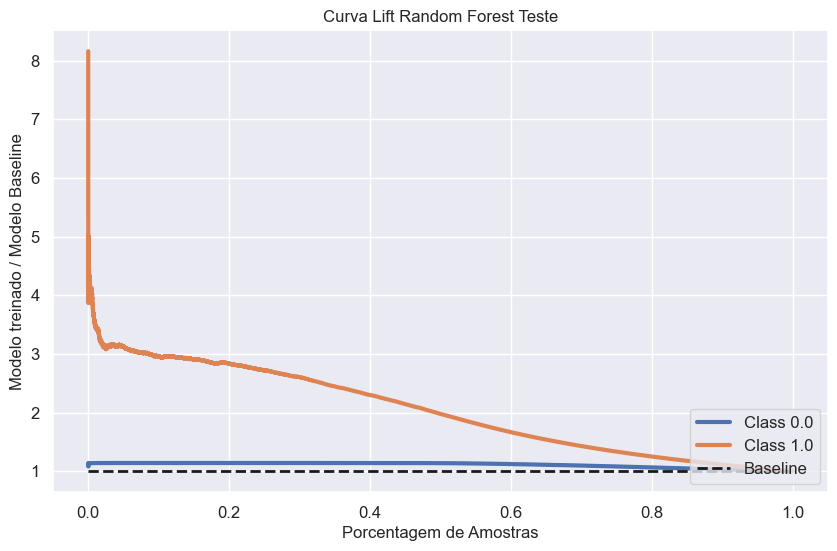

In [27]:
lf_knn = skplt.metrics.plot_lift_curve(y_test, yhat_rfc, figsize = (10,6))
lf_knn.set_ylabel('Modelo treinado / Modelo Baseline') #Quantidade de vezes que o modelo treinado de rankeamento é melhor que o de média
lf_knn.set_xlabel('Porcentagem de Amostras')
lf_knn.set_title('Curva Lift Random Forest Teste');
plt.show()

In [35]:
df_prop_score_rf

target  prop_score  porc_base_acum  porc_int_acum      lift
0         1.0    0.930432        0.000013       0.000107  8.159067
1         1.0    0.919022        0.000026       0.000214  8.159067
2         0.0    0.917881        0.000039       0.000214  5.439378
3         1.0    0.911503        0.000052       0.000321  6.119300
4         1.0    0.909180        0.000066       0.000428  6.527253
...       ...         ...             ...            ...       ...
76217     0.0    0.000078        0.999948       1.000000  1.000052
76218     0.0    0.000070        0.999961       1.000000  1.000039
76219     0.0    0.000061        0.999974       1.000000  1.000026
76220     0.0    0.000059        0.999987       1.000000  1.000013
76221     0.0    0.000027        1.000000       1.000000  1.000000

[76222 rows x 5 columns]

### 7.2.3. Logistic Regression

In [32]:
# model definition with best parameters

model_lr = LogisticRegression( solver = 'saga', class_weight = 'balanced', C = 1.05 )

# model fit 

model_lr.fit( x_train_final, y_train )

# model predict - Capacidade de aprendizado do modelo

yhat_lr = model_lr.predict_proba( x_test_final )



In [59]:
##### MÉTRICAS DE AVALIAÇÃO

k = [20000]


result_lr_test = ml_performance( y_test, yhat_lr, k )


result_lr_test['model'] = "Logistic Regressor"

result_lr_test = result_lr_test.reset_index( drop = True )

result_lr_test 

precision_at_k  recall_at_k   F1_at_k               model
0         0.32605      0.69803  0.444482  Logistic Regressor

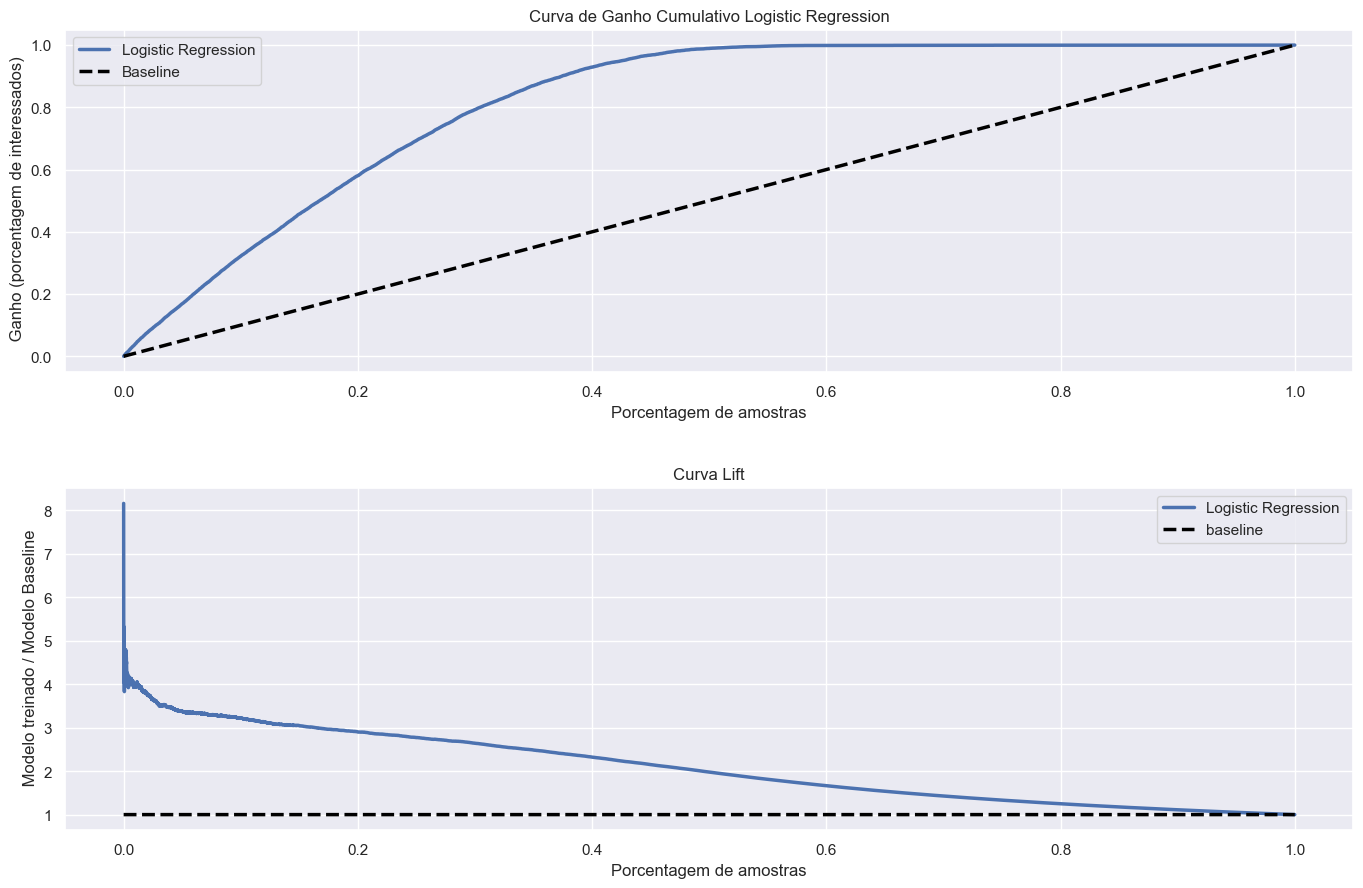

In [33]:
### CURVA DE GANHO ACUMULADO E LIFT Feita manualmente

df_prop_score_lr = curves(y_test, yhat_lr, 'Logistic Regression', (15,10), plot = True, axvline= "None")

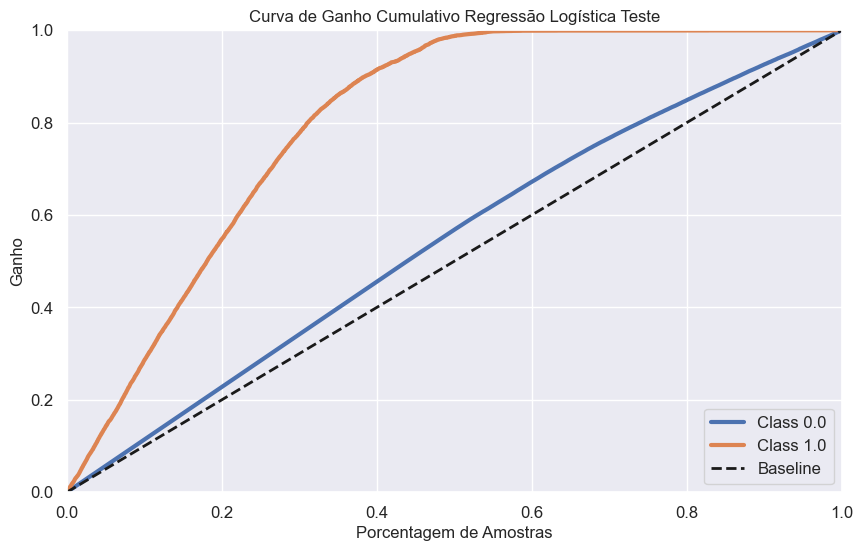

In [39]:
# Curva de Ganho cumulativo

cg_lr = skplt.metrics.plot_cumulative_gain( y_test, yhat_lr, figsize = (10,6) );

cg_lr.set_ylabel('Ganho') #Propensão de compra Regressão Logística Teste
cg_lr.set_xlabel('Porcentagem de Amostras')
cg_lr.set_title('Curva de Ganho Cumulativo Regressão Logística Teste');
plt.show()

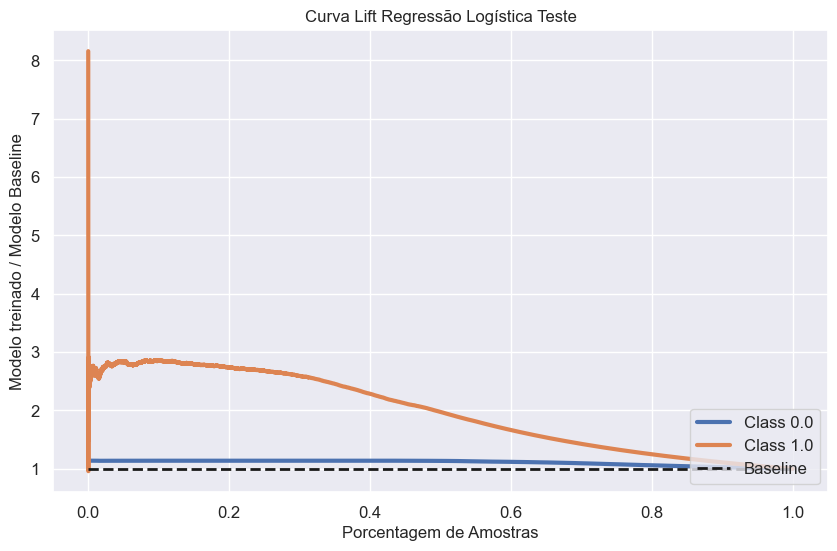

In [31]:
lf_knn = skplt.metrics.plot_lift_curve(y_test, yhat_lr, figsize = (10,6))
lf_knn.set_ylabel('Modelo treinado / Modelo Baseline') #Quantidade de vezes que o modelo treinado de rankeamento é melhor que o de média
lf_knn.set_xlabel('Porcentagem de Amostras')
lf_knn.set_title('Curva Lift Regressão Logística Teste');
plt.show()

In [34]:
df_prop_score_lr

target  prop_score  porc_base_acum  porc_int_acum      lift
0         1.0    0.930432        0.000013       0.000107  8.159067
1         1.0    0.919022        0.000026       0.000214  8.159067
2         0.0    0.917881        0.000039       0.000214  5.439378
3         1.0    0.911503        0.000052       0.000321  6.119300
4         1.0    0.909180        0.000066       0.000428  6.527253
...       ...         ...             ...            ...       ...
76217     0.0    0.000078        0.999948       1.000000  1.000052
76218     0.0    0.000070        0.999961       1.000000  1.000039
76219     0.0    0.000061        0.999974       1.000000  1.000026
76220     0.0    0.000059        0.999987       1.000000  1.000013
76221     0.0    0.000027        1.000000       1.000000  1.000000

[76222 rows x 5 columns]

In [37]:
# Export/save dataframes into .csv

#df_prop_score_lgbm.to_csv('../data/int/prop_lift_score_lgbm.csv', index = False)
#df_prop_score_rf.to_csv('../data/int/prop_lift_score_rf.csv', index = False)
#df_prop_score_lr.to_csv('../data/int/prop_lift_score_lr.csv', index = False)

In [38]:
## Simuling perfect model 

df_prop_score_perfect = df_prop_score_lr.copy()

In [39]:
# Total de reais interessados na base
df_prop_score_perfect['target'].sum()

9342.0

In [43]:

## Colocando toda a quantidade de interessados encima e a de não interessados embaixo

df_prop_score_perfect.loc[0:9342, ['target']] = 1.0 
df_prop_score_perfect.loc[9342:, ['target']] = 0.0 

## Porcentagem equivalente a cada interessado real na base de dados
porc_one_int = 1/ df_prop_score_perfect['target'].sum()

## Calculo de Score de propensão de compra acumulada
df_prop_score_perfect['porc_int_acum'] = df_prop_score_perfect['target'].cumsum() * porc_one_int

## Cálculo do Lift 
df_prop_score_perfect['lift'] = df_prop_score_perfect['porc_int_acum'] / df_prop_score_perfect['porc_base_acum']

In [48]:
df_prop_score_perfect

target  prop_score  porc_base_acum  porc_int_acum      lift
0         1.0    0.930432        0.000013       0.000107  8.159067
1         1.0    0.919022        0.000026       0.000214  8.159067
2         1.0    0.917881        0.000039       0.000321  8.159067
3         1.0    0.911503        0.000052       0.000428  8.159067
4         1.0    0.909180        0.000066       0.000535  8.159067
...       ...         ...             ...            ...       ...
76217     0.0    0.000078        0.999948       1.000000  1.000052
76218     0.0    0.000070        0.999961       1.000000  1.000039
76219     0.0    0.000061        0.999974       1.000000  1.000026
76220     0.0    0.000059        0.999987       1.000000  1.000013
76221     0.0    0.000027        1.000000       1.000000  1.000000

[76222 rows x 5 columns]

In [49]:
#df_prop_score_perfect.to_csv('../data/int/prop_lift_score_perfect.csv', index = False)

### 7.2.4. Compare Model´s Performance

In [50]:
## Leitura dos df salvos

## Import train data 

df_prop_score_perfect = pd.read_csv('../data/int/prop_lift_score_perfect.csv')
df_prop_score_lgbm = pd.read_csv('../data/int/prop_lift_score_lgbm.csv')
df_prop_score_rf = pd.read_csv('../data/int/prop_lift_score_rf.csv')
df_prop_score_lr = pd.read_csv('../data/int/prop_lift_score_lr.csv')

#### 7.2.4.1. Metrics

In [61]:
models_result = pd.concat([result_lgbm_test, result_rf_test, result_lr_test], axis = 0)
models_result.sort_values(by = "precision_at_k", ascending = False ).reset_index( drop = True )

precision_at_k  recall_at_k   F1_at_k               model
0         0.33550     0.718262  0.457365                LGBM
1         0.32970     0.705845  0.449458       Random Forest
2         0.32605     0.698030  0.444482  Logistic Regressor

**Análise:**


- O modelo LGBM possui desempenho em precision_at_k com k = 20.000 ligeiramente melhor que os modelos de Random Forest e Logistic Regression, com isso, ele será levado para produção;



- Escolheu-se como métrica referência a precision_at_k devido a natureza da solução e para comparar os resultados nas etapas de validação e teste onde o tamanho do conjunto de dados é diferente entre eles, já que a precision_at_k leva em conta o resultado alcançado para as k amostras da lista.

#### 7.2.4.2. Curva de Ganho Acumulado

Analise-se baseado na quantidade de amostras a qual queremos ordenar, qual a eficiência da ordenação com relação a variável de interesse pretendida a ter melhores acertos.  

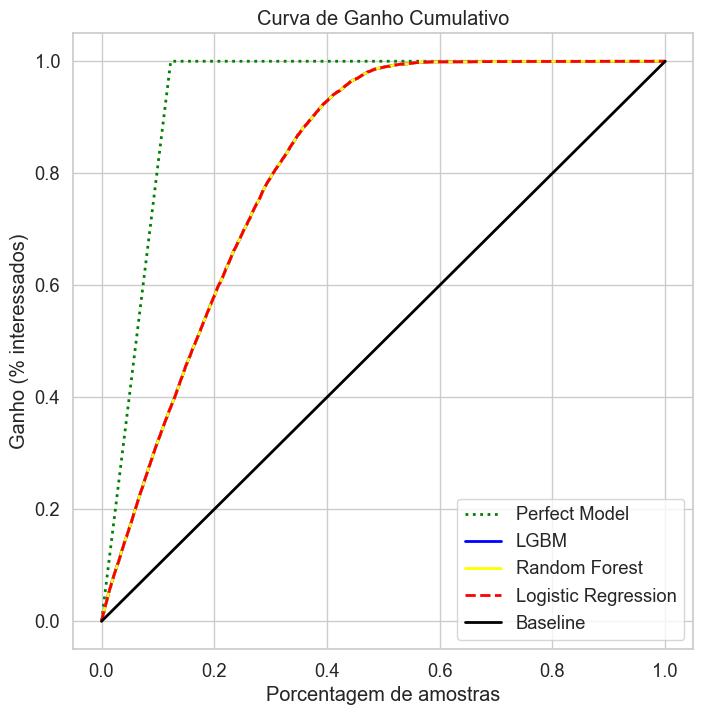

In [58]:
# restore to default matplotlib and seaborn configuration
matplotlib.rc_file_defaults()
sns.reset_orig
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

# plot the graphics
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the graphics
sns.lineplot(ax = ax, x = df_prop_score_perfect['porc_base_acum'], y = df_prop_score_perfect['porc_int_acum'], label="Perfect Model", linewidth = 2, color = 'green')
sns.lineplot(ax = ax, x = df_prop_score_lgbm['porc_base_acum'], y = df_prop_score_lgbm['porc_int_acum'], label="LGBM", linewidth = 2, color = 'blue')
sns.lineplot(ax = ax, x = df_prop_score_rf['porc_base_acum'], y = df_prop_score_rf['porc_int_acum'], label="Random Forest", linewidth = 2, color = 'yellow')
sns.lineplot(ax = ax, x = df_prop_score_lr['porc_base_acum'], y = df_prop_score_lr['porc_int_acum'], label="Logistic Regression", linewidth = 2, color = 'red')
sns.lineplot(ax = ax, x = df_prop_score_lr['porc_base_acum'], y = df_prop_score_lr['porc_base_acum'], label="Baseline", linewidth = 2, color = 'black')

ax.lines[0].set_linestyle(":")
ax.lines[3].set_linestyle("--")

ax.legend()
ax.set_title("Curva de Ganho Cumulativo")
ax.set_xlabel("Porcentagem de amostras")
ax.set_ylabel("Ganho (% interessados)")

ax.plot;

#### 7.2.4.3. Curva Lift

Indica quanto os algoritmos de ordenação desenvolvidos no projeto são melhores que um modelo de média (baseline) que iria ordenar de forma aleatória a lista.

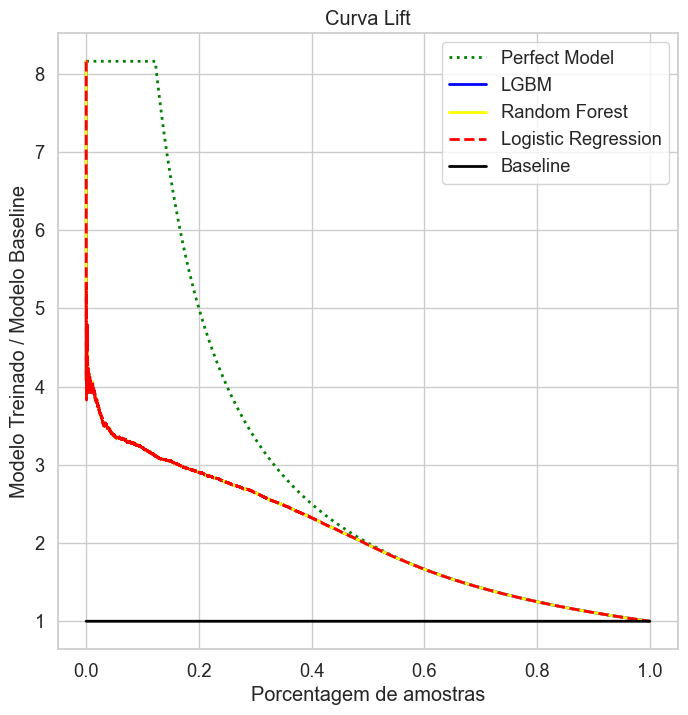

In [60]:
#sns.set()
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

# plot the graphics
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.lineplot(ax = ax, x = df_prop_score_perfect['porc_base_acum'], y = df_prop_score_perfect['lift'], label="Perfect Model", linewidth = 2, color = 'green')
sns.lineplot(ax = ax, x = df_prop_score_lgbm['porc_base_acum'], y = df_prop_score_lgbm['lift'], label="LGBM", linewidth = 2, color = 'blue')
sns.lineplot(ax = ax, x = df_prop_score_rf['porc_base_acum'], y = df_prop_score_rf['lift'], label="Random Forest", linewidth = 2, color = 'yellow')
sns.lineplot(ax = ax, x = df_prop_score_lr['porc_base_acum'], y = df_prop_score_lr['lift'], label="Logistic Regression", linewidth = 2, color = 'red')
sns.lineplot(ax = ax, x = df_prop_score_perfect['porc_base_acum'], y = np.ones(len(df_prop_score_perfect)), label="Baseline", linewidth = 2, color = 'black')

ax.lines[0].set_linestyle(":")
ax.lines[3].set_linestyle("--")

ax.legend()
ax.set_title("Curva Lift")
ax.set_xlabel("Porcentagem de amostras")
ax.set_ylabel("Modelo Treinado / Modelo Baseline")


ax.plot;

### 7.2.5. Final Model

In [83]:
# model definition with best parameters

model_final = lgb.LGBMClassifier(n_estimators = 500, learning_rate = 0.05, class_weight = 'balanced', max_depth = 9,
                                 subsample= 0.7, colsample_bytree= 0.3, min_child_weight = 0.001)

# model fit 

model_final.fit( x_train_final, y_train )


# model predict - Capacidade de aprendizado do modelo

yhat_proba_final = model_final.predict_proba( x_test_final )

In [85]:
## Armazenar modelo treinado após o ajuste de parâmetros
#pickle.dump(model_final, open('C:/Users/alanc/Documents/repos/insurance_cross_sell/insurance_cross_sell/models/model_lgbm.pkl', 'wb'))

#### 7.2.5.1. Machine Learning Performance

In [84]:
##### MÉTRICAS DE AVALIAÇÃO

k = [10000, 20000, 30000, 40000]


result_lgbm_test = ml_performance( y_test, yhat_proba_final, k )

result_lgbm_test = result_lgbm_test.reset_index(drop = True)

df_rank = pd.DataFrame({'rank': k})
    
result_lgbm_test = pd.concat([df_rank, result_lgbm_test], axis = 1)   


result_lgbm_test["model"] = "LGBM"


result_lgbm_test

rank  precision_at_k  recall_at_k   F1_at_k model
0  10000          0.3772     0.403768  0.390032  LGBM
1  20000          0.3355     0.718262  0.457365  LGBM
2  30000          0.2876     0.923571  0.438615  LGBM
3  40000          0.2321     0.993791  0.376312  LGBM

# 8.0. TRADUÇÃO E INTERPRETAÇÃO 

Converter resultados do modelo de machine learning em métricas de negócio, ou seja, se o modelo for implementado qual a efetividade dele na tarefa pretendida convertendo para valores financeiros.

## 8.1. Questões de Negócio Requeridas

### 8.1.1. A área comercial alinhou com a área de produto, visando otimizar a operação, que o time de Outbound possui capacidade de entrar em contato direto com apenas 20 mil potenciais clientes, sendo assim, qual a porcentagem de clientes interessados em seguro para automóvel o time de Outbound da área comercial conseguirá contatar ?

**Curva de Ganho Acumulado:**

A qual nos mostra com clareza baseado na quantidade de amostras a qual queremos abordar a porcentagem de interessados em compra. 
Com isso, o negócio pode decidir a quantidade de amostras com melhor custo retorno.

In [88]:
porc_base_20k = 20000 / len(df_prop_score_model_final)
porc_base_20k

0.2623914355435439

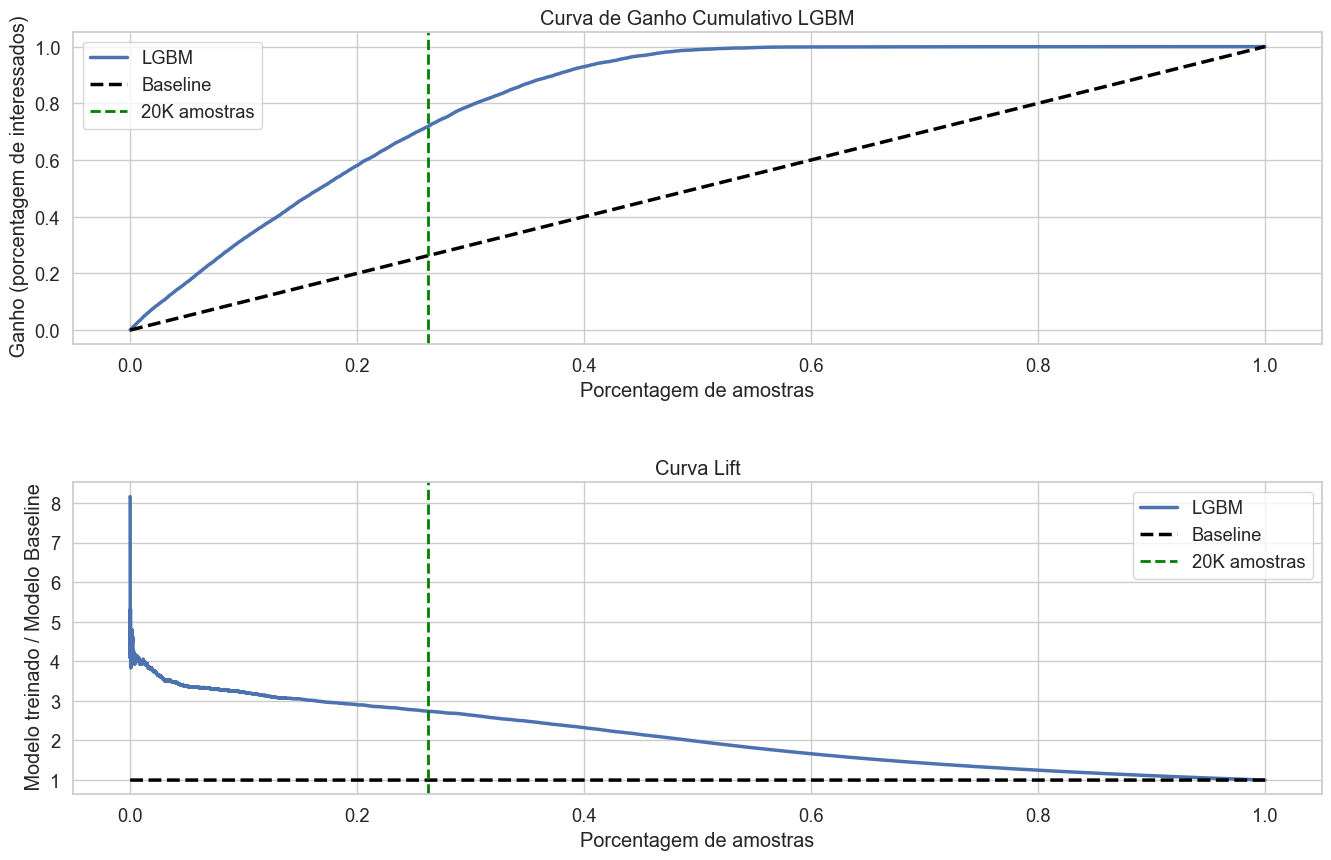

In [255]:
label_line = "20K amostras"


df_prop_score_model_final = curves(y_test, yhat_proba_final, 'LGBM', (15,10), plot = True, axvline= [ label_line , porc_base_20k])

In [100]:
df_prop_score_model_final.loc[ 19999:19999, [ "porc_int_acum", "lift", "porc_base_acum" ] ]

porc_int_acum      lift  porc_base_acum
19999       0.718262  2.737367        0.262391

In [98]:
quant_int = df_prop_score_model_final['target'].sum() 

quant_int

9342.0

In [99]:
0.718262*quant_int

6710.0036039999995

In [101]:
0.262391*quant_int

2451.256722

**Resposta:** 

- O time da área comercial conseguirá contatar 71,82% de clientes interessados em seguro para automóvel utilizando o algoritmo de ordenação treinado nesse projeto.  

    - Isso representa contatar aproximadamente 6.710 pessoas interessadas das 20.000 abordadas. 


- Com o modelo de ordenação aleatória (baseline), a área comercial iria conseguir contatar 26,24% dos interessados.
    
    - Isso representaria contatar aproximadamente 2.451 pessoas interessadas das 20.000 abordadas.

Considerando que na lista total de clientes teste com 76.222 clientes existem no total 9.342 interessados.  

- Sendo assim, o algoritmo de classificação LGBM treinado para a tarefa de ordenação é 2,73 vezes melhor que o modelo de ordenação aleatória (baseline) na tarefa de ordenar 20.000 possíveis clientes. 

### 8.1.2. Se a capacidade do time de Outbound aumentar para 40 mil ligações, qual a porcentagem de potenciais clientes interessados em adquirir um seguro para automóvel o time de Outbound conseguirá contatar?

In [103]:
porc_base_40k = 40000 / len(df_prop_score_model_final)
porc_base_40k

0.5247828710870878

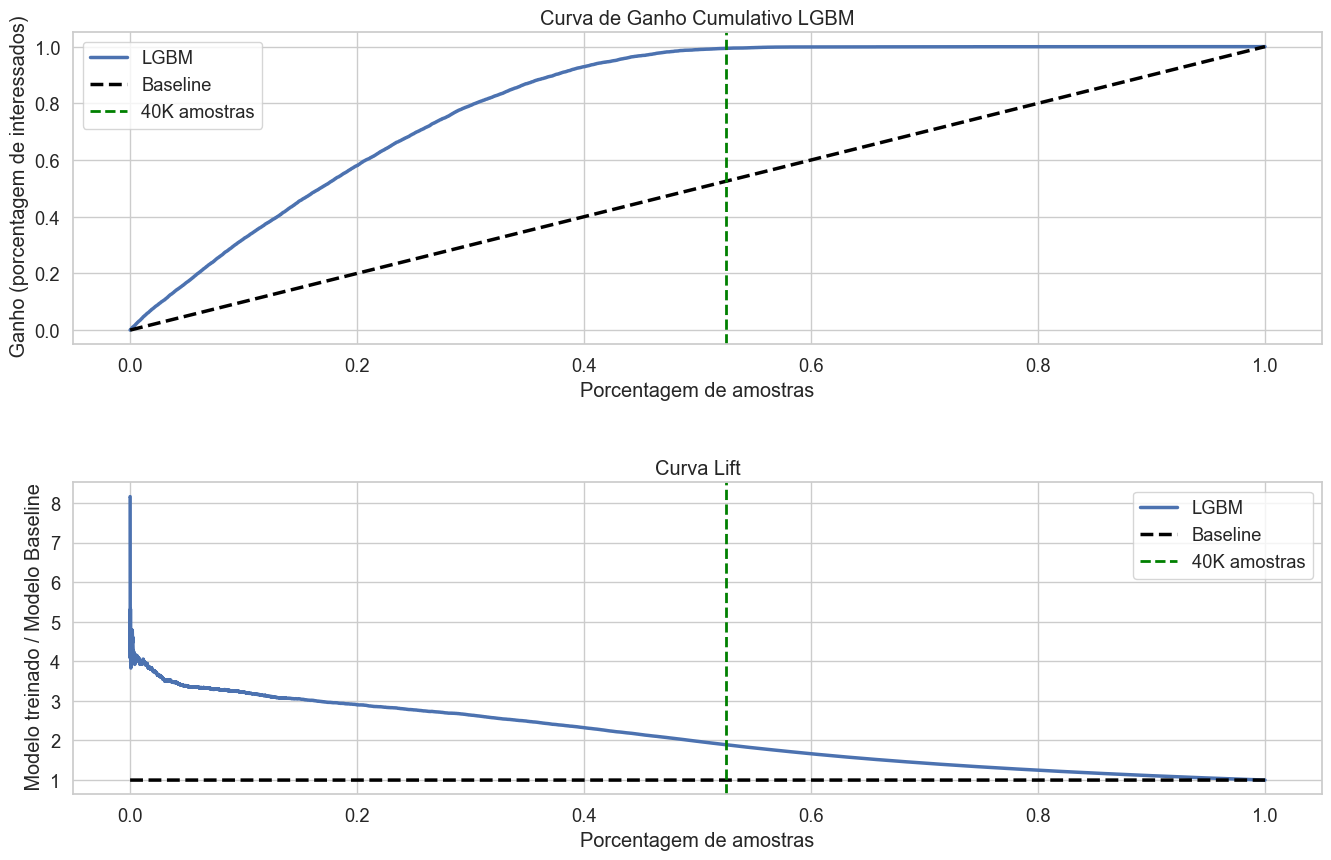

In [257]:
label_line = "40K amostras"


df_prop_score_model_final = curves(y_test, yhat_proba_final, 'LGBM', (15,10), plot = True, axvline= [ label_line ,porc_base_40k])

In [105]:
df_prop_score_model_final.loc[ 39999:39999, [ "porc_int_acum", "lift", "porc_base_acum" ] ]

porc_int_acum      lift  porc_base_acum
39999       0.993791  1.893719        0.524783

In [98]:
# Quantidade total de interessados na base de dados

quant_int = df_prop_score_model_final['target'].sum() 

quant_int

9342.0

In [106]:
# Quantidade total que o modelo treinado conseguirá atingir com 40k ligações

0.993791*quant_int

9283.995522

In [107]:
# Quantidade total que o modelo aleatório(baseline) conseguirá atingir com 20k ligações

0.524783*quant_int

4902.5227859999995

**Resposta:** 

- O time da área comercial conseguirá contatar 99,38% de clientes interessados em seguro para automóvel utilizando o algoritmo de ordenação treinado nesse projeto.  

    - Isso representa contatar aproximadamente 9.283 pessoas interessadas das 40.000 abordadas. 


- Com o modelo de ordenação aleatória (baseline), a área comercial iria conseguir contatar 52,48% dos interessados.
    
    - Isso representaria contatar aproximadamente 4902 pessoas interessadas das 40.000 abordadas.

Considerando que na lista total de clientes teste com 76.222 clientes existem no total 9.342 interessados.  

- Sendo assim, o algoritmo de classificação LGBM treinado para a tarefa de ordenação é 1,89 vezes melhor que o modelo de ordenação aleatória (baseline) na tarefa de ordenar 40.000 possíveis clientes. 

### 8.1.3. Quantas ligações o time de Outbound precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro para automóvel ?

In [114]:
int_80_porc_model_final = df_prop_score_model_final["porc_int_acum"] >= 0.8
int_80_porc_model_baseline = df_prop_score_model_final["porc_base_acum"] >= 0.8

In [115]:
df_prop_score_model_final.loc[ int_80_porc_model_final , ["porc_base_acum", "porc_int_acum", "lift" ] ]

porc_base_acum  porc_int_acum      lift
23206        0.304466       0.800043  2.627693
23207        0.304479       0.800043  2.627579
23208        0.304492       0.800043  2.627466
23209        0.304505       0.800150  2.627705
23210        0.304518       0.800257  2.627943
...               ...            ...       ...
76217        0.999948       1.000000  1.000052
76218        0.999961       1.000000  1.000039
76219        0.999974       1.000000  1.000026
76220        0.999987       1.000000  1.000013
76221        1.000000       1.000000  1.000000

[53016 rows x 3 columns]

Quantas ligações precisaria fazer para conseguir captar 80% dos clientes interessados com o modelo treinado:

In [116]:
df_prop_score_model_final.loc[ int_80_porc_model_final , ["porc_base_acum", "porc_int_acum", "lift" ] ].index[0] + 1

23207

In [117]:
df_prop_score_model_final.loc[ int_80_porc_model_baseline , ["porc_base_acum", "porc_int_acum", "lift" ] ]

porc_base_acum  porc_int_acum      lift
60977        0.800005       0.999572  1.249457
60978        0.800018       0.999572  1.249436
60979        0.800031       0.999572  1.249416
60980        0.800045       0.999572  1.249395
60981        0.800058       0.999572  1.249375
...               ...            ...       ...
76217        0.999948       1.000000  1.000052
76218        0.999961       1.000000  1.000039
76219        0.999974       1.000000  1.000026
76220        0.999987       1.000000  1.000013
76221        1.000000       1.000000  1.000000

[15245 rows x 3 columns]

Quantas ligações precisaria fazer para conseguir captar 80% dos clientes interessados com o modelo baseline:

In [118]:
df_prop_score_model_final.loc[ int_80_porc_model_baseline , ["porc_base_acum", "porc_int_acum", "lift" ] ].index[0] + 1

60978

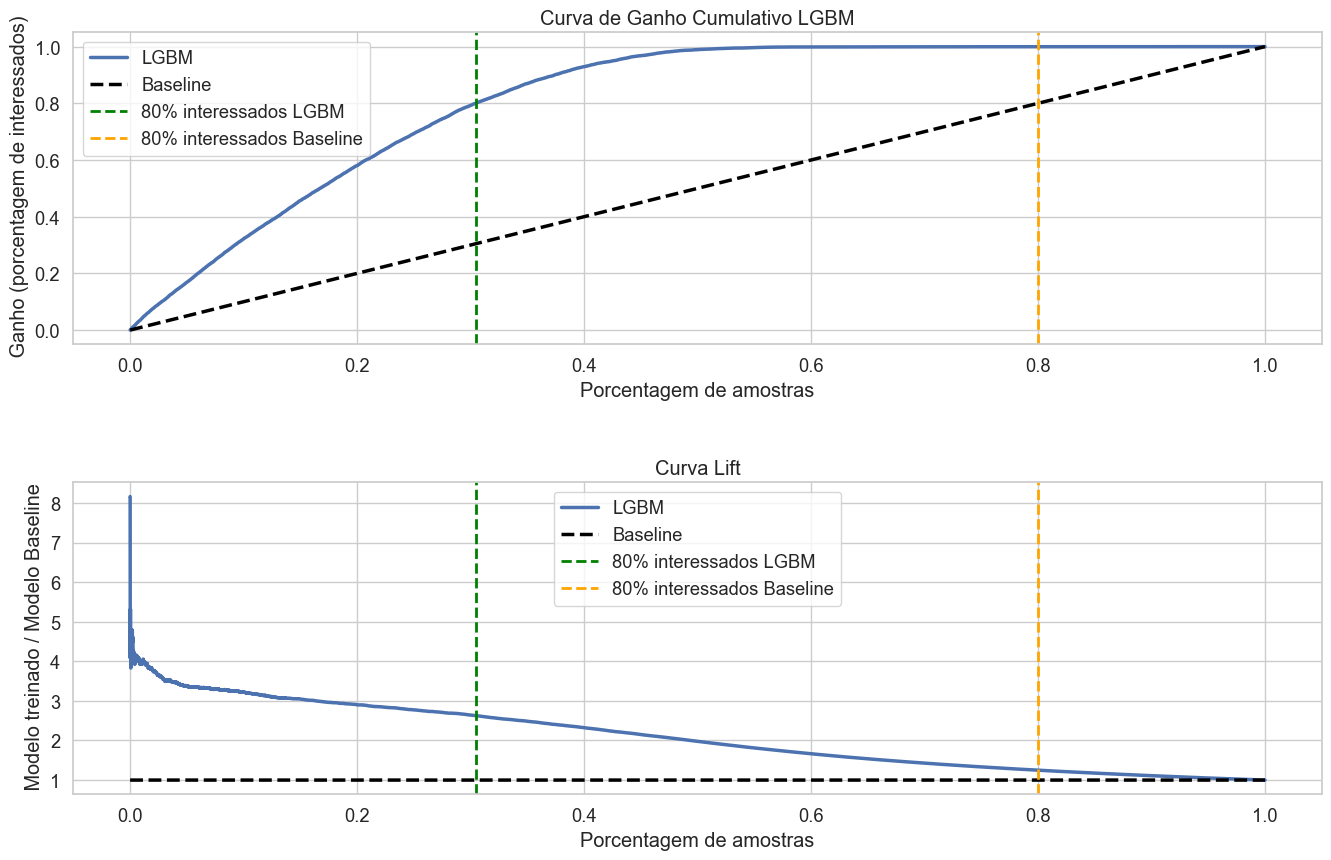

target  prop_score  porc_base_acum  porc_int_acum      lift
0         1.0    0.930432        0.000013       0.000107  8.159067
1         1.0    0.919022        0.000026       0.000214  8.159067
2         0.0    0.917881        0.000039       0.000214  5.439378
3         1.0    0.911503        0.000052       0.000321  6.119300
4         1.0    0.909180        0.000066       0.000428  6.527253
...       ...         ...             ...            ...       ...
76217     0.0    0.000078        0.999948       1.000000  1.000052
76218     0.0    0.000070        0.999961       1.000000  1.000039
76219     0.0    0.000061        0.999974       1.000000  1.000026
76220     0.0    0.000059        0.999987       1.000000  1.000013
76221     0.0    0.000027        1.000000       1.000000  1.000000

[76222 rows x 5 columns]

In [258]:
base_80 = df_prop_score_model_final.loc[ int_80_porc_model_final , "porc_base_acum"].loc[23206]


label_line_one = "80% interessados LGBM"
label_line_two = "80% interessados Baseline"

curves(y_test, yhat_proba_final, 'LGBM', (15,10), plot = True, axvline= [label_line_one, base_80, label_line_two, 0.8] )

**RESPOSTA:**
    
- Com o modelo treinado para tarefa de ordenação seriam necessárias 23.207 ligações para atingir 80% dos reais interessados;
    
    - Seria necessário ligar para 30,44% da base. Nesse cenário, o modelo treinado seria 2,63 vezes melhor que o modelo baseline.


- Em contrapartida, com o modelo baseline seriam necessárias 60.978 ligações para atingir 80% dos reais interessados.

    - Seria necessário ligar para 80% da base.Nesse cenário, o modelo treinado seria 1,25 vezes melhor que o modelo baseline.


**OBS:** 80% dos interessados significa atingir aproximadamente 7.473 pessoais com reais interesses na compra.

## 8.2. Retorno Financeiro 

Para cada uma das situações levantadas nas questões de negócio requeridas em 8.1), serão calculados o lucro, receita e custos a partir de valores estimados e premissas adotadas de negócio

As premissas para calcular o retorno do negócio são:
    

- O custo médio total da operação em abordar uma pessoa da lista de contatos para prospecção, levando em conta tempo funcionário e gasto com forma de comunicação, é de 10,00 reais;


- A receita média que a empresa recebe ao vender um produto de seguro veicular para um cliente é de 3.000 reais, em média; 



In [162]:
df_prop_score_model_final

target  prop_score  porc_base_acum  porc_int_acum      lift
0         1.0    0.930432        0.000013       0.000107  8.159067
1         1.0    0.919022        0.000026       0.000214  8.159067
2         0.0    0.917881        0.000039       0.000214  5.439378
3         1.0    0.911503        0.000052       0.000321  6.119300
4         1.0    0.909180        0.000066       0.000428  6.527253
...       ...         ...             ...            ...       ...
76217     0.0    0.000078        0.999948       1.000000  1.000052
76218     0.0    0.000070        0.999961       1.000000  1.000039
76219     0.0    0.000061        0.999974       1.000000  1.000026
76220     0.0    0.000059        0.999987       1.000000  1.000013
76221     0.0    0.000027        1.000000       1.000000  1.000000

[76222 rows x 5 columns]

### 8.2.1. O time de Outbound possui capacidade de entrar em contato direto com apenas 20 mil potenciais clientes

In [240]:
porc_base_20k = 20000 / len(df_prop_score_model_final)
porc_base_20k

0.2623914355435439

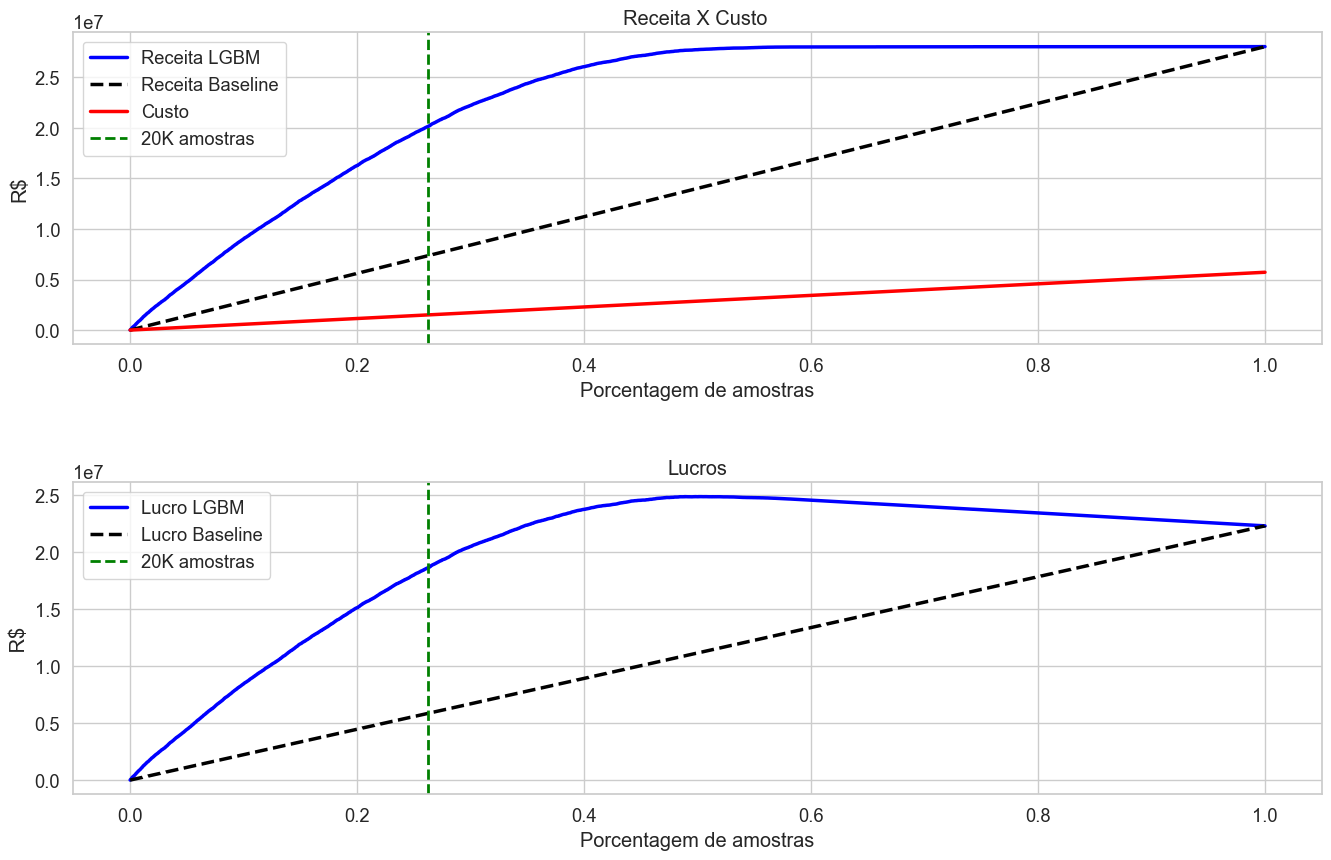

In [259]:
model_name = "LGBM"
size = (15,10)
label_line = "20K amostras"

df_fin = finance_calculate(df_prop_score_model_final, model_name, size, df_return = True, plot = True, axvline= [ label_line , porc_base_20k])

In [271]:
df_fin.loc[19999:19999 , ["custo_acum", "receita_acum", "lucro_acum", "receita_acum_baseline", "lucro_acum_baseline"]]

custo_acum  receita_acum  lucro_acum  receita_acum_baseline  lucro_acum_baseline
19999   1500000.0    20130000.0  18630000.0              7353000.0            5853000.0

**Resposta:** 

De acordo com as premissas:

- O custo da operação para prospectar 20.000 pessoas é de 1.500.000,00 reais.

Ordenação via Algoritmo LGBM treinado:

- A operação de prospecção de 20.000 pessoas ordenadas gera para empresa uma receita estimada de 20.130.000,00 reais.

- O lucro total está estimado em 18.630.000,00 reais.

Ordenação via modelo aleatório (Baseline):

- A operação de prospecção de 20.000 pessoas ordenadas aleatoriamente gera para empresa uma receita estimada de 7.353.000,00 reais.

- O lucro total está estimado em 5.853.000,00 reais.

CONCLUSÃO: Ao utilizar o modelo de machine learning desenvolvido nesse projeto para priorizar a prospecção de 20.000 pessoas de uma lista de 76.222 ao invés de escolher aleatoriamente, a empresa terá um lucro adicional de 12.777.000,00 reais. 

### 8.2.2. O time de Outbound possui capacidade de entrar em contato direto com apenas 40 mil potenciais clientes

In [245]:
porc_base_40k = 40000 / len(df_prop_score_model_final)
porc_base_40k

0.5247828710870878

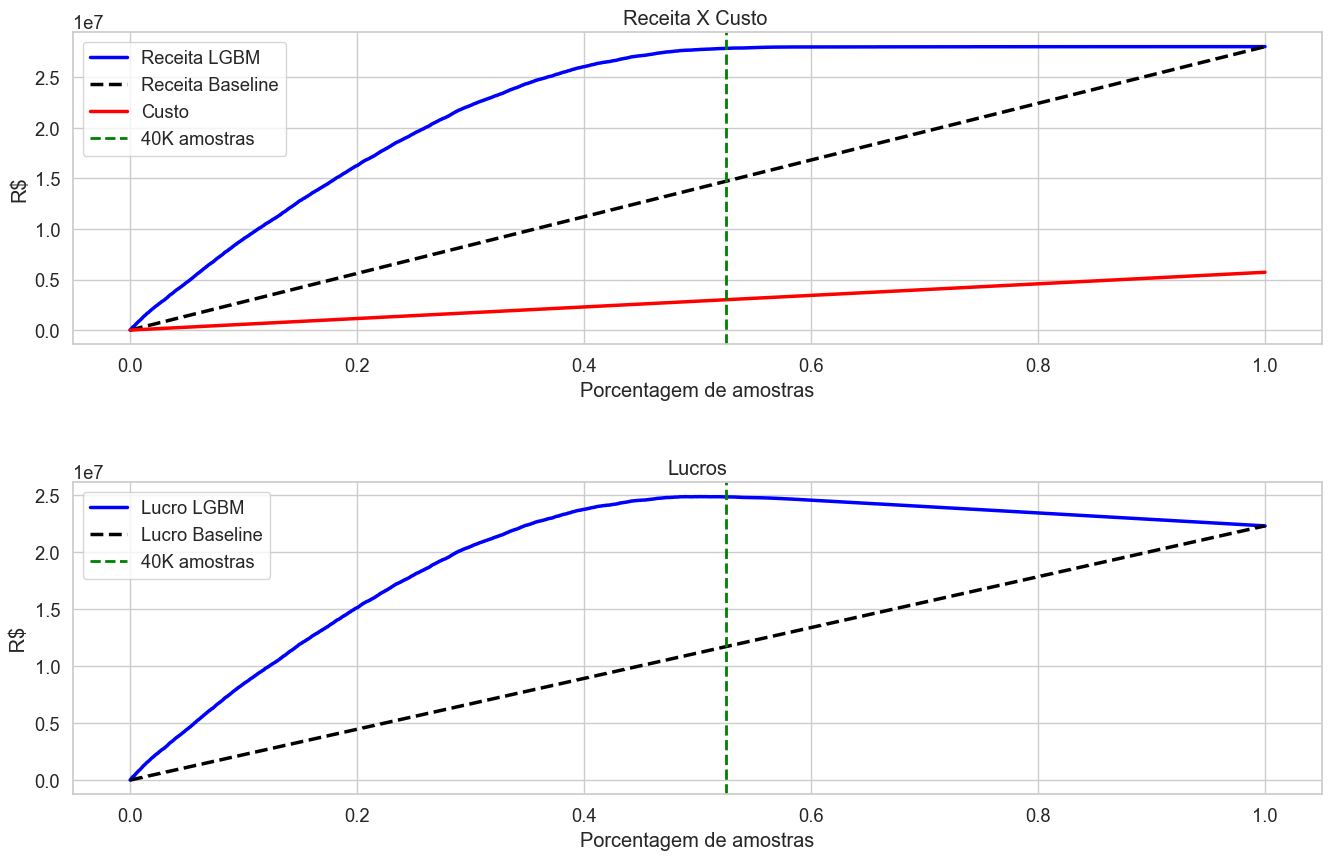

In [260]:
model_name = "LGBM"
size = (15,10)
label_line = "40K amostras"

finance_calculate(df_prop_score_model_final, model_name, size, df_return = False, plot = True, axvline= [label_line,porc_base_40k])

In [272]:
df_fin.loc[39999:39999 , ["porc_base_acum","custo_acum", "receita_acum", "lucro_acum", "receita_acum_baseline", "lucro_acum_baseline"]]

porc_base_acum  custo_acum  receita_acum  lucro_acum  receita_acum_baseline  lucro_acum_baseline
39999        0.524783   3000000.0    27852000.0  24852000.0             14706000.0           11706000.0

**Resposta:** 

De acordo com as premissas:

- O custo da operação para prospectar 40.000 pessoas é de 3.000.000,00 reais.

Ordenação via Algoritmo LGBM treinado:

- A operação de prospecção de 40.000 pessoas ordenadas geraria para empresa uma receita estimada de 27.852.000,00 reais.

- O lucro total estaria estimado em 24.852.000,00 reais.

Ordenação via modelo aleatório (Baseline):

- A operação de prospecção de 40.000 pessoas ordenadas aleatoriamente geraria para empresa uma receita estimada de 14.706.000,00 reais.

- O lucro total estaria estimado em 11.706.000,00 reais.

CONCLUSÃO: Ao utilizar o modelo de machine learning desenvolvido nesse projeto para priorizar a prospecção de 40.000 pessoas de uma lista de 76.222 ao invés de escolher aleatoriamente, a empresa terá um lucro adicional de 13.146.000,00 reais. 

### 8.2.3. Contatar 80% dos clientes interessados

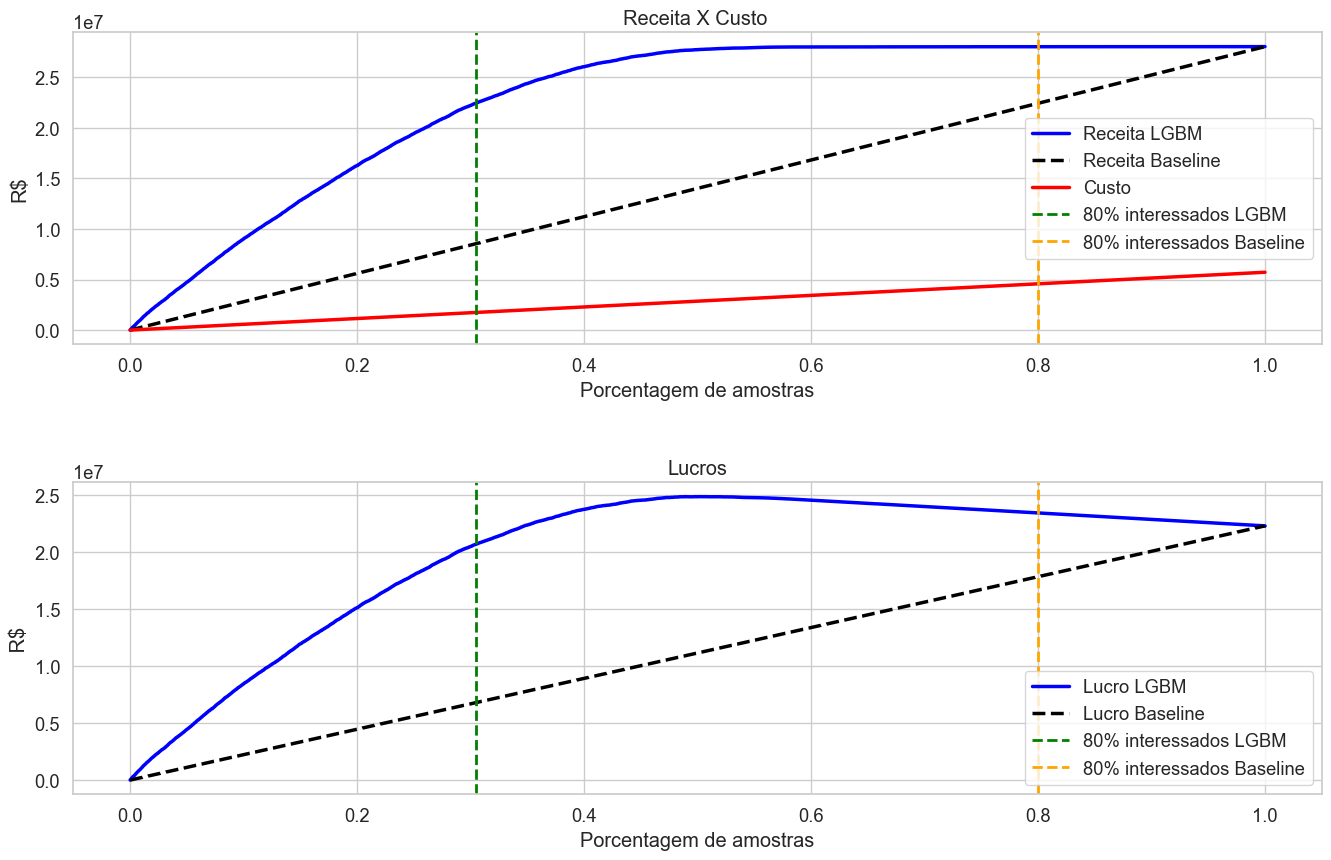

In [261]:
# Variavel condicional para filtrar 
int_80_porc_model_final = df_prop_score_model_final["porc_int_acum"] >= 0.8

# porc. da base necessária para contatar 80% dos interessados
base_80 = df_prop_score_model_final.loc[ int_80_porc_model_final , "porc_base_acum"].loc[23206]


model_name = "LGBM"
size = (15,10)
label_line_one = "80% interessados LGBM"
label_line_two = "80% interessados Baseline"

finance_calculate(df_prop_score_model_final, model_name, size , df_return = False, plot = True, axvline= [ label_line_one ,base_80, label_line_two, 0.8] )

In [273]:
df_fin.loc[23206:23206 , ["porc_base_acum","custo_acum", "receita_acum", "lucro_acum", "receita_acum_baseline", "lucro_acum_baseline"]]

porc_base_acum  custo_acum  receita_acum  lucro_acum  receita_acum_baseline  lucro_acum_baseline
23206        0.304466   1740525.0    22422000.0  20681475.0              8532000.0            6791475.0

In [274]:
df_fin.loc[60977:60977 , ["porc_base_acum","custo_acum", "receita_acum", "lucro_acum", "receita_acum_baseline", "lucro_acum_baseline"]]

porc_base_acum  custo_acum  receita_acum  lucro_acum  receita_acum_baseline  lucro_acum_baseline
60977        0.800005   4573350.0    28014000.0  23440650.0             22419000.0           17845650.0

**Resposta:** 

De acordo com as premissas, para atingir 80% dos interessados:

Ordenação via Algoritmo LGBM treinado:

- O custo da operação para prospectar 23.207 pessoas (80% interessados) é de 1.740.525,00 reais.

- A operação de prospecção geraria para empresa uma receita estimada de 22.422.000,00 reais.

- O lucro total estaria estimado em 20.681.475,00 reais.

Ordenação via modelo aleatório (Baseline):

- O custo da operação para prospectar 60.978 pessoas (80% interessados) é de 4.573.350,00 reais.

- A operação de prospecção geraria para empresa uma receita estimada de 22.419.000,00 reais.

- O lucro total estaria estimado em 17.845.650,00 reais.

CONCLUSÃO: Ao utilizar o modelo de machine learning desenvolvido nesse projeto para atingir 80% dos interessados ao invés de escolher aleatoriamente, a empresa além de ter um lucro adicional de 2.835.825,00 reais, conseguiria alcançar isso fazendo 37.771 ligações/prospecções a menos. 

### 8.2.4. Quantidade de pessoas para abordar e obter lucro máximo com algoritmo de ordenação treinado

In [275]:
## Procurar ponto onde o lucro é máximo no modelo treinado

lucro_max = df_fin["lucro_acum"] == df_fin["lucro_acum"].max()

df_fin.loc[ lucro_max , ["custo_acum","porc_base_acum", "porc_int_acum" ,"receita_acum", "lucro_acum", "receita_acum_baseline" , "lucro_acum_baseline"] ]

custo_acum  porc_base_acum  porc_int_acum  receita_acum  lucro_acum  receita_acum_baseline  lucro_acum_baseline
38297   2872350.0        0.502453       0.990045    27747000.0  24874650.0             14079000.0           11206650.0

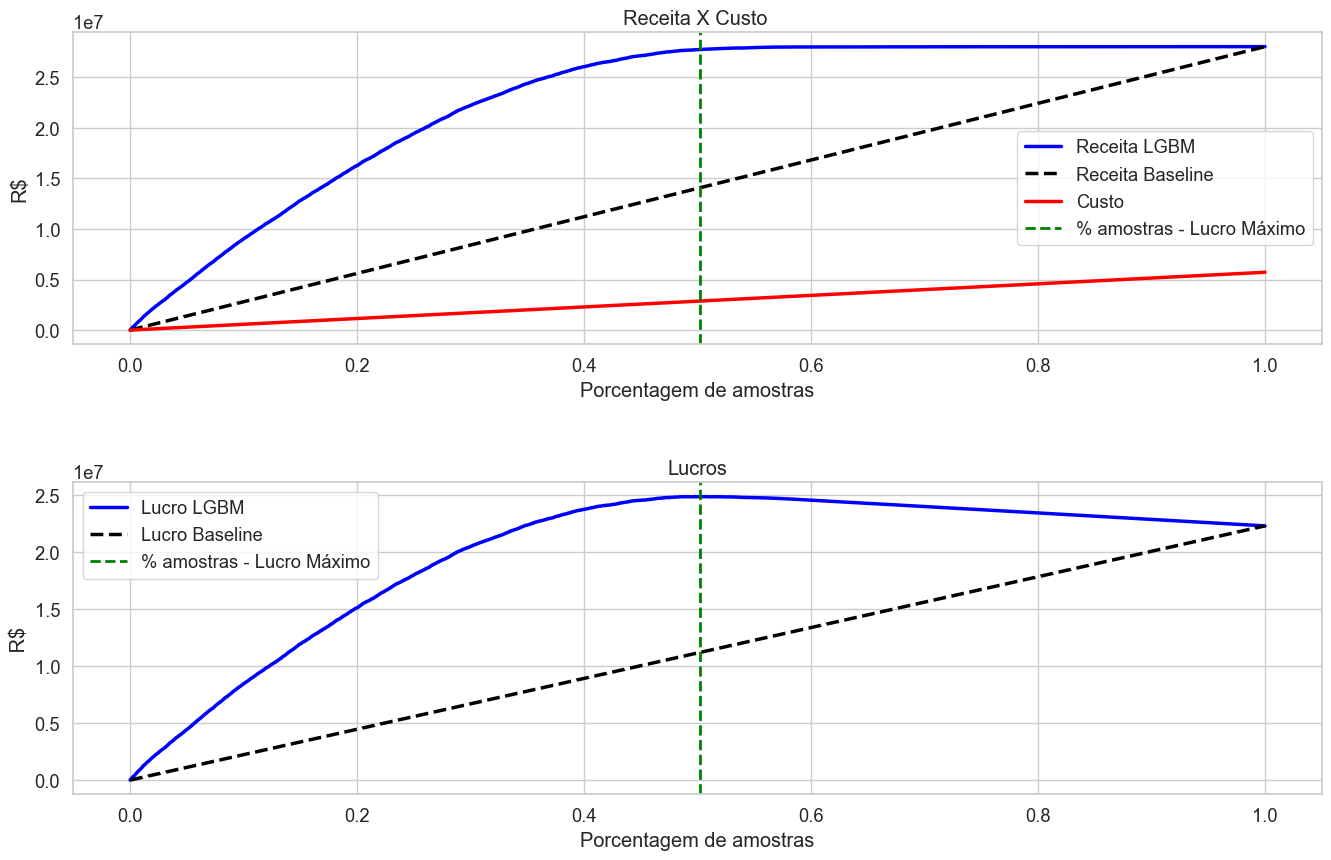

In [270]:
line_max = 0.502453
label_max = "% amostras - Lucro Máximo"


finance_calculate(df_prop_score_model_final, model_name, size , df_return = False, plot = True, axvline= [ label_max , line_max] )

**Resposta:** 


De acordo com as premissas:

- O lucro máximo da operação de prospecção da lista de contatos ordenada pelo algoritmo LGBM é atingido ao abordar 50,24% (38.298) da base total de contatos.  

- O custo da operação para prospectar 38.298 pessoas, as quais representam aproximadamente 99% dos interessados é de 2.872.350,00 reais.

- A operação de prospecção geraria para empresa uma receita estimada de 27.747.000,00 reais.

- Com isso, o lucro estaria estimado em 24.874.650,00 reais.


Em contrapartida, utilizando a ordenação via modelo aleatório (Baseline) para abordar a mesma quantidade de pessoas da base:

- A operação de prospecção geraria para empresa uma receita estimada de 14.079.000,00 reais.

- O lucro total estaria estimado em 11.206.650,00 reais.


**CONCLUSÃO:** Ao utilizar o modelo de machine learning desenvolvido nesse projeto ao invés de escolher aleatoriamente, a empresa chegaria a um lucro máximo da operação abordando aproximadanete 50% da base total e assim, um acréscimo de lucro de aproximadamente 10 milhões. 


**OBS:** O modelo aleatório (Baseline) atingiria seu lucro máximo na operação apenas abordando 100% da base (76.222 clientes), e esse lucro seria estimado em 22.309.350,00. 

- Comparando com o lucro máximo obtido pelo algoritmo LGBM desenvolvido nesse projeto esse valor é aproximadamente 2,5 milhões menor devido aos esforços que reflete nos custos em prospectar a base de contatos inteira. 

In [263]:
df_fin

target  prop_score  porc_base_acum  porc_int_acum      lift  custo  receita   lucro  custo_acum  receita_acum  lucro_acum  n_int_baseline  n_int_model_final  n_int_baseline_piso  target_baseline  receita_baseline  lucro_baseline  receita_acum_baseline  lucro_acum_baseline
0         1.0    0.930432        0.000013       0.000107  8.159067   75.0   3000.0  2925.0        75.0        3000.0      2925.0        0.122563                1.0                    0              0.0               0.0           -75.0                    0.0                -75.0
1         1.0    0.919022        0.000026       0.000214  8.159067   75.0   3000.0  2925.0       150.0        6000.0      5850.0        0.245126                2.0                    0              0.0               0.0           -75.0                    0.0               -150.0
2         0.0    0.917881        0.000039       0.000214  5.439378   75.0      0.0   -75.0       225.0        6000.0      5775.0        0.367689                2.0                    0              0.0               0.0           -75.0                    0.0               -225.0
3         1.0    0.911503        0.000052       0.000321  6.119300   75.0   3000.0  2925.0       300.0        9000.0      8700.0        0.490252                3.0                    0              0.0               0.0           -75.0                    0.0               -300.0
4         1.0    0.909180        0.000066       0.000428  6.527253   75.0   3000.0  2925.0       375.0       12000.0     11625.0        0.612815                4.0                    0              0.0               0.0           -75.0                    0.0               -375.0
...       ...         ...             ...            ...       ...    ...      ...     ...         ...           ...         ...             ...                ...                  ...              ...               ...             ...                    ...                  ...
76217     0.0    0.000078        0.999948       1.000000  1.000052   75.0      0.0   -75.0   5716350.0    28026000.0  22309650.0     9341.509748             9342.0                 9341              0.0               0.0           -75.0             28023000.0           22306650.0
76218     0.0    0.000070        0.999961       1.000000  1.000039   75.0      0.0   -75.0   5716425.0    28026000.0  22309575.0     9341.632311             9342.0                 9341              0.0               0.0           -75.0             28023000.0           22306575.0
76219     0.0    0.000061        0.999974       1.000000  1.000026   75.0      0.0   -75.0   5716500.0    28026000.0  22309500.0     9341.754874             9342.0                 9341              0.0               0.0           -75.0             28023000.0           22306500.0
76220     0.0    0.000059        0.999987       1.000000  1.000013   75.0      0.0   -75.0   5716575.0    28026000.0  22309425.0     9341.877437             9342.0                 9341              0.0               0.0           -75.0             28023000.0           22306425.0
76221     0.0    0.000027        1.000000       1.000000  1.000000   75.0      0.0   -75.0   5716650.0    28026000.0  22309350.0     9342.000000             9342.0                 9342              1.0            3000.0          2925.0             28026000.0           22309350.0

[76222 rows x 19 columns]

# 9.0. DEPLOY MODEL TO PRODUCTION 

## 10.1. Rossmann Class 

In [176]:
import pickle 
import inflection 
import pandas as pd
import numpy as np 
import math 
import datetime

## DATA CLEANING + FEATURE ENGINEERING + DATA FILTERING + DATA PREPARATION + FEATURE SELECTION

class Rossmann( object ):
    def __init__( self ):
        self.home_path = 'C:/Users/alanc/Documents/repos/ds_em_producao/prediction_sales/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding           = pickle.load(open(self.home_path + 'parameter/store_type_encoding.pkl', 'rb'))


    def data_cleaning(self, df1):
       
        ## 1.1. Rename Columns ---------------------------------------------------------------------

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        ## Utiliza função lambda para encapsular a função que transforma para snake_case os atributos
        snakecase = lambda x: inflection.underscore( x )

        ## Map - Mapeia cada valor dentro da estrutura de dado passada e aplica a função snakecase
        cols_new = list( map( snakecase, cols_old ) )

        ## rename 
        df1.columns = cols_new

        ## 1.3. Data Types ---------------------------------------------------------------------

        ## Arrumar para a coluna date ficar com o tipo de dado correto
        df1['date'] = pd.to_datetime( df1['date'] )


        ## 1.5. Fillout NA ---------------------------------------------------------------------

        #competition_distance    

        # Assumptions: o valor NA ocorre quando a loja em questão não possui competidor próximo ou esse é tão longe que não é 
        # considerado competidor próximo

        # Action: substituir os NA´s por um valor maior que o valor máximo existente para outras lojas

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x)

        #competition_open_since_month   

        # Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
        # abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
        # próximo. 

        # Action: substituir os NA´s pelo valor do mês da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year     

        # Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
        # abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
        # próximo. 

        # Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)


        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                        else x['competition_open_since_year'], axis = 1)

        #promo2_since_week               

        # Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe semana de início da promo2 se a loja
        # decidiu não participar. 

        # Action: substituir os NA´s pelo valor da semana da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                        else x['promo2_since_week'], axis = 1)

        #promo2_since_year               

        # Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe ano de início da promo2 se a loja
        # decidiu não participar. 

        # Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                        else x['promo2_since_year'], axis = 1)

        #promo_interval

        # Assumptions: épocas de promoção 2 são conjuntos de meses que caracterizam o início de promoções 2. O NA nessa coluna 
        # caracteriza que a loja referida não realizou promoções em nenhum mês do ano da referente data. 

        # Action: substituir os NA´s por 0 pois significa que não tem época de promoção naquele ano. 
        # Criar coluna extra ('is_promo') para indicar se mês de venda da loja vigente é o mês de promo2 consecutiva. 

        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)

        #month_map é a abreviação do mês de mensuração de venda
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        # atributo que diz se o mês de venda é o mês em que se realiza promoção periodicamente
        df1['is_promo'] = df1[['month_map','promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if 
                                                                    x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)


        ## 1.6. Change Types ---------------------------------------------------------------------


        ### Mudar nº de mês, ano e semana de float64 para int64

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

        return df1
    
    
    def feature_engineering(self, df2):
        
        ## FEATURE ENGINEERING + DATA FILTERING
        
        ## 2.4. Feature Engineering

        ### 2.4.1. Da variável 'date'

        # year - extrair apenas o ano de vendas daquela loja

        df2['year'] = df2['date'].dt.year

        # month - extrair apenas o mês de vendas daquela loja

        df2['month'] = df2['date'].dt.month

        # day - extrair apenas o dia de vendas daquela loja

        df2['day'] = df2['date'].dt.day

        # week of year - extrair apenas a semana de vendas do ano daquela loja

        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # (year-week) - Formatar a data para em string aparecer o ano e a semana do ano das vendas daquela loja

        df2['year_week'] = df2['date'].dt.strftime("%Y-%W")


        ### 2.4.2. Das variáveis 'competition_open_since_month' e 'competition_open_since_year'

        # competition since  
        df2['competition_since'] = df2[['competition_open_since_year','competition_open_since_month']].apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'] , day = 1 ), axis = 1)

        # competition time month - Calculo de período entre datas
        df2['competition_time_month'] =( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

        ### 2.4.3. Das variáveis ''promo2_since_week'' e 'promo2_since_year'

        # promo since 
        df2['promo_since'] =  df2['promo2_since_year'].astype( str ) + "-" + df2['promo2_since_week'].astype( str )

        # datetime
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7) )


        # promo time week - - Calculo de período entre datas
        df2['promo_time_week'] =( (df2['date'] - df2['promo_since']) / 7 ).apply(lambda x: x.days ).astype( 'int64' )

        ### 2.4.4. Da variável 'assortment'
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        ### 2.4.5. Da variável 'state_holiday'       
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. FILTRAGEM DE VARIÁVEIS

        ## 3.1. Filtragem das Linhas

        df2 = df2[ df2['open'] != 0  ]

        ## 3.2. Seleção das Colunas

        ## COLUNAS EXCLUÍDAS:
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop( cols_drop, axis = 1 )
                
        return df2 
    
    def data_preparation(self, df5):
        
        
        ## 5.2. Rescaling

        # competition_distance
        df5["competition_distance"] = self.competition_distance_scaler.transform( df5[["competition_distance"]].values )

        # competition_time_month
        df5["competition_time_month"] = self.competition_time_month_scaler.transform( df5[["competition_time_month"]].values )

        # promo_time_week
        df5["promo_time_week"] = self.promo_time_week_scaler.transform( df5[["promo_time_week"]].values )
        
        # year
        df5["year"] = self.year_scaler.transform( df5[["year"]].values )
        
        ## 5.3. Transformação 

        ### 5.3.1. Encoding

        # state_holiday -> One Hot Encoding 
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type - Label Encoder
        df5["store_type"] = self.store_type_encoding.transform( df5["store_type"] )
              
        # assortment
        assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
        # Troca de valores da coluna utilizando o método .map e o dicionário como referência
        df5["assortment"] = df5["assortment"].map(assortment_dict)


        ### 5.3.3. Nature Transformation

        ## FEATURES COM NATUREZA CÍCLICA:

        # day_of_week - ciclo de 7 
        df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )


        # month - ciclo de 12
        df5["month_sin"] = df5["month"].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5["month_cos"] = df5["month"].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


        # day - ciclo de 31
        df5["day_sin"] = df5["day"].apply(lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
        df5["day_cos"] = df5["day"].apply(lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )


        # week_of_year - ciclo de 52 
        df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # Feature Selection with Boruta and EDA
        cols_selected = ['store', 'promo', 'store_type','assortment', 'competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year', 'competition_time_month',
        'promo_time_week','day_of_week_sin','day_of_week_cos','month_cos','month_sin','day_sin','day_cos','week_of_year_cos',
        'week_of_year_sin']
        
        
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data 
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso' )

## 10.2. API Handler 

In [ ]:
import pandas as pd

## Importando classe Rossmann do arquivo Rossmann.py da pasta rossmann
#from nome_pasta.nome_arquivo import class_in_arquivo
from rossman.Rossmann import Rossmann

## Biblioteca para construir interfaces(app) Web em Python para construir API´s
from flask import Flask, request, Response

# loading model 
model = pickle.load(open('C:/Users/alanc/Documents/repos/ds_em_producao/prediction_sales/model/model_xgb_rossmann.pkl', 'rb'))

# instaciando objeto da classe Flask que será a API
app = Flask( __name__ )

# criando endpoint com método POST (envia algum dado para poder receber)
## método GET (pede algum dado para poder receber)
@app.route('/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json() ## Classe request com método get_json() para puxar o dado enviado para a API

    if test_json: # Para checar se há dado 
        if isinstance(test_json, dict): #unique example/observations/sample in dict
            test_raw = pd.DataFrame(test_json, index = [0])
            
        else: #multiple example/observations/sample in dict (dict aninhado)
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys() )
            
        ## Intanciando objeto da classe Rossmann 
        pipeline = Rossmann()
        
        # data cleaning - começo a usar os métodos da classe Rossmann criada
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering 
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation 
        df3 = pipeline.data_preparation( df2 )
            
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response ## Dado resposta para a entidade que solitou algo via dado 
       
        
    else:
        
        return Response( '{}', status = 200, mimetype = 'application/json')
        
if __name__ == '__main__':
    app.run( '192.168.0.6' ) ## dizer para endpoint rodar no localhost (rodando na máquina)
# 192.168.0.6 -> endereço IPv4 pc local  

## 10.3. API Tester 

In [5]:
# loading test dataset
df10 = pd.read_csv('data/test.csv')

In [ ]:
## Dados de teste possuem atributos de store e data entre as datas de 01/08/2015 à 17/09/2015 

In [56]:
## merge test dataset + store 
df11 = df10.merge(df_store_raw, how = "left", on = "Store")

## choose store for prediction
df11 = df11[ df11['Store'].isin([24,12,22]) ] 

# Manipulation 

## remove closed days
df11 = df11[ df11['Open'] != 0 ]
## select just samples without NA 
df11 = df11[ df11['Open'].notnull() ]
## exclude column "Id"
df11 = df11.drop('Id', axis = 1)

In [57]:
# convert Dataframe to json for send comunication between the systems
data = json.dumps( df11.to_dict( orient = 'records' ) )

## data é uma lista de dicionários(json) onde cada dicionário representa uma linha do dataframe

In [63]:
# API Call

# url local - endereço em que os dados serão enviados (IP + PORTA + endpoint) 
#url = 'http://192.168.0.6:5000/rossmann/predict'
# url em servidor na nuvem 
url = 'https://rossmann-predict-sales-project.onrender.com/rossmann/predict'
# Formato dos dados que serão enviados
header = {'Content-type': 'application/json'}
# dado a ser enviado
data = data



r = requests.post(url = url, data = data, headers = header)
print( f'Status Code { r.status_code }' )

Status Code 200


In [64]:
## Predição diária de vendas durante 6 semanas para as lojas selecionadas
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [65]:
## Soma da Predição diária de vendas para as 6 semanas das lojas selecionadas 
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

### dysplay response with sum of sales

for i in range( len(d2) ):
    print('\nA loja nº {} irá vender US$ {:,.2f} dólares nas próximas 6 semanas.'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction'] ) )


A loja nº 12 irá vender US$ 309,000.11 dólares nas próximas 6 semanas.

A loja nº 22 irá vender US$ 185,927.49 dólares nas próximas 6 semanas.

A loja nº 24 irá vender US$ 382,319.80 dólares nas próximas 6 semanas.


## 10.4. Sugestões de Melhoria

- Ao prospectar uma lista de reais interessados em quaisquer produtos de seguro, existe uma métrica de mercado no processo comercial de conversão histórica (coletada internamente) e através de benchmarking (coletada externamente) que coloca que dos reais interessados existe uma faixa de 70% a 80% que viram cliente.


    - CENÁRIO OTIMISTA: De 81% a 100% dos reais interessados prospectados tornem-se clientes;
    - CENÁRIO REALISTA: De 70% a 80% dos reais interessados prospectados tornem-se clientes;
    - CENÁRIO PESSIMISTA: Abaixo de 70% dos reais interessados prospectados tornem-se clientes.